# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from collections import defaultdict
from scipy.stats import beta
from scipy.special import betaln
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'netifier-besra'
epochs = 10
batch_size = 32
sequence_length = 96

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/netifier-2/processed_train.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/netifier-2/processed_test.csv', encoding='latin-1')

data = pd.concat([train_data, val_data], ignore_index=True)
data.shape

(7773, 7)

In [7]:
data.head()

,original_text,source,pornografi,sara,radikalisme,pencemaran_nama_baik,processed_text
0,[QUOTE=jessepinkman16;5a50ac34d89b093f368b456e...,kaskus,0,0,0,1,jabar memang provinsi barokah boleh juga dan n...
1,"@verosvante kita2 aja nitizen yang pada kepo,t...",instagram,0,0,0,0,kita saja nitizen yang pada penasaran toh kelu...
2,"""#SidangAhok smg sipenista agama n ateknya mat...",twitter,0,1,1,1,sidangahok semoga sipenista agama dan ateknya ...
3,@bolususulembang.jkt barusan baca undang2 ini....,instagram,0,0,0,0,jakarta barusan baca undang ini tetap dibedaka...
4,bikin anak mulu lu nof \nkaga mikir apa kasian...,kaskus,0,0,0,0,buat anak melulu kamu nof nkaga mikir apa kasi...


In [8]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

train_labels = train_data.columns[2:6]
val_labels = val_data.columns[2:6]

# Extract features and labels for training and validation
X_train = train_data['processed_text'].values
y_train = train_data[train_labels].values
X_val = val_data['processed_text'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(6218,) (6218, 4)
(1555,) (1555, 4)


# BUILD DATASET & DATALOADERS

In [9]:
class NetifierDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=96, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

    def get_per_class_probs(self):
        """
        Calculate the spread of labels (0 and 1) for each class in the dataset.
        Returns:
            dict: A dictionary where keys are class indices and values are [count_0, count_1].
        """

        # Initialize a dictionary to store counts for each class
        label_counts = defaultdict(lambda: [0, 0])  # [count_0, count_1] for each class

        for i in range(len(self)):
            # Get the labels for the i-th sample
            labels = self[i]['labels']

            # Update counts for each class
            for class_idx, label in enumerate(labels):
                label_counts[class_idx][int(label)] += 1

        for key in label_counts.keys():
            total = sum(label_counts[key])
            label_counts[key] = [x / total for x in label_counts[key]]

        return label_counts

    def get_global_probs(self):
        """
        Calculate the global count of 0s and 1s across all classes in the dataset.
        Returns:
            dict: A dictionary with keys '0' and '1' representing their global counts.
        """
        global_counts = {'0': 0, '1': 0}

        for i in range(len(self)):
            # Get the labels for the i-th sample
            labels = self[i]['labels']

            # Update global counts
            for label in labels:
                global_counts[str(int(label))] += 1

        total = global_counts['0'] + global_counts['1']
        for key in global_counts.keys():
            global_counts[key] /= total

        return global_counts


# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [10]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=96, num_workers=4):
    train_dataset = NetifierDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = NetifierDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [11]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [12]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik'],
        zero_division=0
    )  

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [13]:
def train_model(current_train_size, train_indices, metrics, trials, i):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(train_labels),
            problem_type="multi_label_classification"
        )
        
    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials+1}-model-{i+1}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"Model {i+1} - Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
        
    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Training completed in {duration} s")
    
    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(best_result['accuracy'])
        metrics[1].append(best_result['f1_micro'])
        metrics[2].append(best_result['f1_macro'])

# PLOT RESULT

In [14]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [15]:
def beta_score(p, y, alpha=0.1, beta=3):
    """Calculates Beta score for a given probability p and label y."""
    
    if y == 1:
        return -betaln(alpha, beta + 1) + betaln(alpha + p, beta + 1 - p)
    elif y == 0:
        return -betaln(alpha + 1, beta) + betaln(alpha + 1 - p, beta + p)
    else:
        raise ValueError("Invalid label: y must be 0 or 1.")

def bayesian_update(prior, likelihood, evidence, alpha=0.1, beta_param=3):
    """ 
    Bayes' Theorem: P(y'|x') = P(x'|y') * P(y') / P(x')
    P(y'|x') or likelihood = model probs
    p(y') or prior = class probabilities
    p(x') or evidence = 1 / number of data
    """
    
    # Using the Beta score to simulate the posterior
    posterior = (likelihood * prior) / evidence
    
    # We calculate the posterior using the Beta distribution
    return posterior

def compute_expected_score_change(predicted_prob, class_probs, label_probs, class_idx):
    scores_before = []
    scores_after = []

    # Before data addition: calculate Beta score for predicted prob
    scores_before.append(beta_score(predicted_prob, int(1 if predicted_prob >= 0.5 else 0)))
    scores_before.append(beta_score(1-predicted_prob, int(1 if predicted_prob >= 0.5 else 0)))
    
    # After data addition: use Bayesian update (posterior probability)
    for k in range(2):
        prior = predicted_prob
        likelihood = class_probs[class_idx][k]  # Likelihood is the true label (0 or 1)
        posterior = bayesian_update(prior, likelihood, 1)
        scores_after.append(beta_score(posterior, int(1 if posterior >= 0.5 else 0)))

    score_diff_0 = scores_after[0] - scores_before[0]
    score_diff_1 = scores_after[1] - scores_before[1]
    return label_probs['0'] * score_diff_0 + label_probs['1'] * score_diff_1

# Function to compute Expected Score Change (∆Q)
def besra_sampling(models, X_pool, train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, trials, n_clusters=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device
    
    dataset = NetifierDataset(X_pool, np.zeros((len(X_pool), 4)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )

    current_train_size = len(train_indices)
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    labeled_dataset = NetifierDataset(current_X_train, current_y_train, tokenizer, max_length=sequence_length)
    label_probs = labeled_dataset.get_global_probs()
    class_probs = labeled_dataset.get_per_class_probs()

    for model in models:
        model.to(device)
        model.eval()
    start_time = time.time()
    score_changes = []

    for batch in dataloader:
        input_ids = batch['input_ids'].to(model.device)
        attention_mask = batch['attention_mask'].to(model.device)
        labels = batch['labels'].to(model.device)

        model_probs = []

        for model in models:
            with torch.no_grad():
                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                probs = torch.sigmoid(logits)  # Multi-label classification uses sigmoid
                model_probs.append(probs.unsqueeze(0))  # Add batch dimension for averaging
        
        # Stack all model predictions and compute the mean across models
        model_probs = torch.cat(model_probs, dim=0)  # Concatenate predictions across models
        probs = model_probs.mean(dim=0)  # Take the mean along the model axis

        # Calculate Beta scores before and after data addition
        for i in range(len(probs)):
            score_diff = []
            for class_idx in range(probs.shape[1]):
                predicted_prob = probs[i, class_idx].item()
                score_diff.append(compute_expected_score_change(predicted_prob, class_probs, label_probs, class_idx))
            
            score_changes.append(np.mean(score_diff))
    
    accelerator.wait_for_everyone()    
    if accelerator.is_local_main_process:
        score_changes = np.array(score_changes)
        score_changes = score_changes.reshape(-1, 1)

        target_samples = math.ceil(0.1 * len(X_pool))
        collected_indices = set()
        thresholds = []
    
        # Check nearest checkpoint
        nearest_cp = 0
        arrived_at_cp = False
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break

        # Determine number of maximum samples to be acquired
        if target_samples <= n_clusters and n_clusters < nearest_cp - current_train_size:
            target_samples = n_clusters
        elif target_samples > n_clusters and target_samples < nearest_cp - current_train_size:
            target_samples = target_samples
        else:
            arrived_at_cp = True
            target_samples = nearest_cp - current_train_size

        # No clustering needed when there's little data left
        if current_train_size >= checkpoints[len(checkpoints)-1] - min_increment:
            end_time = time.time()
            duration = end_time - start_time
            
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'pornografi': [y_train[i][0] for i in temp],
                'sara': [y_train[i][1] for i in temp],
                'radikalisme': [y_train[i][2] for i in temp],
                'pencemaran_nama_baik': [y_train[i][3] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(remaining_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in remaining_indices:
                new_samples.append(i)

        else:
            # Cluster the data based on its embeddings
            kmeans=KMeans(n_clusters=n_clusters, n_init=1)
            kmeans.fit(score_changes)
            
            for cluster_id in range(n_clusters):
                # Cluster center and indices of samples in the current cluster
                cluster_center = kmeans.cluster_centers_[cluster_id]
                cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]
            
                if cluster_indices.size == 0:
                    # Skip clusters with no members
                    print(f"Cluster {cluster_id} has no members, skipping.")
                    continue
            
                # Calculate distances of each point in the cluster from the cluster center
                cluster_distances = np.linalg.norm(score_changes[cluster_indices] - cluster_center, axis=1)
            
                # Determine the local threshold (10th percentile of closest distances to cluster center)
                local_threshold = np.percentile(cluster_distances, 90)
                thresholds.append(local_threshold)
            
                below_threshold_indices = cluster_indices[cluster_distances >= local_threshold]
                collected_indices.update(below_threshold_indices)

            # To handle multiple points with same distance
            if len(collected_indices) > target_samples:
                collected_indices = np.array(list(collected_indices))
                np.random.shuffle(collected_indices)
                collected_indices = collected_indices[:target_samples]
                
            end_time = time.time() 
            duration = end_time - start_time 
    
            if arrived_at_cp:
                temp = train_indices.copy()
                temp.extend(collected_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'pornografi': [y_train[i][0] for i in temp],
                    'sara': [y_train[i][1] for i in temp],
                    'radikalisme': [y_train[i][2] for i in temp],
                    'pencemaran_nama_baik': [y_train[i][3] for i in temp],
                })
        
                acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            # print(f"Thresholds: {thresholds}")
            print("Acquired samples:", len(collected_indices))
            print(f"Sampling duration: {duration} seconds")
        
            sampling_dur.append(duration)
            for i in collected_indices:
                new_samples.append(remaining_indices[i])

        threshold_data = pd.DataFrame({
            'Threshold': thresholds
        })
        threshold_data.to_csv(f"results/{filename}-thresholds-{trials+1}-{current_train_size}.csv", index=False)

# MAIN LOOP

In [16]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        model_accuracies = manager.list()
        model_f1_micros = manager.list()
        model_f1_macros = manager.list()
        
        # Train the model
        for j in range(3):
            set_seed(seed[j])
            args = (current_train_size, train_indices, (model_accuracies, model_f1_micros, model_f1_macros), i, j)
            notebook_launcher(train_model, args, num_processes=2)

        data_used.append(current_train_size)
        accuracies.append(np.mean(model_accuracies))
        f1_micros.append(np.mean(model_f1_micros))
        f1_macros.append(np.mean(model_f1_macros))
        print(f"Averaged - Iteration {current_train_size}: Accuracy: {round(np.mean(accuracies), 4)}, F1 Micro: {round(np.mean(f1_micros), 4)}, F1 Macro: {round(np.mean(f1_macros), 4)}")

        models = []
        for j in range(3):
            model = BertForSequenceClassification.from_pretrained(f'{filename}-{i+1}-model-{j+1}')
            models.append(model)
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (models, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, i)
        notebook_launcher(besra_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    model_accuracies = manager.list()
    model_f1_micros = manager.list()
    model_f1_macros = manager.list()
    
    for j in range(3):
        set_seed(seed[j])
        args = (current_train_size, train_indices, (model_accuracies, model_f1_micros, model_f1_macros), i, j)
        notebook_launcher(train_model, args, num_processes=2)
        
    data_used.append(current_train_size)
    accuracies.append(np.mean(model_accuracies))
    f1_micros.append(np.mean(model_f1_micros))
    f1_macros.append(np.mean(model_f1_macros))
    print(f"Averaged - Iteration {current_train_size}: Accuracy: {round(np.mean(accuracies), 4)}, F1 Micro: {round(np.mean(f1_micros), 4)}, F1 Macro: {round(np.mean(f1_macros), 4)}")
        
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [17]:
seeds = [[50, 67, 42], [81, 90, 11], [14, 61, 33], [3, 44, 85], [94, 21, 5]]

## RUN 1

TRIAL 1
Random seed: [50, 67, 42]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.592, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4486, Accuracy: 0.7886, F1 Micro: 0.0174, F1 Macro: 0.0157
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3911, Accuracy: 0.8078, F1 Micro: 0.18, F1 Macro: 0.1337
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.381, Accuracy: 0.8263, F1 Micro: 0.3293, F1 Macro: 0.2231
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3204, Accuracy: 0.8355, F1 Micro: 0.416, F1 Macro: 0.3338
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.281, Accuracy: 0.8527, F1 Micro: 0.5464, F1 Macro: 0.5219
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2621, Accuracy: 0.8564, F1 Micro: 0.5767, F1 Macro: 0.5589
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2083, Accuracy: 0.8581, F1 Micro: 0.5979, F1 Macro: 0.5834
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1662, Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5474, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4335, Accuracy: 0.7931, F1 Micro: 0.0583, F1 Macro: 0.0499
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3767, Accuracy: 0.8175, F1 Micro: 0.2561, F1 Macro: 0.1748
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3582, Accuracy: 0.8288, F1 Micro: 0.3613, F1 Macro: 0.2669
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2972, Accuracy: 0.8455, F1 Micro: 0.5013, F1 Macro: 0.467
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2541, Accuracy: 0.855, F1 Micro: 0.5739, F1 Macro: 0.5572
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2294, Accuracy: 0.8559, F1 Micro: 0.582, F1 Macro: 0.5669
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1796, Accuracy: 0.8684, F1 Micro: 0.6509, F1 Macro: 0.6447
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1463, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5779, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.456, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4117, Accuracy: 0.7941, F1 Micro: 0.0666, F1 Macro: 0.0564
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3928, Accuracy: 0.8244, F1 Micro: 0.3237, F1 Macro: 0.2387
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3221, Accuracy: 0.8383, F1 Micro: 0.4396, F1 Macro: 0.4025
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2818, Accuracy: 0.8533, F1 Micro: 0.5802, F1 Macro: 0.5753
Epoch 7/10, Train Loss: 0.2525, Accuracy: 0.8531, F1 Micro: 0.5528, F1 Macro: 0.53
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1925, Accuracy: 0.8631, F1 Micro: 0.6244, F1 Macro: 0.6175
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1636, Accuracy: 0.8678, F1 Micro: 0.6672, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5388, Accuracy: 0.8125, F1 Micro: 0.2167, F1 Macro: 0.1636
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4094, Accuracy: 0.8358, F1 Micro: 0.4018, F1 Macro: 0.3083
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3171, Accuracy: 0.8622, F1 Micro: 0.5935, F1 Macro: 0.567
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2572, Accuracy: 0.8727, F1 Micro: 0.6504, F1 Macro: 0.6289
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2238, Accuracy: 0.8788, F1 Micro: 0.6739, F1 Macro: 0.6619
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1796, Accuracy: 0.8864, F1 Micro: 0.7109, F1 Macro: 0.7032
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1386, Accuracy: 0.8869, F1 Micro: 0.7344, F1 Macro: 0.7304
Epoch 8/10, Train Loss: 0.1097, Accuracy: 0.8877, F1 Micro: 0.731, F1 Macro: 0.7205
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0997, Accuracy: 0.8908, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.513, Accuracy: 0.8188, F1 Micro: 0.2649, F1 Macro: 0.1931
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3905, Accuracy: 0.8384, F1 Micro: 0.4236, F1 Macro: 0.3361
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3043, Accuracy: 0.8631, F1 Micro: 0.5982, F1 Macro: 0.5737
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2465, Accuracy: 0.8722, F1 Micro: 0.6498, F1 Macro: 0.6243
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2128, Accuracy: 0.8806, F1 Micro: 0.6801, F1 Macro: 0.6695
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.167, Accuracy: 0.8872, F1 Micro: 0.7146, F1 Macro: 0.7082
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1335, Accuracy: 0.8859, F1 Micro: 0.7274, F1 Macro: 0.7166
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1005, Accuracy: 0.8881, F1 Micro: 0.7356, F1 Macro: 0.7245
Epoch 9/10, Train Loss: 0.0872, Accuracy: 0.888, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5416, Accuracy: 0.8066, F1 Micro: 0.1747, F1 Macro: 0.1351
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4215, Accuracy: 0.8345, F1 Micro: 0.4034, F1 Macro: 0.3142
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3211, Accuracy: 0.8578, F1 Micro: 0.5791, F1 Macro: 0.562
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2493, Accuracy: 0.8703, F1 Micro: 0.6471, F1 Macro: 0.6226
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2232, Accuracy: 0.878, F1 Micro: 0.6777, F1 Macro: 0.6641
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1756, Accuracy: 0.885, F1 Micro: 0.7208, F1 Macro: 0.7143
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1301, Accuracy: 0.8852, F1 Micro: 0.7317, F1 Macro: 0.7242
Epoch 8/10, Train Loss: 0.1022, Accuracy: 0.8848, F1 Micro: 0.7237, F1 Macro: 0.7102
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0935, Accuracy: 0.8883, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5091, Accuracy: 0.8309, F1 Micro: 0.3908, F1 Macro: 0.2868
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3576, Accuracy: 0.8677, F1 Micro: 0.6586, F1 Macro: 0.6383
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.278, Accuracy: 0.8781, F1 Micro: 0.6811, F1 Macro: 0.6658
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2241, Accuracy: 0.8844, F1 Micro: 0.7107, F1 Macro: 0.6959
Epoch 5/10, Train Loss: 0.1791, Accuracy: 0.8855, F1 Micro: 0.7036, F1 Macro: 0.677
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1455, Accuracy: 0.89, F1 Micro: 0.7246, F1 Macro: 0.7138
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.107, Accuracy: 0.8895, F1 Micro: 0.725, F1 Macro: 0.7135
Epoch 8/10, Train Loss: 0.0863, Accuracy: 0.8898, F1 Micro: 0.7192, F1 Macro: 0.7083
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0663, Accuracy: 0.8902, F1 Micro: 0.7384, F1 Macro: 0.7293
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4871, Accuracy: 0.8339, F1 Micro: 0.4051, F1 Macro: 0.2985
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3456, Accuracy: 0.8666, F1 Micro: 0.6656, F1 Macro: 0.6458
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2681, Accuracy: 0.8814, F1 Micro: 0.7077, F1 Macro: 0.6955
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.213, Accuracy: 0.8867, F1 Micro: 0.7162, F1 Macro: 0.7023
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1694, Accuracy: 0.89, F1 Micro: 0.722, F1 Macro: 0.6963
Epoch 6/10, Train Loss: 0.1296, Accuracy: 0.8898, F1 Micro: 0.7161, F1 Macro: 0.7046
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0953, Accuracy: 0.8881, F1 Micro: 0.7308, F1 Macro: 0.7181
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0783, Accuracy: 0.8906, F1 Micro: 0.7495, F1 Macro: 0.743
Epoch 9/10, Train Loss: 0.0579, Accuracy: 0.8913, F1 Micro: 0.742, F1 Macro: 0.7357
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5167, Accuracy: 0.8209, F1 Micro: 0.3322, F1 Macro: 0.2403
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3616, Accuracy: 0.8639, F1 Micro: 0.6292, F1 Macro: 0.6188
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2783, Accuracy: 0.8783, F1 Micro: 0.6996, F1 Macro: 0.69
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.225, Accuracy: 0.8831, F1 Micro: 0.7043, F1 Macro: 0.6887
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1772, Accuracy: 0.8867, F1 Micro: 0.7136, F1 Macro: 0.6896
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1369, Accuracy: 0.8891, F1 Micro: 0.7319, F1 Macro: 0.7239
Epoch 7/10, Train Loss: 0.1026, Accuracy: 0.8844, F1 Micro: 0.6886, F1 Macro: 0.6715
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0875, Accuracy: 0.8897, F1 Micro: 0.7346, F1 Macro: 0.7254
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0624, Accuracy: 0.8913, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4804, Accuracy: 0.8439, F1 Micro: 0.4661, F1 Macro: 0.389
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3293, Accuracy: 0.8777, F1 Micro: 0.6779, F1 Macro: 0.6678
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2687, Accuracy: 0.8881, F1 Micro: 0.7161, F1 Macro: 0.7006
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2276, Accuracy: 0.8898, F1 Micro: 0.7529, F1 Macro: 0.7464
Epoch 5/10, Train Loss: 0.1785, Accuracy: 0.8944, F1 Micro: 0.743, F1 Macro: 0.7376
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1442, Accuracy: 0.8908, F1 Micro: 0.7543, F1 Macro: 0.7506
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1123, Accuracy: 0.8942, F1 Micro: 0.7546, F1 Macro: 0.7496
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0789, Accuracy: 0.8931, F1 Micro: 0.7562, F1 Macro: 0.7523
Epoch 9/10, Train Loss: 0.0629, Accuracy: 0.8934, F1 Micro: 0.7373, F1 Macro: 0.7294
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4587, Accuracy: 0.8512, F1 Micro: 0.5206, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3203, Accuracy: 0.8769, F1 Micro: 0.6658, F1 Macro: 0.6426
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2633, Accuracy: 0.8877, F1 Micro: 0.7181, F1 Macro: 0.7001
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2216, Accuracy: 0.8816, F1 Micro: 0.7444, F1 Macro: 0.7384
Epoch 5/10, Train Loss: 0.1763, Accuracy: 0.8947, F1 Micro: 0.7369, F1 Macro: 0.724
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.142, Accuracy: 0.8933, F1 Micro: 0.7508, F1 Macro: 0.7448
Epoch 7/10, Train Loss: 0.1031, Accuracy: 0.8969, F1 Micro: 0.7508, F1 Macro: 0.7417
Epoch 8/10, Train Loss: 0.0757, Accuracy: 0.8945, F1 Micro: 0.7431, F1 Macro: 0.7359
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0575, Accuracy: 0.8956, F1 Micro: 0.7573, F1 Macro: 0.7528
Epoch 10/10, Train Loss: 0.0454, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4881, Accuracy: 0.8352, F1 Micro: 0.4123, F1 Macro: 0.3352
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3348, Accuracy: 0.8717, F1 Micro: 0.6637, F1 Macro: 0.6548
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2704, Accuracy: 0.8833, F1 Micro: 0.6984, F1 Macro: 0.6822
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.223, Accuracy: 0.8827, F1 Micro: 0.7467, F1 Macro: 0.7427
Epoch 5/10, Train Loss: 0.1799, Accuracy: 0.8923, F1 Micro: 0.7297, F1 Macro: 0.7123
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1436, Accuracy: 0.8897, F1 Micro: 0.7509, F1 Macro: 0.7471
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1097, Accuracy: 0.8934, F1 Micro: 0.7524, F1 Macro: 0.7469
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.078, Accuracy: 0.8925, F1 Micro: 0.7532, F1 Macro: 0.7502
Epoch 9/10, Train Loss: 0.0607, Accuracy: 0.8939, F1 Micro: 0.7387, F1 Macro: 0.7341
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4819, Accuracy: 0.8427, F1 Micro: 0.4714, F1 Macro: 0.3625
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3207, Accuracy: 0.8794, F1 Micro: 0.7104, F1 Macro: 0.6994
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2517, Accuracy: 0.8925, F1 Micro: 0.7427, F1 Macro: 0.736
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2066, Accuracy: 0.8947, F1 Micro: 0.746, F1 Macro: 0.7391
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1569, Accuracy: 0.8913, F1 Micro: 0.7502, F1 Macro: 0.7415
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1161, Accuracy: 0.8947, F1 Micro: 0.7648, F1 Macro: 0.7603
Epoch 7/10, Train Loss: 0.0902, Accuracy: 0.8938, F1 Micro: 0.7409, F1 Macro: 0.7324
Epoch 8/10, Train Loss: 0.0668, Accuracy: 0.8928, F1 Micro: 0.7448, F1 Macro: 0.737
Epoch 9/10, Train Loss: 0.0516, Accuracy: 0.8936, F1 Micro: 0.7366, F1 Macro: 0.7247
Epoch 10/10, Train Loss: 0.0431, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.467, Accuracy: 0.8508, F1 Micro: 0.5339, F1 Macro: 0.4446
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.314, Accuracy: 0.8822, F1 Micro: 0.7199, F1 Macro: 0.7106
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2456, Accuracy: 0.8942, F1 Micro: 0.7446, F1 Macro: 0.7394
Epoch 4/10, Train Loss: 0.2036, Accuracy: 0.8933, F1 Micro: 0.7416, F1 Macro: 0.7349
Epoch 5/10, Train Loss: 0.1456, Accuracy: 0.8891, F1 Micro: 0.7368, F1 Macro: 0.7248
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1126, Accuracy: 0.892, F1 Micro: 0.7603, F1 Macro: 0.7533
Epoch 7/10, Train Loss: 0.0837, Accuracy: 0.8938, F1 Micro: 0.7571, F1 Macro: 0.7504
Epoch 8/10, Train Loss: 0.0636, Accuracy: 0.8969, F1 Micro: 0.7559, F1 Macro: 0.7459
Epoch 9/10, Train Loss: 0.0473, Accuracy: 0.8958, F1 Micro: 0.7534, F1 Macro: 0.7424
Epoch 10/10, Train Loss: 0.0369, Accuracy: 0.8944, F1 Micro: 0.7563, F1 Macro: 0.7495
Model 2 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4952, Accuracy: 0.8342, F1 Micro: 0.4186, F1 Macro: 0.3123
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3228, Accuracy: 0.8764, F1 Micro: 0.708, F1 Macro: 0.7052
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2553, Accuracy: 0.8928, F1 Micro: 0.7407, F1 Macro: 0.7333
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2084, Accuracy: 0.8903, F1 Micro: 0.7471, F1 Macro: 0.7447
Epoch 5/10, Train Loss: 0.1608, Accuracy: 0.8944, F1 Micro: 0.7436, F1 Macro: 0.7329
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1152, Accuracy: 0.8952, F1 Micro: 0.7598, F1 Macro: 0.753
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0943, Accuracy: 0.8902, F1 Micro: 0.7623, F1 Macro: 0.7625
Epoch 8/10, Train Loss: 0.0711, Accuracy: 0.8948, F1 Micro: 0.759, F1 Macro: 0.7561
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0533, Accuracy: 0.8989, F1 Micro: 0.7634, F1 Macro: 0.757
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4529, Accuracy: 0.8669, F1 Micro: 0.6257, F1 Macro: 0.587
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.305, Accuracy: 0.8845, F1 Micro: 0.7345, F1 Macro: 0.733
Epoch 3/10, Train Loss: 0.2451, Accuracy: 0.8908, F1 Micro: 0.724, F1 Macro: 0.7128
Epoch 4/10, Train Loss: 0.1959, Accuracy: 0.8914, F1 Micro: 0.7141, F1 Macro: 0.6978
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1557, Accuracy: 0.8963, F1 Micro: 0.7657, F1 Macro: 0.7605
Epoch 6/10, Train Loss: 0.1156, Accuracy: 0.8969, F1 Micro: 0.7566, F1 Macro: 0.7471
Epoch 7/10, Train Loss: 0.0914, Accuracy: 0.8975, F1 Micro: 0.7601, F1 Macro: 0.7544
Epoch 8/10, Train Loss: 0.0651, Accuracy: 0.8967, F1 Micro: 0.765, F1 Macro: 0.759
Epoch 9/10, Train Loss: 0.0457, Accuracy: 0.8945, F1 Micro: 0.7595, F1 Macro: 0.7552
Epoch 10/10, Train Loss: 0.0416, Accuracy: 0.8991, F1 Micro: 0.757, F1 Macro: 0.7529
Model 1 - Iteration 2777: Accuracy: 0.8963, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4341, Accuracy: 0.8727, F1 Micro: 0.6739, F1 Macro: 0.6497
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2933, Accuracy: 0.8881, F1 Micro: 0.7377, F1 Macro: 0.7342
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2376, Accuracy: 0.8963, F1 Micro: 0.74, F1 Macro: 0.7378
Epoch 4/10, Train Loss: 0.1899, Accuracy: 0.8955, F1 Micro: 0.7282, F1 Macro: 0.7058
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1477, Accuracy: 0.8952, F1 Micro: 0.7561, F1 Macro: 0.7482
Epoch 6/10, Train Loss: 0.1105, Accuracy: 0.8975, F1 Micro: 0.7549, F1 Macro: 0.7478
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0826, Accuracy: 0.8973, F1 Micro: 0.7678, F1 Macro: 0.764
Epoch 8/10, Train Loss: 0.0619, Accuracy: 0.8933, F1 Micro: 0.7544, F1 Macro: 0.7453
Epoch 9/10, Train Loss: 0.0439, Accuracy: 0.8959, F1 Micro: 0.7666, F1 Macro: 0.76
Epoch 10/10, Train Loss: 0.0376, Accuracy: 0.8969, F1 Micro: 0.7485, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4628, Accuracy: 0.8634, F1 Micro: 0.6216, F1 Macro: 0.5882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3061, Accuracy: 0.8873, F1 Micro: 0.7344, F1 Macro: 0.7317
Epoch 3/10, Train Loss: 0.2444, Accuracy: 0.8903, F1 Micro: 0.726, F1 Macro: 0.7242
Epoch 4/10, Train Loss: 0.1966, Accuracy: 0.8939, F1 Micro: 0.7227, F1 Macro: 0.7095
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1569, Accuracy: 0.8959, F1 Micro: 0.7594, F1 Macro: 0.7467
Epoch 6/10, Train Loss: 0.1194, Accuracy: 0.8989, F1 Micro: 0.7533, F1 Macro: 0.7423
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0893, Accuracy: 0.8939, F1 Micro: 0.7607, F1 Macro: 0.7547
Epoch 8/10, Train Loss: 0.0611, Accuracy: 0.8947, F1 Micro: 0.7547, F1 Macro: 0.7468
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0482, Accuracy: 0.8994, F1 Micro: 0.7617, F1 Macro: 0.7558
Epoch 10/10, Train Loss: 0.0383, Accuracy: 0.8963, F1 Micro: 0.7548, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4473, Accuracy: 0.8708, F1 Micro: 0.6553, F1 Macro: 0.634
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2947, Accuracy: 0.8842, F1 Micro: 0.7351, F1 Macro: 0.7272
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2302, Accuracy: 0.8947, F1 Micro: 0.746, F1 Macro: 0.7328
Epoch 4/10, Train Loss: 0.1927, Accuracy: 0.8961, F1 Micro: 0.7377, F1 Macro: 0.7252
Epoch 5/10, Train Loss: 0.1512, Accuracy: 0.8948, F1 Micro: 0.7218, F1 Macro: 0.7064
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1117, Accuracy: 0.9005, F1 Micro: 0.7541, F1 Macro: 0.7424
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0838, Accuracy: 0.8975, F1 Micro: 0.7585, F1 Macro: 0.7508
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.061, Accuracy: 0.8991, F1 Micro: 0.7609, F1 Macro: 0.7538
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0454, Accuracy: 0.8983, F1 Micro: 0.7616, F1 Macro: 0.755
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4322, Accuracy: 0.8703, F1 Micro: 0.6462, F1 Macro: 0.6186
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2887, Accuracy: 0.8916, F1 Micro: 0.7521, F1 Macro: 0.7443
Epoch 3/10, Train Loss: 0.2249, Accuracy: 0.8955, F1 Micro: 0.7369, F1 Macro: 0.7194
Epoch 4/10, Train Loss: 0.1842, Accuracy: 0.8961, F1 Micro: 0.7249, F1 Macro: 0.7075
Epoch 5/10, Train Loss: 0.1433, Accuracy: 0.8989, F1 Micro: 0.7382, F1 Macro: 0.7238
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.109, Accuracy: 0.9017, F1 Micro: 0.7584, F1 Macro: 0.7464
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0871, Accuracy: 0.9005, F1 Micro: 0.7718, F1 Macro: 0.7665
Epoch 8/10, Train Loss: 0.0585, Accuracy: 0.9034, F1 Micro: 0.7691, F1 Macro: 0.7625
Epoch 9/10, Train Loss: 0.0431, Accuracy: 0.898, F1 Micro: 0.7584, F1 Macro: 0.7496
Epoch 10/10, Train Loss: 0.034, Accuracy: 0.9019, F1 Micro: 0.7665, F1 Macro: 0.7615
Model 2 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4575, Accuracy: 0.8623, F1 Micro: 0.6048, F1 Macro: 0.5807
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2956, Accuracy: 0.8878, F1 Micro: 0.738, F1 Macro: 0.7274
Epoch 3/10, Train Loss: 0.2291, Accuracy: 0.8948, F1 Micro: 0.7337, F1 Macro: 0.7212
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1905, Accuracy: 0.8981, F1 Micro: 0.7443, F1 Macro: 0.7368
Epoch 5/10, Train Loss: 0.1457, Accuracy: 0.8978, F1 Micro: 0.7378, F1 Macro: 0.7258
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1103, Accuracy: 0.9025, F1 Micro: 0.7578, F1 Macro: 0.74
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0815, Accuracy: 0.8984, F1 Micro: 0.7633, F1 Macro: 0.7586
Epoch 8/10, Train Loss: 0.0565, Accuracy: 0.8972, F1 Micro: 0.7469, F1 Macro: 0.7353
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0473, Accuracy: 0.8983, F1 Micro: 0.7654, F1 Macro: 0.7611
Epoch 10/10, Train Loss: 0.0367, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4422, Accuracy: 0.8717, F1 Micro: 0.6814, F1 Macro: 0.6696
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2843, Accuracy: 0.8889, F1 Micro: 0.7308, F1 Macro: 0.7232
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2367, Accuracy: 0.8956, F1 Micro: 0.7604, F1 Macro: 0.752
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1935, Accuracy: 0.8991, F1 Micro: 0.7671, F1 Macro: 0.7613
Epoch 5/10, Train Loss: 0.1497, Accuracy: 0.9009, F1 Micro: 0.755, F1 Macro: 0.7472
Epoch 6/10, Train Loss: 0.109, Accuracy: 0.8994, F1 Micro: 0.7593, F1 Macro: 0.7514
Epoch 7/10, Train Loss: 0.0738, Accuracy: 0.8997, F1 Micro: 0.7641, F1 Macro: 0.7604
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0595, Accuracy: 0.8981, F1 Micro: 0.7699, F1 Macro: 0.7686
Epoch 9/10, Train Loss: 0.0423, Accuracy: 0.8988, F1 Micro: 0.7691, F1 Macro: 0.7629
Epoch 10/10, Train Loss: 0.0339, Accuracy: 0.8995, F1 Micro: 0.7668, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4215, Accuracy: 0.8709, F1 Micro: 0.6904, F1 Macro: 0.6785
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2774, Accuracy: 0.8894, F1 Micro: 0.736, F1 Macro: 0.7235
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2307, Accuracy: 0.8959, F1 Micro: 0.7621, F1 Macro: 0.7523
Epoch 4/10, Train Loss: 0.187, Accuracy: 0.9009, F1 Micro: 0.7556, F1 Macro: 0.7505
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1412, Accuracy: 0.9025, F1 Micro: 0.7754, F1 Macro: 0.7726
Epoch 6/10, Train Loss: 0.102, Accuracy: 0.8992, F1 Micro: 0.7701, F1 Macro: 0.765
Epoch 7/10, Train Loss: 0.0729, Accuracy: 0.8975, F1 Micro: 0.77, F1 Macro: 0.7688
Epoch 8/10, Train Loss: 0.0583, Accuracy: 0.8975, F1 Micro: 0.766, F1 Macro: 0.7624
Epoch 9/10, Train Loss: 0.0405, Accuracy: 0.9017, F1 Micro: 0.7735, F1 Macro: 0.7693
Epoch 10/10, Train Loss: 0.0359, Accuracy: 0.8984, F1 Micro: 0.7719, F1 Macro: 0.7672
Model 2 - Iteration 3432

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4438, Accuracy: 0.8712, F1 Micro: 0.6814, F1 Macro: 0.6713
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2843, Accuracy: 0.8927, F1 Micro: 0.747, F1 Macro: 0.7417
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2363, Accuracy: 0.8992, F1 Micro: 0.7747, F1 Macro: 0.7703
Epoch 4/10, Train Loss: 0.187, Accuracy: 0.9003, F1 Micro: 0.7646, F1 Macro: 0.7593
Epoch 5/10, Train Loss: 0.1405, Accuracy: 0.9008, F1 Micro: 0.7639, F1 Macro: 0.7565
Epoch 6/10, Train Loss: 0.1087, Accuracy: 0.8963, F1 Micro: 0.7537, F1 Macro: 0.7447
Epoch 7/10, Train Loss: 0.0763, Accuracy: 0.8998, F1 Micro: 0.77, F1 Macro: 0.7672
Epoch 8/10, Train Loss: 0.0597, Accuracy: 0.8988, F1 Micro: 0.76, F1 Macro: 0.7532
Epoch 9/10, Train Loss: 0.0434, Accuracy: 0.9003, F1 Micro: 0.767, F1 Macro: 0.7599
Epoch 10/10, Train Loss: 0.0345, Accuracy: 0.8975, F1 Micro: 0.7616, F1 Macro: 0.7554
Model 3 - Iteration 3432: Accuracy: 0.8992, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4337, Accuracy: 0.8734, F1 Micro: 0.6826, F1 Macro: 0.6786
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2778, Accuracy: 0.8952, F1 Micro: 0.7457, F1 Macro: 0.7306
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2343, Accuracy: 0.8992, F1 Micro: 0.7545, F1 Macro: 0.7367
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1832, Accuracy: 0.8991, F1 Micro: 0.7553, F1 Macro: 0.747
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1505, Accuracy: 0.9002, F1 Micro: 0.7566, F1 Macro: 0.7506
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1112, Accuracy: 0.8995, F1 Micro: 0.7729, F1 Macro: 0.7722
Epoch 7/10, Train Loss: 0.074, Accuracy: 0.8959, F1 Micro: 0.753, F1 Macro: 0.7427
Epoch 8/10, Train Loss: 0.0609, Accuracy: 0.8958, F1 Micro: 0.7696, F1 Macro: 0.7667
Epoch 9/10, Train Loss: 0.0497, Accuracy: 0.8997, F1 Micro: 0.7631, F1 Macro: 0.7581
Epoch 10/10, Train Loss: 0.0367, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4153, Accuracy: 0.8794, F1 Micro: 0.7119, F1 Macro: 0.7104
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2704, Accuracy: 0.8975, F1 Micro: 0.7515, F1 Macro: 0.742
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2241, Accuracy: 0.8997, F1 Micro: 0.7613, F1 Macro: 0.7449
Epoch 4/10, Train Loss: 0.1762, Accuracy: 0.9019, F1 Micro: 0.761, F1 Macro: 0.7529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.146, Accuracy: 0.9016, F1 Micro: 0.7651, F1 Macro: 0.7596
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1074, Accuracy: 0.9028, F1 Micro: 0.7732, F1 Macro: 0.7724
Epoch 7/10, Train Loss: 0.0689, Accuracy: 0.8986, F1 Micro: 0.7601, F1 Macro: 0.7539
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0562, Accuracy: 0.9003, F1 Micro: 0.7755, F1 Macro: 0.7714
Epoch 9/10, Train Loss: 0.0458, Accuracy: 0.9027, F1 Micro: 0.7645, F1 Macro: 0.7548
Epoch 10/10, Train Loss: 0.0336, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4358, Accuracy: 0.8737, F1 Micro: 0.6846, F1 Macro: 0.676
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2783, Accuracy: 0.8928, F1 Micro: 0.7386, F1 Macro: 0.7225
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.231, Accuracy: 0.8978, F1 Micro: 0.7504, F1 Macro: 0.7324
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1806, Accuracy: 0.8992, F1 Micro: 0.753, F1 Macro: 0.743
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.149, Accuracy: 0.9025, F1 Micro: 0.7594, F1 Macro: 0.7548
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1146, Accuracy: 0.9003, F1 Micro: 0.7675, F1 Macro: 0.7638
Epoch 7/10, Train Loss: 0.0747, Accuracy: 0.8989, F1 Micro: 0.7622, F1 Macro: 0.7527
Epoch 8/10, Train Loss: 0.0629, Accuracy: 0.8997, F1 Micro: 0.7633, F1 Macro: 0.7534
Epoch 9/10, Train Loss: 0.0457, Accuracy: 0.9, F1 Micro: 0.7623, F1 Macro: 0.7517
Higher F1 achieved, saving model
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4279, Accuracy: 0.872, F1 Micro: 0.6447, F1 Macro: 0.635
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2816, Accuracy: 0.8892, F1 Micro: 0.7602, F1 Macro: 0.7587
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2277, Accuracy: 0.8966, F1 Micro: 0.7619, F1 Macro: 0.7586
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1877, Accuracy: 0.8992, F1 Micro: 0.771, F1 Macro: 0.7668
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1494, Accuracy: 0.8977, F1 Micro: 0.7753, F1 Macro: 0.7736
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1078, Accuracy: 0.9052, F1 Micro: 0.7763, F1 Macro: 0.7705
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0812, Accuracy: 0.9038, F1 Micro: 0.7763, F1 Macro: 0.772
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0603, Accuracy: 0.8983, F1 Micro: 0.777, F1 Macro: 0.7724
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.04

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4086, Accuracy: 0.8781, F1 Micro: 0.6777, F1 Macro: 0.6706
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.277, Accuracy: 0.8938, F1 Micro: 0.7671, F1 Macro: 0.7649
Epoch 3/10, Train Loss: 0.2205, Accuracy: 0.8988, F1 Micro: 0.765, F1 Macro: 0.7616
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1801, Accuracy: 0.9002, F1 Micro: 0.7765, F1 Macro: 0.7714
Epoch 5/10, Train Loss: 0.1427, Accuracy: 0.8986, F1 Micro: 0.7764, F1 Macro: 0.7743
Epoch 6/10, Train Loss: 0.1019, Accuracy: 0.9033, F1 Micro: 0.7761, F1 Macro: 0.7721
Epoch 7/10, Train Loss: 0.0747, Accuracy: 0.8991, F1 Micro: 0.776, F1 Macro: 0.7737
Epoch 8/10, Train Loss: 0.0515, Accuracy: 0.8995, F1 Micro: 0.7743, F1 Macro: 0.7697
Epoch 9/10, Train Loss: 0.0392, Accuracy: 0.8983, F1 Micro: 0.7756, F1 Macro: 0.7741
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0301, Accuracy: 0.9042, F1 Micro: 0.7778, F1 Macro: 0.7734
Model 2 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4362, Accuracy: 0.8736, F1 Micro: 0.6591, F1 Macro: 0.6524
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2841, Accuracy: 0.8881, F1 Micro: 0.7612, F1 Macro: 0.7625
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2304, Accuracy: 0.8975, F1 Micro: 0.7729, F1 Macro: 0.7699
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.189, Accuracy: 0.9016, F1 Micro: 0.7764, F1 Macro: 0.7712
Epoch 5/10, Train Loss: 0.1486, Accuracy: 0.8972, F1 Micro: 0.7709, F1 Macro: 0.767
Epoch 6/10, Train Loss: 0.1039, Accuracy: 0.8992, F1 Micro: 0.7718, F1 Macro: 0.7686
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0798, Accuracy: 0.9002, F1 Micro: 0.78, F1 Macro: 0.7796
Epoch 8/10, Train Loss: 0.0559, Accuracy: 0.9, F1 Micro: 0.7727, F1 Macro: 0.7687
Epoch 9/10, Train Loss: 0.0432, Accuracy: 0.8984, F1 Micro: 0.7757, F1 Macro: 0.7758
Epoch 10/10, Train Loss: 0.0318, Accuracy: 0.8975, F1 Micro: 0.7561, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4165, Accuracy: 0.8747, F1 Micro: 0.6716, F1 Macro: 0.6528
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.267, Accuracy: 0.8975, F1 Micro: 0.7615, F1 Macro: 0.7503
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2188, Accuracy: 0.8984, F1 Micro: 0.7766, F1 Macro: 0.7752
Epoch 4/10, Train Loss: 0.171, Accuracy: 0.9031, F1 Micro: 0.751, F1 Macro: 0.7447
Epoch 5/10, Train Loss: 0.1349, Accuracy: 0.905, F1 Micro: 0.7634, F1 Macro: 0.7533
Epoch 6/10, Train Loss: 0.1041, Accuracy: 0.9072, F1 Micro: 0.7748, F1 Macro: 0.7691
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0776, Accuracy: 0.9027, F1 Micro: 0.7812, F1 Macro: 0.7759
Epoch 8/10, Train Loss: 0.0548, Accuracy: 0.9023, F1 Micro: 0.7733, F1 Macro: 0.766
Epoch 9/10, Train Loss: 0.0444, Accuracy: 0.9058, F1 Micro: 0.7784, F1 Macro: 0.7727
Epoch 10/10, Train Loss: 0.0358, Accuracy: 0.9031, F1 Micro: 0.7768, F1 Macro: 0.7733
Model 1 - Iteration 41

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4025, Accuracy: 0.8758, F1 Micro: 0.6678, F1 Macro: 0.6525
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2594, Accuracy: 0.8973, F1 Micro: 0.7638, F1 Macro: 0.7529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2155, Accuracy: 0.9009, F1 Micro: 0.7764, F1 Macro: 0.7719
Epoch 4/10, Train Loss: 0.1713, Accuracy: 0.908, F1 Micro: 0.7748, F1 Macro: 0.7695
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1339, Accuracy: 0.9069, F1 Micro: 0.7797, F1 Macro: 0.7723
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0968, Accuracy: 0.9075, F1 Micro: 0.7843, F1 Macro: 0.7759
Epoch 7/10, Train Loss: 0.0726, Accuracy: 0.9025, F1 Micro: 0.7815, F1 Macro: 0.7777
Epoch 8/10, Train Loss: 0.053, Accuracy: 0.9078, F1 Micro: 0.7724, F1 Macro: 0.7621
Epoch 9/10, Train Loss: 0.0423, Accuracy: 0.9038, F1 Micro: 0.7811, F1 Macro: 0.7725
Epoch 10/10, Train Loss: 0.0286, Accuracy: 0.9044, F1 Micro: 0.7771, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4218, Accuracy: 0.8747, F1 Micro: 0.681, F1 Macro: 0.6706
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2684, Accuracy: 0.8963, F1 Micro: 0.7617, F1 Macro: 0.7495
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2171, Accuracy: 0.8913, F1 Micro: 0.7655, F1 Macro: 0.7662
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1742, Accuracy: 0.9028, F1 Micro: 0.7667, F1 Macro: 0.7631
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1359, Accuracy: 0.9041, F1 Micro: 0.7815, F1 Macro: 0.7799
Epoch 6/10, Train Loss: 0.0979, Accuracy: 0.8991, F1 Micro: 0.7795, F1 Macro: 0.7772
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0768, Accuracy: 0.9033, F1 Micro: 0.7835, F1 Macro: 0.7797
Epoch 8/10, Train Loss: 0.0528, Accuracy: 0.9041, F1 Micro: 0.7734, F1 Macro: 0.7667
Epoch 9/10, Train Loss: 0.0434, Accuracy: 0.9025, F1 Micro: 0.777, F1 Macro: 0.7709
Epoch 10/10, Train Loss: 0.0333, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4164, Accuracy: 0.8766, F1 Micro: 0.6877, F1 Macro: 0.6819
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.276, Accuracy: 0.8988, F1 Micro: 0.7551, F1 Macro: 0.748
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2185, Accuracy: 0.905, F1 Micro: 0.7781, F1 Macro: 0.7737
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1797, Accuracy: 0.9027, F1 Micro: 0.7833, F1 Macro: 0.7781
Epoch 5/10, Train Loss: 0.1308, Accuracy: 0.9038, F1 Micro: 0.7811, F1 Macro: 0.7802
Epoch 6/10, Train Loss: 0.0983, Accuracy: 0.9044, F1 Micro: 0.7824, F1 Macro: 0.7782
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0743, Accuracy: 0.9014, F1 Micro: 0.7847, F1 Macro: 0.7849
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0622, Accuracy: 0.9078, F1 Micro: 0.7885, F1 Macro: 0.7868
Epoch 9/10, Train Loss: 0.0462, Accuracy: 0.907, F1 Micro: 0.7808, F1 Macro: 0.7766
Epoch 10/10, Train Loss: 0.0346, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4007, Accuracy: 0.8834, F1 Micro: 0.707, F1 Macro: 0.7033
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2679, Accuracy: 0.8983, F1 Micro: 0.7526, F1 Macro: 0.7447
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2145, Accuracy: 0.9039, F1 Micro: 0.7689, F1 Macro: 0.7645
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1756, Accuracy: 0.9, F1 Micro: 0.7829, F1 Macro: 0.7803
Epoch 5/10, Train Loss: 0.1351, Accuracy: 0.9047, F1 Micro: 0.7798, F1 Macro: 0.779
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.097, Accuracy: 0.9008, F1 Micro: 0.7829, F1 Macro: 0.7817
Epoch 7/10, Train Loss: 0.0744, Accuracy: 0.9011, F1 Micro: 0.7773, F1 Macro: 0.7712
Epoch 8/10, Train Loss: 0.0555, Accuracy: 0.9047, F1 Micro: 0.7741, F1 Macro: 0.7664
Epoch 9/10, Train Loss: 0.0424, Accuracy: 0.9042, F1 Micro: 0.7765, F1 Macro: 0.773
Epoch 10/10, Train Loss: 0.0309, Accuracy: 0.9038, F1 Micro: 0.7797, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4221, Accuracy: 0.872, F1 Micro: 0.6779, F1 Macro: 0.6755
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2772, Accuracy: 0.897, F1 Micro: 0.7462, F1 Macro: 0.7397
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2189, Accuracy: 0.9019, F1 Micro: 0.7767, F1 Macro: 0.7726
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1762, Accuracy: 0.8988, F1 Micro: 0.779, F1 Macro: 0.7769
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1317, Accuracy: 0.9048, F1 Micro: 0.7826, F1 Macro: 0.7794
Epoch 6/10, Train Loss: 0.0957, Accuracy: 0.9013, F1 Micro: 0.7687, F1 Macro: 0.7605
Epoch 7/10, Train Loss: 0.0759, Accuracy: 0.9016, F1 Micro: 0.7789, F1 Macro: 0.7765
Epoch 8/10, Train Loss: 0.055, Accuracy: 0.905, F1 Micro: 0.7816, F1 Macro: 0.7786
Epoch 9/10, Train Loss: 0.0444, Accuracy: 0.9052, F1 Micro: 0.7787, F1 Macro: 0.7788
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0334, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4035, Accuracy: 0.8794, F1 Micro: 0.6902, F1 Macro: 0.677
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2722, Accuracy: 0.8975, F1 Micro: 0.7642, F1 Macro: 0.7573
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2206, Accuracy: 0.902, F1 Micro: 0.7745, F1 Macro: 0.767
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1781, Accuracy: 0.905, F1 Micro: 0.7779, F1 Macro: 0.7684
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1405, Accuracy: 0.903, F1 Micro: 0.7829, F1 Macro: 0.7846
Epoch 6/10, Train Loss: 0.1029, Accuracy: 0.9044, F1 Micro: 0.7668, F1 Macro: 0.7549
Epoch 7/10, Train Loss: 0.0831, Accuracy: 0.9034, F1 Micro: 0.7785, F1 Macro: 0.7767
Epoch 8/10, Train Loss: 0.0589, Accuracy: 0.9022, F1 Micro: 0.7825, F1 Macro: 0.7828
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0433, Accuracy: 0.9033, F1 Micro: 0.7839, F1 Macro: 0.7821
Epoch 10/10, Train Loss: 0.0311, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3923, Accuracy: 0.8811, F1 Micro: 0.7052, F1 Macro: 0.692
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.267, Accuracy: 0.8958, F1 Micro: 0.762, F1 Macro: 0.7562
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2157, Accuracy: 0.9044, F1 Micro: 0.7738, F1 Macro: 0.7692
Epoch 4/10, Train Loss: 0.1775, Accuracy: 0.9056, F1 Micro: 0.7702, F1 Macro: 0.7546
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1424, Accuracy: 0.9038, F1 Micro: 0.775, F1 Macro: 0.7706
Epoch 6/10, Train Loss: 0.0995, Accuracy: 0.9022, F1 Micro: 0.7623, F1 Macro: 0.753
Epoch 7/10, Train Loss: 0.0769, Accuracy: 0.9038, F1 Micro: 0.7744, F1 Macro: 0.7664
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0564, Accuracy: 0.9036, F1 Micro: 0.7794, F1 Macro: 0.7757
Epoch 9/10, Train Loss: 0.0369, Accuracy: 0.8992, F1 Micro: 0.7731, F1 Macro: 0.7692
Epoch 10/10, Train Loss: 0.0323, Accuracy: 0.9036, F1 Micro: 0.7695, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4061, Accuracy: 0.8809, F1 Micro: 0.7103, F1 Macro: 0.7018
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2727, Accuracy: 0.8958, F1 Micro: 0.7581, F1 Macro: 0.7503
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2167, Accuracy: 0.9013, F1 Micro: 0.769, F1 Macro: 0.7606
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1773, Accuracy: 0.9044, F1 Micro: 0.7692, F1 Macro: 0.7541
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1402, Accuracy: 0.9038, F1 Micro: 0.7773, F1 Macro: 0.7731
Epoch 6/10, Train Loss: 0.0976, Accuracy: 0.9033, F1 Micro: 0.7656, F1 Macro: 0.7577
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.074, Accuracy: 0.9013, F1 Micro: 0.7775, F1 Macro: 0.7741
Epoch 8/10, Train Loss: 0.0533, Accuracy: 0.9034, F1 Micro: 0.7766, F1 Macro: 0.7712
Epoch 9/10, Train Loss: 0.0427, Accuracy: 0.9005, F1 Micro: 0.775, F1 Macro: 0.7718
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4067, Accuracy: 0.8786, F1 Micro: 0.6698, F1 Macro: 0.6613
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2662, Accuracy: 0.8978, F1 Micro: 0.7637, F1 Macro: 0.7596
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2203, Accuracy: 0.9061, F1 Micro: 0.7753, F1 Macro: 0.7687
Epoch 4/10, Train Loss: 0.1681, Accuracy: 0.9053, F1 Micro: 0.7699, F1 Macro: 0.7645
Epoch 5/10, Train Loss: 0.1388, Accuracy: 0.9059, F1 Micro: 0.7723, F1 Macro: 0.7593
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1033, Accuracy: 0.9033, F1 Micro: 0.7793, F1 Macro: 0.7764
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0719, Accuracy: 0.9009, F1 Micro: 0.7812, F1 Macro: 0.7798
Epoch 8/10, Train Loss: 0.056, Accuracy: 0.9022, F1 Micro: 0.7675, F1 Macro: 0.7576
Epoch 9/10, Train Loss: 0.046, Accuracy: 0.9039, F1 Micro: 0.7807, F1 Macro: 0.7773
Epoch 10/10, Train Loss: 0.0347, Accuracy: 0.9002, F1 Micro: 0.7779, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3938, Accuracy: 0.8792, F1 Micro: 0.662, F1 Macro: 0.6445
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2601, Accuracy: 0.8986, F1 Micro: 0.7678, F1 Macro: 0.7628
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2154, Accuracy: 0.9072, F1 Micro: 0.7832, F1 Macro: 0.7788
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1672, Accuracy: 0.9069, F1 Micro: 0.7834, F1 Macro: 0.7765
Epoch 5/10, Train Loss: 0.1361, Accuracy: 0.9073, F1 Micro: 0.7746, F1 Macro: 0.7619
Epoch 6/10, Train Loss: 0.1009, Accuracy: 0.9019, F1 Micro: 0.7816, F1 Macro: 0.7813
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0751, Accuracy: 0.9028, F1 Micro: 0.7842, F1 Macro: 0.7809
Epoch 8/10, Train Loss: 0.0537, Accuracy: 0.9016, F1 Micro: 0.7758, F1 Macro: 0.77
Epoch 9/10, Train Loss: 0.0429, Accuracy: 0.905, F1 Micro: 0.7832, F1 Macro: 0.7771
Epoch 10/10, Train Loss: 0.0325, Accuracy: 0.9059, F1 Micro: 0.7825, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4206, Accuracy: 0.8712, F1 Micro: 0.6464, F1 Macro: 0.6406
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2718, Accuracy: 0.8972, F1 Micro: 0.7653, F1 Macro: 0.761
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2196, Accuracy: 0.9059, F1 Micro: 0.7747, F1 Macro: 0.7679
Epoch 4/10, Train Loss: 0.1684, Accuracy: 0.9042, F1 Micro: 0.7727, F1 Macro: 0.7666
Epoch 5/10, Train Loss: 0.1364, Accuracy: 0.9077, F1 Micro: 0.7721, F1 Macro: 0.7565
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1074, Accuracy: 0.9006, F1 Micro: 0.7787, F1 Macro: 0.777
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0753, Accuracy: 0.9005, F1 Micro: 0.7806, F1 Macro: 0.78
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0548, Accuracy: 0.9077, F1 Micro: 0.7838, F1 Macro: 0.7788
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0483, Accuracy: 0.9041, F1 Micro: 0.7847, F1 Macro: 0.7819
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4045, Accuracy: 0.8841, F1 Micro: 0.7099, F1 Macro: 0.7012
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2666, Accuracy: 0.8944, F1 Micro: 0.7305, F1 Macro: 0.7052
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2235, Accuracy: 0.9019, F1 Micro: 0.7449, F1 Macro: 0.733
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1804, Accuracy: 0.9042, F1 Micro: 0.7827, F1 Macro: 0.7755
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1336, Accuracy: 0.9056, F1 Micro: 0.789, F1 Macro: 0.7871
Epoch 6/10, Train Loss: 0.1057, Accuracy: 0.9039, F1 Micro: 0.7758, F1 Macro: 0.7691
Epoch 7/10, Train Loss: 0.0759, Accuracy: 0.9062, F1 Micro: 0.7815, F1 Macro: 0.7756
Epoch 8/10, Train Loss: 0.0559, Accuracy: 0.9031, F1 Micro: 0.7786, F1 Macro: 0.7786
Epoch 9/10, Train Loss: 0.0465, Accuracy: 0.9019, F1 Micro: 0.7852, F1 Macro: 0.7855
Epoch 10/10, Train Loss: 0.0324, Accuracy: 0.9053, F1 Micro: 0.7834, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3886, Accuracy: 0.8897, F1 Micro: 0.7283, F1 Macro: 0.7196
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2577, Accuracy: 0.8972, F1 Micro: 0.7508, F1 Macro: 0.7313
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2189, Accuracy: 0.902, F1 Micro: 0.7513, F1 Macro: 0.7403
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1706, Accuracy: 0.9042, F1 Micro: 0.781, F1 Macro: 0.7749
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1286, Accuracy: 0.9036, F1 Micro: 0.7817, F1 Macro: 0.7798
Epoch 6/10, Train Loss: 0.0994, Accuracy: 0.9053, F1 Micro: 0.7774, F1 Macro: 0.7702
Epoch 7/10, Train Loss: 0.0714, Accuracy: 0.9048, F1 Micro: 0.7794, F1 Macro: 0.7748
Epoch 8/10, Train Loss: 0.0546, Accuracy: 0.902, F1 Micro: 0.7704, F1 Macro: 0.7675
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0411, Accuracy: 0.9034, F1 Micro: 0.7859, F1 Macro: 0.7858
Epoch 10/10, Train Loss: 0.0315, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4079, Accuracy: 0.8805, F1 Micro: 0.6975, F1 Macro: 0.6925
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.264, Accuracy: 0.8964, F1 Micro: 0.7512, F1 Macro: 0.7372
Epoch 3/10, Train Loss: 0.2223, Accuracy: 0.9008, F1 Micro: 0.7479, F1 Macro: 0.7404
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1747, Accuracy: 0.9011, F1 Micro: 0.777, F1 Macro: 0.7693
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.131, Accuracy: 0.9034, F1 Micro: 0.7798, F1 Macro: 0.7764
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1022, Accuracy: 0.9044, F1 Micro: 0.7822, F1 Macro: 0.7815
Epoch 7/10, Train Loss: 0.0719, Accuracy: 0.8995, F1 Micro: 0.7719, F1 Macro: 0.7668
Epoch 8/10, Train Loss: 0.0554, Accuracy: 0.8998, F1 Micro: 0.7755, F1 Macro: 0.7744
Epoch 9/10, Train Loss: 0.0408, Accuracy: 0.9047, F1 Micro: 0.7818, F1 Macro: 0.7799
Epoch 10/10, Train Loss: 0.0304, Accuracy: 0.9041, F1 Micro: 0.7771, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4004, Accuracy: 0.888, F1 Micro: 0.7281, F1 Macro: 0.7205
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2565, Accuracy: 0.8986, F1 Micro: 0.7419, F1 Macro: 0.7293
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2103, Accuracy: 0.9041, F1 Micro: 0.7774, F1 Macro: 0.7758
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.173, Accuracy: 0.9038, F1 Micro: 0.7792, F1 Macro: 0.7759
Epoch 5/10, Train Loss: 0.1315, Accuracy: 0.9019, F1 Micro: 0.7579, F1 Macro: 0.7522
Epoch 6/10, Train Loss: 0.1, Accuracy: 0.9034, F1 Micro: 0.7636, F1 Macro: 0.7592
Epoch 7/10, Train Loss: 0.0768, Accuracy: 0.9013, F1 Micro: 0.7541, F1 Macro: 0.7425
Epoch 8/10, Train Loss: 0.0565, Accuracy: 0.9027, F1 Micro: 0.7687, F1 Macro: 0.7664
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0431, Accuracy: 0.9027, F1 Micro: 0.7807, F1 Macro: 0.7789
Epoch 10/10, Train Loss: 0.0365, Accuracy: 0.903, F1 Micro: 0.7721, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3913, Accuracy: 0.8898, F1 Micro: 0.7302, F1 Macro: 0.7267
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2494, Accuracy: 0.8997, F1 Micro: 0.7458, F1 Macro: 0.7403
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2053, Accuracy: 0.9028, F1 Micro: 0.7713, F1 Macro: 0.7694
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.173, Accuracy: 0.9067, F1 Micro: 0.7793, F1 Macro: 0.7722
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.125, Accuracy: 0.9083, F1 Micro: 0.7815, F1 Macro: 0.7783
Epoch 6/10, Train Loss: 0.0934, Accuracy: 0.9056, F1 Micro: 0.7631, F1 Macro: 0.7554
Epoch 7/10, Train Loss: 0.0702, Accuracy: 0.9048, F1 Micro: 0.7715, F1 Macro: 0.7602
Epoch 8/10, Train Loss: 0.05, Accuracy: 0.9075, F1 Micro: 0.7735, F1 Macro: 0.7712
Epoch 9/10, Train Loss: 0.0382, Accuracy: 0.9061, F1 Micro: 0.7788, F1 Macro: 0.7739
Epoch 10/10, Train Loss: 0.0314, Accuracy: 0.9056, F1 Micro: 0.7781, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4083, Accuracy: 0.8856, F1 Micro: 0.7088, F1 Macro: 0.7044
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2579, Accuracy: 0.8964, F1 Micro: 0.7295, F1 Macro: 0.7176
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2119, Accuracy: 0.9034, F1 Micro: 0.7753, F1 Macro: 0.7709
Epoch 4/10, Train Loss: 0.1745, Accuracy: 0.9008, F1 Micro: 0.7703, F1 Macro: 0.7648
Epoch 5/10, Train Loss: 0.1258, Accuracy: 0.9002, F1 Micro: 0.7604, F1 Macro: 0.7585
Epoch 6/10, Train Loss: 0.0978, Accuracy: 0.9028, F1 Micro: 0.7727, F1 Macro: 0.7656
Epoch 7/10, Train Loss: 0.0724, Accuracy: 0.9006, F1 Micro: 0.766, F1 Macro: 0.7583
Epoch 8/10, Train Loss: 0.0545, Accuracy: 0.9041, F1 Micro: 0.7731, F1 Macro: 0.7691
Epoch 9/10, Train Loss: 0.0408, Accuracy: 0.9058, F1 Micro: 0.7725, F1 Macro: 0.7636
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0337, Accuracy: 0.9058, F1 Micro: 0.7758, F1 Macro: 0.7703
Model 3 - Iteratio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4041, Accuracy: 0.8867, F1 Micro: 0.7312, F1 Macro: 0.7268
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2561, Accuracy: 0.9013, F1 Micro: 0.774, F1 Macro: 0.7678
Epoch 3/10, Train Loss: 0.2105, Accuracy: 0.9048, F1 Micro: 0.771, F1 Macro: 0.7577
Epoch 4/10, Train Loss: 0.1761, Accuracy: 0.9045, F1 Micro: 0.7719, F1 Macro: 0.765
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1311, Accuracy: 0.9048, F1 Micro: 0.7796, F1 Macro: 0.7723
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1077, Accuracy: 0.9077, F1 Micro: 0.7797, F1 Macro: 0.7742
Epoch 7/10, Train Loss: 0.0732, Accuracy: 0.9022, F1 Micro: 0.7735, F1 Macro: 0.7689
Epoch 8/10, Train Loss: 0.0566, Accuracy: 0.9047, F1 Micro: 0.7736, F1 Macro: 0.7731
Epoch 9/10, Train Loss: 0.0492, Accuracy: 0.9027, F1 Micro: 0.7793, F1 Macro: 0.7792
Epoch 10/10, Train Loss: 0.0363, Accuracy: 0.9016, F1 Micro: 0.7771, F1 Macro: 0.7765
Model 1 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3879, Accuracy: 0.8884, F1 Micro: 0.7306, F1 Macro: 0.7259
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2505, Accuracy: 0.9016, F1 Micro: 0.7702, F1 Macro: 0.764
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2082, Accuracy: 0.9031, F1 Micro: 0.7726, F1 Macro: 0.7611
Epoch 4/10, Train Loss: 0.1699, Accuracy: 0.9025, F1 Micro: 0.7629, F1 Macro: 0.7548
Epoch 5/10, Train Loss: 0.1263, Accuracy: 0.9042, F1 Micro: 0.7707, F1 Macro: 0.7625
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0978, Accuracy: 0.9044, F1 Micro: 0.774, F1 Macro: 0.7716
Epoch 7/10, Train Loss: 0.0684, Accuracy: 0.9025, F1 Micro: 0.7677, F1 Macro: 0.7606
Epoch 8/10, Train Loss: 0.0525, Accuracy: 0.9031, F1 Micro: 0.7709, F1 Macro: 0.7696
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.045, Accuracy: 0.9008, F1 Micro: 0.7771, F1 Macro: 0.7746
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0334, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4082, Accuracy: 0.8808, F1 Micro: 0.7102, F1 Macro: 0.7067
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2556, Accuracy: 0.9003, F1 Micro: 0.7726, F1 Macro: 0.7678
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2093, Accuracy: 0.9042, F1 Micro: 0.7727, F1 Macro: 0.7622
Epoch 4/10, Train Loss: 0.1733, Accuracy: 0.9002, F1 Micro: 0.7551, F1 Macro: 0.7473
Epoch 5/10, Train Loss: 0.1335, Accuracy: 0.9013, F1 Micro: 0.7697, F1 Macro: 0.7638
Epoch 6/10, Train Loss: 0.1008, Accuracy: 0.9025, F1 Micro: 0.762, F1 Macro: 0.7556
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0712, Accuracy: 0.9034, F1 Micro: 0.7804, F1 Macro: 0.7797
Epoch 8/10, Train Loss: 0.0552, Accuracy: 0.9002, F1 Micro: 0.7768, F1 Macro: 0.7776
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0449, Accuracy: 0.9033, F1 Micro: 0.7821, F1 Macro: 0.7792
Epoch 10/10, Train Loss: 0.0319, Accuracy: 0.9002, F1 Micro: 0.7696, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3886, Accuracy: 0.8856, F1 Micro: 0.7426, F1 Macro: 0.738
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2626, Accuracy: 0.8939, F1 Micro: 0.7567, F1 Macro: 0.7548
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2128, Accuracy: 0.9041, F1 Micro: 0.7651, F1 Macro: 0.76
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1636, Accuracy: 0.9044, F1 Micro: 0.7779, F1 Macro: 0.7716
Epoch 5/10, Train Loss: 0.1342, Accuracy: 0.9041, F1 Micro: 0.7588, F1 Macro: 0.75
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0963, Accuracy: 0.9047, F1 Micro: 0.7801, F1 Macro: 0.7774
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0727, Accuracy: 0.9069, F1 Micro: 0.7904, F1 Macro: 0.7879
Epoch 8/10, Train Loss: 0.0547, Accuracy: 0.902, F1 Micro: 0.7813, F1 Macro: 0.7794
Epoch 9/10, Train Loss: 0.0405, Accuracy: 0.9055, F1 Micro: 0.7704, F1 Macro: 0.7625
Epoch 10/10, Train Loss: 0.0361, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3735, Accuracy: 0.8888, F1 Micro: 0.7407, F1 Macro: 0.7321
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2555, Accuracy: 0.8948, F1 Micro: 0.7649, F1 Macro: 0.7657
Epoch 3/10, Train Loss: 0.2081, Accuracy: 0.9027, F1 Micro: 0.7509, F1 Macro: 0.739
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1602, Accuracy: 0.905, F1 Micro: 0.7839, F1 Macro: 0.7816
Epoch 5/10, Train Loss: 0.1316, Accuracy: 0.9028, F1 Micro: 0.7593, F1 Macro: 0.7514
Epoch 6/10, Train Loss: 0.0955, Accuracy: 0.8992, F1 Micro: 0.7778, F1 Macro: 0.777
Epoch 7/10, Train Loss: 0.0691, Accuracy: 0.903, F1 Micro: 0.7777, F1 Macro: 0.7728
Epoch 8/10, Train Loss: 0.05, Accuracy: 0.9028, F1 Micro: 0.7733, F1 Macro: 0.7699
Epoch 9/10, Train Loss: 0.0374, Accuracy: 0.9017, F1 Micro: 0.7735, F1 Macro: 0.7687
Epoch 10/10, Train Loss: 0.0322, Accuracy: 0.9058, F1 Micro: 0.7763, F1 Macro: 0.7703
Model 2 - Iteration 5441: Accuracy: 0.905, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3941, Accuracy: 0.8842, F1 Micro: 0.7426, F1 Macro: 0.7389
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2624, Accuracy: 0.8958, F1 Micro: 0.767, F1 Macro: 0.7666
Epoch 3/10, Train Loss: 0.2103, Accuracy: 0.9041, F1 Micro: 0.7567, F1 Macro: 0.7494
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1631, Accuracy: 0.9089, F1 Micro: 0.7898, F1 Macro: 0.7857
Epoch 5/10, Train Loss: 0.128, Accuracy: 0.9023, F1 Micro: 0.7548, F1 Macro: 0.7467
Epoch 6/10, Train Loss: 0.0948, Accuracy: 0.8997, F1 Micro: 0.7731, F1 Macro: 0.7714
Epoch 7/10, Train Loss: 0.0677, Accuracy: 0.9031, F1 Micro: 0.7871, F1 Macro: 0.7854
Epoch 8/10, Train Loss: 0.0527, Accuracy: 0.9023, F1 Micro: 0.7828, F1 Macro: 0.7834
Epoch 9/10, Train Loss: 0.0409, Accuracy: 0.902, F1 Micro: 0.7707, F1 Macro: 0.7675
Epoch 10/10, Train Loss: 0.0348, Accuracy: 0.9038, F1 Micro: 0.7775, F1 Macro: 0.7742
Model 3 - Iteration 5441: Accuracy: 0.9089, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.397, Accuracy: 0.8859, F1 Micro: 0.6963, F1 Macro: 0.6867
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2578, Accuracy: 0.8995, F1 Micro: 0.7427, F1 Macro: 0.7359
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2138, Accuracy: 0.9006, F1 Micro: 0.7629, F1 Macro: 0.7498
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1707, Accuracy: 0.91, F1 Micro: 0.7904, F1 Macro: 0.7858
Epoch 5/10, Train Loss: 0.1296, Accuracy: 0.9041, F1 Micro: 0.7699, F1 Macro: 0.7642
Epoch 6/10, Train Loss: 0.095, Accuracy: 0.9027, F1 Micro: 0.7773, F1 Macro: 0.7757
Epoch 7/10, Train Loss: 0.0796, Accuracy: 0.907, F1 Micro: 0.7723, F1 Macro: 0.7681
Epoch 8/10, Train Loss: 0.0606, Accuracy: 0.9042, F1 Micro: 0.7797, F1 Macro: 0.7745
Epoch 9/10, Train Loss: 0.0418, Accuracy: 0.9031, F1 Micro: 0.7834, F1 Macro: 0.7837
Epoch 10/10, Train Loss: 0.0358, Accuracy: 0.9044, F1 Micro: 0.7813, F1 Macro: 0.7772
Model 1 - Iteration 56

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3851, Accuracy: 0.8841, F1 Micro: 0.6848, F1 Macro: 0.6752
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2534, Accuracy: 0.9048, F1 Micro: 0.7684, F1 Macro: 0.7656
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2092, Accuracy: 0.907, F1 Micro: 0.775, F1 Macro: 0.7687
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1626, Accuracy: 0.9062, F1 Micro: 0.7832, F1 Macro: 0.7775
Epoch 5/10, Train Loss: 0.1276, Accuracy: 0.9045, F1 Micro: 0.7636, F1 Macro: 0.7526
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0945, Accuracy: 0.9025, F1 Micro: 0.7867, F1 Macro: 0.7861
Epoch 7/10, Train Loss: 0.0759, Accuracy: 0.9075, F1 Micro: 0.7866, F1 Macro: 0.7832
Epoch 8/10, Train Loss: 0.0531, Accuracy: 0.907, F1 Micro: 0.786, F1 Macro: 0.7819
Epoch 9/10, Train Loss: 0.0421, Accuracy: 0.9075, F1 Micro: 0.7804, F1 Macro: 0.774
Epoch 10/10, Train Loss: 0.0324, Accuracy: 0.8994, F1 Micro: 0.7705, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.402, Accuracy: 0.8869, F1 Micro: 0.7042, F1 Macro: 0.6944
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2592, Accuracy: 0.9011, F1 Micro: 0.7497, F1 Macro: 0.7412
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2145, Accuracy: 0.905, F1 Micro: 0.7753, F1 Macro: 0.7664
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1691, Accuracy: 0.9058, F1 Micro: 0.7816, F1 Macro: 0.7742
Epoch 5/10, Train Loss: 0.1276, Accuracy: 0.9, F1 Micro: 0.7669, F1 Macro: 0.763
Epoch 6/10, Train Loss: 0.096, Accuracy: 0.8986, F1 Micro: 0.7789, F1 Macro: 0.7805
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0785, Accuracy: 0.9058, F1 Micro: 0.7839, F1 Macro: 0.781
Epoch 8/10, Train Loss: 0.0565, Accuracy: 0.9006, F1 Micro: 0.7707, F1 Macro: 0.7667
Epoch 9/10, Train Loss: 0.0423, Accuracy: 0.902, F1 Micro: 0.7804, F1 Macro: 0.7796
Epoch 10/10, Train Loss: 0.0344, Accuracy: 0.9003, F1 Micro: 0.7823, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.386, Accuracy: 0.8878, F1 Micro: 0.71, F1 Macro: 0.6938
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2477, Accuracy: 0.8953, F1 Micro: 0.767, F1 Macro: 0.7688
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2044, Accuracy: 0.907, F1 Micro: 0.7804, F1 Macro: 0.7701
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1636, Accuracy: 0.9048, F1 Micro: 0.7914, F1 Macro: 0.7896
Epoch 5/10, Train Loss: 0.1279, Accuracy: 0.9064, F1 Micro: 0.7764, F1 Macro: 0.7661
Epoch 6/10, Train Loss: 0.0936, Accuracy: 0.9044, F1 Micro: 0.7711, F1 Macro: 0.7628
Epoch 7/10, Train Loss: 0.0735, Accuracy: 0.9028, F1 Micro: 0.7761, F1 Macro: 0.7719
Epoch 8/10, Train Loss: 0.0523, Accuracy: 0.9023, F1 Micro: 0.7799, F1 Macro: 0.7775
Epoch 9/10, Train Loss: 0.0435, Accuracy: 0.9053, F1 Micro: 0.7735, F1 Macro: 0.7695
Epoch 10/10, Train Loss: 0.0331, Accuracy: 0.9031, F1 Micro: 0.7669, F1 Macro: 0.7621
Model 1 - Iteration 58

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3728, Accuracy: 0.8875, F1 Micro: 0.7012, F1 Macro: 0.6895
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2462, Accuracy: 0.8995, F1 Micro: 0.774, F1 Macro: 0.7738
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2029, Accuracy: 0.9045, F1 Micro: 0.7811, F1 Macro: 0.7762
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1582, Accuracy: 0.9073, F1 Micro: 0.7883, F1 Macro: 0.7839
Epoch 5/10, Train Loss: 0.1268, Accuracy: 0.905, F1 Micro: 0.7844, F1 Macro: 0.777
Epoch 6/10, Train Loss: 0.0886, Accuracy: 0.9041, F1 Micro: 0.7787, F1 Macro: 0.7726
Epoch 7/10, Train Loss: 0.0668, Accuracy: 0.9048, F1 Micro: 0.7791, F1 Macro: 0.7713
Epoch 8/10, Train Loss: 0.0488, Accuracy: 0.9058, F1 Micro: 0.7833, F1 Macro: 0.7819
Epoch 9/10, Train Loss: 0.0386, Accuracy: 0.9055, F1 Micro: 0.7767, F1 Macro: 0.7713
Epoch 10/10, Train Loss: 0.0302, Accuracy: 0.9014, F1 Micro: 0.7613, F1 Macro: 0.7531
Model 2 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3915, Accuracy: 0.8866, F1 Micro: 0.7155, F1 Macro: 0.6989
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2458, Accuracy: 0.8983, F1 Micro: 0.7747, F1 Macro: 0.7732
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2072, Accuracy: 0.9062, F1 Micro: 0.7818, F1 Macro: 0.7733
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1634, Accuracy: 0.9055, F1 Micro: 0.7876, F1 Macro: 0.786
Epoch 5/10, Train Loss: 0.1237, Accuracy: 0.9033, F1 Micro: 0.7801, F1 Macro: 0.774
Epoch 6/10, Train Loss: 0.0938, Accuracy: 0.9042, F1 Micro: 0.7772, F1 Macro: 0.7718
Epoch 7/10, Train Loss: 0.0702, Accuracy: 0.9019, F1 Micro: 0.7705, F1 Macro: 0.7661
Epoch 8/10, Train Loss: 0.0499, Accuracy: 0.9011, F1 Micro: 0.7775, F1 Macro: 0.7744
Epoch 9/10, Train Loss: 0.0421, Accuracy: 0.9014, F1 Micro: 0.77, F1 Macro: 0.7622
Epoch 10/10, Train Loss: 0.0301, Accuracy: 0.9041, F1 Micro: 0.7751, F1 Macro: 0.7687
Model 3 - Iteration 5

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3774, Accuracy: 0.8859, F1 Micro: 0.7451, F1 Macro: 0.7421
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2414, Accuracy: 0.9005, F1 Micro: 0.7727, F1 Macro: 0.7715
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1976, Accuracy: 0.9011, F1 Micro: 0.7851, F1 Macro: 0.7842
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1584, Accuracy: 0.9078, F1 Micro: 0.7925, F1 Macro: 0.7891
Epoch 5/10, Train Loss: 0.1224, Accuracy: 0.8997, F1 Micro: 0.7791, F1 Macro: 0.7734
Epoch 6/10, Train Loss: 0.0906, Accuracy: 0.9045, F1 Micro: 0.7669, F1 Macro: 0.7596
Epoch 7/10, Train Loss: 0.0676, Accuracy: 0.9041, F1 Micro: 0.766, F1 Macro: 0.7579
Epoch 8/10, Train Loss: 0.0495, Accuracy: 0.9003, F1 Micro: 0.7774, F1 Macro: 0.7756
Epoch 9/10, Train Loss: 0.0391, Accuracy: 0.9039, F1 Micro: 0.7847, F1 Macro: 0.7825
Epoch 10/10, Train Loss: 0.0299, Accuracy: 0.9039, F1 Micro: 0.7804, F1 Macro: 0.7774
Model 1 - Iteratio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3632, Accuracy: 0.89, F1 Micro: 0.7491, F1 Macro: 0.7468
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2365, Accuracy: 0.8991, F1 Micro: 0.7698, F1 Macro: 0.7702
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1951, Accuracy: 0.9022, F1 Micro: 0.7859, F1 Macro: 0.7864
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1576, Accuracy: 0.9094, F1 Micro: 0.79, F1 Macro: 0.7813
Epoch 5/10, Train Loss: 0.1225, Accuracy: 0.9041, F1 Micro: 0.7806, F1 Macro: 0.7732
Epoch 6/10, Train Loss: 0.0864, Accuracy: 0.9078, F1 Micro: 0.7765, F1 Macro: 0.7683
Epoch 7/10, Train Loss: 0.0587, Accuracy: 0.9091, F1 Micro: 0.7822, F1 Macro: 0.7764
Epoch 8/10, Train Loss: 0.0482, Accuracy: 0.903, F1 Micro: 0.7781, F1 Macro: 0.7778
Epoch 9/10, Train Loss: 0.0355, Accuracy: 0.9039, F1 Micro: 0.7774, F1 Macro: 0.7725
Epoch 10/10, Train Loss: 0.0307, Accuracy: 0.8995, F1 Micro: 0.7735, F1 Macro: 0.768
Model 2 - Iteration 604

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3794, Accuracy: 0.8859, F1 Micro: 0.749, F1 Macro: 0.7487
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2424, Accuracy: 0.8997, F1 Micro: 0.7747, F1 Macro: 0.7734
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1958, Accuracy: 0.8958, F1 Micro: 0.7759, F1 Macro: 0.7769
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1619, Accuracy: 0.9044, F1 Micro: 0.7875, F1 Macro: 0.7854
Epoch 5/10, Train Loss: 0.125, Accuracy: 0.9019, F1 Micro: 0.7743, F1 Macro: 0.7688
Epoch 6/10, Train Loss: 0.0893, Accuracy: 0.9058, F1 Micro: 0.7747, F1 Macro: 0.7662
Epoch 7/10, Train Loss: 0.0658, Accuracy: 0.9077, F1 Micro: 0.7735, F1 Macro: 0.7631
Epoch 8/10, Train Loss: 0.0499, Accuracy: 0.9055, F1 Micro: 0.7828, F1 Macro: 0.7776
Epoch 9/10, Train Loss: 0.041, Accuracy: 0.9033, F1 Micro: 0.781, F1 Macro: 0.7789
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0302, Accuracy: 0.9073, F1 Micro: 0.7875, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3583, Accuracy: 0.8886, F1 Micro: 0.7476, F1 Macro: 0.7469
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2312, Accuracy: 0.9006, F1 Micro: 0.7706, F1 Macro: 0.7649
Epoch 3/10, Train Loss: 0.1917, Accuracy: 0.898, F1 Micro: 0.7444, F1 Macro: 0.7295
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1566, Accuracy: 0.9062, F1 Micro: 0.7846, F1 Macro: 0.7782
Epoch 5/10, Train Loss: 0.1228, Accuracy: 0.9038, F1 Micro: 0.7734, F1 Macro: 0.7657
Epoch 6/10, Train Loss: 0.0847, Accuracy: 0.9078, F1 Micro: 0.781, F1 Macro: 0.7733
Epoch 7/10, Train Loss: 0.0638, Accuracy: 0.8964, F1 Micro: 0.7732, F1 Macro: 0.7738
Epoch 8/10, Train Loss: 0.0496, Accuracy: 0.9044, F1 Micro: 0.7802, F1 Macro: 0.7759
Epoch 9/10, Train Loss: 0.0363, Accuracy: 0.9017, F1 Micro: 0.7737, F1 Macro: 0.7735
Epoch 10/10, Train Loss: 0.032, Accuracy: 0.9064, F1 Micro: 0.7799, F1 Macro: 0.7741
Model 1 - Iteration 6218: Accuracy: 0.9062, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3476, Accuracy: 0.8911, F1 Micro: 0.7508, F1 Macro: 0.7504
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2266, Accuracy: 0.9023, F1 Micro: 0.7738, F1 Macro: 0.7688
Epoch 3/10, Train Loss: 0.1891, Accuracy: 0.8992, F1 Micro: 0.7407, F1 Macro: 0.7271
Epoch 4/10, Train Loss: 0.1508, Accuracy: 0.9059, F1 Micro: 0.7718, F1 Macro: 0.7638
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1161, Accuracy: 0.9036, F1 Micro: 0.7791, F1 Macro: 0.774
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0796, Accuracy: 0.9081, F1 Micro: 0.7824, F1 Macro: 0.7783
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0599, Accuracy: 0.9028, F1 Micro: 0.7827, F1 Macro: 0.7811
Epoch 8/10, Train Loss: 0.0451, Accuracy: 0.9038, F1 Micro: 0.777, F1 Macro: 0.7685
Epoch 9/10, Train Loss: 0.0332, Accuracy: 0.9061, F1 Micro: 0.7794, F1 Macro: 0.7761
Epoch 10/10, Train Loss: 0.0315, Accuracy: 0.9002, F1 Micro: 0.774, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3625, Accuracy: 0.8881, F1 Micro: 0.7428, F1 Macro: 0.7419
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.23, Accuracy: 0.9011, F1 Micro: 0.7697, F1 Macro: 0.7675
Epoch 3/10, Train Loss: 0.1929, Accuracy: 0.9019, F1 Micro: 0.7545, F1 Macro: 0.743
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1551, Accuracy: 0.9048, F1 Micro: 0.7785, F1 Macro: 0.7718
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1199, Accuracy: 0.9066, F1 Micro: 0.7795, F1 Macro: 0.7726
Epoch 6/10, Train Loss: 0.0809, Accuracy: 0.9039, F1 Micro: 0.7716, F1 Macro: 0.7628
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0643, Accuracy: 0.9011, F1 Micro: 0.781, F1 Macro: 0.7799
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0491, Accuracy: 0.9039, F1 Micro: 0.7829, F1 Macro: 0.7804
Epoch 9/10, Train Loss: 0.0375, Accuracy: 0.8986, F1 Micro: 0.779, F1 Macro: 0.7767
Epoch 10/10, Train Loss: 0.0293, Accuracy:

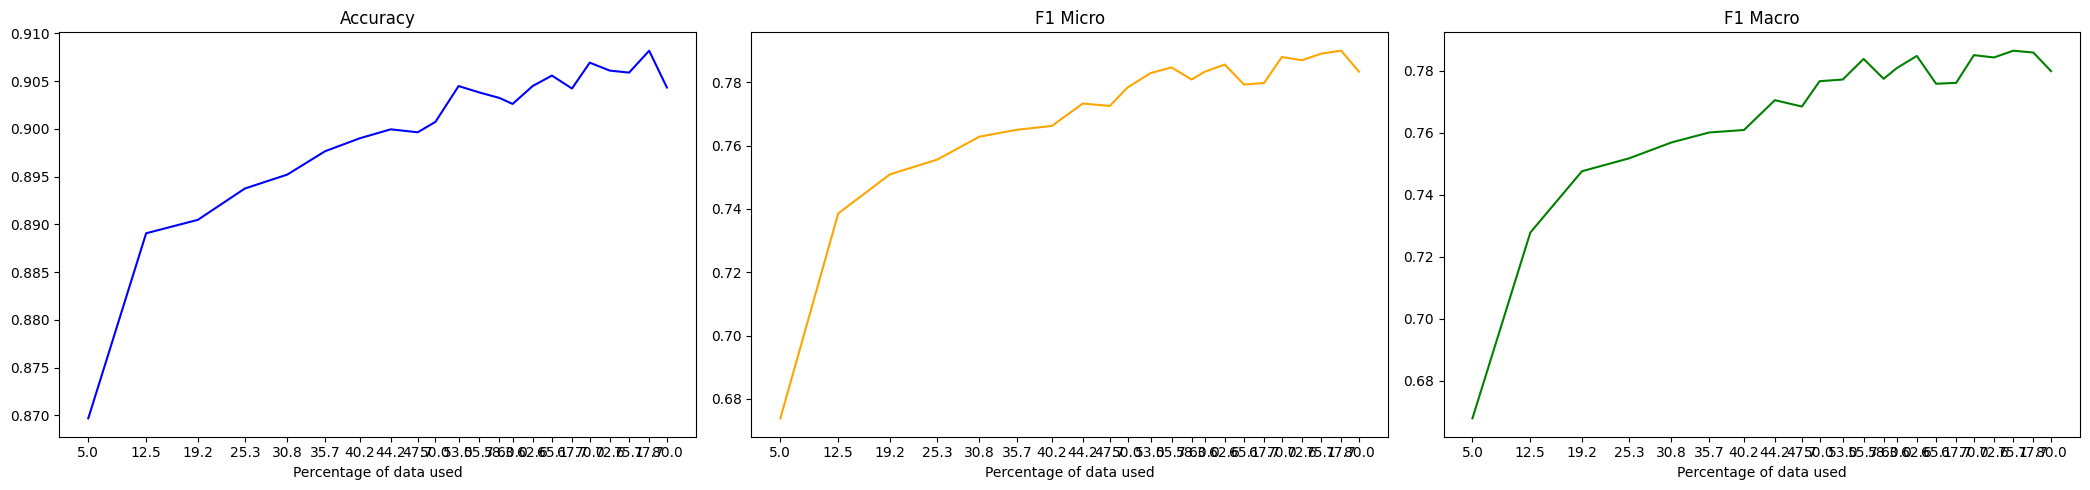

In [18]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: [81, 90, 11]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6045, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4429, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3839, Accuracy: 0.8116, F1 Micro: 0.2087, F1 Macro: 0.1506
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3762, Accuracy: 0.8338, F1 Micro: 0.4095, F1 Macro: 0.342
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3143, Accuracy: 0.8447, F1 Micro: 0.4918, F1 Macro: 0.4438
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2621, Accuracy: 0.8547, F1 Micro: 0.565, F1 Macro: 0.5446
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2351, Accuracy: 0.8594, F1 Micro: 0.6053, F1 Macro: 0.5977
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1834, Accuracy: 0.8698, F1 Micro: 0.6445, F1 Macro: 0.6379
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1462, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5934, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.439, Accuracy: 0.7909, F1 Micro: 0.0388, F1 Macro: 0.034
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3734, Accuracy: 0.8158, F1 Micro: 0.2398, F1 Macro: 0.1687
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3544, Accuracy: 0.8344, F1 Micro: 0.4137, F1 Macro: 0.3332
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2904, Accuracy: 0.8481, F1 Micro: 0.5272, F1 Macro: 0.4925
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2499, Accuracy: 0.8531, F1 Micro: 0.5595, F1 Macro: 0.547
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2281, Accuracy: 0.8608, F1 Micro: 0.607, F1 Macro: 0.5951
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1774, Accuracy: 0.8648, F1 Micro: 0.6211, F1 Macro: 0.6062
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1432, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6052, Accuracy: 0.788, F1 Micro: 0.0117, F1 Macro: 0.0106
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4376, Accuracy: 0.7931, F1 Micro: 0.0583, F1 Macro: 0.0499
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3737, Accuracy: 0.8203, F1 Micro: 0.274, F1 Macro: 0.1872
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3629, Accuracy: 0.8316, F1 Micro: 0.3896, F1 Macro: 0.2908
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3015, Accuracy: 0.842, F1 Micro: 0.4648, F1 Macro: 0.4003
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2601, Accuracy: 0.8594, F1 Micro: 0.5917, F1 Macro: 0.565
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2378, Accuracy: 0.8631, F1 Micro: 0.6158, F1 Macro: 0.6041
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1836, Accuracy: 0.8686, F1 Micro: 0.6453, F1 Macro: 0.6355
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.545, Accuracy: 0.8119, F1 Micro: 0.212, F1 Macro: 0.1606
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3964, Accuracy: 0.8409, F1 Micro: 0.4437, F1 Macro: 0.372
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3154, Accuracy: 0.8705, F1 Micro: 0.6444, F1 Macro: 0.6281
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2403, Accuracy: 0.8795, F1 Micro: 0.7029, F1 Macro: 0.6916
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2079, Accuracy: 0.8861, F1 Micro: 0.7173, F1 Macro: 0.7144
Epoch 6/10, Train Loss: 0.1529, Accuracy: 0.8869, F1 Micro: 0.7159, F1 Macro: 0.715
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1276, Accuracy: 0.8877, F1 Micro: 0.7369, F1 Macro: 0.7348
Epoch 8/10, Train Loss: 0.0925, Accuracy: 0.8884, F1 Micro: 0.7003, F1 Macro: 0.6921
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0883, Accuracy: 0.8909, F1 Micro: 0.7409, F1 Macro: 0.7336
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.548, Accuracy: 0.8136, F1 Micro: 0.2268, F1 Macro: 0.1701
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3866, Accuracy: 0.8464, F1 Micro: 0.4878, F1 Macro: 0.4214
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.304, Accuracy: 0.8683, F1 Micro: 0.6445, F1 Macro: 0.637
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2402, Accuracy: 0.8739, F1 Micro: 0.6851, F1 Macro: 0.6727
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2118, Accuracy: 0.8819, F1 Micro: 0.7115, F1 Macro: 0.7065
Epoch 6/10, Train Loss: 0.1515, Accuracy: 0.8838, F1 Micro: 0.705, F1 Macro: 0.7047
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1412, Accuracy: 0.8856, F1 Micro: 0.7325, F1 Macro: 0.7305
Epoch 8/10, Train Loss: 0.0921, Accuracy: 0.8872, F1 Micro: 0.7151, F1 Macro: 0.7117
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0845, Accuracy: 0.8884, F1 Micro: 0.7488, F1 Macro: 0.7445
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5456, Accuracy: 0.8188, F1 Micro: 0.2621, F1 Macro: 0.1911
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.388, Accuracy: 0.8403, F1 Micro: 0.4347, F1 Macro: 0.3646
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3131, Accuracy: 0.8711, F1 Micro: 0.6479, F1 Macro: 0.6344
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2441, Accuracy: 0.8797, F1 Micro: 0.7013, F1 Macro: 0.6898
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2107, Accuracy: 0.8869, F1 Micro: 0.7207, F1 Macro: 0.7125
Epoch 6/10, Train Loss: 0.1594, Accuracy: 0.8859, F1 Micro: 0.6976, F1 Macro: 0.6921
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1409, Accuracy: 0.8858, F1 Micro: 0.7394, F1 Macro: 0.7376
Epoch 8/10, Train Loss: 0.0949, Accuracy: 0.8866, F1 Micro: 0.7027, F1 Macro: 0.6959
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0888, Accuracy: 0.8898, F1 Micro: 0.7461, F1 Macro: 0.7371
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4991, Accuracy: 0.8331, F1 Micro: 0.3946, F1 Macro: 0.3022
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3492, Accuracy: 0.8705, F1 Micro: 0.6471, F1 Macro: 0.5992
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2751, Accuracy: 0.8808, F1 Micro: 0.691, F1 Macro: 0.6733
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2112, Accuracy: 0.8898, F1 Micro: 0.7181, F1 Macro: 0.7039
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.175, Accuracy: 0.8914, F1 Micro: 0.7531, F1 Macro: 0.7497
Epoch 6/10, Train Loss: 0.1402, Accuracy: 0.8945, F1 Micro: 0.7454, F1 Macro: 0.736
Epoch 7/10, Train Loss: 0.0997, Accuracy: 0.8922, F1 Micro: 0.7253, F1 Macro: 0.7171
Epoch 8/10, Train Loss: 0.0824, Accuracy: 0.8934, F1 Micro: 0.7525, F1 Macro: 0.7459
Epoch 9/10, Train Loss: 0.0609, Accuracy: 0.8948, F1 Micro: 0.7409, F1 Macro: 0.7271
Epoch 10/10, Train Loss: 0.0549, Accuracy: 0.8958, F1 Micro: 0.7463, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5018, Accuracy: 0.8331, F1 Micro: 0.3883, F1 Macro: 0.2735
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3419, Accuracy: 0.8706, F1 Micro: 0.6669, F1 Macro: 0.6454
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2742, Accuracy: 0.8784, F1 Micro: 0.7026, F1 Macro: 0.6884
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2178, Accuracy: 0.8867, F1 Micro: 0.7094, F1 Macro: 0.6943
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1873, Accuracy: 0.8911, F1 Micro: 0.7335, F1 Macro: 0.7278
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1503, Accuracy: 0.8909, F1 Micro: 0.7509, F1 Macro: 0.7472
Epoch 7/10, Train Loss: 0.1071, Accuracy: 0.8925, F1 Micro: 0.7417, F1 Macro: 0.7357
Epoch 8/10, Train Loss: 0.0921, Accuracy: 0.8939, F1 Micro: 0.7488, F1 Macro: 0.7419
Epoch 9/10, Train Loss: 0.0614, Accuracy: 0.8914, F1 Micro: 0.7433, F1 Macro: 0.7361
Epoch 10/10, Train Loss: 0.0567, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4986, Accuracy: 0.8381, F1 Micro: 0.443, F1 Macro: 0.3462
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3432, Accuracy: 0.8756, F1 Micro: 0.6566, F1 Macro: 0.6056
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2719, Accuracy: 0.8825, F1 Micro: 0.6946, F1 Macro: 0.6748
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2135, Accuracy: 0.8895, F1 Micro: 0.7248, F1 Macro: 0.7071
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1777, Accuracy: 0.8884, F1 Micro: 0.7538, F1 Macro: 0.7484
Epoch 6/10, Train Loss: 0.1428, Accuracy: 0.8934, F1 Micro: 0.7502, F1 Macro: 0.7406
Epoch 7/10, Train Loss: 0.0987, Accuracy: 0.892, F1 Micro: 0.7351, F1 Macro: 0.726
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0822, Accuracy: 0.8933, F1 Micro: 0.7548, F1 Macro: 0.7487
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0554, Accuracy: 0.8988, F1 Micro: 0.7553, F1 Macro: 0.7428
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4786, Accuracy: 0.8491, F1 Micro: 0.5096, F1 Macro: 0.4389
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3219, Accuracy: 0.8817, F1 Micro: 0.7121, F1 Macro: 0.7063
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2531, Accuracy: 0.8906, F1 Micro: 0.7346, F1 Macro: 0.7328
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1919, Accuracy: 0.8963, F1 Micro: 0.7622, F1 Macro: 0.7581
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1546, Accuracy: 0.8922, F1 Micro: 0.7643, F1 Macro: 0.7616
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1267, Accuracy: 0.8977, F1 Micro: 0.7678, F1 Macro: 0.7664
Epoch 7/10, Train Loss: 0.0981, Accuracy: 0.8948, F1 Micro: 0.7578, F1 Macro: 0.7524
Epoch 8/10, Train Loss: 0.0698, Accuracy: 0.8992, F1 Micro: 0.7576, F1 Macro: 0.7453
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0569, Accuracy: 0.9033, F1 Micro: 0.7723, F1 Macro: 0.7669
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4756, Accuracy: 0.8505, F1 Micro: 0.5436, F1 Macro: 0.4804
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3158, Accuracy: 0.8758, F1 Micro: 0.691, F1 Macro: 0.6839
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.256, Accuracy: 0.8869, F1 Micro: 0.7358, F1 Macro: 0.735
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1986, Accuracy: 0.8908, F1 Micro: 0.7543, F1 Macro: 0.7515
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1635, Accuracy: 0.8908, F1 Micro: 0.7638, F1 Macro: 0.7596
Epoch 6/10, Train Loss: 0.1267, Accuracy: 0.8883, F1 Micro: 0.7575, F1 Macro: 0.756
Epoch 7/10, Train Loss: 0.105, Accuracy: 0.8944, F1 Micro: 0.7496, F1 Macro: 0.7384
Epoch 8/10, Train Loss: 0.0761, Accuracy: 0.8913, F1 Micro: 0.7281, F1 Macro: 0.7072
Epoch 9/10, Train Loss: 0.0595, Accuracy: 0.8931, F1 Micro: 0.7555, F1 Macro: 0.7506
Epoch 10/10, Train Loss: 0.042, Accuracy: 0.8967, F1 Micro: 0.7562, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4759, Accuracy: 0.8469, F1 Micro: 0.482, F1 Macro: 0.4066
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3201, Accuracy: 0.8802, F1 Micro: 0.7091, F1 Macro: 0.694
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2545, Accuracy: 0.892, F1 Micro: 0.7432, F1 Macro: 0.7419
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1927, Accuracy: 0.8903, F1 Micro: 0.7622, F1 Macro: 0.7599
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1545, Accuracy: 0.89, F1 Micro: 0.7644, F1 Macro: 0.7633
Epoch 6/10, Train Loss: 0.1213, Accuracy: 0.8984, F1 Micro: 0.7609, F1 Macro: 0.7584
Epoch 7/10, Train Loss: 0.0946, Accuracy: 0.8953, F1 Micro: 0.7261, F1 Macro: 0.7118
Epoch 8/10, Train Loss: 0.0715, Accuracy: 0.8956, F1 Micro: 0.7621, F1 Macro: 0.7577
Epoch 9/10, Train Loss: 0.0595, Accuracy: 0.8978, F1 Micro: 0.7611, F1 Macro: 0.7591
Epoch 10/10, Train Loss: 0.0435, Accuracy: 0.8964, F1 Micro: 0.7536, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4609, Accuracy: 0.8648, F1 Micro: 0.6342, F1 Macro: 0.559
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2999, Accuracy: 0.8817, F1 Micro: 0.6916, F1 Macro: 0.6787
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2472, Accuracy: 0.8933, F1 Micro: 0.7273, F1 Macro: 0.7113
Epoch 4/10, Train Loss: 0.1925, Accuracy: 0.8952, F1 Micro: 0.7258, F1 Macro: 0.7111
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1588, Accuracy: 0.8986, F1 Micro: 0.7533, F1 Macro: 0.7468
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.12, Accuracy: 0.9014, F1 Micro: 0.7739, F1 Macro: 0.7694
Epoch 7/10, Train Loss: 0.0935, Accuracy: 0.9019, F1 Micro: 0.7655, F1 Macro: 0.7642
Epoch 8/10, Train Loss: 0.0724, Accuracy: 0.9014, F1 Micro: 0.7603, F1 Macro: 0.7506
Epoch 9/10, Train Loss: 0.0518, Accuracy: 0.8998, F1 Micro: 0.7604, F1 Macro: 0.7559
Epoch 10/10, Train Loss: 0.0438, Accuracy: 0.9013, F1 Micro: 0.7685, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4583, Accuracy: 0.8655, F1 Micro: 0.6303, F1 Macro: 0.6004
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2905, Accuracy: 0.8816, F1 Micro: 0.7133, F1 Macro: 0.7059
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2457, Accuracy: 0.8909, F1 Micro: 0.7356, F1 Macro: 0.726
Epoch 4/10, Train Loss: 0.1962, Accuracy: 0.8923, F1 Micro: 0.7142, F1 Macro: 0.697
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1624, Accuracy: 0.8978, F1 Micro: 0.7558, F1 Macro: 0.7477
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1218, Accuracy: 0.898, F1 Micro: 0.7579, F1 Macro: 0.7513
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0923, Accuracy: 0.8997, F1 Micro: 0.7588, F1 Macro: 0.754
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0736, Accuracy: 0.8995, F1 Micro: 0.7659, F1 Macro: 0.7587
Epoch 9/10, Train Loss: 0.0503, Accuracy: 0.9005, F1 Micro: 0.7549, F1 Macro: 0.7487
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4592, Accuracy: 0.8625, F1 Micro: 0.6011, F1 Macro: 0.5121
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2955, Accuracy: 0.882, F1 Micro: 0.7137, F1 Macro: 0.7026
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2488, Accuracy: 0.8938, F1 Micro: 0.7461, F1 Macro: 0.7372
Epoch 4/10, Train Loss: 0.1974, Accuracy: 0.893, F1 Micro: 0.7185, F1 Macro: 0.7019
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.159, Accuracy: 0.9005, F1 Micro: 0.7686, F1 Macro: 0.7651
Epoch 6/10, Train Loss: 0.1178, Accuracy: 0.8997, F1 Micro: 0.7601, F1 Macro: 0.7512
Epoch 7/10, Train Loss: 0.0951, Accuracy: 0.8978, F1 Micro: 0.7498, F1 Macro: 0.7432
Epoch 8/10, Train Loss: 0.0668, Accuracy: 0.9011, F1 Micro: 0.7675, F1 Macro: 0.7628
Epoch 9/10, Train Loss: 0.0474, Accuracy: 0.8984, F1 Micro: 0.7461, F1 Macro: 0.7415
Epoch 10/10, Train Loss: 0.0431, Accuracy: 0.9008, F1 Micro: 0.7628, F1 Macro: 0.7573
Model 3 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4483, Accuracy: 0.8614, F1 Micro: 0.5842, F1 Macro: 0.5208
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2849, Accuracy: 0.8898, F1 Micro: 0.7279, F1 Macro: 0.7262
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2243, Accuracy: 0.8948, F1 Micro: 0.7682, F1 Macro: 0.7662
Epoch 4/10, Train Loss: 0.1839, Accuracy: 0.9014, F1 Micro: 0.7523, F1 Macro: 0.7448
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1499, Accuracy: 0.9045, F1 Micro: 0.7759, F1 Macro: 0.7727
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1129, Accuracy: 0.9039, F1 Micro: 0.7777, F1 Macro: 0.7743
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0872, Accuracy: 0.9016, F1 Micro: 0.778, F1 Macro: 0.7688
Epoch 8/10, Train Loss: 0.071, Accuracy: 0.9048, F1 Micro: 0.7675, F1 Macro: 0.7525
Epoch 9/10, Train Loss: 0.0472, Accuracy: 0.9027, F1 Micro: 0.7668, F1 Macro: 0.7547
Epoch 10/10, Train Loss: 0.0377, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4397, Accuracy: 0.8677, F1 Micro: 0.6247, F1 Macro: 0.5913
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.283, Accuracy: 0.8872, F1 Micro: 0.7296, F1 Macro: 0.7265
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2246, Accuracy: 0.9011, F1 Micro: 0.7743, F1 Macro: 0.7698
Epoch 4/10, Train Loss: 0.1842, Accuracy: 0.9033, F1 Micro: 0.7667, F1 Macro: 0.7605
Epoch 5/10, Train Loss: 0.1472, Accuracy: 0.9013, F1 Micro: 0.7593, F1 Macro: 0.7545
Epoch 6/10, Train Loss: 0.1083, Accuracy: 0.903, F1 Micro: 0.7652, F1 Macro: 0.7553
Epoch 7/10, Train Loss: 0.0858, Accuracy: 0.8986, F1 Micro: 0.7666, F1 Macro: 0.7568
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0672, Accuracy: 0.9008, F1 Micro: 0.7788, F1 Macro: 0.7747
Epoch 9/10, Train Loss: 0.0496, Accuracy: 0.9013, F1 Micro: 0.7767, F1 Macro: 0.772
Epoch 10/10, Train Loss: 0.0386, Accuracy: 0.8973, F1 Micro: 0.7617, F1 Macro: 0.7552
Model 2 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4484, Accuracy: 0.8627, F1 Micro: 0.5864, F1 Macro: 0.5248
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2877, Accuracy: 0.8889, F1 Micro: 0.7332, F1 Macro: 0.7322
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2272, Accuracy: 0.8939, F1 Micro: 0.7685, F1 Macro: 0.7653
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.189, Accuracy: 0.9005, F1 Micro: 0.7698, F1 Macro: 0.7642
Epoch 5/10, Train Loss: 0.1501, Accuracy: 0.8981, F1 Micro: 0.7603, F1 Macro: 0.7578
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1117, Accuracy: 0.903, F1 Micro: 0.7743, F1 Macro: 0.7666
Epoch 7/10, Train Loss: 0.0864, Accuracy: 0.8973, F1 Micro: 0.7437, F1 Macro: 0.7255
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0706, Accuracy: 0.9044, F1 Micro: 0.7755, F1 Macro: 0.7685
Epoch 9/10, Train Loss: 0.0475, Accuracy: 0.9028, F1 Micro: 0.7688, F1 Macro: 0.7619
Epoch 10/10, Train Loss: 0.0359, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.432, Accuracy: 0.8737, F1 Micro: 0.6535, F1 Macro: 0.6478
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2828, Accuracy: 0.8941, F1 Micro: 0.7509, F1 Macro: 0.7434
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2245, Accuracy: 0.8972, F1 Micro: 0.7648, F1 Macro: 0.7659
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.18, Accuracy: 0.9016, F1 Micro: 0.7793, F1 Macro: 0.7701
Epoch 5/10, Train Loss: 0.1497, Accuracy: 0.9009, F1 Micro: 0.756, F1 Macro: 0.7434
Epoch 6/10, Train Loss: 0.1046, Accuracy: 0.9016, F1 Micro: 0.7719, F1 Macro: 0.7633
Epoch 7/10, Train Loss: 0.0787, Accuracy: 0.9013, F1 Micro: 0.7756, F1 Macro: 0.7711
Epoch 8/10, Train Loss: 0.0616, Accuracy: 0.9028, F1 Micro: 0.7759, F1 Macro: 0.7703
Epoch 9/10, Train Loss: 0.0505, Accuracy: 0.9025, F1 Micro: 0.7711, F1 Macro: 0.7711
Epoch 10/10, Train Loss: 0.036, Accuracy: 0.9017, F1 Micro: 0.765, F1 Macro: 0.7588
Model 1 - Iteration 312

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4313, Accuracy: 0.8683, F1 Micro: 0.6355, F1 Macro: 0.6323
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2835, Accuracy: 0.8909, F1 Micro: 0.7542, F1 Macro: 0.748
Epoch 3/10, Train Loss: 0.2285, Accuracy: 0.8964, F1 Micro: 0.7534, F1 Macro: 0.7522
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1848, Accuracy: 0.9016, F1 Micro: 0.7772, F1 Macro: 0.7699
Epoch 5/10, Train Loss: 0.1499, Accuracy: 0.8978, F1 Micro: 0.751, F1 Macro: 0.7383
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1114, Accuracy: 0.9028, F1 Micro: 0.7808, F1 Macro: 0.7763
Epoch 7/10, Train Loss: 0.0806, Accuracy: 0.903, F1 Micro: 0.7792, F1 Macro: 0.779
Epoch 8/10, Train Loss: 0.0681, Accuracy: 0.9017, F1 Micro: 0.7687, F1 Macro: 0.7609
Epoch 9/10, Train Loss: 0.0504, Accuracy: 0.9027, F1 Micro: 0.7763, F1 Macro: 0.7759
Epoch 10/10, Train Loss: 0.0357, Accuracy: 0.9055, F1 Micro: 0.7781, F1 Macro: 0.771
Model 2 - Iteration 31

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4373, Accuracy: 0.8736, F1 Micro: 0.6556, F1 Macro: 0.6476
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2825, Accuracy: 0.8919, F1 Micro: 0.7521, F1 Macro: 0.744
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2285, Accuracy: 0.8975, F1 Micro: 0.753, F1 Macro: 0.7515
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1842, Accuracy: 0.9027, F1 Micro: 0.775, F1 Macro: 0.7638
Epoch 5/10, Train Loss: 0.1491, Accuracy: 0.9009, F1 Micro: 0.7554, F1 Macro: 0.7488
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1048, Accuracy: 0.9016, F1 Micro: 0.7785, F1 Macro: 0.7726
Epoch 7/10, Train Loss: 0.08, Accuracy: 0.9033, F1 Micro: 0.7717, F1 Macro: 0.7679
Epoch 8/10, Train Loss: 0.0614, Accuracy: 0.9028, F1 Micro: 0.7693, F1 Macro: 0.7619
Epoch 9/10, Train Loss: 0.0501, Accuracy: 0.9022, F1 Micro: 0.765, F1 Macro: 0.7624
Epoch 10/10, Train Loss: 0.0369, Accuracy: 0.9017, F1 Micro: 0.7767, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4277, Accuracy: 0.8781, F1 Micro: 0.6742, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2823, Accuracy: 0.8958, F1 Micro: 0.7518, F1 Macro: 0.7459
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2178, Accuracy: 0.9008, F1 Micro: 0.7652, F1 Macro: 0.765
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1818, Accuracy: 0.9041, F1 Micro: 0.7706, F1 Macro: 0.7658
Epoch 5/10, Train Loss: 0.1346, Accuracy: 0.9045, F1 Micro: 0.7665, F1 Macro: 0.7598
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1014, Accuracy: 0.9086, F1 Micro: 0.7808, F1 Macro: 0.7713
Epoch 7/10, Train Loss: 0.0766, Accuracy: 0.9055, F1 Micro: 0.7777, F1 Macro: 0.7687
Epoch 8/10, Train Loss: 0.057, Accuracy: 0.9036, F1 Micro: 0.7685, F1 Macro: 0.7598
Epoch 9/10, Train Loss: 0.044, Accuracy: 0.9067, F1 Micro: 0.7691, F1 Macro: 0.7545
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0324, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4243, Accuracy: 0.8733, F1 Micro: 0.6611, F1 Macro: 0.6349
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2887, Accuracy: 0.8927, F1 Micro: 0.7565, F1 Macro: 0.7522
Epoch 3/10, Train Loss: 0.2218, Accuracy: 0.8988, F1 Micro: 0.7562, F1 Macro: 0.7549
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1884, Accuracy: 0.9008, F1 Micro: 0.7615, F1 Macro: 0.7551
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1389, Accuracy: 0.9038, F1 Micro: 0.7703, F1 Macro: 0.7635
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1033, Accuracy: 0.9047, F1 Micro: 0.7756, F1 Macro: 0.7641
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0794, Accuracy: 0.9045, F1 Micro: 0.7797, F1 Macro: 0.7728
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0591, Accuracy: 0.9047, F1 Micro: 0.7804, F1 Macro: 0.7764
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0474, Accuracy: 0.9047, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4318, Accuracy: 0.8748, F1 Micro: 0.6639, F1 Macro: 0.6084
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2882, Accuracy: 0.8955, F1 Micro: 0.7623, F1 Macro: 0.7555
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.222, Accuracy: 0.8989, F1 Micro: 0.7627, F1 Macro: 0.7634
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1916, Accuracy: 0.902, F1 Micro: 0.7665, F1 Macro: 0.7618
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.147, Accuracy: 0.905, F1 Micro: 0.7766, F1 Macro: 0.7718
Epoch 6/10, Train Loss: 0.1048, Accuracy: 0.9045, F1 Micro: 0.7736, F1 Macro: 0.7636
Epoch 7/10, Train Loss: 0.0866, Accuracy: 0.9025, F1 Micro: 0.762, F1 Macro: 0.7553
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0633, Accuracy: 0.9061, F1 Micro: 0.7814, F1 Macro: 0.7793
Epoch 9/10, Train Loss: 0.0436, Accuracy: 0.9052, F1 Micro: 0.7615, F1 Macro: 0.7512
Epoch 10/10, Train Loss: 0.0332, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4201, Accuracy: 0.8783, F1 Micro: 0.7053, F1 Macro: 0.6949
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2683, Accuracy: 0.8947, F1 Micro: 0.7643, F1 Macro: 0.7586
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.219, Accuracy: 0.9009, F1 Micro: 0.776, F1 Macro: 0.771
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1793, Accuracy: 0.9009, F1 Micro: 0.7797, F1 Macro: 0.7758
Epoch 5/10, Train Loss: 0.1402, Accuracy: 0.9008, F1 Micro: 0.7555, F1 Macro: 0.7412
Epoch 6/10, Train Loss: 0.1083, Accuracy: 0.9045, F1 Micro: 0.7719, F1 Macro: 0.762
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0779, Accuracy: 0.9084, F1 Micro: 0.7909, F1 Macro: 0.7883
Epoch 8/10, Train Loss: 0.0604, Accuracy: 0.9041, F1 Micro: 0.7852, F1 Macro: 0.785
Epoch 9/10, Train Loss: 0.0449, Accuracy: 0.9017, F1 Micro: 0.7806, F1 Macro: 0.78
Epoch 10/10, Train Loss: 0.0353, Accuracy: 0.9017, F1 Micro: 0.7762, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4138, Accuracy: 0.8727, F1 Micro: 0.6852, F1 Macro: 0.6762
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2649, Accuracy: 0.8963, F1 Micro: 0.7664, F1 Macro: 0.761
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2184, Accuracy: 0.8981, F1 Micro: 0.7733, F1 Macro: 0.7694
Epoch 4/10, Train Loss: 0.1831, Accuracy: 0.9008, F1 Micro: 0.7708, F1 Macro: 0.7644
Epoch 5/10, Train Loss: 0.1446, Accuracy: 0.897, F1 Micro: 0.7488, F1 Macro: 0.7343
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1084, Accuracy: 0.9041, F1 Micro: 0.7736, F1 Macro: 0.7634
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0806, Accuracy: 0.9009, F1 Micro: 0.7772, F1 Macro: 0.7724
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0582, Accuracy: 0.9042, F1 Micro: 0.7773, F1 Macro: 0.7732
Epoch 9/10, Train Loss: 0.047, Accuracy: 0.9053, F1 Micro: 0.7769, F1 Macro: 0.7694
Epoch 10/10, Train Loss: 0.0375, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4211, Accuracy: 0.8806, F1 Micro: 0.7097, F1 Macro: 0.6996
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2675, Accuracy: 0.8945, F1 Micro: 0.7651, F1 Macro: 0.7576
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2198, Accuracy: 0.8997, F1 Micro: 0.7741, F1 Macro: 0.7676
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.182, Accuracy: 0.9027, F1 Micro: 0.7761, F1 Macro: 0.7714
Epoch 5/10, Train Loss: 0.1446, Accuracy: 0.8995, F1 Micro: 0.7501, F1 Macro: 0.7346
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1074, Accuracy: 0.9064, F1 Micro: 0.7767, F1 Macro: 0.7712
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0769, Accuracy: 0.9106, F1 Micro: 0.7918, F1 Macro: 0.7892
Epoch 8/10, Train Loss: 0.056, Accuracy: 0.9066, F1 Micro: 0.7801, F1 Macro: 0.7798
Epoch 9/10, Train Loss: 0.0397, Accuracy: 0.905, F1 Micro: 0.7721, F1 Macro: 0.7666
Epoch 10/10, Train Loss: 0.0342, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.418, Accuracy: 0.8659, F1 Micro: 0.5941, F1 Macro: 0.5598
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2741, Accuracy: 0.8955, F1 Micro: 0.7625, F1 Macro: 0.7604
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2173, Accuracy: 0.902, F1 Micro: 0.7697, F1 Macro: 0.766
Epoch 4/10, Train Loss: 0.1787, Accuracy: 0.9017, F1 Micro: 0.7647, F1 Macro: 0.7472
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1351, Accuracy: 0.9028, F1 Micro: 0.7796, F1 Macro: 0.7751
Epoch 6/10, Train Loss: 0.1096, Accuracy: 0.9011, F1 Micro: 0.7532, F1 Macro: 0.748
Epoch 7/10, Train Loss: 0.0771, Accuracy: 0.9047, F1 Micro: 0.7783, F1 Macro: 0.769
Epoch 8/10, Train Loss: 0.059, Accuracy: 0.907, F1 Micro: 0.7787, F1 Macro: 0.7744
Epoch 9/10, Train Loss: 0.0439, Accuracy: 0.9039, F1 Micro: 0.7735, F1 Macro: 0.7721
Epoch 10/10, Train Loss: 0.0309, Accuracy: 0.9033, F1 Micro: 0.7696, F1 Macro: 0.7628
Model 1 - Iteration 3886

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.416, Accuracy: 0.868, F1 Micro: 0.6216, F1 Macro: 0.5961
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2713, Accuracy: 0.8913, F1 Micro: 0.7608, F1 Macro: 0.76
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2204, Accuracy: 0.9006, F1 Micro: 0.763, F1 Macro: 0.7596
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1814, Accuracy: 0.9022, F1 Micro: 0.7659, F1 Macro: 0.747
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1429, Accuracy: 0.9022, F1 Micro: 0.7819, F1 Macro: 0.7779
Epoch 6/10, Train Loss: 0.1114, Accuracy: 0.9006, F1 Micro: 0.751, F1 Macro: 0.7421
Epoch 7/10, Train Loss: 0.0827, Accuracy: 0.9031, F1 Micro: 0.7792, F1 Macro: 0.7749
Epoch 8/10, Train Loss: 0.0607, Accuracy: 0.9028, F1 Micro: 0.7593, F1 Macro: 0.7498
Epoch 9/10, Train Loss: 0.0447, Accuracy: 0.905, F1 Micro: 0.7758, F1 Macro: 0.7734
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.034, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4214, Accuracy: 0.8691, F1 Micro: 0.6069, F1 Macro: 0.5579
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2716, Accuracy: 0.8917, F1 Micro: 0.7616, F1 Macro: 0.7592
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2185, Accuracy: 0.9022, F1 Micro: 0.77, F1 Macro: 0.7705
Epoch 4/10, Train Loss: 0.1809, Accuracy: 0.8997, F1 Micro: 0.7583, F1 Macro: 0.7379
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1356, Accuracy: 0.9013, F1 Micro: 0.783, F1 Macro: 0.7819
Epoch 6/10, Train Loss: 0.113, Accuracy: 0.9053, F1 Micro: 0.7769, F1 Macro: 0.7783
Epoch 7/10, Train Loss: 0.0758, Accuracy: 0.9061, F1 Micro: 0.7783, F1 Macro: 0.7705
Epoch 8/10, Train Loss: 0.0586, Accuracy: 0.9042, F1 Micro: 0.773, F1 Macro: 0.772
Epoch 9/10, Train Loss: 0.0442, Accuracy: 0.9047, F1 Micro: 0.7803, F1 Macro: 0.7801
Epoch 10/10, Train Loss: 0.0365, Accuracy: 0.9023, F1 Micro: 0.758, F1 Macro: 0.7501
Model 3 - Iteration 3886

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3974, Accuracy: 0.882, F1 Micro: 0.7106, F1 Macro: 0.7018
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2647, Accuracy: 0.8991, F1 Micro: 0.7704, F1 Macro: 0.7655
Epoch 3/10, Train Loss: 0.2084, Accuracy: 0.9023, F1 Micro: 0.7669, F1 Macro: 0.7544
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.167, Accuracy: 0.8989, F1 Micro: 0.778, F1 Macro: 0.7746
Epoch 5/10, Train Loss: 0.1306, Accuracy: 0.8995, F1 Micro: 0.7541, F1 Macro: 0.747
Epoch 6/10, Train Loss: 0.0983, Accuracy: 0.9059, F1 Micro: 0.7659, F1 Macro: 0.7562
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0712, Accuracy: 0.907, F1 Micro: 0.784, F1 Macro: 0.7801
Epoch 8/10, Train Loss: 0.0515, Accuracy: 0.9027, F1 Micro: 0.7816, F1 Macro: 0.7797
Epoch 9/10, Train Loss: 0.0395, Accuracy: 0.9058, F1 Micro: 0.7827, F1 Macro: 0.7781
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0326, Accuracy: 0.9034, F1 Micro: 0.7842, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3933, Accuracy: 0.8777, F1 Micro: 0.7086, F1 Macro: 0.7001
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2639, Accuracy: 0.8975, F1 Micro: 0.7675, F1 Macro: 0.76
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2084, Accuracy: 0.902, F1 Micro: 0.7732, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1694, Accuracy: 0.8983, F1 Micro: 0.7748, F1 Macro: 0.7705
Epoch 5/10, Train Loss: 0.133, Accuracy: 0.8997, F1 Micro: 0.7626, F1 Macro: 0.7569
Epoch 6/10, Train Loss: 0.0968, Accuracy: 0.902, F1 Micro: 0.7654, F1 Macro: 0.7598
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0732, Accuracy: 0.9056, F1 Micro: 0.7807, F1 Macro: 0.7774
Epoch 8/10, Train Loss: 0.0549, Accuracy: 0.9014, F1 Micro: 0.7776, F1 Macro: 0.7758
Epoch 9/10, Train Loss: 0.0433, Accuracy: 0.905, F1 Micro: 0.7771, F1 Macro: 0.7743
Epoch 10/10, Train Loss: 0.0338, Accuracy: 0.9039, F1 Micro: 0.7738, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3973, Accuracy: 0.8798, F1 Micro: 0.7132, F1 Macro: 0.7023
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.266, Accuracy: 0.8989, F1 Micro: 0.7693, F1 Macro: 0.7645
Epoch 3/10, Train Loss: 0.2118, Accuracy: 0.9006, F1 Micro: 0.7658, F1 Macro: 0.748
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1711, Accuracy: 0.8984, F1 Micro: 0.7803, F1 Macro: 0.7814
Epoch 5/10, Train Loss: 0.1334, Accuracy: 0.902, F1 Micro: 0.7684, F1 Macro: 0.765
Epoch 6/10, Train Loss: 0.1003, Accuracy: 0.9064, F1 Micro: 0.7708, F1 Macro: 0.7638
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0753, Accuracy: 0.9067, F1 Micro: 0.7825, F1 Macro: 0.7818
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0557, Accuracy: 0.9036, F1 Micro: 0.7854, F1 Macro: 0.786
Epoch 9/10, Train Loss: 0.0408, Accuracy: 0.9059, F1 Micro: 0.7831, F1 Macro: 0.781
Epoch 10/10, Train Loss: 0.0343, Accuracy: 0.9061, F1 Micro: 0.7848, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4076, Accuracy: 0.883, F1 Micro: 0.7219, F1 Macro: 0.7209
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2611, Accuracy: 0.8981, F1 Micro: 0.7599, F1 Macro: 0.7531
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2176, Accuracy: 0.9041, F1 Micro: 0.7642, F1 Macro: 0.7537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1755, Accuracy: 0.9022, F1 Micro: 0.7811, F1 Macro: 0.7767
Epoch 5/10, Train Loss: 0.1319, Accuracy: 0.9059, F1 Micro: 0.7732, F1 Macro: 0.7637
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1007, Accuracy: 0.9062, F1 Micro: 0.7828, F1 Macro: 0.7751
Epoch 7/10, Train Loss: 0.0796, Accuracy: 0.9069, F1 Micro: 0.7807, F1 Macro: 0.7755
Epoch 8/10, Train Loss: 0.057, Accuracy: 0.9056, F1 Micro: 0.7807, F1 Macro: 0.7743
Epoch 9/10, Train Loss: 0.0412, Accuracy: 0.9033, F1 Micro: 0.7662, F1 Macro: 0.7562
Epoch 10/10, Train Loss: 0.0366, Accuracy: 0.9052, F1 Micro: 0.7763, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.403, Accuracy: 0.8797, F1 Micro: 0.707, F1 Macro: 0.7069
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2631, Accuracy: 0.8958, F1 Micro: 0.7579, F1 Macro: 0.755
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2192, Accuracy: 0.9025, F1 Micro: 0.7685, F1 Macro: 0.7587
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1795, Accuracy: 0.903, F1 Micro: 0.777, F1 Macro: 0.7702
Epoch 5/10, Train Loss: 0.1324, Accuracy: 0.9011, F1 Micro: 0.7721, F1 Macro: 0.7649
Epoch 6/10, Train Loss: 0.1014, Accuracy: 0.9038, F1 Micro: 0.772, F1 Macro: 0.7636
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0759, Accuracy: 0.9069, F1 Micro: 0.7791, F1 Macro: 0.7751
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0553, Accuracy: 0.9025, F1 Micro: 0.7795, F1 Macro: 0.7755
Epoch 9/10, Train Loss: 0.0407, Accuracy: 0.9006, F1 Micro: 0.7627, F1 Macro: 0.7558
Epoch 10/10, Train Loss: 0.0359, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4081, Accuracy: 0.8841, F1 Micro: 0.7229, F1 Macro: 0.7207
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.262, Accuracy: 0.8959, F1 Micro: 0.7627, F1 Macro: 0.7603
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2208, Accuracy: 0.9069, F1 Micro: 0.7768, F1 Macro: 0.7734
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1804, Accuracy: 0.9034, F1 Micro: 0.7824, F1 Macro: 0.7786
Epoch 5/10, Train Loss: 0.1372, Accuracy: 0.9047, F1 Micro: 0.765, F1 Macro: 0.7531
Epoch 6/10, Train Loss: 0.105, Accuracy: 0.9067, F1 Micro: 0.7808, F1 Macro: 0.7733
Epoch 7/10, Train Loss: 0.0753, Accuracy: 0.9053, F1 Micro: 0.7683, F1 Macro: 0.7634
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0571, Accuracy: 0.9033, F1 Micro: 0.7851, F1 Macro: 0.7844
Epoch 9/10, Train Loss: 0.0404, Accuracy: 0.9028, F1 Micro: 0.7628, F1 Macro: 0.7581
Epoch 10/10, Train Loss: 0.0336, Accuracy: 0.9022, F1 Micro: 0.7719, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4097, Accuracy: 0.8783, F1 Micro: 0.6658, F1 Macro: 0.6605
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2677, Accuracy: 0.8998, F1 Micro: 0.7598, F1 Macro: 0.7485
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2093, Accuracy: 0.9038, F1 Micro: 0.7771, F1 Macro: 0.7694
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1707, Accuracy: 0.9031, F1 Micro: 0.7866, F1 Macro: 0.7829
Epoch 5/10, Train Loss: 0.1289, Accuracy: 0.9069, F1 Micro: 0.7756, F1 Macro: 0.7697
Epoch 6/10, Train Loss: 0.1017, Accuracy: 0.9102, F1 Micro: 0.7829, F1 Macro: 0.7794
Epoch 7/10, Train Loss: 0.0688, Accuracy: 0.9067, F1 Micro: 0.7786, F1 Macro: 0.7752
Epoch 8/10, Train Loss: 0.0567, Accuracy: 0.9056, F1 Micro: 0.774, F1 Macro: 0.7686
Epoch 9/10, Train Loss: 0.0365, Accuracy: 0.9033, F1 Micro: 0.7787, F1 Macro: 0.7749
Epoch 10/10, Train Loss: 0.0309, Accuracy: 0.8997, F1 Micro: 0.7594, F1 Macro: 0.7469
Model 1 - Iteratio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4021, Accuracy: 0.8786, F1 Micro: 0.6806, F1 Macro: 0.6778
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2709, Accuracy: 0.8964, F1 Micro: 0.7574, F1 Macro: 0.7499
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2138, Accuracy: 0.9016, F1 Micro: 0.7763, F1 Macro: 0.772
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1747, Accuracy: 0.8975, F1 Micro: 0.7772, F1 Macro: 0.7758
Epoch 5/10, Train Loss: 0.1348, Accuracy: 0.9, F1 Micro: 0.7645, F1 Macro: 0.7602
Epoch 6/10, Train Loss: 0.1106, Accuracy: 0.898, F1 Micro: 0.7539, F1 Macro: 0.752
Epoch 7/10, Train Loss: 0.0737, Accuracy: 0.9023, F1 Micro: 0.7649, F1 Macro: 0.7573
Epoch 8/10, Train Loss: 0.0568, Accuracy: 0.9062, F1 Micro: 0.7761, F1 Macro: 0.7721
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0414, Accuracy: 0.9023, F1 Micro: 0.7832, F1 Macro: 0.7848
Epoch 10/10, Train Loss: 0.0368, Accuracy: 0.9041, F1 Micro: 0.7731, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4059, Accuracy: 0.8813, F1 Micro: 0.6903, F1 Macro: 0.6872
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2683, Accuracy: 0.8958, F1 Micro: 0.7567, F1 Macro: 0.7464
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2108, Accuracy: 0.9023, F1 Micro: 0.7736, F1 Macro: 0.7652
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1796, Accuracy: 0.9, F1 Micro: 0.7826, F1 Macro: 0.7817
Epoch 5/10, Train Loss: 0.1365, Accuracy: 0.9048, F1 Micro: 0.7732, F1 Macro: 0.7713
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1087, Accuracy: 0.9066, F1 Micro: 0.7843, F1 Macro: 0.7858
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0713, Accuracy: 0.9064, F1 Micro: 0.7861, F1 Macro: 0.7846
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0564, Accuracy: 0.9091, F1 Micro: 0.7903, F1 Macro: 0.7905
Epoch 9/10, Train Loss: 0.0366, Accuracy: 0.9044, F1 Micro: 0.7765, F1 Macro: 0.773
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4031, Accuracy: 0.8791, F1 Micro: 0.7318, F1 Macro: 0.7327
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2647, Accuracy: 0.8998, F1 Micro: 0.7747, F1 Macro: 0.7742
Epoch 3/10, Train Loss: 0.2161, Accuracy: 0.9039, F1 Micro: 0.7666, F1 Macro: 0.7637
Epoch 4/10, Train Loss: 0.1716, Accuracy: 0.905, F1 Micro: 0.7731, F1 Macro: 0.769
Epoch 5/10, Train Loss: 0.1319, Accuracy: 0.9067, F1 Micro: 0.7696, F1 Macro: 0.7596
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.101, Accuracy: 0.9036, F1 Micro: 0.7786, F1 Macro: 0.7745
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0716, Accuracy: 0.9027, F1 Micro: 0.7852, F1 Macro: 0.7899
Epoch 8/10, Train Loss: 0.0539, Accuracy: 0.9041, F1 Micro: 0.7744, F1 Macro: 0.7683
Epoch 9/10, Train Loss: 0.038, Accuracy: 0.9019, F1 Micro: 0.776, F1 Macro: 0.7741
Epoch 10/10, Train Loss: 0.0305, Accuracy: 0.9027, F1 Micro: 0.7838, F1 Macro: 0.7858
Model 1 - Iteration 46

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3944, Accuracy: 0.878, F1 Micro: 0.7194, F1 Macro: 0.7135
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2597, Accuracy: 0.8964, F1 Micro: 0.7694, F1 Macro: 0.7683
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2172, Accuracy: 0.9045, F1 Micro: 0.7729, F1 Macro: 0.7673
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1732, Accuracy: 0.9059, F1 Micro: 0.7784, F1 Macro: 0.7733
Epoch 5/10, Train Loss: 0.1334, Accuracy: 0.9066, F1 Micro: 0.7764, F1 Macro: 0.7674
Epoch 6/10, Train Loss: 0.0994, Accuracy: 0.9011, F1 Micro: 0.7751, F1 Macro: 0.7716
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0763, Accuracy: 0.9005, F1 Micro: 0.7813, F1 Macro: 0.7827
Epoch 8/10, Train Loss: 0.053, Accuracy: 0.9017, F1 Micro: 0.7756, F1 Macro: 0.7725
Epoch 9/10, Train Loss: 0.0392, Accuracy: 0.9042, F1 Micro: 0.7759, F1 Macro: 0.7688
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0303, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3961, Accuracy: 0.8792, F1 Micro: 0.7256, F1 Macro: 0.719
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2603, Accuracy: 0.9003, F1 Micro: 0.7777, F1 Macro: 0.7774
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2173, Accuracy: 0.9053, F1 Micro: 0.7796, F1 Macro: 0.7786
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.177, Accuracy: 0.9062, F1 Micro: 0.7799, F1 Macro: 0.7774
Epoch 5/10, Train Loss: 0.1346, Accuracy: 0.9069, F1 Micro: 0.7692, F1 Macro: 0.7575
Epoch 6/10, Train Loss: 0.099, Accuracy: 0.9033, F1 Micro: 0.7703, F1 Macro: 0.7641
Epoch 7/10, Train Loss: 0.0754, Accuracy: 0.9023, F1 Micro: 0.7792, F1 Macro: 0.7807
Epoch 8/10, Train Loss: 0.0542, Accuracy: 0.9031, F1 Micro: 0.7767, F1 Macro: 0.7745
Epoch 9/10, Train Loss: 0.0399, Accuracy: 0.9033, F1 Micro: 0.7745, F1 Macro: 0.7731
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0302, Accuracy: 0.9078, F1 Micro: 0.7858, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3932, Accuracy: 0.8869, F1 Micro: 0.7362, F1 Macro: 0.7281
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2625, Accuracy: 0.9006, F1 Micro: 0.7573, F1 Macro: 0.7372
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2128, Accuracy: 0.9038, F1 Micro: 0.77, F1 Macro: 0.7622
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1663, Accuracy: 0.9042, F1 Micro: 0.7856, F1 Macro: 0.7832
Epoch 5/10, Train Loss: 0.1297, Accuracy: 0.9055, F1 Micro: 0.773, F1 Macro: 0.7613
Epoch 6/10, Train Loss: 0.0919, Accuracy: 0.9042, F1 Micro: 0.7714, F1 Macro: 0.7637
Epoch 7/10, Train Loss: 0.0765, Accuracy: 0.9064, F1 Micro: 0.7848, F1 Macro: 0.7788
Epoch 8/10, Train Loss: 0.0552, Accuracy: 0.9061, F1 Micro: 0.7825, F1 Macro: 0.782
Epoch 9/10, Train Loss: 0.0414, Accuracy: 0.9045, F1 Micro: 0.7751, F1 Macro: 0.7717
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0331, Accuracy: 0.9069, F1 Micro: 0.7861, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3858, Accuracy: 0.8836, F1 Micro: 0.7327, F1 Macro: 0.7276
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2619, Accuracy: 0.8978, F1 Micro: 0.761, F1 Macro: 0.7477
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2147, Accuracy: 0.9042, F1 Micro: 0.773, F1 Macro: 0.7676
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1702, Accuracy: 0.9031, F1 Micro: 0.7811, F1 Macro: 0.7811
Epoch 5/10, Train Loss: 0.1349, Accuracy: 0.9022, F1 Micro: 0.7622, F1 Macro: 0.7542
Epoch 6/10, Train Loss: 0.0944, Accuracy: 0.8995, F1 Micro: 0.7628, F1 Macro: 0.7502
Epoch 7/10, Train Loss: 0.0727, Accuracy: 0.9028, F1 Micro: 0.7701, F1 Macro: 0.7651
Epoch 8/10, Train Loss: 0.0552, Accuracy: 0.9016, F1 Micro: 0.7739, F1 Macro: 0.7676
Epoch 9/10, Train Loss: 0.0416, Accuracy: 0.9072, F1 Micro: 0.781, F1 Macro: 0.7765
Epoch 10/10, Train Loss: 0.0321, Accuracy: 0.9028, F1 Micro: 0.7782, F1 Macro: 0.7754
Model 2 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3877, Accuracy: 0.8853, F1 Micro: 0.7352, F1 Macro: 0.7245
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2607, Accuracy: 0.9005, F1 Micro: 0.765, F1 Macro: 0.7526
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2123, Accuracy: 0.9044, F1 Micro: 0.7727, F1 Macro: 0.7692
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1678, Accuracy: 0.9005, F1 Micro: 0.7853, F1 Macro: 0.7867
Epoch 5/10, Train Loss: 0.1328, Accuracy: 0.9053, F1 Micro: 0.7764, F1 Macro: 0.768
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0983, Accuracy: 0.908, F1 Micro: 0.7876, F1 Macro: 0.7844
Epoch 7/10, Train Loss: 0.0731, Accuracy: 0.9061, F1 Micro: 0.7796, F1 Macro: 0.775
Epoch 8/10, Train Loss: 0.0535, Accuracy: 0.9058, F1 Micro: 0.7756, F1 Macro: 0.7738
Epoch 9/10, Train Loss: 0.0443, Accuracy: 0.905, F1 Micro: 0.7738, F1 Macro: 0.7665
Epoch 10/10, Train Loss: 0.0317, Accuracy: 0.9055, F1 Micro: 0.7825, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3922, Accuracy: 0.8894, F1 Micro: 0.7273, F1 Macro: 0.7207
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2613, Accuracy: 0.9041, F1 Micro: 0.7749, F1 Macro: 0.7646
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2086, Accuracy: 0.9045, F1 Micro: 0.7761, F1 Macro: 0.7702
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1729, Accuracy: 0.9055, F1 Micro: 0.789, F1 Macro: 0.7873
Epoch 5/10, Train Loss: 0.1212, Accuracy: 0.9016, F1 Micro: 0.7752, F1 Macro: 0.7731
Epoch 6/10, Train Loss: 0.0992, Accuracy: 0.903, F1 Micro: 0.7788, F1 Macro: 0.7778
Epoch 7/10, Train Loss: 0.0717, Accuracy: 0.9056, F1 Micro: 0.7861, F1 Macro: 0.7816
Epoch 8/10, Train Loss: 0.0509, Accuracy: 0.9059, F1 Micro: 0.7836, F1 Macro: 0.7853
Epoch 9/10, Train Loss: 0.0389, Accuracy: 0.9034, F1 Micro: 0.7728, F1 Macro: 0.771
Epoch 10/10, Train Loss: 0.0286, Accuracy: 0.9039, F1 Micro: 0.7811, F1 Macro: 0.7813
Model 1 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3923, Accuracy: 0.8848, F1 Micro: 0.7199, F1 Macro: 0.7188
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2658, Accuracy: 0.9017, F1 Micro: 0.7717, F1 Macro: 0.7637
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2118, Accuracy: 0.9052, F1 Micro: 0.7827, F1 Macro: 0.7767
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1736, Accuracy: 0.9041, F1 Micro: 0.7874, F1 Macro: 0.7834
Epoch 5/10, Train Loss: 0.1228, Accuracy: 0.9014, F1 Micro: 0.7684, F1 Macro: 0.7615
Epoch 6/10, Train Loss: 0.099, Accuracy: 0.9025, F1 Micro: 0.7779, F1 Macro: 0.7778
Epoch 7/10, Train Loss: 0.0761, Accuracy: 0.8989, F1 Micro: 0.7663, F1 Macro: 0.7627
Epoch 8/10, Train Loss: 0.0524, Accuracy: 0.9064, F1 Micro: 0.781, F1 Macro: 0.7788
Epoch 9/10, Train Loss: 0.0389, Accuracy: 0.9025, F1 Micro: 0.7731, F1 Macro: 0.7697
Epoch 10/10, Train Loss: 0.0346, Accuracy: 0.9008, F1 Micro: 0.7776, F1 Macro: 0.7762
Model 2 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3912, Accuracy: 0.8878, F1 Micro: 0.7251, F1 Macro: 0.7213
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2659, Accuracy: 0.9014, F1 Micro: 0.7659, F1 Macro: 0.758
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2133, Accuracy: 0.9045, F1 Micro: 0.7806, F1 Macro: 0.7765
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1741, Accuracy: 0.9052, F1 Micro: 0.7857, F1 Macro: 0.7836
Epoch 5/10, Train Loss: 0.1271, Accuracy: 0.9059, F1 Micro: 0.7774, F1 Macro: 0.7679
Epoch 6/10, Train Loss: 0.0969, Accuracy: 0.9066, F1 Micro: 0.7847, F1 Macro: 0.7834
Epoch 7/10, Train Loss: 0.0743, Accuracy: 0.9048, F1 Micro: 0.7703, F1 Macro: 0.7639
Epoch 8/10, Train Loss: 0.0511, Accuracy: 0.9042, F1 Micro: 0.7775, F1 Macro: 0.7756
Epoch 9/10, Train Loss: 0.0399, Accuracy: 0.9013, F1 Micro: 0.7751, F1 Macro: 0.7729
Epoch 10/10, Train Loss: 0.0322, Accuracy: 0.9038, F1 Micro: 0.7834, F1 Macro: 0.7837
Model 3 - Iteratio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3895, Accuracy: 0.8897, F1 Micro: 0.7473, F1 Macro: 0.7419
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2593, Accuracy: 0.8998, F1 Micro: 0.7634, F1 Macro: 0.7561
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2083, Accuracy: 0.9006, F1 Micro: 0.7856, F1 Macro: 0.7856
Epoch 4/10, Train Loss: 0.1688, Accuracy: 0.9048, F1 Micro: 0.774, F1 Macro: 0.7682
Epoch 5/10, Train Loss: 0.1302, Accuracy: 0.9017, F1 Micro: 0.7833, F1 Macro: 0.7836
Epoch 6/10, Train Loss: 0.0965, Accuracy: 0.9036, F1 Micro: 0.7805, F1 Macro: 0.7792
Epoch 7/10, Train Loss: 0.0714, Accuracy: 0.9042, F1 Micro: 0.7813, F1 Macro: 0.7812
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0539, Accuracy: 0.9105, F1 Micro: 0.7914, F1 Macro: 0.7907
Epoch 9/10, Train Loss: 0.0393, Accuracy: 0.9053, F1 Micro: 0.7812, F1 Macro: 0.78
Epoch 10/10, Train Loss: 0.0301, Accuracy: 0.9034, F1 Micro: 0.7785, F1 Macro: 0.7767
Model 1 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3854, Accuracy: 0.8867, F1 Micro: 0.7399, F1 Macro: 0.7353
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2586, Accuracy: 0.9003, F1 Micro: 0.7576, F1 Macro: 0.7522
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2075, Accuracy: 0.9019, F1 Micro: 0.7819, F1 Macro: 0.7793
Epoch 4/10, Train Loss: 0.1723, Accuracy: 0.9036, F1 Micro: 0.7653, F1 Macro: 0.7573
Epoch 5/10, Train Loss: 0.1304, Accuracy: 0.9006, F1 Micro: 0.7765, F1 Macro: 0.7749
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0961, Accuracy: 0.9034, F1 Micro: 0.7821, F1 Macro: 0.7789
Epoch 7/10, Train Loss: 0.0739, Accuracy: 0.9086, F1 Micro: 0.7795, F1 Macro: 0.7757
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0514, Accuracy: 0.9055, F1 Micro: 0.7846, F1 Macro: 0.7819
Epoch 9/10, Train Loss: 0.0408, Accuracy: 0.9034, F1 Micro: 0.7813, F1 Macro: 0.7788
Epoch 10/10, Train Loss: 0.0331, Accuracy: 0.9002, F1 Micro: 0.7785, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3895, Accuracy: 0.8866, F1 Micro: 0.747, F1 Macro: 0.7421
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2592, Accuracy: 0.9006, F1 Micro: 0.7627, F1 Macro: 0.7563
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2097, Accuracy: 0.902, F1 Micro: 0.7845, F1 Macro: 0.7822
Epoch 4/10, Train Loss: 0.1692, Accuracy: 0.9016, F1 Micro: 0.7571, F1 Macro: 0.7471
Epoch 5/10, Train Loss: 0.1352, Accuracy: 0.9038, F1 Micro: 0.7757, F1 Macro: 0.7704
Epoch 6/10, Train Loss: 0.1003, Accuracy: 0.9047, F1 Micro: 0.7695, F1 Macro: 0.7627
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0759, Accuracy: 0.9081, F1 Micro: 0.7846, F1 Macro: 0.7816
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0516, Accuracy: 0.908, F1 Micro: 0.7902, F1 Macro: 0.7894
Epoch 9/10, Train Loss: 0.0438, Accuracy: 0.9042, F1 Micro: 0.789, F1 Macro: 0.7894
Epoch 10/10, Train Loss: 0.0348, Accuracy: 0.9056, F1 Micro: 0.7751, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3869, Accuracy: 0.8905, F1 Micro: 0.7334, F1 Macro: 0.7304
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2551, Accuracy: 0.9013, F1 Micro: 0.7789, F1 Macro: 0.7753
Epoch 3/10, Train Loss: 0.2075, Accuracy: 0.9045, F1 Micro: 0.7748, F1 Macro: 0.7673
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1683, Accuracy: 0.9041, F1 Micro: 0.7877, F1 Macro: 0.7852
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1294, Accuracy: 0.9072, F1 Micro: 0.7892, F1 Macro: 0.7878
Epoch 6/10, Train Loss: 0.0942, Accuracy: 0.9027, F1 Micro: 0.7777, F1 Macro: 0.7741
Epoch 7/10, Train Loss: 0.0672, Accuracy: 0.9027, F1 Micro: 0.7781, F1 Macro: 0.775
Epoch 8/10, Train Loss: 0.0524, Accuracy: 0.9064, F1 Micro: 0.7723, F1 Macro: 0.7708
Epoch 9/10, Train Loss: 0.0391, Accuracy: 0.9045, F1 Micro: 0.7702, F1 Macro: 0.7679
Epoch 10/10, Train Loss: 0.0311, Accuracy: 0.9039, F1 Micro: 0.7871, F1 Macro: 0.7866
Model 1 - Iteratio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3832, Accuracy: 0.8853, F1 Micro: 0.7157, F1 Macro: 0.7169
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2585, Accuracy: 0.9, F1 Micro: 0.7798, F1 Macro: 0.7762
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.209, Accuracy: 0.9042, F1 Micro: 0.7802, F1 Macro: 0.773
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1686, Accuracy: 0.9028, F1 Micro: 0.7864, F1 Macro: 0.783
Epoch 5/10, Train Loss: 0.1326, Accuracy: 0.9041, F1 Micro: 0.7861, F1 Macro: 0.7843
Epoch 6/10, Train Loss: 0.101, Accuracy: 0.9031, F1 Micro: 0.7806, F1 Macro: 0.776
Epoch 7/10, Train Loss: 0.0696, Accuracy: 0.9061, F1 Micro: 0.7773, F1 Macro: 0.7733
Epoch 8/10, Train Loss: 0.0512, Accuracy: 0.903, F1 Micro: 0.7744, F1 Macro: 0.7736
Epoch 9/10, Train Loss: 0.0435, Accuracy: 0.9044, F1 Micro: 0.7713, F1 Macro: 0.7674
Epoch 10/10, Train Loss: 0.0296, Accuracy: 0.9047, F1 Micro: 0.781, F1 Macro: 0.7787
Model 2 - Iteration 5441: A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3866, Accuracy: 0.8869, F1 Micro: 0.7272, F1 Macro: 0.7277
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2594, Accuracy: 0.8961, F1 Micro: 0.7737, F1 Macro: 0.7698
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2092, Accuracy: 0.9034, F1 Micro: 0.7804, F1 Macro: 0.7743
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.173, Accuracy: 0.9034, F1 Micro: 0.7881, F1 Macro: 0.7848
Epoch 5/10, Train Loss: 0.135, Accuracy: 0.9027, F1 Micro: 0.7813, F1 Macro: 0.7798
Epoch 6/10, Train Loss: 0.0988, Accuracy: 0.902, F1 Micro: 0.7774, F1 Macro: 0.7737
Epoch 7/10, Train Loss: 0.0697, Accuracy: 0.9039, F1 Micro: 0.7735, F1 Macro: 0.7662
Epoch 8/10, Train Loss: 0.0519, Accuracy: 0.9027, F1 Micro: 0.7737, F1 Macro: 0.7678
Epoch 9/10, Train Loss: 0.0386, Accuracy: 0.9034, F1 Micro: 0.768, F1 Macro: 0.7626
Epoch 10/10, Train Loss: 0.0291, Accuracy: 0.9002, F1 Micro: 0.7757, F1 Macro: 0.7724
Model 3 - Iteration 5

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3737, Accuracy: 0.8905, F1 Micro: 0.751, F1 Macro: 0.7478
Epoch 2/10, Train Loss: 0.2519, Accuracy: 0.8948, F1 Micro: 0.7349, F1 Macro: 0.7222
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2051, Accuracy: 0.9053, F1 Micro: 0.7843, F1 Macro: 0.7833
Epoch 4/10, Train Loss: 0.1669, Accuracy: 0.9058, F1 Micro: 0.7705, F1 Macro: 0.7575
Epoch 5/10, Train Loss: 0.1294, Accuracy: 0.9009, F1 Micro: 0.7763, F1 Macro: 0.7734
Epoch 6/10, Train Loss: 0.0922, Accuracy: 0.9017, F1 Micro: 0.778, F1 Macro: 0.7746
Epoch 7/10, Train Loss: 0.0647, Accuracy: 0.9053, F1 Micro: 0.7734, F1 Macro: 0.7688
Epoch 8/10, Train Loss: 0.0531, Accuracy: 0.9005, F1 Micro: 0.7736, F1 Macro: 0.7709
Epoch 9/10, Train Loss: 0.0408, Accuracy: 0.9039, F1 Micro: 0.774, F1 Macro: 0.7703
Epoch 10/10, Train Loss: 0.0317, Accuracy: 0.9048, F1 Micro: 0.777, F1 Macro: 0.7737
Model 1 - Iteration 5641: Accuracy: 0.9053, F1 Micro: 0.7843, F1 Macro: 0.7833
        

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3691, Accuracy: 0.8881, F1 Micro: 0.7477, F1 Macro: 0.7462
Epoch 2/10, Train Loss: 0.2511, Accuracy: 0.897, F1 Micro: 0.7443, F1 Macro: 0.7335
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2088, Accuracy: 0.903, F1 Micro: 0.781, F1 Macro: 0.7789
Epoch 4/10, Train Loss: 0.1672, Accuracy: 0.9066, F1 Micro: 0.7765, F1 Macro: 0.7671
Epoch 5/10, Train Loss: 0.1362, Accuracy: 0.9014, F1 Micro: 0.7781, F1 Macro: 0.7735
Epoch 6/10, Train Loss: 0.0951, Accuracy: 0.9056, F1 Micro: 0.7797, F1 Macro: 0.7759
Epoch 7/10, Train Loss: 0.0701, Accuracy: 0.9044, F1 Micro: 0.7805, F1 Macro: 0.7744
Epoch 8/10, Train Loss: 0.0541, Accuracy: 0.9027, F1 Micro: 0.7732, F1 Macro: 0.7684
Epoch 9/10, Train Loss: 0.0418, Accuracy: 0.9042, F1 Micro: 0.7702, F1 Macro: 0.7634
Epoch 10/10, Train Loss: 0.0291, Accuracy: 0.9033, F1 Micro: 0.7771, F1 Macro: 0.7682
Model 2 - Iteration 5641: Accuracy: 0.903, F1 Micro: 0.781, F1 Macro: 0.7789
         

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3737, Accuracy: 0.8916, F1 Micro: 0.753, F1 Macro: 0.7504
Epoch 2/10, Train Loss: 0.2527, Accuracy: 0.893, F1 Micro: 0.7302, F1 Macro: 0.7147
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2082, Accuracy: 0.9048, F1 Micro: 0.781, F1 Macro: 0.7793
Epoch 4/10, Train Loss: 0.1665, Accuracy: 0.9061, F1 Micro: 0.7752, F1 Macro: 0.7684
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1349, Accuracy: 0.9025, F1 Micro: 0.7844, F1 Macro: 0.784
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0966, Accuracy: 0.9045, F1 Micro: 0.787, F1 Macro: 0.7864
Epoch 7/10, Train Loss: 0.0655, Accuracy: 0.9044, F1 Micro: 0.7784, F1 Macro: 0.7767
Epoch 8/10, Train Loss: 0.0525, Accuracy: 0.9011, F1 Micro: 0.7784, F1 Macro: 0.7779
Epoch 9/10, Train Loss: 0.0422, Accuracy: 0.9069, F1 Micro: 0.7804, F1 Macro: 0.7747
Epoch 10/10, Train Loss: 0.0301, Accuracy: 0.9031, F1 Micro: 0.7714, F1 Macro: 0.7611
Model 3 - Iteration 56

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3669, Accuracy: 0.8823, F1 Micro: 0.6829, F1 Macro: 0.6662
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2456, Accuracy: 0.9048, F1 Micro: 0.7685, F1 Macro: 0.7573
Epoch 3/10, Train Loss: 0.202, Accuracy: 0.9036, F1 Micro: 0.7598, F1 Macro: 0.7518
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1593, Accuracy: 0.903, F1 Micro: 0.7699, F1 Macro: 0.7622
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1235, Accuracy: 0.8988, F1 Micro: 0.7784, F1 Macro: 0.7754
Epoch 6/10, Train Loss: 0.0908, Accuracy: 0.9041, F1 Micro: 0.7616, F1 Macro: 0.752
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0725, Accuracy: 0.9064, F1 Micro: 0.7838, F1 Macro: 0.7816
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0507, Accuracy: 0.9078, F1 Micro: 0.7887, F1 Macro: 0.7883
Epoch 9/10, Train Loss: 0.0399, Accuracy: 0.905, F1 Micro: 0.7832, F1 Macro: 0.7806
Epoch 10/10, Train Loss: 0.0299, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3635, Accuracy: 0.8813, F1 Micro: 0.6744, F1 Macro: 0.6582
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2475, Accuracy: 0.9014, F1 Micro: 0.7593, F1 Macro: 0.7426
Epoch 3/10, Train Loss: 0.2024, Accuracy: 0.9028, F1 Micro: 0.7565, F1 Macro: 0.7486
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1616, Accuracy: 0.9022, F1 Micro: 0.7664, F1 Macro: 0.7593
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1226, Accuracy: 0.8963, F1 Micro: 0.7767, F1 Macro: 0.7755
Epoch 6/10, Train Loss: 0.0935, Accuracy: 0.9034, F1 Micro: 0.7764, F1 Macro: 0.7748
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0754, Accuracy: 0.8998, F1 Micro: 0.7801, F1 Macro: 0.7799
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0496, Accuracy: 0.9055, F1 Micro: 0.784, F1 Macro: 0.7843
Epoch 9/10, Train Loss: 0.0402, Accuracy: 0.9022, F1 Micro: 0.7734, F1 Macro: 0.771
Epoch 10/10, Train Loss: 0.0315, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3668, Accuracy: 0.8809, F1 Micro: 0.6746, F1 Macro: 0.6571
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2488, Accuracy: 0.9023, F1 Micro: 0.7684, F1 Macro: 0.7581
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2034, Accuracy: 0.9062, F1 Micro: 0.7713, F1 Macro: 0.7669
Epoch 4/10, Train Loss: 0.1618, Accuracy: 0.9017, F1 Micro: 0.7712, F1 Macro: 0.764
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.121, Accuracy: 0.8998, F1 Micro: 0.7831, F1 Macro: 0.7811
Epoch 6/10, Train Loss: 0.0871, Accuracy: 0.903, F1 Micro: 0.7765, F1 Macro: 0.7742
Epoch 7/10, Train Loss: 0.0709, Accuracy: 0.9064, F1 Micro: 0.7829, F1 Macro: 0.7804
Epoch 8/10, Train Loss: 0.0513, Accuracy: 0.9006, F1 Micro: 0.7746, F1 Macro: 0.7731
Epoch 9/10, Train Loss: 0.0415, Accuracy: 0.9028, F1 Micro: 0.7802, F1 Macro: 0.7781
Epoch 10/10, Train Loss: 0.0314, Accuracy: 0.9022, F1 Micro: 0.7763, F1 Macro: 0.7674
Model 3 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3673, Accuracy: 0.8923, F1 Micro: 0.7514, F1 Macro: 0.7483
Epoch 2/10, Train Loss: 0.2404, Accuracy: 0.8984, F1 Micro: 0.7475, F1 Macro: 0.7295
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1949, Accuracy: 0.905, F1 Micro: 0.7931, F1 Macro: 0.7945
Epoch 4/10, Train Loss: 0.162, Accuracy: 0.9081, F1 Micro: 0.7857, F1 Macro: 0.7843
Epoch 5/10, Train Loss: 0.1187, Accuracy: 0.9041, F1 Micro: 0.7774, F1 Macro: 0.768
Epoch 6/10, Train Loss: 0.0897, Accuracy: 0.9031, F1 Micro: 0.7704, F1 Macro: 0.7584
Epoch 7/10, Train Loss: 0.0662, Accuracy: 0.9027, F1 Micro: 0.7847, F1 Macro: 0.7838
Epoch 8/10, Train Loss: 0.05, Accuracy: 0.9062, F1 Micro: 0.7761, F1 Macro: 0.7717
Epoch 9/10, Train Loss: 0.0391, Accuracy: 0.9028, F1 Micro: 0.7756, F1 Macro: 0.7712
Epoch 10/10, Train Loss: 0.0284, Accuracy: 0.9036, F1 Micro: 0.7778, F1 Macro: 0.7743
Model 1 - Iteration 6041: Accuracy: 0.905, F1 Micro: 0.7931, F1 Macro: 0.7945
          

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3647, Accuracy: 0.8888, F1 Micro: 0.7396, F1 Macro: 0.7367
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2425, Accuracy: 0.8984, F1 Micro: 0.7529, F1 Macro: 0.7335
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1959, Accuracy: 0.9003, F1 Micro: 0.784, F1 Macro: 0.782
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1627, Accuracy: 0.9075, F1 Micro: 0.7866, F1 Macro: 0.7823
Epoch 5/10, Train Loss: 0.1156, Accuracy: 0.9069, F1 Micro: 0.7865, F1 Macro: 0.7793
Epoch 6/10, Train Loss: 0.0906, Accuracy: 0.9047, F1 Micro: 0.7632, F1 Macro: 0.7457
Epoch 7/10, Train Loss: 0.0692, Accuracy: 0.9053, F1 Micro: 0.7853, F1 Macro: 0.783
Epoch 8/10, Train Loss: 0.0509, Accuracy: 0.9033, F1 Micro: 0.7663, F1 Macro: 0.7606
Epoch 9/10, Train Loss: 0.0379, Accuracy: 0.902, F1 Micro: 0.7706, F1 Macro: 0.7653
Epoch 10/10, Train Loss: 0.0302, Accuracy: 0.9059, F1 Micro: 0.7809, F1 Macro: 0.7785
Model 2 - Iteration 6

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3679, Accuracy: 0.8908, F1 Micro: 0.7494, F1 Macro: 0.7447
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2405, Accuracy: 0.9008, F1 Micro: 0.7545, F1 Macro: 0.7371
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1954, Accuracy: 0.9028, F1 Micro: 0.7899, F1 Macro: 0.7922
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1634, Accuracy: 0.9094, F1 Micro: 0.7918, F1 Macro: 0.792
Epoch 5/10, Train Loss: 0.1153, Accuracy: 0.9067, F1 Micro: 0.7907, F1 Macro: 0.7858
Epoch 6/10, Train Loss: 0.0933, Accuracy: 0.9052, F1 Micro: 0.7817, F1 Macro: 0.775
Epoch 7/10, Train Loss: 0.0659, Accuracy: 0.9039, F1 Micro: 0.7895, F1 Macro: 0.7912
Epoch 8/10, Train Loss: 0.0519, Accuracy: 0.9066, F1 Micro: 0.7825, F1 Macro: 0.7777
Epoch 9/10, Train Loss: 0.0381, Accuracy: 0.9072, F1 Micro: 0.7842, F1 Macro: 0.7803
Epoch 10/10, Train Loss: 0.0306, Accuracy: 0.9048, F1 Micro: 0.7718, F1 Macro: 0.7682
Model 3 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3592, Accuracy: 0.8905, F1 Micro: 0.7273, F1 Macro: 0.6961
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2363, Accuracy: 0.8975, F1 Micro: 0.7353, F1 Macro: 0.7303
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1914, Accuracy: 0.9022, F1 Micro: 0.7871, F1 Macro: 0.7856
Epoch 4/10, Train Loss: 0.1497, Accuracy: 0.9067, F1 Micro: 0.7866, F1 Macro: 0.7844
Epoch 5/10, Train Loss: 0.1156, Accuracy: 0.9025, F1 Micro: 0.7729, F1 Macro: 0.7692
Epoch 6/10, Train Loss: 0.0845, Accuracy: 0.9005, F1 Micro: 0.7794, F1 Macro: 0.7774
Epoch 7/10, Train Loss: 0.0633, Accuracy: 0.9025, F1 Micro: 0.7814, F1 Macro: 0.7793
Epoch 8/10, Train Loss: 0.05, Accuracy: 0.9009, F1 Micro: 0.7741, F1 Macro: 0.7713
Epoch 9/10, Train Loss: 0.036, Accuracy: 0.9027, F1 Micro: 0.776, F1 Macro: 0.7723
Epoch 10/10, Train Loss: 0.0273, Accuracy: 0.9028, F1 Micro: 0.77, F1 Macro: 0.7662
Model 1 - Iteration 6218: Accuracy: 0.9022, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3556, Accuracy: 0.8895, F1 Micro: 0.7294, F1 Macro: 0.6997
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2362, Accuracy: 0.8969, F1 Micro: 0.7343, F1 Macro: 0.7272
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1944, Accuracy: 0.9022, F1 Micro: 0.7875, F1 Macro: 0.7874
Epoch 4/10, Train Loss: 0.1488, Accuracy: 0.9066, F1 Micro: 0.7795, F1 Macro: 0.7748
Epoch 5/10, Train Loss: 0.1145, Accuracy: 0.9019, F1 Micro: 0.7839, F1 Macro: 0.7832
Epoch 6/10, Train Loss: 0.0842, Accuracy: 0.9006, F1 Micro: 0.7746, F1 Macro: 0.7725
Epoch 7/10, Train Loss: 0.0623, Accuracy: 0.9022, F1 Micro: 0.7796, F1 Macro: 0.7785
Epoch 8/10, Train Loss: 0.0506, Accuracy: 0.9044, F1 Micro: 0.7757, F1 Macro: 0.7702
Epoch 9/10, Train Loss: 0.0385, Accuracy: 0.9025, F1 Micro: 0.783, F1 Macro: 0.778
Epoch 10/10, Train Loss: 0.0256, Accuracy: 0.9039, F1 Micro: 0.7671, F1 Macro: 0.7633
Model 2 - Iteration 6218: Accuracy: 0.9022, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3572, Accuracy: 0.8905, F1 Micro: 0.7297, F1 Macro: 0.7009
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2391, Accuracy: 0.8991, F1 Micro: 0.7422, F1 Macro: 0.7352
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1972, Accuracy: 0.9058, F1 Micro: 0.7901, F1 Macro: 0.7883
Epoch 4/10, Train Loss: 0.1555, Accuracy: 0.9067, F1 Micro: 0.7741, F1 Macro: 0.7698
Epoch 5/10, Train Loss: 0.1226, Accuracy: 0.9025, F1 Micro: 0.7792, F1 Macro: 0.7749
Epoch 6/10, Train Loss: 0.0853, Accuracy: 0.9011, F1 Micro: 0.7712, F1 Macro: 0.7693
Epoch 7/10, Train Loss: 0.0611, Accuracy: 0.9016, F1 Micro: 0.7763, F1 Macro: 0.7734
Epoch 8/10, Train Loss: 0.0478, Accuracy: 0.9055, F1 Micro: 0.7888, F1 Macro: 0.7876
Epoch 9/10, Train Loss: 0.0355, Accuracy: 0.9023, F1 Micro: 0.7817, F1 Macro: 0.7808
Epoch 10/10, Train Loss: 0.0265, Accuracy: 0.9048, F1 Micro: 0.7793, F1 Macro: 0.7761
Model 3 - Iteration 6218: Accuracy: 0.9058, F1 Mic

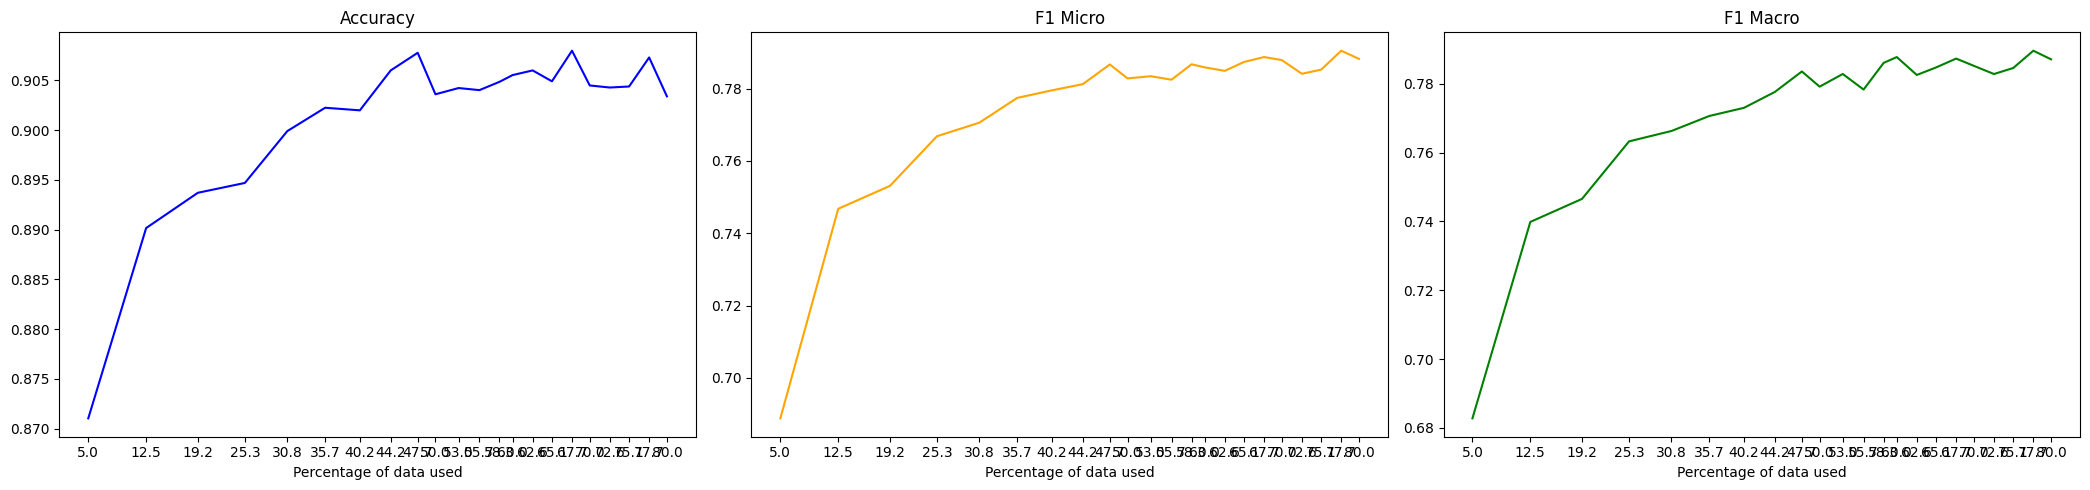

In [ ]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: [14, 61, 33]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5895, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4426, Accuracy: 0.7894, F1 Micro: 0.0246, F1 Macro: 0.022
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3847, Accuracy: 0.818, F1 Micro: 0.2556, F1 Macro: 0.1754
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3668, Accuracy: 0.8298, F1 Micro: 0.3605, F1 Macro: 0.2793
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3013, Accuracy: 0.8477, F1 Micro: 0.5288, F1 Macro: 0.4896
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2561, Accuracy: 0.852, F1 Micro: 0.5414, F1 Macro: 0.5173
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2332, Accuracy: 0.8598, F1 Micro: 0.6081, F1 Macro: 0.5985
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1801, Accuracy: 0.8694, F1 Micro: 0.6596, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1445, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6012, Accuracy: 0.7864, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4516, Accuracy: 0.7872, F1 Micro: 0.0044, F1 Macro: 0.004
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.398, Accuracy: 0.8172, F1 Micro: 0.251, F1 Macro: 0.1728
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3939, Accuracy: 0.8272, F1 Micro: 0.3494, F1 Macro: 0.2421
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3201, Accuracy: 0.8402, F1 Micro: 0.4607, F1 Macro: 0.3833
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2709, Accuracy: 0.8581, F1 Micro: 0.5873, F1 Macro: 0.5595
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2413, Accuracy: 0.8652, F1 Micro: 0.6233, F1 Macro: 0.612
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1826, Accuracy: 0.8681, F1 Micro: 0.6415, F1 Macro: 0.6302
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1453, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6051, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.44, Accuracy: 0.7872, F1 Micro: 0.0044, F1 Macro: 0.004
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3793, Accuracy: 0.815, F1 Micro: 0.2342, F1 Macro: 0.1642
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3661, Accuracy: 0.8283, F1 Micro: 0.3599, F1 Macro: 0.2676
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2997, Accuracy: 0.8441, F1 Micro: 0.4944, F1 Macro: 0.4593
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2552, Accuracy: 0.8545, F1 Micro: 0.5812, F1 Macro: 0.5695
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2256, Accuracy: 0.8572, F1 Micro: 0.5875, F1 Macro: 0.5736
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1775, Accuracy: 0.8647, F1 Micro: 0.6182, F1 Macro: 0.6072
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1353, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5273, Accuracy: 0.8189, F1 Micro: 0.266, F1 Macro: 0.1937
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3823, Accuracy: 0.8444, F1 Micro: 0.4818, F1 Macro: 0.3894
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2859, Accuracy: 0.8562, F1 Micro: 0.5534, F1 Macro: 0.5141
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2294, Accuracy: 0.8652, F1 Micro: 0.598, F1 Macro: 0.5696
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1888, Accuracy: 0.8813, F1 Micro: 0.6948, F1 Macro: 0.6921
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1595, Accuracy: 0.8834, F1 Micro: 0.7235, F1 Macro: 0.7233
Epoch 7/10, Train Loss: 0.1258, Accuracy: 0.8856, F1 Micro: 0.7063, F1 Macro: 0.7029
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0885, Accuracy: 0.8889, F1 Micro: 0.73, F1 Macro: 0.7268
Epoch 9/10, Train Loss: 0.083, Accuracy: 0.8898, F1 Micro: 0.729, F1 Macro: 0.7233
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5358, Accuracy: 0.815, F1 Micro: 0.2381, F1 Macro: 0.1774
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4097, Accuracy: 0.8398, F1 Micro: 0.445, F1 Macro: 0.3108
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3125, Accuracy: 0.8567, F1 Micro: 0.5422, F1 Macro: 0.4867
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2448, Accuracy: 0.8703, F1 Micro: 0.6298, F1 Macro: 0.6074
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1933, Accuracy: 0.8803, F1 Micro: 0.7005, F1 Macro: 0.6941
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1605, Accuracy: 0.8844, F1 Micro: 0.7023, F1 Macro: 0.7004
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1355, Accuracy: 0.8873, F1 Micro: 0.7239, F1 Macro: 0.72
Epoch 8/10, Train Loss: 0.0939, Accuracy: 0.8889, F1 Micro: 0.7215, F1 Macro: 0.7145
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0864, Accuracy: 0.8891, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5332, Accuracy: 0.8103, F1 Micro: 0.2045, F1 Macro: 0.1556
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3881, Accuracy: 0.8366, F1 Micro: 0.4182, F1 Macro: 0.3254
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2923, Accuracy: 0.8548, F1 Micro: 0.5353, F1 Macro: 0.4846
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2364, Accuracy: 0.8708, F1 Micro: 0.6329, F1 Macro: 0.6198
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.189, Accuracy: 0.8806, F1 Micro: 0.7039, F1 Macro: 0.6997
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1586, Accuracy: 0.8844, F1 Micro: 0.7184, F1 Macro: 0.7178
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1303, Accuracy: 0.8864, F1 Micro: 0.7194, F1 Macro: 0.7164
Epoch 8/10, Train Loss: 0.0894, Accuracy: 0.8855, F1 Micro: 0.7088, F1 Macro: 0.6995
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0829, Accuracy: 0.8903, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5016, Accuracy: 0.8356, F1 Micro: 0.3982, F1 Macro: 0.2866
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3535, Accuracy: 0.8691, F1 Micro: 0.6403, F1 Macro: 0.6255
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2621, Accuracy: 0.8819, F1 Micro: 0.7058, F1 Macro: 0.7036
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2188, Accuracy: 0.8905, F1 Micro: 0.7459, F1 Macro: 0.7399
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1815, Accuracy: 0.8913, F1 Micro: 0.7539, F1 Macro: 0.75
Epoch 6/10, Train Loss: 0.1347, Accuracy: 0.8955, F1 Micro: 0.7538, F1 Macro: 0.7448
Epoch 7/10, Train Loss: 0.0978, Accuracy: 0.8948, F1 Micro: 0.7364, F1 Macro: 0.7252
Epoch 8/10, Train Loss: 0.0879, Accuracy: 0.8934, F1 Micro: 0.7525, F1 Macro: 0.7468
Epoch 9/10, Train Loss: 0.0675, Accuracy: 0.8923, F1 Micro: 0.7265, F1 Macro: 0.7123
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0575, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5132, Accuracy: 0.8338, F1 Micro: 0.3906, F1 Macro: 0.2731
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3648, Accuracy: 0.8712, F1 Micro: 0.6688, F1 Macro: 0.633
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2725, Accuracy: 0.8813, F1 Micro: 0.6982, F1 Macro: 0.6932
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2227, Accuracy: 0.8869, F1 Micro: 0.7481, F1 Macro: 0.7415
Epoch 5/10, Train Loss: 0.1774, Accuracy: 0.8892, F1 Micro: 0.7467, F1 Macro: 0.7382
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1321, Accuracy: 0.893, F1 Micro: 0.7484, F1 Macro: 0.7402
Epoch 7/10, Train Loss: 0.1013, Accuracy: 0.8905, F1 Micro: 0.7344, F1 Macro: 0.7257
Epoch 8/10, Train Loss: 0.0903, Accuracy: 0.8936, F1 Micro: 0.7386, F1 Macro: 0.7305
Epoch 9/10, Train Loss: 0.0675, Accuracy: 0.8916, F1 Micro: 0.7462, F1 Macro: 0.7399
Epoch 10/10, Train Loss: 0.0513, Accuracy: 0.887, F1 Micro: 0.7441, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.504, Accuracy: 0.8336, F1 Micro: 0.3911, F1 Macro: 0.2725
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3551, Accuracy: 0.8661, F1 Micro: 0.6279, F1 Macro: 0.6047
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2663, Accuracy: 0.8795, F1 Micro: 0.7013, F1 Macro: 0.6971
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2245, Accuracy: 0.8845, F1 Micro: 0.7408, F1 Macro: 0.7381
Epoch 5/10, Train Loss: 0.1855, Accuracy: 0.8873, F1 Micro: 0.7344, F1 Macro: 0.7229
Epoch 6/10, Train Loss: 0.1393, Accuracy: 0.8886, F1 Micro: 0.7356, F1 Macro: 0.7293
Epoch 7/10, Train Loss: 0.103, Accuracy: 0.8903, F1 Micro: 0.7285, F1 Macro: 0.7219
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0899, Accuracy: 0.8942, F1 Micro: 0.7456, F1 Macro: 0.7402
Epoch 9/10, Train Loss: 0.0725, Accuracy: 0.8931, F1 Micro: 0.7351, F1 Macro: 0.7256
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.059, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4808, Accuracy: 0.8505, F1 Micro: 0.5297, F1 Macro: 0.4505
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3113, Accuracy: 0.8777, F1 Micro: 0.7141, F1 Macro: 0.7064
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2508, Accuracy: 0.8892, F1 Micro: 0.7282, F1 Macro: 0.7161
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2011, Accuracy: 0.8922, F1 Micro: 0.7471, F1 Macro: 0.7437
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1603, Accuracy: 0.8928, F1 Micro: 0.7507, F1 Macro: 0.7437
Epoch 6/10, Train Loss: 0.1231, Accuracy: 0.8925, F1 Micro: 0.7384, F1 Macro: 0.732
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0997, Accuracy: 0.8952, F1 Micro: 0.7512, F1 Macro: 0.7466
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0743, Accuracy: 0.8953, F1 Micro: 0.7513, F1 Macro: 0.7465
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0566, Accuracy: 0.8963, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4905, Accuracy: 0.8456, F1 Micro: 0.4838, F1 Macro: 0.3638
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3178, Accuracy: 0.8794, F1 Micro: 0.7174, F1 Macro: 0.7105
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2504, Accuracy: 0.8889, F1 Micro: 0.7285, F1 Macro: 0.7148
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1986, Accuracy: 0.8928, F1 Micro: 0.7438, F1 Macro: 0.7382
Epoch 5/10, Train Loss: 0.1545, Accuracy: 0.8942, F1 Micro: 0.7435, F1 Macro: 0.7318
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1195, Accuracy: 0.8928, F1 Micro: 0.7455, F1 Macro: 0.7413
Epoch 7/10, Train Loss: 0.0971, Accuracy: 0.8917, F1 Micro: 0.7242, F1 Macro: 0.712
Epoch 8/10, Train Loss: 0.0789, Accuracy: 0.8947, F1 Micro: 0.7418, F1 Macro: 0.7334
Epoch 9/10, Train Loss: 0.0557, Accuracy: 0.8925, F1 Micro: 0.7454, F1 Macro: 0.7382
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0468, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4811, Accuracy: 0.8436, F1 Micro: 0.4885, F1 Macro: 0.4152
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3168, Accuracy: 0.8775, F1 Micro: 0.7086, F1 Macro: 0.7055
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2501, Accuracy: 0.8838, F1 Micro: 0.7127, F1 Macro: 0.7003
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2037, Accuracy: 0.893, F1 Micro: 0.749, F1 Macro: 0.7444
Epoch 5/10, Train Loss: 0.1625, Accuracy: 0.8908, F1 Micro: 0.7433, F1 Macro: 0.7325
Epoch 6/10, Train Loss: 0.1268, Accuracy: 0.8939, F1 Micro: 0.7373, F1 Macro: 0.7349
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1018, Accuracy: 0.892, F1 Micro: 0.7551, F1 Macro: 0.7508
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0798, Accuracy: 0.8955, F1 Micro: 0.7606, F1 Macro: 0.7597
Epoch 9/10, Train Loss: 0.0602, Accuracy: 0.8917, F1 Micro: 0.7417, F1 Macro: 0.7381
Epoch 10/10, Train Loss: 0.0446, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4765, Accuracy: 0.8608, F1 Micro: 0.5963, F1 Macro: 0.5247
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2982, Accuracy: 0.8852, F1 Micro: 0.7098, F1 Macro: 0.7062
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2521, Accuracy: 0.8903, F1 Micro: 0.723, F1 Macro: 0.7132
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2028, Accuracy: 0.8964, F1 Micro: 0.7468, F1 Macro: 0.7445
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1509, Accuracy: 0.8948, F1 Micro: 0.769, F1 Macro: 0.7674
Epoch 6/10, Train Loss: 0.1196, Accuracy: 0.8955, F1 Micro: 0.7579, F1 Macro: 0.755
Epoch 7/10, Train Loss: 0.0887, Accuracy: 0.8984, F1 Micro: 0.7635, F1 Macro: 0.7651
Epoch 8/10, Train Loss: 0.0661, Accuracy: 0.895, F1 Micro: 0.7526, F1 Macro: 0.7458
Epoch 9/10, Train Loss: 0.0545, Accuracy: 0.8978, F1 Micro: 0.7653, F1 Macro: 0.763
Epoch 10/10, Train Loss: 0.0397, Accuracy: 0.8933, F1 Micro: 0.7586, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4938, Accuracy: 0.852, F1 Micro: 0.5518, F1 Macro: 0.4467
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3132, Accuracy: 0.8848, F1 Micro: 0.7051, F1 Macro: 0.6978
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2548, Accuracy: 0.8905, F1 Micro: 0.723, F1 Macro: 0.7146
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2035, Accuracy: 0.8956, F1 Micro: 0.7376, F1 Macro: 0.7356
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1562, Accuracy: 0.8983, F1 Micro: 0.7542, F1 Macro: 0.7458
Epoch 6/10, Train Loss: 0.1204, Accuracy: 0.8953, F1 Micro: 0.7535, F1 Macro: 0.752
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.093, Accuracy: 0.8969, F1 Micro: 0.7628, F1 Macro: 0.7596
Epoch 8/10, Train Loss: 0.0663, Accuracy: 0.8977, F1 Micro: 0.76, F1 Macro: 0.755
Epoch 9/10, Train Loss: 0.0579, Accuracy: 0.8956, F1 Micro: 0.7531, F1 Macro: 0.7477
Epoch 10/10, Train Loss: 0.044, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4835, Accuracy: 0.8566, F1 Micro: 0.5785, F1 Macro: 0.5043
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3065, Accuracy: 0.8792, F1 Micro: 0.6799, F1 Macro: 0.6688
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2574, Accuracy: 0.8861, F1 Micro: 0.7111, F1 Macro: 0.7
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2018, Accuracy: 0.8936, F1 Micro: 0.7372, F1 Macro: 0.7328
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1642, Accuracy: 0.8992, F1 Micro: 0.7608, F1 Macro: 0.7561
Epoch 6/10, Train Loss: 0.1263, Accuracy: 0.895, F1 Micro: 0.7423, F1 Macro: 0.739
Epoch 7/10, Train Loss: 0.0901, Accuracy: 0.8963, F1 Micro: 0.7408, F1 Macro: 0.7378
Epoch 8/10, Train Loss: 0.0716, Accuracy: 0.8983, F1 Micro: 0.7458, F1 Macro: 0.7378
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0585, Accuracy: 0.8952, F1 Micro: 0.7618, F1 Macro: 0.7617
Epoch 10/10, Train Loss: 0.0406, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4496, Accuracy: 0.8656, F1 Micro: 0.6087, F1 Macro: 0.5987
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.283, Accuracy: 0.8914, F1 Micro: 0.7481, F1 Macro: 0.7487
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2418, Accuracy: 0.8945, F1 Micro: 0.7611, F1 Macro: 0.762
Epoch 4/10, Train Loss: 0.1862, Accuracy: 0.8983, F1 Micro: 0.7599, F1 Macro: 0.7538
Epoch 5/10, Train Loss: 0.148, Accuracy: 0.8992, F1 Micro: 0.7392, F1 Macro: 0.7304
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1164, Accuracy: 0.8998, F1 Micro: 0.7721, F1 Macro: 0.7719
Epoch 7/10, Train Loss: 0.0795, Accuracy: 0.8941, F1 Micro: 0.7689, F1 Macro: 0.7693
Epoch 8/10, Train Loss: 0.0663, Accuracy: 0.8988, F1 Micro: 0.76, F1 Macro: 0.7584
Epoch 9/10, Train Loss: 0.0523, Accuracy: 0.8992, F1 Micro: 0.7664, F1 Macro: 0.7626
Epoch 10/10, Train Loss: 0.039, Accuracy: 0.8991, F1 Micro: 0.7704, F1 Macro: 0.769
Model 1 - Iteration 2777

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4659, Accuracy: 0.8639, F1 Micro: 0.5962, F1 Macro: 0.5813
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2933, Accuracy: 0.8917, F1 Micro: 0.7481, F1 Macro: 0.7458
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2415, Accuracy: 0.8917, F1 Micro: 0.7529, F1 Macro: 0.7508
Epoch 4/10, Train Loss: 0.1881, Accuracy: 0.8938, F1 Micro: 0.742, F1 Macro: 0.7339
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1393, Accuracy: 0.8989, F1 Micro: 0.7601, F1 Macro: 0.7573
Epoch 6/10, Train Loss: 0.1111, Accuracy: 0.8939, F1 Micro: 0.7598, F1 Macro: 0.7573
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0826, Accuracy: 0.8944, F1 Micro: 0.7674, F1 Macro: 0.7678
Epoch 8/10, Train Loss: 0.0661, Accuracy: 0.8998, F1 Micro: 0.7646, F1 Macro: 0.7616
Epoch 9/10, Train Loss: 0.0522, Accuracy: 0.9017, F1 Micro: 0.7673, F1 Macro: 0.76
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0417, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4527, Accuracy: 0.8586, F1 Micro: 0.5596, F1 Macro: 0.5343
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2872, Accuracy: 0.89, F1 Micro: 0.7455, F1 Macro: 0.7413
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2428, Accuracy: 0.8923, F1 Micro: 0.7547, F1 Macro: 0.7547
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1927, Accuracy: 0.8986, F1 Micro: 0.7579, F1 Macro: 0.7499
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1446, Accuracy: 0.9027, F1 Micro: 0.7588, F1 Macro: 0.7483
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.121, Accuracy: 0.8967, F1 Micro: 0.7649, F1 Macro: 0.7624
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0852, Accuracy: 0.8986, F1 Micro: 0.7673, F1 Macro: 0.7619
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0677, Accuracy: 0.898, F1 Micro: 0.768, F1 Macro: 0.7664
Epoch 9/10, Train Loss: 0.0483, Accuracy: 0.9003, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4428, Accuracy: 0.8737, F1 Micro: 0.6794, F1 Macro: 0.6759
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.279, Accuracy: 0.8909, F1 Micro: 0.7278, F1 Macro: 0.7235
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2243, Accuracy: 0.8945, F1 Micro: 0.7536, F1 Macro: 0.7478
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1793, Accuracy: 0.8947, F1 Micro: 0.7638, F1 Macro: 0.7648
Epoch 5/10, Train Loss: 0.1551, Accuracy: 0.9009, F1 Micro: 0.76, F1 Macro: 0.7537
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1095, Accuracy: 0.8992, F1 Micro: 0.7645, F1 Macro: 0.7548
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.085, Accuracy: 0.9016, F1 Micro: 0.7724, F1 Macro: 0.7684
Epoch 8/10, Train Loss: 0.0599, Accuracy: 0.9002, F1 Micro: 0.7617, F1 Macro: 0.7581
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0446, Accuracy: 0.9016, F1 Micro: 0.7758, F1 Macro: 0.7721
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4549, Accuracy: 0.8778, F1 Micro: 0.6842, F1 Macro: 0.6768
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2869, Accuracy: 0.8889, F1 Micro: 0.7159, F1 Macro: 0.7088
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2224, Accuracy: 0.8992, F1 Micro: 0.7624, F1 Macro: 0.7568
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1789, Accuracy: 0.8973, F1 Micro: 0.7653, F1 Macro: 0.7657
Epoch 5/10, Train Loss: 0.1509, Accuracy: 0.8991, F1 Micro: 0.7496, F1 Macro: 0.7408
Epoch 6/10, Train Loss: 0.112, Accuracy: 0.9019, F1 Micro: 0.7639, F1 Macro: 0.7523
Epoch 7/10, Train Loss: 0.0869, Accuracy: 0.8969, F1 Micro: 0.7609, F1 Macro: 0.7537
Epoch 8/10, Train Loss: 0.0645, Accuracy: 0.898, F1 Micro: 0.7529, F1 Macro: 0.7468
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0461, Accuracy: 0.9011, F1 Micro: 0.7758, F1 Macro: 0.7768
Epoch 10/10, Train Loss: 0.0402, Accuracy: 0.9011, F1 Micro: 0.7711, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4488, Accuracy: 0.8714, F1 Micro: 0.6753, F1 Macro: 0.6655
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2814, Accuracy: 0.8902, F1 Micro: 0.7229, F1 Macro: 0.7183
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2253, Accuracy: 0.8986, F1 Micro: 0.7557, F1 Macro: 0.7489
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1801, Accuracy: 0.8967, F1 Micro: 0.767, F1 Macro: 0.7676
Epoch 5/10, Train Loss: 0.1527, Accuracy: 0.8991, F1 Micro: 0.7397, F1 Macro: 0.7279
Epoch 6/10, Train Loss: 0.1109, Accuracy: 0.8992, F1 Micro: 0.7649, F1 Macro: 0.761
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0867, Accuracy: 0.8983, F1 Micro: 0.7673, F1 Macro: 0.7617
Epoch 8/10, Train Loss: 0.0637, Accuracy: 0.8992, F1 Micro: 0.7558, F1 Macro: 0.7472
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0443, Accuracy: 0.9013, F1 Micro: 0.7738, F1 Macro: 0.7723
Epoch 10/10, Train Loss: 0.0352, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4326, Accuracy: 0.875, F1 Micro: 0.6808, F1 Macro: 0.677
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2814, Accuracy: 0.8944, F1 Micro: 0.7635, F1 Macro: 0.7541
Epoch 3/10, Train Loss: 0.2261, Accuracy: 0.8964, F1 Micro: 0.7518, F1 Macro: 0.7343
Epoch 4/10, Train Loss: 0.1985, Accuracy: 0.897, F1 Micro: 0.7246, F1 Macro: 0.718
Epoch 5/10, Train Loss: 0.1574, Accuracy: 0.8967, F1 Micro: 0.7499, F1 Macro: 0.7409
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1129, Accuracy: 0.9028, F1 Micro: 0.7751, F1 Macro: 0.7728
Epoch 7/10, Train Loss: 0.084, Accuracy: 0.9028, F1 Micro: 0.7662, F1 Macro: 0.7657
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0651, Accuracy: 0.9042, F1 Micro: 0.7799, F1 Macro: 0.7767
Epoch 9/10, Train Loss: 0.0492, Accuracy: 0.9039, F1 Micro: 0.7696, F1 Macro: 0.7636
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0394, Accuracy: 0.9038, F1 Micro: 0.7823, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4384, Accuracy: 0.8763, F1 Micro: 0.6692, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2843, Accuracy: 0.8948, F1 Micro: 0.7534, F1 Macro: 0.7412
Epoch 3/10, Train Loss: 0.2255, Accuracy: 0.8966, F1 Micro: 0.7506, F1 Macro: 0.7367
Epoch 4/10, Train Loss: 0.1899, Accuracy: 0.8958, F1 Micro: 0.7254, F1 Macro: 0.7171
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1497, Accuracy: 0.8992, F1 Micro: 0.765, F1 Macro: 0.7611
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1148, Accuracy: 0.9025, F1 Micro: 0.7692, F1 Macro: 0.7639
Epoch 7/10, Train Loss: 0.0843, Accuracy: 0.8995, F1 Micro: 0.7468, F1 Macro: 0.7408
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0731, Accuracy: 0.9014, F1 Micro: 0.7817, F1 Macro: 0.7804
Epoch 9/10, Train Loss: 0.0557, Accuracy: 0.9036, F1 Micro: 0.7683, F1 Macro: 0.7652
Epoch 10/10, Train Loss: 0.0405, Accuracy: 0.9034, F1 Micro: 0.7735, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4354, Accuracy: 0.8747, F1 Micro: 0.6705, F1 Macro: 0.6539
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2831, Accuracy: 0.897, F1 Micro: 0.7576, F1 Macro: 0.7479
Epoch 3/10, Train Loss: 0.2235, Accuracy: 0.8947, F1 Micro: 0.7443, F1 Macro: 0.7246
Epoch 4/10, Train Loss: 0.1965, Accuracy: 0.8969, F1 Micro: 0.7291, F1 Macro: 0.7197
Epoch 5/10, Train Loss: 0.1499, Accuracy: 0.8978, F1 Micro: 0.7515, F1 Macro: 0.7459
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1103, Accuracy: 0.9031, F1 Micro: 0.7739, F1 Macro: 0.7723
Epoch 7/10, Train Loss: 0.0814, Accuracy: 0.9016, F1 Micro: 0.7619, F1 Macro: 0.7564
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0645, Accuracy: 0.9028, F1 Micro: 0.7745, F1 Macro: 0.7724
Epoch 9/10, Train Loss: 0.0467, Accuracy: 0.9009, F1 Micro: 0.76, F1 Macro: 0.751
Epoch 10/10, Train Loss: 0.044, Accuracy: 0.9042, F1 Micro: 0.7689, F1 Macro: 0.7619
Model 3 - Iteration 34

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4269, Accuracy: 0.8736, F1 Micro: 0.6616, F1 Macro: 0.6642
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2688, Accuracy: 0.8956, F1 Micro: 0.7498, F1 Macro: 0.7467
Epoch 3/10, Train Loss: 0.2274, Accuracy: 0.8995, F1 Micro: 0.7441, F1 Macro: 0.7314
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1811, Accuracy: 0.9016, F1 Micro: 0.7615, F1 Macro: 0.7489
Epoch 5/10, Train Loss: 0.1361, Accuracy: 0.9017, F1 Micro: 0.7463, F1 Macro: 0.7378
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1035, Accuracy: 0.9009, F1 Micro: 0.7779, F1 Macro: 0.7771
Epoch 7/10, Train Loss: 0.0798, Accuracy: 0.8997, F1 Micro: 0.7458, F1 Macro: 0.7304
Epoch 8/10, Train Loss: 0.0573, Accuracy: 0.9022, F1 Micro: 0.7652, F1 Macro: 0.7652
Epoch 9/10, Train Loss: 0.0434, Accuracy: 0.8991, F1 Micro: 0.7721, F1 Macro: 0.771
Epoch 10/10, Train Loss: 0.034, Accuracy: 0.9016, F1 Micro: 0.7714, F1 Macro: 0.7707
Model 1 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4354, Accuracy: 0.8797, F1 Micro: 0.6969, F1 Macro: 0.6954
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2744, Accuracy: 0.8956, F1 Micro: 0.7509, F1 Macro: 0.7479
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2257, Accuracy: 0.9, F1 Micro: 0.7546, F1 Macro: 0.7462
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1808, Accuracy: 0.9006, F1 Micro: 0.7596, F1 Macro: 0.7479
Epoch 5/10, Train Loss: 0.1384, Accuracy: 0.9014, F1 Micro: 0.7561, F1 Macro: 0.7453
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1013, Accuracy: 0.9005, F1 Micro: 0.7767, F1 Macro: 0.7764
Epoch 7/10, Train Loss: 0.0824, Accuracy: 0.9003, F1 Micro: 0.7482, F1 Macro: 0.7336
Epoch 8/10, Train Loss: 0.055, Accuracy: 0.9025, F1 Micro: 0.7689, F1 Macro: 0.7658
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0475, Accuracy: 0.9033, F1 Micro: 0.7774, F1 Macro: 0.7771
Epoch 10/10, Train Loss: 0.0373, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4278, Accuracy: 0.8717, F1 Micro: 0.6694, F1 Macro: 0.6739
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2726, Accuracy: 0.8955, F1 Micro: 0.7453, F1 Macro: 0.7425
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2272, Accuracy: 0.9016, F1 Micro: 0.7558, F1 Macro: 0.7456
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1853, Accuracy: 0.9019, F1 Micro: 0.7598, F1 Macro: 0.7464
Epoch 5/10, Train Loss: 0.1401, Accuracy: 0.9016, F1 Micro: 0.7486, F1 Macro: 0.7366
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1058, Accuracy: 0.8972, F1 Micro: 0.7726, F1 Macro: 0.7738
Epoch 7/10, Train Loss: 0.0828, Accuracy: 0.9016, F1 Micro: 0.7637, F1 Macro: 0.7525
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0605, Accuracy: 0.9052, F1 Micro: 0.7763, F1 Macro: 0.7757
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0446, Accuracy: 0.9039, F1 Micro: 0.7789, F1 Macro: 0.7777
High

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4207, Accuracy: 0.877, F1 Micro: 0.6794, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2736, Accuracy: 0.8958, F1 Micro: 0.7389, F1 Macro: 0.7358
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2278, Accuracy: 0.9009, F1 Micro: 0.7598, F1 Macro: 0.7546
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1846, Accuracy: 0.8959, F1 Micro: 0.7711, F1 Macro: 0.7667
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1466, Accuracy: 0.9023, F1 Micro: 0.7786, F1 Macro: 0.7749
Epoch 6/10, Train Loss: 0.1026, Accuracy: 0.9023, F1 Micro: 0.7689, F1 Macro: 0.7583
Epoch 7/10, Train Loss: 0.0818, Accuracy: 0.9034, F1 Micro: 0.7731, F1 Macro: 0.7675
Epoch 8/10, Train Loss: 0.06, Accuracy: 0.9009, F1 Micro: 0.7711, F1 Macro: 0.7663
Epoch 9/10, Train Loss: 0.0482, Accuracy: 0.9055, F1 Micro: 0.7768, F1 Macro: 0.7709
Epoch 10/10, Train Loss: 0.0349, Accuracy: 0.9022, F1 Micro: 0.7785, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.429, Accuracy: 0.8684, F1 Micro: 0.6073, F1 Macro: 0.5608
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2719, Accuracy: 0.8956, F1 Micro: 0.7332, F1 Macro: 0.727
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2207, Accuracy: 0.8998, F1 Micro: 0.7553, F1 Macro: 0.7513
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1806, Accuracy: 0.8978, F1 Micro: 0.7681, F1 Macro: 0.7646
Epoch 5/10, Train Loss: 0.1475, Accuracy: 0.8973, F1 Micro: 0.7367, F1 Macro: 0.7229
Epoch 6/10, Train Loss: 0.1081, Accuracy: 0.9011, F1 Micro: 0.7641, F1 Macro: 0.7564
Epoch 7/10, Train Loss: 0.0778, Accuracy: 0.9013, F1 Micro: 0.7676, F1 Macro: 0.76
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0579, Accuracy: 0.8998, F1 Micro: 0.7739, F1 Macro: 0.7716
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0495, Accuracy: 0.9036, F1 Micro: 0.7816, F1 Macro: 0.7805
Epoch 10/10, Train Loss: 0.038, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4249, Accuracy: 0.8739, F1 Micro: 0.6591, F1 Macro: 0.6401
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2782, Accuracy: 0.892, F1 Micro: 0.7261, F1 Macro: 0.7219
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2293, Accuracy: 0.8995, F1 Micro: 0.7691, F1 Macro: 0.765
Epoch 4/10, Train Loss: 0.1819, Accuracy: 0.8956, F1 Micro: 0.7685, F1 Macro: 0.7669
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.147, Accuracy: 0.9033, F1 Micro: 0.77, F1 Macro: 0.7648
Epoch 6/10, Train Loss: 0.111, Accuracy: 0.8986, F1 Micro: 0.7658, F1 Macro: 0.7611
Epoch 7/10, Train Loss: 0.081, Accuracy: 0.903, F1 Micro: 0.7692, F1 Macro: 0.7657
Epoch 8/10, Train Loss: 0.0594, Accuracy: 0.9031, F1 Micro: 0.7695, F1 Macro: 0.7628
Epoch 9/10, Train Loss: 0.0438, Accuracy: 0.902, F1 Micro: 0.7595, F1 Macro: 0.7555
Epoch 10/10, Train Loss: 0.0374, Accuracy: 0.9025, F1 Micro: 0.7684, F1 Macro: 0.765
Model 3 - Iteration 3886: A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.412, Accuracy: 0.8794, F1 Micro: 0.6998, F1 Macro: 0.6911
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2662, Accuracy: 0.8955, F1 Micro: 0.7541, F1 Macro: 0.7482
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2105, Accuracy: 0.8989, F1 Micro: 0.7745, F1 Macro: 0.7722
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1786, Accuracy: 0.902, F1 Micro: 0.7773, F1 Macro: 0.7744
Epoch 5/10, Train Loss: 0.142, Accuracy: 0.9009, F1 Micro: 0.7678, F1 Macro: 0.7644
Epoch 6/10, Train Loss: 0.1012, Accuracy: 0.8992, F1 Micro: 0.7556, F1 Macro: 0.7442
Epoch 7/10, Train Loss: 0.0781, Accuracy: 0.9036, F1 Micro: 0.7666, F1 Macro: 0.7638
Epoch 8/10, Train Loss: 0.0591, Accuracy: 0.8989, F1 Micro: 0.7731, F1 Macro: 0.7709
Epoch 9/10, Train Loss: 0.0416, Accuracy: 0.9009, F1 Micro: 0.7633, F1 Macro: 0.7528
Epoch 10/10, Train Loss: 0.0305, Accuracy: 0.9028, F1 Micro: 0.7669, F1 Macro: 0.7594
Model 1 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.42, Accuracy: 0.8791, F1 Micro: 0.6902, F1 Macro: 0.6702
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2703, Accuracy: 0.8972, F1 Micro: 0.7545, F1 Macro: 0.7469
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2083, Accuracy: 0.9011, F1 Micro: 0.7777, F1 Macro: 0.7721
Epoch 4/10, Train Loss: 0.1768, Accuracy: 0.8952, F1 Micro: 0.7668, F1 Macro: 0.7673
Epoch 5/10, Train Loss: 0.1308, Accuracy: 0.8989, F1 Micro: 0.766, F1 Macro: 0.762
Epoch 6/10, Train Loss: 0.1054, Accuracy: 0.8959, F1 Micro: 0.7647, F1 Macro: 0.7606
Epoch 7/10, Train Loss: 0.0774, Accuracy: 0.9041, F1 Micro: 0.7709, F1 Macro: 0.7696
Epoch 8/10, Train Loss: 0.0585, Accuracy: 0.8975, F1 Micro: 0.7732, F1 Macro: 0.7742
Epoch 9/10, Train Loss: 0.0462, Accuracy: 0.8978, F1 Micro: 0.7731, F1 Macro: 0.7687
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0338, Accuracy: 0.9016, F1 Micro: 0.7794, F1 Macro: 0.7772
Model 2 - Iteration 4

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4129, Accuracy: 0.8761, F1 Micro: 0.6869, F1 Macro: 0.6766
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2696, Accuracy: 0.8973, F1 Micro: 0.756, F1 Macro: 0.7459
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2132, Accuracy: 0.9008, F1 Micro: 0.7703, F1 Macro: 0.7631
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1761, Accuracy: 0.9034, F1 Micro: 0.7759, F1 Macro: 0.7729
Epoch 5/10, Train Loss: 0.1359, Accuracy: 0.8998, F1 Micro: 0.7658, F1 Macro: 0.7599
Epoch 6/10, Train Loss: 0.1056, Accuracy: 0.9025, F1 Micro: 0.7716, F1 Macro: 0.7672
Epoch 7/10, Train Loss: 0.0709, Accuracy: 0.9027, F1 Micro: 0.771, F1 Macro: 0.7705
Epoch 8/10, Train Loss: 0.0563, Accuracy: 0.8992, F1 Micro: 0.7672, F1 Macro: 0.7668
Epoch 9/10, Train Loss: 0.0447, Accuracy: 0.9017, F1 Micro: 0.7743, F1 Macro: 0.7702
Epoch 10/10, Train Loss: 0.0344, Accuracy: 0.9034, F1 Micro: 0.7684, F1 Macro: 0.7659
Model 3 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4009, Accuracy: 0.8753, F1 Micro: 0.673, F1 Macro: 0.666
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2629, Accuracy: 0.8944, F1 Micro: 0.7659, F1 Macro: 0.7662
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2152, Accuracy: 0.9006, F1 Micro: 0.7675, F1 Macro: 0.764
Epoch 4/10, Train Loss: 0.1767, Accuracy: 0.9022, F1 Micro: 0.7661, F1 Macro: 0.7599
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1375, Accuracy: 0.9016, F1 Micro: 0.7745, F1 Macro: 0.7699
Epoch 6/10, Train Loss: 0.1025, Accuracy: 0.9002, F1 Micro: 0.7655, F1 Macro: 0.7611
Epoch 7/10, Train Loss: 0.0768, Accuracy: 0.9006, F1 Micro: 0.7604, F1 Macro: 0.7552
Epoch 8/10, Train Loss: 0.0555, Accuracy: 0.9019, F1 Micro: 0.7701, F1 Macro: 0.7623
Epoch 9/10, Train Loss: 0.0437, Accuracy: 0.9025, F1 Micro: 0.7689, F1 Macro: 0.7632
Epoch 10/10, Train Loss: 0.0312, Accuracy: 0.9025, F1 Micro: 0.7706, F1 Macro: 0.7676
Model 1 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4164, Accuracy: 0.8769, F1 Micro: 0.6868, F1 Macro: 0.6817
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2636, Accuracy: 0.8961, F1 Micro: 0.7656, F1 Macro: 0.7664
Epoch 3/10, Train Loss: 0.207, Accuracy: 0.9006, F1 Micro: 0.7651, F1 Macro: 0.7597
Epoch 4/10, Train Loss: 0.1751, Accuracy: 0.9011, F1 Micro: 0.7649, F1 Macro: 0.7578
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1323, Accuracy: 0.9056, F1 Micro: 0.7804, F1 Macro: 0.7758
Epoch 6/10, Train Loss: 0.1025, Accuracy: 0.9041, F1 Micro: 0.7678, F1 Macro: 0.7608
Epoch 7/10, Train Loss: 0.0782, Accuracy: 0.9045, F1 Micro: 0.7726, F1 Macro: 0.7697
Epoch 8/10, Train Loss: 0.0553, Accuracy: 0.9002, F1 Micro: 0.7665, F1 Macro: 0.7601
Epoch 9/10, Train Loss: 0.0471, Accuracy: 0.9044, F1 Micro: 0.7682, F1 Macro: 0.7641
Epoch 10/10, Train Loss: 0.0324, Accuracy: 0.9039, F1 Micro: 0.7777, F1 Macro: 0.7769
Model 2 - Iteration 4330: Accuracy: 0.9056, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4086, Accuracy: 0.8747, F1 Micro: 0.6697, F1 Macro: 0.6635
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2645, Accuracy: 0.8958, F1 Micro: 0.7659, F1 Macro: 0.7623
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2116, Accuracy: 0.9014, F1 Micro: 0.7683, F1 Macro: 0.7641
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1743, Accuracy: 0.9016, F1 Micro: 0.774, F1 Macro: 0.7709
Epoch 5/10, Train Loss: 0.1367, Accuracy: 0.9047, F1 Micro: 0.7705, F1 Macro: 0.7642
Epoch 6/10, Train Loss: 0.1063, Accuracy: 0.9034, F1 Micro: 0.7657, F1 Macro: 0.7596
Epoch 7/10, Train Loss: 0.0749, Accuracy: 0.9036, F1 Micro: 0.7731, F1 Macro: 0.7746
Epoch 8/10, Train Loss: 0.0559, Accuracy: 0.9041, F1 Micro: 0.7635, F1 Macro: 0.7567
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.046, Accuracy: 0.9053, F1 Micro: 0.7754, F1 Macro: 0.7723
Epoch 10/10, Train Loss: 0.0354, Accuracy: 0.9036, F1 Micro: 0.7741, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3994, Accuracy: 0.8764, F1 Micro: 0.6683, F1 Macro: 0.6498
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2573, Accuracy: 0.895, F1 Micro: 0.7683, F1 Macro: 0.7612
Epoch 3/10, Train Loss: 0.2168, Accuracy: 0.9013, F1 Micro: 0.7652, F1 Macro: 0.7542
Epoch 4/10, Train Loss: 0.1727, Accuracy: 0.9011, F1 Micro: 0.7523, F1 Macro: 0.7391
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1381, Accuracy: 0.8936, F1 Micro: 0.7746, F1 Macro: 0.7753
Epoch 6/10, Train Loss: 0.1033, Accuracy: 0.8967, F1 Micro: 0.7417, F1 Macro: 0.7387
Epoch 7/10, Train Loss: 0.0797, Accuracy: 0.9044, F1 Micro: 0.7613, F1 Macro: 0.7515
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0583, Accuracy: 0.9009, F1 Micro: 0.7789, F1 Macro: 0.7765
Epoch 9/10, Train Loss: 0.0408, Accuracy: 0.8995, F1 Micro: 0.7708, F1 Macro: 0.7701
Epoch 10/10, Train Loss: 0.034, Accuracy: 0.905, F1 Micro: 0.7707, F1 Macro: 0.7676
Model 1 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4085, Accuracy: 0.8706, F1 Micro: 0.6294, F1 Macro: 0.6065
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2609, Accuracy: 0.8975, F1 Micro: 0.7701, F1 Macro: 0.7621
Epoch 3/10, Train Loss: 0.2154, Accuracy: 0.9016, F1 Micro: 0.7647, F1 Macro: 0.7528
Epoch 4/10, Train Loss: 0.1719, Accuracy: 0.9028, F1 Micro: 0.7559, F1 Macro: 0.7452
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1348, Accuracy: 0.897, F1 Micro: 0.7727, F1 Macro: 0.7719
Epoch 6/10, Train Loss: 0.1, Accuracy: 0.8983, F1 Micro: 0.7623, F1 Macro: 0.7593
Epoch 7/10, Train Loss: 0.0812, Accuracy: 0.9044, F1 Micro: 0.7677, F1 Macro: 0.7616
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0601, Accuracy: 0.9022, F1 Micro: 0.7763, F1 Macro: 0.7718
Epoch 9/10, Train Loss: 0.0437, Accuracy: 0.9031, F1 Micro: 0.7692, F1 Macro: 0.7656
Epoch 10/10, Train Loss: 0.0347, Accuracy: 0.9034, F1 Micro: 0.7691, F1 Macro: 0.7644
Model 2 - Iteration 4

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4018, Accuracy: 0.8761, F1 Micro: 0.6683, F1 Macro: 0.6522
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2618, Accuracy: 0.8923, F1 Micro: 0.7625, F1 Macro: 0.7555
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2166, Accuracy: 0.9039, F1 Micro: 0.7743, F1 Macro: 0.7633
Epoch 4/10, Train Loss: 0.1716, Accuracy: 0.9013, F1 Micro: 0.7554, F1 Macro: 0.742
Epoch 5/10, Train Loss: 0.1401, Accuracy: 0.8966, F1 Micro: 0.7731, F1 Macro: 0.7726
Epoch 6/10, Train Loss: 0.1018, Accuracy: 0.9017, F1 Micro: 0.7634, F1 Macro: 0.7611
Epoch 7/10, Train Loss: 0.0796, Accuracy: 0.9056, F1 Micro: 0.7691, F1 Macro: 0.7619
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0604, Accuracy: 0.9009, F1 Micro: 0.7782, F1 Macro: 0.7778
Epoch 9/10, Train Loss: 0.0473, Accuracy: 0.9017, F1 Micro: 0.7717, F1 Macro: 0.7692
Epoch 10/10, Train Loss: 0.0332, Accuracy: 0.905, F1 Micro: 0.7775, F1 Macro: 0.7756
Model 3 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4003, Accuracy: 0.8828, F1 Micro: 0.7066, F1 Macro: 0.6778
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2599, Accuracy: 0.8991, F1 Micro: 0.7688, F1 Macro: 0.7597
Epoch 3/10, Train Loss: 0.2149, Accuracy: 0.9006, F1 Micro: 0.7514, F1 Macro: 0.7349
Epoch 4/10, Train Loss: 0.1733, Accuracy: 0.9016, F1 Micro: 0.7623, F1 Macro: 0.7526
Epoch 5/10, Train Loss: 0.1357, Accuracy: 0.9019, F1 Micro: 0.7669, F1 Macro: 0.7606
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1004, Accuracy: 0.8991, F1 Micro: 0.7765, F1 Macro: 0.7756
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0757, Accuracy: 0.9017, F1 Micro: 0.7789, F1 Macro: 0.7751
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0545, Accuracy: 0.9056, F1 Micro: 0.7823, F1 Macro: 0.78
Epoch 9/10, Train Loss: 0.043, Accuracy: 0.9047, F1 Micro: 0.7722, F1 Macro: 0.766
Epoch 10/10, Train Loss: 0.0351, Accuracy: 0.9064, F1 Micro: 0.7732, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4146, Accuracy: 0.8842, F1 Micro: 0.7145, F1 Macro: 0.6928
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2618, Accuracy: 0.9023, F1 Micro: 0.7674, F1 Macro: 0.7532
Epoch 3/10, Train Loss: 0.2134, Accuracy: 0.902, F1 Micro: 0.7563, F1 Macro: 0.7444
Epoch 4/10, Train Loss: 0.1703, Accuracy: 0.9023, F1 Micro: 0.7505, F1 Macro: 0.7405
Epoch 5/10, Train Loss: 0.1295, Accuracy: 0.9013, F1 Micro: 0.7647, F1 Macro: 0.7594
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1019, Accuracy: 0.9006, F1 Micro: 0.7826, F1 Macro: 0.7819
Epoch 7/10, Train Loss: 0.0766, Accuracy: 0.9025, F1 Micro: 0.7746, F1 Macro: 0.7696
Epoch 8/10, Train Loss: 0.052, Accuracy: 0.9003, F1 Micro: 0.772, F1 Macro: 0.7664
Epoch 9/10, Train Loss: 0.0441, Accuracy: 0.9038, F1 Micro: 0.7729, F1 Macro: 0.764
Epoch 10/10, Train Loss: 0.0379, Accuracy: 0.9016, F1 Micro: 0.768, F1 Macro: 0.7651
Model 2 - Iteration 4663: Accuracy: 0.9006, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4045, Accuracy: 0.8792, F1 Micro: 0.7039, F1 Macro: 0.6842
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2618, Accuracy: 0.9, F1 Micro: 0.7654, F1 Macro: 0.7546
Epoch 3/10, Train Loss: 0.2151, Accuracy: 0.8966, F1 Micro: 0.7331, F1 Macro: 0.7159
Epoch 4/10, Train Loss: 0.1764, Accuracy: 0.903, F1 Micro: 0.7564, F1 Macro: 0.7422
Epoch 5/10, Train Loss: 0.1392, Accuracy: 0.9006, F1 Micro: 0.7574, F1 Macro: 0.7512
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1048, Accuracy: 0.9003, F1 Micro: 0.7806, F1 Macro: 0.7811
Epoch 7/10, Train Loss: 0.0786, Accuracy: 0.8981, F1 Micro: 0.7746, F1 Macro: 0.7735
Epoch 8/10, Train Loss: 0.0561, Accuracy: 0.9025, F1 Micro: 0.7682, F1 Macro: 0.7613
Epoch 9/10, Train Loss: 0.047, Accuracy: 0.9036, F1 Micro: 0.7699, F1 Macro: 0.7615
Epoch 10/10, Train Loss: 0.0351, Accuracy: 0.9031, F1 Micro: 0.766, F1 Macro: 0.7601
Model 3 - Iteration 4663: Accuracy: 0.9003, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3966, Accuracy: 0.8866, F1 Micro: 0.7346, F1 Macro: 0.7304
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2638, Accuracy: 0.8989, F1 Micro: 0.747, F1 Macro: 0.7309
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2129, Accuracy: 0.8973, F1 Micro: 0.7553, F1 Macro: 0.7518
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1746, Accuracy: 0.9047, F1 Micro: 0.7724, F1 Macro: 0.7592
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1311, Accuracy: 0.9053, F1 Micro: 0.784, F1 Macro: 0.7808
Epoch 6/10, Train Loss: 0.0994, Accuracy: 0.897, F1 Micro: 0.7573, F1 Macro: 0.7495
Epoch 7/10, Train Loss: 0.0736, Accuracy: 0.9044, F1 Micro: 0.7753, F1 Macro: 0.7727
Epoch 8/10, Train Loss: 0.051, Accuracy: 0.9008, F1 Micro: 0.771, F1 Macro: 0.7695
Epoch 9/10, Train Loss: 0.0451, Accuracy: 0.8988, F1 Micro: 0.7699, F1 Macro: 0.7642
Epoch 10/10, Train Loss: 0.0377, Accuracy: 0.9014, F1 Micro: 0.7706, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4027, Accuracy: 0.8844, F1 Micro: 0.7249, F1 Macro: 0.7162
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2634, Accuracy: 0.9002, F1 Micro: 0.7528, F1 Macro: 0.7357
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2061, Accuracy: 0.9, F1 Micro: 0.7598, F1 Macro: 0.7511
Epoch 4/10, Train Loss: 0.1687, Accuracy: 0.9014, F1 Micro: 0.7581, F1 Macro: 0.7409
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1283, Accuracy: 0.9053, F1 Micro: 0.7854, F1 Macro: 0.7812
Epoch 6/10, Train Loss: 0.0928, Accuracy: 0.9023, F1 Micro: 0.7621, F1 Macro: 0.752
Epoch 7/10, Train Loss: 0.0702, Accuracy: 0.9027, F1 Micro: 0.7819, F1 Macro: 0.7813
Epoch 8/10, Train Loss: 0.0561, Accuracy: 0.9033, F1 Micro: 0.7651, F1 Macro: 0.7606
Epoch 9/10, Train Loss: 0.0429, Accuracy: 0.9008, F1 Micro: 0.7731, F1 Macro: 0.7699
Epoch 10/10, Train Loss: 0.0334, Accuracy: 0.9041, F1 Micro: 0.778, F1 Macro: 0.7759
Model 2 - Iteration 48

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3982, Accuracy: 0.8811, F1 Micro: 0.7197, F1 Macro: 0.7147
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2652, Accuracy: 0.8991, F1 Micro: 0.7422, F1 Macro: 0.7194
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2109, Accuracy: 0.9005, F1 Micro: 0.7547, F1 Macro: 0.7508
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1722, Accuracy: 0.9023, F1 Micro: 0.7731, F1 Macro: 0.7623
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1311, Accuracy: 0.8994, F1 Micro: 0.7785, F1 Macro: 0.7762
Epoch 6/10, Train Loss: 0.1024, Accuracy: 0.8995, F1 Micro: 0.7491, F1 Macro: 0.7386
Epoch 7/10, Train Loss: 0.0737, Accuracy: 0.8994, F1 Micro: 0.7718, F1 Macro: 0.7666
Epoch 8/10, Train Loss: 0.0531, Accuracy: 0.9041, F1 Micro: 0.7761, F1 Macro: 0.7734
Epoch 9/10, Train Loss: 0.0405, Accuracy: 0.9027, F1 Micro: 0.7639, F1 Macro: 0.7587
Epoch 10/10, Train Loss: 0.0345, Accuracy: 0.8998, F1 Micro: 0.7744, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3955, Accuracy: 0.8798, F1 Micro: 0.68, F1 Macro: 0.662
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2598, Accuracy: 0.8984, F1 Micro: 0.7735, F1 Macro: 0.7681
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2053, Accuracy: 0.9059, F1 Micro: 0.7825, F1 Macro: 0.774
Epoch 4/10, Train Loss: 0.1728, Accuracy: 0.9044, F1 Micro: 0.7727, F1 Macro: 0.7663
Epoch 5/10, Train Loss: 0.13, Accuracy: 0.8992, F1 Micro: 0.7603, F1 Macro: 0.7496
Epoch 6/10, Train Loss: 0.1002, Accuracy: 0.9048, F1 Micro: 0.7659, F1 Macro: 0.754
Epoch 7/10, Train Loss: 0.0727, Accuracy: 0.9016, F1 Micro: 0.764, F1 Macro: 0.7571
Epoch 8/10, Train Loss: 0.0539, Accuracy: 0.9002, F1 Micro: 0.767, F1 Macro: 0.7625
Epoch 9/10, Train Loss: 0.0377, Accuracy: 0.9041, F1 Micro: 0.7648, F1 Macro: 0.7601
Epoch 10/10, Train Loss: 0.0338, Accuracy: 0.9009, F1 Micro: 0.7582, F1 Macro: 0.7486
Model 1 - Iteration 5063: Accuracy: 0.9059, F1 Micro: 0.782

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4043, Accuracy: 0.8839, F1 Micro: 0.7043, F1 Macro: 0.6891
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2591, Accuracy: 0.8983, F1 Micro: 0.7725, F1 Macro: 0.7662
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2075, Accuracy: 0.9053, F1 Micro: 0.7798, F1 Macro: 0.77
Epoch 4/10, Train Loss: 0.1692, Accuracy: 0.9011, F1 Micro: 0.768, F1 Macro: 0.7609
Epoch 5/10, Train Loss: 0.1236, Accuracy: 0.9039, F1 Micro: 0.7758, F1 Macro: 0.7679
Epoch 6/10, Train Loss: 0.0993, Accuracy: 0.9002, F1 Micro: 0.758, F1 Macro: 0.7459
Epoch 7/10, Train Loss: 0.0734, Accuracy: 0.9036, F1 Micro: 0.7746, F1 Macro: 0.7699
Epoch 8/10, Train Loss: 0.0509, Accuracy: 0.8998, F1 Micro: 0.7685, F1 Macro: 0.7642
Epoch 9/10, Train Loss: 0.0404, Accuracy: 0.9025, F1 Micro: 0.7672, F1 Macro: 0.7606
Epoch 10/10, Train Loss: 0.0338, Accuracy: 0.9041, F1 Micro: 0.7714, F1 Macro: 0.765
Model 2 - Iteration 5063: Accuracy: 0.9053, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3987, Accuracy: 0.8792, F1 Micro: 0.6812, F1 Macro: 0.6584
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2605, Accuracy: 0.9, F1 Micro: 0.775, F1 Macro: 0.7696
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2042, Accuracy: 0.9056, F1 Micro: 0.7755, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1698, Accuracy: 0.9052, F1 Micro: 0.7756, F1 Macro: 0.7737
Epoch 5/10, Train Loss: 0.125, Accuracy: 0.9027, F1 Micro: 0.7666, F1 Macro: 0.7597
Epoch 6/10, Train Loss: 0.0996, Accuracy: 0.9033, F1 Micro: 0.764, F1 Macro: 0.7566
Epoch 7/10, Train Loss: 0.075, Accuracy: 0.9003, F1 Micro: 0.758, F1 Macro: 0.752
Epoch 8/10, Train Loss: 0.0546, Accuracy: 0.9031, F1 Micro: 0.7717, F1 Macro: 0.767
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0406, Accuracy: 0.9047, F1 Micro: 0.7843, F1 Macro: 0.7824
Epoch 10/10, Train Loss: 0.0334, Accuracy: 0.8998, F1 Micro: 0.7752, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3834, Accuracy: 0.8872, F1 Micro: 0.7135, F1 Macro: 0.6889
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2547, Accuracy: 0.9005, F1 Micro: 0.7601, F1 Macro: 0.751
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2051, Accuracy: 0.9039, F1 Micro: 0.772, F1 Macro: 0.7681
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1686, Accuracy: 0.9025, F1 Micro: 0.782, F1 Macro: 0.7791
Epoch 5/10, Train Loss: 0.1312, Accuracy: 0.902, F1 Micro: 0.7481, F1 Macro: 0.7352
Epoch 6/10, Train Loss: 0.0929, Accuracy: 0.9013, F1 Micro: 0.7647, F1 Macro: 0.7591
Epoch 7/10, Train Loss: 0.0693, Accuracy: 0.9027, F1 Micro: 0.7692, F1 Macro: 0.7642
Epoch 8/10, Train Loss: 0.0543, Accuracy: 0.9039, F1 Micro: 0.7818, F1 Macro: 0.7789
Epoch 9/10, Train Loss: 0.0455, Accuracy: 0.9041, F1 Micro: 0.7662, F1 Macro: 0.7565
Epoch 10/10, Train Loss: 0.0302, Accuracy: 0.9023, F1 Micro: 0.7728, F1 Macro: 0.7641
Model 1 - Iteration 5

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3954, Accuracy: 0.8844, F1 Micro: 0.7052, F1 Macro: 0.6769
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2551, Accuracy: 0.9025, F1 Micro: 0.7587, F1 Macro: 0.7509
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2041, Accuracy: 0.9041, F1 Micro: 0.77, F1 Macro: 0.7607
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1668, Accuracy: 0.8986, F1 Micro: 0.7781, F1 Macro: 0.7771
Epoch 5/10, Train Loss: 0.1276, Accuracy: 0.9027, F1 Micro: 0.7675, F1 Macro: 0.7563
Epoch 6/10, Train Loss: 0.0878, Accuracy: 0.9031, F1 Micro: 0.7705, F1 Macro: 0.7666
Epoch 7/10, Train Loss: 0.0681, Accuracy: 0.9028, F1 Micro: 0.7688, F1 Macro: 0.7629
Epoch 8/10, Train Loss: 0.0539, Accuracy: 0.902, F1 Micro: 0.7699, F1 Macro: 0.7635
Epoch 9/10, Train Loss: 0.044, Accuracy: 0.9013, F1 Micro: 0.7752, F1 Macro: 0.7726
Epoch 10/10, Train Loss: 0.0329, Accuracy: 0.9017, F1 Micro: 0.7693, F1 Macro: 0.7608
Model 2 - Iteration 5

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.387, Accuracy: 0.8841, F1 Micro: 0.7018, F1 Macro: 0.6801
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2564, Accuracy: 0.8995, F1 Micro: 0.7587, F1 Macro: 0.7543
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2083, Accuracy: 0.9036, F1 Micro: 0.7707, F1 Macro: 0.7663
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.168, Accuracy: 0.9056, F1 Micro: 0.7854, F1 Macro: 0.7815
Epoch 5/10, Train Loss: 0.1354, Accuracy: 0.8986, F1 Micro: 0.7326, F1 Macro: 0.7111
Epoch 6/10, Train Loss: 0.0949, Accuracy: 0.903, F1 Micro: 0.7792, F1 Macro: 0.7812
Epoch 7/10, Train Loss: 0.0714, Accuracy: 0.9064, F1 Micro: 0.7841, F1 Macro: 0.7817
Epoch 8/10, Train Loss: 0.0585, Accuracy: 0.9033, F1 Micro: 0.7836, F1 Macro: 0.7807
Epoch 9/10, Train Loss: 0.0497, Accuracy: 0.9058, F1 Micro: 0.7771, F1 Macro: 0.7756
Epoch 10/10, Train Loss: 0.0335, Accuracy: 0.9008, F1 Micro: 0.7733, F1 Macro: 0.7656
Model 3 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3894, Accuracy: 0.8908, F1 Micro: 0.7408, F1 Macro: 0.7265
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2531, Accuracy: 0.8997, F1 Micro: 0.7577, F1 Macro: 0.7424
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2055, Accuracy: 0.9044, F1 Micro: 0.7621, F1 Macro: 0.7518
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1664, Accuracy: 0.9031, F1 Micro: 0.7644, F1 Macro: 0.7612
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1328, Accuracy: 0.9055, F1 Micro: 0.7809, F1 Macro: 0.7727
Epoch 6/10, Train Loss: 0.1044, Accuracy: 0.9023, F1 Micro: 0.7754, F1 Macro: 0.7677
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0709, Accuracy: 0.9077, F1 Micro: 0.7826, F1 Macro: 0.7765
Epoch 8/10, Train Loss: 0.0534, Accuracy: 0.9044, F1 Micro: 0.7619, F1 Macro: 0.7581
Epoch 9/10, Train Loss: 0.0413, Accuracy: 0.9034, F1 Micro: 0.7758, F1 Macro: 0.773
Epoch 10/10, Train Loss: 0.0346, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3996, Accuracy: 0.8891, F1 Micro: 0.7401, F1 Macro: 0.7276
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2524, Accuracy: 0.9025, F1 Micro: 0.7672, F1 Macro: 0.7496
Epoch 3/10, Train Loss: 0.2035, Accuracy: 0.9042, F1 Micro: 0.7588, F1 Macro: 0.752
Epoch 4/10, Train Loss: 0.1599, Accuracy: 0.9003, F1 Micro: 0.7605, F1 Macro: 0.7561
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1262, Accuracy: 0.9017, F1 Micro: 0.7705, F1 Macro: 0.7658
Epoch 6/10, Train Loss: 0.1022, Accuracy: 0.9023, F1 Micro: 0.7646, F1 Macro: 0.7542
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0711, Accuracy: 0.9036, F1 Micro: 0.7759, F1 Macro: 0.7711
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0548, Accuracy: 0.9058, F1 Micro: 0.7797, F1 Macro: 0.7773
Epoch 9/10, Train Loss: 0.0411, Accuracy: 0.9013, F1 Micro: 0.7789, F1 Macro: 0.7773
Epoch 10/10, Train Loss: 0.0351, Accuracy: 0.9027, F1 Micro: 0.7705, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3936, Accuracy: 0.8867, F1 Micro: 0.7434, F1 Macro: 0.7397
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2553, Accuracy: 0.9019, F1 Micro: 0.7628, F1 Macro: 0.7525
Epoch 3/10, Train Loss: 0.2044, Accuracy: 0.9041, F1 Micro: 0.7607, F1 Macro: 0.7529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1651, Accuracy: 0.9041, F1 Micro: 0.7671, F1 Macro: 0.7659
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.13, Accuracy: 0.9059, F1 Micro: 0.7817, F1 Macro: 0.7755
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1009, Accuracy: 0.9005, F1 Micro: 0.7833, F1 Macro: 0.7829
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.072, Accuracy: 0.9048, F1 Micro: 0.7846, F1 Macro: 0.7798
Epoch 8/10, Train Loss: 0.0547, Accuracy: 0.9008, F1 Micro: 0.7807, F1 Macro: 0.7792
Epoch 9/10, Train Loss: 0.0421, Accuracy: 0.9019, F1 Micro: 0.7703, F1 Macro: 0.7687
Epoch 10/10, Train Loss: 0.0305, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3824, Accuracy: 0.8897, F1 Micro: 0.7528, F1 Macro: 0.7512
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2444, Accuracy: 0.9011, F1 Micro: 0.7704, F1 Macro: 0.7639
Epoch 3/10, Train Loss: 0.2071, Accuracy: 0.9038, F1 Micro: 0.7622, F1 Macro: 0.7582
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1669, Accuracy: 0.9045, F1 Micro: 0.7885, F1 Macro: 0.788
Epoch 5/10, Train Loss: 0.1237, Accuracy: 0.9059, F1 Micro: 0.7792, F1 Macro: 0.7697
Epoch 6/10, Train Loss: 0.0934, Accuracy: 0.9023, F1 Micro: 0.7756, F1 Macro: 0.7722
Epoch 7/10, Train Loss: 0.0683, Accuracy: 0.9061, F1 Micro: 0.7703, F1 Macro: 0.762
Epoch 8/10, Train Loss: 0.0574, Accuracy: 0.9041, F1 Micro: 0.7693, F1 Macro: 0.7611
Epoch 9/10, Train Loss: 0.0419, Accuracy: 0.9052, F1 Micro: 0.7795, F1 Macro: 0.7761
Epoch 10/10, Train Loss: 0.0297, Accuracy: 0.9056, F1 Micro: 0.7861, F1 Macro: 0.7856
Model 1 - Iteration 5641: Accuracy: 0.9045, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3904, Accuracy: 0.887, F1 Micro: 0.7509, F1 Macro: 0.7511
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2444, Accuracy: 0.902, F1 Micro: 0.7694, F1 Macro: 0.7608
Epoch 3/10, Train Loss: 0.2022, Accuracy: 0.9023, F1 Micro: 0.7674, F1 Macro: 0.7644
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1615, Accuracy: 0.903, F1 Micro: 0.7817, F1 Macro: 0.7793
Epoch 5/10, Train Loss: 0.1172, Accuracy: 0.9048, F1 Micro: 0.7772, F1 Macro: 0.7706
Epoch 6/10, Train Loss: 0.0909, Accuracy: 0.902, F1 Micro: 0.7699, F1 Macro: 0.7664
Epoch 7/10, Train Loss: 0.0689, Accuracy: 0.9045, F1 Micro: 0.7622, F1 Macro: 0.7535
Epoch 8/10, Train Loss: 0.0573, Accuracy: 0.9053, F1 Micro: 0.7764, F1 Macro: 0.7738
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0418, Accuracy: 0.9039, F1 Micro: 0.7841, F1 Macro: 0.7835
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0313, Accuracy: 0.9064, F1 Micro: 0.7852, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3873, Accuracy: 0.8881, F1 Micro: 0.7441, F1 Macro: 0.7383
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2463, Accuracy: 0.9011, F1 Micro: 0.773, F1 Macro: 0.7674
Epoch 3/10, Train Loss: 0.2086, Accuracy: 0.9016, F1 Micro: 0.756, F1 Macro: 0.7526
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1676, Accuracy: 0.905, F1 Micro: 0.7876, F1 Macro: 0.7859
Epoch 5/10, Train Loss: 0.1248, Accuracy: 0.9023, F1 Micro: 0.7751, F1 Macro: 0.7651
Epoch 6/10, Train Loss: 0.095, Accuracy: 0.9011, F1 Micro: 0.7646, F1 Macro: 0.7605
Epoch 7/10, Train Loss: 0.0685, Accuracy: 0.9052, F1 Micro: 0.7679, F1 Macro: 0.7618
Epoch 8/10, Train Loss: 0.0583, Accuracy: 0.9047, F1 Micro: 0.7777, F1 Macro: 0.7728
Epoch 9/10, Train Loss: 0.0402, Accuracy: 0.9036, F1 Micro: 0.7794, F1 Macro: 0.7766
Epoch 10/10, Train Loss: 0.0336, Accuracy: 0.905, F1 Micro: 0.7815, F1 Macro: 0.7744
Model 3 - Iteration 5641: Accuracy: 0.905, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3712, Accuracy: 0.8895, F1 Micro: 0.7263, F1 Macro: 0.7134
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2413, Accuracy: 0.9003, F1 Micro: 0.7578, F1 Macro: 0.753
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2023, Accuracy: 0.9013, F1 Micro: 0.783, F1 Macro: 0.7785
Epoch 4/10, Train Loss: 0.1669, Accuracy: 0.9048, F1 Micro: 0.7737, F1 Macro: 0.7646
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1309, Accuracy: 0.9013, F1 Micro: 0.783, F1 Macro: 0.7812
Epoch 6/10, Train Loss: 0.0933, Accuracy: 0.8967, F1 Micro: 0.7754, F1 Macro: 0.7745
Epoch 7/10, Train Loss: 0.0715, Accuracy: 0.9014, F1 Micro: 0.775, F1 Macro: 0.77
Epoch 8/10, Train Loss: 0.0539, Accuracy: 0.8972, F1 Micro: 0.7711, F1 Macro: 0.7672
Epoch 9/10, Train Loss: 0.0417, Accuracy: 0.905, F1 Micro: 0.773, F1 Macro: 0.7681
Epoch 10/10, Train Loss: 0.0377, Accuracy: 0.9031, F1 Micro: 0.776, F1 Macro: 0.7689
Model 1 - Iteration 5841: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3797, Accuracy: 0.8906, F1 Micro: 0.7328, F1 Macro: 0.7238
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2411, Accuracy: 0.9022, F1 Micro: 0.7652, F1 Macro: 0.7609
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1981, Accuracy: 0.9044, F1 Micro: 0.7816, F1 Macro: 0.7763
Epoch 4/10, Train Loss: 0.1616, Accuracy: 0.9034, F1 Micro: 0.7761, F1 Macro: 0.7706
Epoch 5/10, Train Loss: 0.1261, Accuracy: 0.8984, F1 Micro: 0.7808, F1 Macro: 0.7824
Epoch 6/10, Train Loss: 0.0952, Accuracy: 0.8989, F1 Micro: 0.776, F1 Macro: 0.7711
Epoch 7/10, Train Loss: 0.0699, Accuracy: 0.9036, F1 Micro: 0.7811, F1 Macro: 0.777
Epoch 8/10, Train Loss: 0.0544, Accuracy: 0.9038, F1 Micro: 0.7732, F1 Macro: 0.7681
Epoch 9/10, Train Loss: 0.041, Accuracy: 0.9059, F1 Micro: 0.7744, F1 Macro: 0.7667
Epoch 10/10, Train Loss: 0.0351, Accuracy: 0.9031, F1 Micro: 0.7765, F1 Macro: 0.7711
Model 2 - Iteration 5841: Accuracy: 0.9044, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3741, Accuracy: 0.8883, F1 Micro: 0.7228, F1 Macro: 0.7073
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2408, Accuracy: 0.903, F1 Micro: 0.7694, F1 Macro: 0.7654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.202, Accuracy: 0.905, F1 Micro: 0.7856, F1 Macro: 0.7841
Epoch 4/10, Train Loss: 0.1675, Accuracy: 0.9059, F1 Micro: 0.7795, F1 Macro: 0.7691
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1275, Accuracy: 0.9061, F1 Micro: 0.7859, F1 Macro: 0.7835
Epoch 6/10, Train Loss: 0.0961, Accuracy: 0.903, F1 Micro: 0.7832, F1 Macro: 0.7803
Epoch 7/10, Train Loss: 0.0686, Accuracy: 0.9039, F1 Micro: 0.7776, F1 Macro: 0.7728
Epoch 8/10, Train Loss: 0.0529, Accuracy: 0.9052, F1 Micro: 0.7722, F1 Macro: 0.7682
Epoch 9/10, Train Loss: 0.0433, Accuracy: 0.905, F1 Micro: 0.7808, F1 Macro: 0.7782
Epoch 10/10, Train Loss: 0.0325, Accuracy: 0.903, F1 Micro: 0.7746, F1 Macro: 0.7715
Model 3 - Iteration 584

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3665, Accuracy: 0.8905, F1 Micro: 0.7545, F1 Macro: 0.7525
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.242, Accuracy: 0.9011, F1 Micro: 0.7648, F1 Macro: 0.7503
Epoch 3/10, Train Loss: 0.1997, Accuracy: 0.9034, F1 Micro: 0.7463, F1 Macro: 0.7365
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.159, Accuracy: 0.9056, F1 Micro: 0.7834, F1 Macro: 0.7807
Epoch 5/10, Train Loss: 0.112, Accuracy: 0.9011, F1 Micro: 0.777, F1 Macro: 0.7756
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0871, Accuracy: 0.9048, F1 Micro: 0.7899, F1 Macro: 0.7903
Epoch 7/10, Train Loss: 0.0678, Accuracy: 0.9044, F1 Micro: 0.7834, F1 Macro: 0.7801
Epoch 8/10, Train Loss: 0.0478, Accuracy: 0.9059, F1 Micro: 0.7754, F1 Macro: 0.7681
Epoch 9/10, Train Loss: 0.037, Accuracy: 0.9025, F1 Micro: 0.7763, F1 Macro: 0.7725
Epoch 10/10, Train Loss: 0.0299, Accuracy: 0.902, F1 Micro: 0.7757, F1 Macro: 0.7684
Model 1 - Iteration 604

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3771, Accuracy: 0.888, F1 Micro: 0.7392, F1 Macro: 0.7326
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2408, Accuracy: 0.9025, F1 Micro: 0.7675, F1 Macro: 0.7551
Epoch 3/10, Train Loss: 0.1949, Accuracy: 0.9047, F1 Micro: 0.7532, F1 Macro: 0.7409
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.153, Accuracy: 0.9027, F1 Micro: 0.7773, F1 Macro: 0.7741
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.11, Accuracy: 0.9055, F1 Micro: 0.7801, F1 Macro: 0.7742
Epoch 6/10, Train Loss: 0.0826, Accuracy: 0.905, F1 Micro: 0.7753, F1 Macro: 0.77
Epoch 7/10, Train Loss: 0.066, Accuracy: 0.9061, F1 Micro: 0.7785, F1 Macro: 0.7727
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0478, Accuracy: 0.9019, F1 Micro: 0.7806, F1 Macro: 0.778
Epoch 9/10, Train Loss: 0.0376, Accuracy: 0.8988, F1 Micro: 0.7747, F1 Macro: 0.7746
Epoch 10/10, Train Loss: 0.0284, Accuracy: 0.9028, F1 Micro: 0.7779, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3692, Accuracy: 0.888, F1 Micro: 0.7464, F1 Macro: 0.7437
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2427, Accuracy: 0.9031, F1 Micro: 0.7707, F1 Macro: 0.7608
Epoch 3/10, Train Loss: 0.1981, Accuracy: 0.9028, F1 Micro: 0.7482, F1 Macro: 0.7381
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1561, Accuracy: 0.9028, F1 Micro: 0.7775, F1 Macro: 0.7777
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.116, Accuracy: 0.9045, F1 Micro: 0.7806, F1 Macro: 0.7751
Epoch 6/10, Train Loss: 0.0844, Accuracy: 0.9013, F1 Micro: 0.7803, F1 Macro: 0.7811
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0704, Accuracy: 0.9083, F1 Micro: 0.7854, F1 Macro: 0.7817
Epoch 8/10, Train Loss: 0.0473, Accuracy: 0.9066, F1 Micro: 0.7814, F1 Macro: 0.7772
Epoch 9/10, Train Loss: 0.0384, Accuracy: 0.9009, F1 Micro: 0.7852, F1 Macro: 0.7863
Epoch 10/10, Train Loss: 0.0296, Accuracy: 0.9028, F1 Micro: 0.7703, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3573, Accuracy: 0.8878, F1 Micro: 0.7184, F1 Macro: 0.7031
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2314, Accuracy: 0.8961, F1 Micro: 0.7712, F1 Macro: 0.7701
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1845, Accuracy: 0.9045, F1 Micro: 0.7789, F1 Macro: 0.7704
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1503, Accuracy: 0.9089, F1 Micro: 0.7893, F1 Macro: 0.7856
Epoch 5/10, Train Loss: 0.1159, Accuracy: 0.9073, F1 Micro: 0.7765, F1 Macro: 0.7642
Epoch 6/10, Train Loss: 0.0831, Accuracy: 0.9009, F1 Micro: 0.7766, F1 Macro: 0.7736
Epoch 7/10, Train Loss: 0.0627, Accuracy: 0.9031, F1 Micro: 0.7792, F1 Macro: 0.7737
Epoch 8/10, Train Loss: 0.0476, Accuracy: 0.9041, F1 Micro: 0.7813, F1 Macro: 0.7794
Epoch 9/10, Train Loss: 0.0403, Accuracy: 0.9034, F1 Micro: 0.7813, F1 Macro: 0.78
Epoch 10/10, Train Loss: 0.0295, Accuracy: 0.9038, F1 Micro: 0.77, F1 Macro: 0.7622
Model 1 - Iteration 6

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3667, Accuracy: 0.8936, F1 Micro: 0.7429, F1 Macro: 0.7353
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2321, Accuracy: 0.8992, F1 Micro: 0.7796, F1 Macro: 0.78
Epoch 3/10, Train Loss: 0.1843, Accuracy: 0.9034, F1 Micro: 0.7696, F1 Macro: 0.7582
Epoch 4/10, Train Loss: 0.1505, Accuracy: 0.9045, F1 Micro: 0.7759, F1 Macro: 0.769
Epoch 5/10, Train Loss: 0.1175, Accuracy: 0.9039, F1 Micro: 0.7678, F1 Macro: 0.7556
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0853, Accuracy: 0.9036, F1 Micro: 0.7813, F1 Macro: 0.7761
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0613, Accuracy: 0.9027, F1 Micro: 0.7832, F1 Macro: 0.7825
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0472, Accuracy: 0.9069, F1 Micro: 0.7839, F1 Macro: 0.7813
Epoch 9/10, Train Loss: 0.0362, Accuracy: 0.9017, F1 Micro: 0.7727, F1 Macro: 0.7685
Epoch 10/10, Train Loss: 0.0301, Accuracy: 0.9053, F1 Micro: 0.7831, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3604, Accuracy: 0.8906, F1 Micro: 0.7338, F1 Macro: 0.7238
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2293, Accuracy: 0.8969, F1 Micro: 0.7718, F1 Macro: 0.7707
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1869, Accuracy: 0.905, F1 Micro: 0.7778, F1 Macro: 0.7702
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1499, Accuracy: 0.9064, F1 Micro: 0.7821, F1 Macro: 0.7788
Epoch 5/10, Train Loss: 0.1169, Accuracy: 0.9019, F1 Micro: 0.7696, F1 Macro: 0.7608
Epoch 6/10, Train Loss: 0.0872, Accuracy: 0.903, F1 Micro: 0.7799, F1 Macro: 0.7755
Epoch 7/10, Train Loss: 0.0584, Accuracy: 0.9072, F1 Micro: 0.7757, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0478, Accuracy: 0.9042, F1 Micro: 0.7829, F1 Macro: 0.7796
Epoch 9/10, Train Loss: 0.0366, Accuracy: 0.9022, F1 Micro: 0.7751, F1 Macro: 0.771
Epoch 10/10, Train Loss: 0.0303, Accuracy: 0.898, F1 Micro: 0.7763, F1 Ma

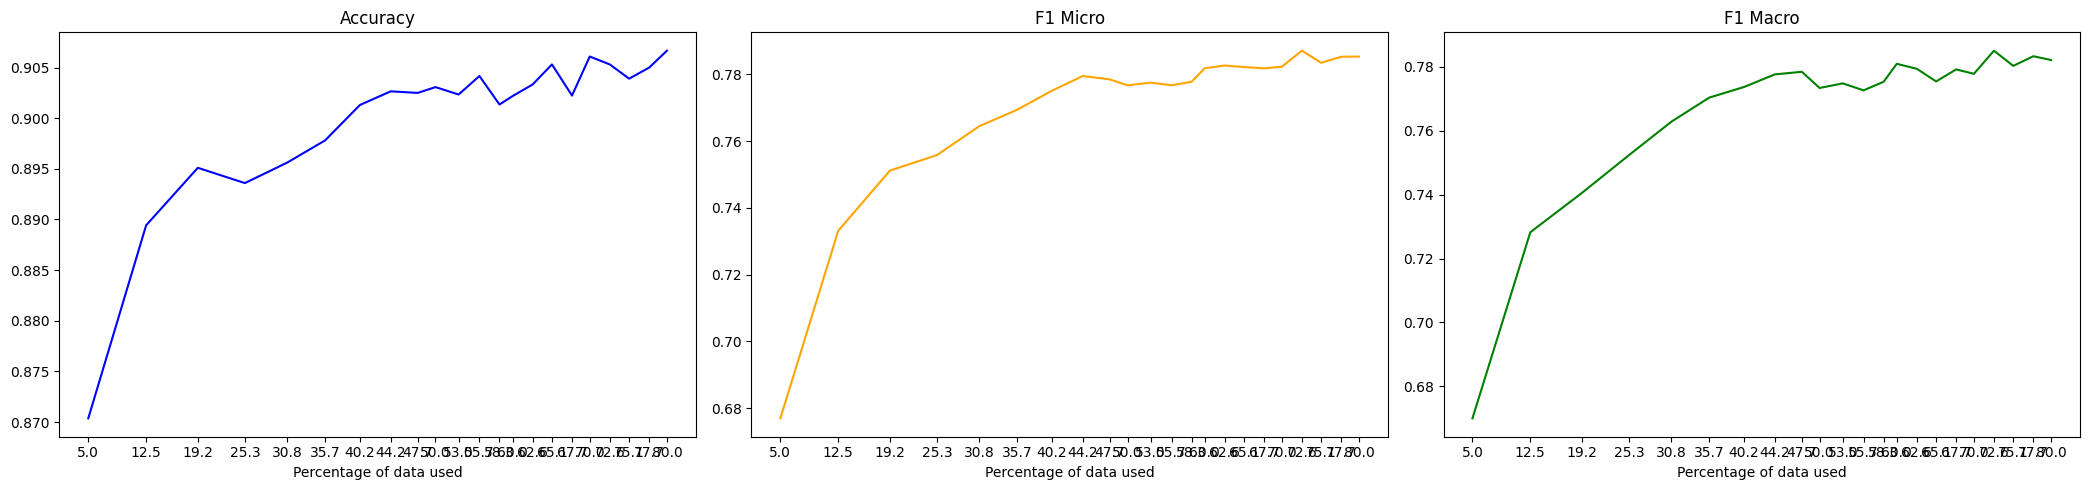

In [ ]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: [3, 44, 85]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6257, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4449, Accuracy: 0.7873, F1 Micro: 0.0058, F1 Macro: 0.0053
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3901, Accuracy: 0.8056, F1 Micro: 0.1629, F1 Macro: 0.1232
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3715, Accuracy: 0.8298, F1 Micro: 0.3702, F1 Macro: 0.2792
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3107, Accuracy: 0.8478, F1 Micro: 0.5173, F1 Macro: 0.4639
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.269, Accuracy: 0.858, F1 Micro: 0.5821, F1 Macro: 0.5628
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2396, Accuracy: 0.8644, F1 Micro: 0.6341, F1 Macro: 0.6306
Epoch 8/10, Train Loss: 0.1893, Accuracy: 0.8645, F1 Micro: 0.6199, F1 Macro: 0.6103
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1519, Accuracy: 0.8764, F1 Micro: 0.68

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.641, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4523, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4045, Accuracy: 0.7945, F1 Micro: 0.0707, F1 Macro: 0.0595
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3985, Accuracy: 0.8206, F1 Micro: 0.2743, F1 Macro: 0.1959
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3282, Accuracy: 0.8359, F1 Micro: 0.4312, F1 Macro: 0.3544
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.291, Accuracy: 0.8492, F1 Micro: 0.5304, F1 Macro: 0.4884
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2575, Accuracy: 0.8558, F1 Micro: 0.5733, F1 Macro: 0.5516
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2031, Accuracy: 0.8644, F1 Micro: 0.6331, F1 Macro: 0.6244
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1705, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5978, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4434, Accuracy: 0.7872, F1 Micro: 0.0044, F1 Macro: 0.004
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3804, Accuracy: 0.8202, F1 Micro: 0.2738, F1 Macro: 0.1854
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3666, Accuracy: 0.8278, F1 Micro: 0.3464, F1 Macro: 0.2469
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3085, Accuracy: 0.8375, F1 Micro: 0.4372, F1 Macro: 0.3739
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2698, Accuracy: 0.8508, F1 Micro: 0.538, F1 Macro: 0.5159
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2493, Accuracy: 0.853, F1 Micro: 0.5597, F1 Macro: 0.5411
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1995, Accuracy: 0.8572, F1 Micro: 0.5981, F1 Macro: 0.5861
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1665, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5544, Accuracy: 0.8134, F1 Micro: 0.2297, F1 Macro: 0.1727
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3967, Accuracy: 0.8547, F1 Micro: 0.5567, F1 Macro: 0.5067
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2916, Accuracy: 0.8684, F1 Micro: 0.6297, F1 Macro: 0.6186
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2382, Accuracy: 0.8808, F1 Micro: 0.6874, F1 Macro: 0.6765
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1917, Accuracy: 0.8828, F1 Micro: 0.7161, F1 Macro: 0.715
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1517, Accuracy: 0.8914, F1 Micro: 0.7252, F1 Macro: 0.7168
Epoch 7/10, Train Loss: 0.113, Accuracy: 0.883, F1 Micro: 0.6979, F1 Macro: 0.6952
Epoch 8/10, Train Loss: 0.0965, Accuracy: 0.8831, F1 Micro: 0.6972, F1 Macro: 0.6938
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0789, Accuracy: 0.8861, F1 Micro: 0.7307, F1 Macro: 0.7267
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5797, Accuracy: 0.7998, F1 Micro: 0.1184, F1 Macro: 0.0921
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4322, Accuracy: 0.842, F1 Micro: 0.4648, F1 Macro: 0.3939
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3212, Accuracy: 0.8592, F1 Micro: 0.576, F1 Macro: 0.544
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2603, Accuracy: 0.8794, F1 Micro: 0.6917, F1 Macro: 0.6859
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2144, Accuracy: 0.8784, F1 Micro: 0.7028, F1 Macro: 0.7021
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1637, Accuracy: 0.8872, F1 Micro: 0.7225, F1 Macro: 0.7186
Epoch 7/10, Train Loss: 0.1262, Accuracy: 0.8795, F1 Micro: 0.674, F1 Macro: 0.6717
Epoch 8/10, Train Loss: 0.1036, Accuracy: 0.8856, F1 Micro: 0.7147, F1 Macro: 0.7127
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0843, Accuracy: 0.8875, F1 Micro: 0.725, F1 Macro: 0.7186
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5286, Accuracy: 0.8189, F1 Micro: 0.2688, F1 Macro: 0.1954
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.396, Accuracy: 0.8478, F1 Micro: 0.5, F1 Macro: 0.461
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3043, Accuracy: 0.8608, F1 Micro: 0.5783, F1 Macro: 0.549
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2409, Accuracy: 0.8798, F1 Micro: 0.7004, F1 Macro: 0.6924
Epoch 5/10, Train Loss: 0.2029, Accuracy: 0.8795, F1 Micro: 0.6836, F1 Macro: 0.6789
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1574, Accuracy: 0.8872, F1 Micro: 0.7225, F1 Macro: 0.7205
Epoch 7/10, Train Loss: 0.1238, Accuracy: 0.8863, F1 Micro: 0.7055, F1 Macro: 0.7034
Epoch 8/10, Train Loss: 0.0941, Accuracy: 0.8866, F1 Micro: 0.7096, F1 Macro: 0.7023
Epoch 9/10, Train Loss: 0.0756, Accuracy: 0.8858, F1 Micro: 0.7146, F1 Macro: 0.7042
Epoch 10/10, Train Loss: 0.0574, Accuracy: 0.8872, F1 Micro: 0.7206, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5124, Accuracy: 0.8325, F1 Micro: 0.3803, F1 Macro: 0.2788
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3359, Accuracy: 0.8747, F1 Micro: 0.6756, F1 Macro: 0.657
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2607, Accuracy: 0.8817, F1 Micro: 0.717, F1 Macro: 0.7109
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2179, Accuracy: 0.8884, F1 Micro: 0.743, F1 Macro: 0.737
Epoch 5/10, Train Loss: 0.1897, Accuracy: 0.8833, F1 Micro: 0.6687, F1 Macro: 0.6469
Epoch 6/10, Train Loss: 0.1449, Accuracy: 0.8922, F1 Micro: 0.742, F1 Macro: 0.7331
Epoch 7/10, Train Loss: 0.1026, Accuracy: 0.8917, F1 Micro: 0.724, F1 Macro: 0.716
Epoch 8/10, Train Loss: 0.0804, Accuracy: 0.8927, F1 Micro: 0.7344, F1 Macro: 0.7235
Epoch 9/10, Train Loss: 0.0614, Accuracy: 0.8906, F1 Micro: 0.7346, F1 Macro: 0.7232
Epoch 10/10, Train Loss: 0.0511, Accuracy: 0.8886, F1 Micro: 0.7276, F1 Macro: 0.7223
Model 1 - Iteration 1496

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5335, Accuracy: 0.8197, F1 Micro: 0.336, F1 Macro: 0.2416
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3638, Accuracy: 0.8636, F1 Micro: 0.6005, F1 Macro: 0.5441
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2773, Accuracy: 0.8827, F1 Micro: 0.7072, F1 Macro: 0.6961
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2282, Accuracy: 0.8889, F1 Micro: 0.7377, F1 Macro: 0.7347
Epoch 5/10, Train Loss: 0.1973, Accuracy: 0.8822, F1 Micro: 0.6643, F1 Macro: 0.6289
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1535, Accuracy: 0.8939, F1 Micro: 0.7464, F1 Macro: 0.7345
Epoch 7/10, Train Loss: 0.1074, Accuracy: 0.8909, F1 Micro: 0.7075, F1 Macro: 0.6886
Epoch 8/10, Train Loss: 0.0848, Accuracy: 0.8927, F1 Micro: 0.7416, F1 Macro: 0.7317
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0645, Accuracy: 0.8939, F1 Micro: 0.7514, F1 Macro: 0.7438
Epoch 10/10, Train Loss: 0.0549, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5024, Accuracy: 0.8316, F1 Micro: 0.4031, F1 Macro: 0.2721
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3469, Accuracy: 0.8662, F1 Micro: 0.612, F1 Macro: 0.5817
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2704, Accuracy: 0.8798, F1 Micro: 0.7039, F1 Macro: 0.6953
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2192, Accuracy: 0.8891, F1 Micro: 0.7361, F1 Macro: 0.727
Epoch 5/10, Train Loss: 0.185, Accuracy: 0.8839, F1 Micro: 0.6785, F1 Macro: 0.6515
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1491, Accuracy: 0.8895, F1 Micro: 0.7417, F1 Macro: 0.7288
Epoch 7/10, Train Loss: 0.1025, Accuracy: 0.8894, F1 Micro: 0.7117, F1 Macro: 0.693
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0817, Accuracy: 0.8906, F1 Micro: 0.744, F1 Macro: 0.7379
Epoch 9/10, Train Loss: 0.064, Accuracy: 0.8897, F1 Micro: 0.7374, F1 Macro: 0.7238
Epoch 10/10, Train Loss: 0.0614, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4846, Accuracy: 0.8536, F1 Micro: 0.5493, F1 Macro: 0.491
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3193, Accuracy: 0.8786, F1 Micro: 0.6915, F1 Macro: 0.6874
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2516, Accuracy: 0.8905, F1 Micro: 0.7358, F1 Macro: 0.7243
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2194, Accuracy: 0.8891, F1 Micro: 0.7568, F1 Macro: 0.7529
Epoch 5/10, Train Loss: 0.1723, Accuracy: 0.8956, F1 Micro: 0.7472, F1 Macro: 0.7322
Epoch 6/10, Train Loss: 0.1336, Accuracy: 0.8919, F1 Micro: 0.746, F1 Macro: 0.7362
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0981, Accuracy: 0.8988, F1 Micro: 0.7645, F1 Macro: 0.7559
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0776, Accuracy: 0.8983, F1 Micro: 0.7686, F1 Macro: 0.7663
Epoch 9/10, Train Loss: 0.0623, Accuracy: 0.8988, F1 Micro: 0.7607, F1 Macro: 0.7557
Epoch 10/10, Train Loss: 0.048, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5063, Accuracy: 0.8383, F1 Micro: 0.436, F1 Macro: 0.3664
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3386, Accuracy: 0.8763, F1 Micro: 0.6714, F1 Macro: 0.6568
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2599, Accuracy: 0.8889, F1 Micro: 0.7332, F1 Macro: 0.7159
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.227, Accuracy: 0.8888, F1 Micro: 0.7516, F1 Macro: 0.7416
Epoch 5/10, Train Loss: 0.1837, Accuracy: 0.893, F1 Micro: 0.7374, F1 Macro: 0.7193
Epoch 6/10, Train Loss: 0.1392, Accuracy: 0.8959, F1 Micro: 0.7407, F1 Macro: 0.7233
Epoch 7/10, Train Loss: 0.1085, Accuracy: 0.8964, F1 Micro: 0.7374, F1 Macro: 0.7188
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0827, Accuracy: 0.8983, F1 Micro: 0.7581, F1 Macro: 0.752
Epoch 9/10, Train Loss: 0.0631, Accuracy: 0.8973, F1 Micro: 0.752, F1 Macro: 0.7462
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0524, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4754, Accuracy: 0.8395, F1 Micro: 0.4409, F1 Macro: 0.3707
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.323, Accuracy: 0.8722, F1 Micro: 0.6603, F1 Macro: 0.6394
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2524, Accuracy: 0.8889, F1 Micro: 0.7344, F1 Macro: 0.7172
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2202, Accuracy: 0.8867, F1 Micro: 0.7508, F1 Macro: 0.7451
Epoch 5/10, Train Loss: 0.1729, Accuracy: 0.8927, F1 Micro: 0.7409, F1 Macro: 0.73
Epoch 6/10, Train Loss: 0.1337, Accuracy: 0.8969, F1 Micro: 0.7508, F1 Macro: 0.7378
Epoch 7/10, Train Loss: 0.0995, Accuracy: 0.8934, F1 Micro: 0.7315, F1 Macro: 0.7056
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0747, Accuracy: 0.897, F1 Micro: 0.7558, F1 Macro: 0.7529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0586, Accuracy: 0.8956, F1 Micro: 0.7646, F1 Macro: 0.7636
Epoch 10/10, Train Loss: 0.0482, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4752, Accuracy: 0.8511, F1 Micro: 0.515, F1 Macro: 0.4486
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2967, Accuracy: 0.8833, F1 Micro: 0.703, F1 Macro: 0.7012
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2407, Accuracy: 0.8927, F1 Micro: 0.7503, F1 Macro: 0.7398
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2109, Accuracy: 0.8944, F1 Micro: 0.7518, F1 Macro: 0.7479
Epoch 5/10, Train Loss: 0.1571, Accuracy: 0.8923, F1 Micro: 0.7357, F1 Macro: 0.7099
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1255, Accuracy: 0.8975, F1 Micro: 0.7602, F1 Macro: 0.7599
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0961, Accuracy: 0.898, F1 Micro: 0.7642, F1 Macro: 0.7648
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.075, Accuracy: 0.8938, F1 Micro: 0.7676, F1 Macro: 0.769
Epoch 9/10, Train Loss: 0.0599, Accuracy: 0.8967, F1 Micro: 0.7549, F1 Macro: 0.7504
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4973, Accuracy: 0.8456, F1 Micro: 0.4912, F1 Macro: 0.4041
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3197, Accuracy: 0.8792, F1 Micro: 0.697, F1 Macro: 0.696
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.253, Accuracy: 0.8939, F1 Micro: 0.7482, F1 Macro: 0.7394
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2164, Accuracy: 0.8938, F1 Micro: 0.7491, F1 Macro: 0.7372
Epoch 5/10, Train Loss: 0.1631, Accuracy: 0.8942, F1 Micro: 0.7448, F1 Macro: 0.722
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1263, Accuracy: 0.8977, F1 Micro: 0.7635, F1 Macro: 0.764
Epoch 7/10, Train Loss: 0.0981, Accuracy: 0.8967, F1 Micro: 0.7604, F1 Macro: 0.7597
Epoch 8/10, Train Loss: 0.0734, Accuracy: 0.8942, F1 Micro: 0.7629, F1 Macro: 0.7649
Epoch 9/10, Train Loss: 0.0613, Accuracy: 0.8973, F1 Micro: 0.7535, F1 Macro: 0.7532
Epoch 10/10, Train Loss: 0.0453, Accuracy: 0.895, F1 Micro: 0.7395, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4703, Accuracy: 0.8508, F1 Micro: 0.5237, F1 Macro: 0.4773
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3055, Accuracy: 0.8827, F1 Micro: 0.7002, F1 Macro: 0.7001
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2439, Accuracy: 0.8913, F1 Micro: 0.7505, F1 Macro: 0.7436
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2113, Accuracy: 0.8933, F1 Micro: 0.756, F1 Macro: 0.7484
Epoch 5/10, Train Loss: 0.1615, Accuracy: 0.8922, F1 Micro: 0.7332, F1 Macro: 0.7078
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1256, Accuracy: 0.8989, F1 Micro: 0.7601, F1 Macro: 0.7544
Epoch 7/10, Train Loss: 0.0977, Accuracy: 0.8975, F1 Micro: 0.7601, F1 Macro: 0.7578
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0689, Accuracy: 0.8981, F1 Micro: 0.7634, F1 Macro: 0.7585
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0575, Accuracy: 0.8984, F1 Micro: 0.7724, F1 Macro: 0.772
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4504, Accuracy: 0.8608, F1 Micro: 0.5763, F1 Macro: 0.5181
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2879, Accuracy: 0.8834, F1 Micro: 0.7142, F1 Macro: 0.7171
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.239, Accuracy: 0.8878, F1 Micro: 0.736, F1 Macro: 0.7296
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1926, Accuracy: 0.8977, F1 Micro: 0.765, F1 Macro: 0.763
Epoch 5/10, Train Loss: 0.1587, Accuracy: 0.8991, F1 Micro: 0.7625, F1 Macro: 0.7548
Epoch 6/10, Train Loss: 0.1176, Accuracy: 0.8972, F1 Micro: 0.7647, F1 Macro: 0.7651
Epoch 7/10, Train Loss: 0.0912, Accuracy: 0.893, F1 Micro: 0.7572, F1 Macro: 0.7462
Epoch 8/10, Train Loss: 0.0706, Accuracy: 0.8992, F1 Micro: 0.7647, F1 Macro: 0.7646
Epoch 9/10, Train Loss: 0.0493, Accuracy: 0.8981, F1 Micro: 0.7626, F1 Macro: 0.7612
Epoch 10/10, Train Loss: 0.0399, Accuracy: 0.8966, F1 Micro: 0.7545, F1 Macro: 0.7466
Model 1 - Iteration 27

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4756, Accuracy: 0.8534, F1 Micro: 0.5442, F1 Macro: 0.4581
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3, Accuracy: 0.8827, F1 Micro: 0.6978, F1 Macro: 0.6995
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2506, Accuracy: 0.8938, F1 Micro: 0.7434, F1 Macro: 0.731
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.199, Accuracy: 0.898, F1 Micro: 0.767, F1 Macro: 0.7627
Epoch 5/10, Train Loss: 0.1605, Accuracy: 0.898, F1 Micro: 0.7598, F1 Macro: 0.7524
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1198, Accuracy: 0.9008, F1 Micro: 0.7688, F1 Macro: 0.767
Epoch 7/10, Train Loss: 0.0913, Accuracy: 0.8959, F1 Micro: 0.7642, F1 Macro: 0.7609
Epoch 8/10, Train Loss: 0.0672, Accuracy: 0.8969, F1 Micro: 0.765, F1 Macro: 0.7674
Epoch 9/10, Train Loss: 0.0521, Accuracy: 0.8983, F1 Micro: 0.7602, F1 Macro: 0.7563
Epoch 10/10, Train Loss: 0.0456, Accuracy: 0.8983, F1 Micro: 0.7661, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4543, Accuracy: 0.8662, F1 Micro: 0.6148, F1 Macro: 0.5887
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2916, Accuracy: 0.8831, F1 Micro: 0.7119, F1 Macro: 0.7125
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2467, Accuracy: 0.8853, F1 Micro: 0.717, F1 Macro: 0.7029
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1908, Accuracy: 0.8956, F1 Micro: 0.7672, F1 Macro: 0.7662
Epoch 5/10, Train Loss: 0.1592, Accuracy: 0.8906, F1 Micro: 0.7521, F1 Macro: 0.7442
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1172, Accuracy: 0.8991, F1 Micro: 0.7703, F1 Macro: 0.7689
Epoch 7/10, Train Loss: 0.0857, Accuracy: 0.8955, F1 Micro: 0.7556, F1 Macro: 0.7468
Epoch 8/10, Train Loss: 0.064, Accuracy: 0.8975, F1 Micro: 0.7644, F1 Macro: 0.7612
Epoch 9/10, Train Loss: 0.0527, Accuracy: 0.8988, F1 Micro: 0.7632, F1 Macro: 0.7583
Epoch 10/10, Train Loss: 0.0451, Accuracy: 0.8941, F1 Micro: 0.758, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4425, Accuracy: 0.8695, F1 Micro: 0.6261, F1 Macro: 0.6141
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2852, Accuracy: 0.8902, F1 Micro: 0.7503, F1 Macro: 0.739
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2357, Accuracy: 0.8945, F1 Micro: 0.7516, F1 Macro: 0.746
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1894, Accuracy: 0.8998, F1 Micro: 0.77, F1 Macro: 0.7679
Epoch 5/10, Train Loss: 0.1642, Accuracy: 0.8942, F1 Micro: 0.7319, F1 Macro: 0.7158
Epoch 6/10, Train Loss: 0.1199, Accuracy: 0.8981, F1 Micro: 0.7629, F1 Macro: 0.758
Epoch 7/10, Train Loss: 0.0927, Accuracy: 0.8964, F1 Micro: 0.7671, F1 Macro: 0.7689
Epoch 8/10, Train Loss: 0.0713, Accuracy: 0.8988, F1 Micro: 0.7532, F1 Macro: 0.7462
Epoch 9/10, Train Loss: 0.0461, Accuracy: 0.8984, F1 Micro: 0.7693, F1 Macro: 0.7704
Epoch 10/10, Train Loss: 0.0422, Accuracy: 0.8966, F1 Micro: 0.7487, F1 Macro: 0.7381
Model 1 - Iteration 31

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.463, Accuracy: 0.8558, F1 Micro: 0.5415, F1 Macro: 0.4598
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3005, Accuracy: 0.8894, F1 Micro: 0.7384, F1 Macro: 0.7242
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2409, Accuracy: 0.8934, F1 Micro: 0.7463, F1 Macro: 0.7434
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1899, Accuracy: 0.8981, F1 Micro: 0.7553, F1 Macro: 0.7488
Epoch 5/10, Train Loss: 0.1677, Accuracy: 0.8961, F1 Micro: 0.7373, F1 Macro: 0.7228
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.117, Accuracy: 0.8972, F1 Micro: 0.7636, F1 Macro: 0.7576
Epoch 7/10, Train Loss: 0.0937, Accuracy: 0.8913, F1 Micro: 0.7507, F1 Macro: 0.7442
Epoch 8/10, Train Loss: 0.0668, Accuracy: 0.9006, F1 Micro: 0.7576, F1 Macro: 0.7528
Epoch 9/10, Train Loss: 0.0522, Accuracy: 0.8963, F1 Micro: 0.7617, F1 Macro: 0.7621
Epoch 10/10, Train Loss: 0.0445, Accuracy: 0.898, F1 Micro: 0.7539, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4377, Accuracy: 0.8648, F1 Micro: 0.6144, F1 Macro: 0.6016
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2881, Accuracy: 0.8897, F1 Micro: 0.7395, F1 Macro: 0.729
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2355, Accuracy: 0.8922, F1 Micro: 0.7427, F1 Macro: 0.7404
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1865, Accuracy: 0.8983, F1 Micro: 0.7639, F1 Macro: 0.7557
Epoch 5/10, Train Loss: 0.1607, Accuracy: 0.893, F1 Micro: 0.7196, F1 Macro: 0.6956
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1208, Accuracy: 0.8983, F1 Micro: 0.7692, F1 Macro: 0.7625
Epoch 7/10, Train Loss: 0.0897, Accuracy: 0.898, F1 Micro: 0.7604, F1 Macro: 0.7529
Epoch 8/10, Train Loss: 0.0703, Accuracy: 0.8948, F1 Micro: 0.7438, F1 Macro: 0.732
Epoch 9/10, Train Loss: 0.0478, Accuracy: 0.8981, F1 Micro: 0.7643, F1 Macro: 0.764
Epoch 10/10, Train Loss: 0.0417, Accuracy: 0.8998, F1 Micro: 0.7663, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4361, Accuracy: 0.873, F1 Micro: 0.6891, F1 Macro: 0.6859
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.279, Accuracy: 0.8941, F1 Micro: 0.7613, F1 Macro: 0.7527
Epoch 3/10, Train Loss: 0.2337, Accuracy: 0.8983, F1 Micro: 0.7607, F1 Macro: 0.7511
Epoch 4/10, Train Loss: 0.1907, Accuracy: 0.8989, F1 Micro: 0.7578, F1 Macro: 0.7467
Epoch 5/10, Train Loss: 0.1426, Accuracy: 0.9005, F1 Micro: 0.761, F1 Macro: 0.7583
Epoch 6/10, Train Loss: 0.1133, Accuracy: 0.8967, F1 Micro: 0.7597, F1 Macro: 0.7561
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0802, Accuracy: 0.8995, F1 Micro: 0.7628, F1 Macro: 0.7579
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.062, Accuracy: 0.9006, F1 Micro: 0.7643, F1 Macro: 0.7624
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0431, Accuracy: 0.8953, F1 Micro: 0.7656, F1 Macro: 0.7621
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0391, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4549, Accuracy: 0.8711, F1 Micro: 0.6623, F1 Macro: 0.6356
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2881, Accuracy: 0.8905, F1 Micro: 0.7517, F1 Macro: 0.7404
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2363, Accuracy: 0.8994, F1 Micro: 0.7658, F1 Macro: 0.7557
Epoch 4/10, Train Loss: 0.1932, Accuracy: 0.8973, F1 Micro: 0.746, F1 Macro: 0.7282
Epoch 5/10, Train Loss: 0.1433, Accuracy: 0.8967, F1 Micro: 0.747, F1 Macro: 0.7444
Epoch 6/10, Train Loss: 0.1123, Accuracy: 0.9005, F1 Micro: 0.7594, F1 Macro: 0.7531
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0877, Accuracy: 0.9031, F1 Micro: 0.7747, F1 Macro: 0.7698
Epoch 8/10, Train Loss: 0.0617, Accuracy: 0.8988, F1 Micro: 0.7593, F1 Macro: 0.7586
Epoch 9/10, Train Loss: 0.0465, Accuracy: 0.8992, F1 Micro: 0.7677, F1 Macro: 0.7634
Epoch 10/10, Train Loss: 0.0402, Accuracy: 0.8983, F1 Micro: 0.7699, F1 Macro: 0.7665
Model 2 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4359, Accuracy: 0.8681, F1 Micro: 0.6524, F1 Macro: 0.6412
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.284, Accuracy: 0.8922, F1 Micro: 0.7599, F1 Macro: 0.7525
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2379, Accuracy: 0.897, F1 Micro: 0.7634, F1 Macro: 0.756
Epoch 4/10, Train Loss: 0.1909, Accuracy: 0.8969, F1 Micro: 0.749, F1 Macro: 0.7383
Epoch 5/10, Train Loss: 0.1409, Accuracy: 0.8964, F1 Micro: 0.7576, F1 Macro: 0.7526
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1136, Accuracy: 0.9016, F1 Micro: 0.7668, F1 Macro: 0.7605
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0863, Accuracy: 0.9003, F1 Micro: 0.7746, F1 Macro: 0.7704
Epoch 8/10, Train Loss: 0.0656, Accuracy: 0.9011, F1 Micro: 0.7667, F1 Macro: 0.767
Epoch 9/10, Train Loss: 0.0439, Accuracy: 0.8964, F1 Micro: 0.7713, F1 Macro: 0.7672
Epoch 10/10, Train Loss: 0.0393, Accuracy: 0.8966, F1 Micro: 0.7632, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4336, Accuracy: 0.8769, F1 Micro: 0.6917, F1 Macro: 0.6832
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2778, Accuracy: 0.8928, F1 Micro: 0.7581, F1 Macro: 0.7555
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2287, Accuracy: 0.8992, F1 Micro: 0.7642, F1 Macro: 0.7582
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1932, Accuracy: 0.893, F1 Micro: 0.768, F1 Macro: 0.7664
Epoch 5/10, Train Loss: 0.1561, Accuracy: 0.8984, F1 Micro: 0.7659, F1 Macro: 0.7609
Epoch 6/10, Train Loss: 0.1148, Accuracy: 0.8964, F1 Micro: 0.759, F1 Macro: 0.7565
Epoch 7/10, Train Loss: 0.0841, Accuracy: 0.8958, F1 Micro: 0.7414, F1 Macro: 0.7329
Epoch 8/10, Train Loss: 0.0594, Accuracy: 0.9003, F1 Micro: 0.751, F1 Macro: 0.7456
Epoch 9/10, Train Loss: 0.0502, Accuracy: 0.8955, F1 Micro: 0.755, F1 Macro: 0.7505
Epoch 10/10, Train Loss: 0.0418, Accuracy: 0.897, F1 Micro: 0.7575, F1 Macro: 0.755
Model 1 - Iteration 3711

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4526, Accuracy: 0.8683, F1 Micro: 0.6352, F1 Macro: 0.5647
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2876, Accuracy: 0.8927, F1 Micro: 0.7592, F1 Macro: 0.7577
Epoch 3/10, Train Loss: 0.2331, Accuracy: 0.9003, F1 Micro: 0.7591, F1 Macro: 0.7541
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1967, Accuracy: 0.8986, F1 Micro: 0.779, F1 Macro: 0.7776
Epoch 5/10, Train Loss: 0.1554, Accuracy: 0.9011, F1 Micro: 0.7672, F1 Macro: 0.7596
Epoch 6/10, Train Loss: 0.1122, Accuracy: 0.9027, F1 Micro: 0.7546, F1 Macro: 0.7474
Epoch 7/10, Train Loss: 0.0833, Accuracy: 0.9031, F1 Micro: 0.7628, F1 Macro: 0.7603
Epoch 8/10, Train Loss: 0.0587, Accuracy: 0.9014, F1 Micro: 0.7643, F1 Macro: 0.7616
Epoch 9/10, Train Loss: 0.0486, Accuracy: 0.8988, F1 Micro: 0.7705, F1 Macro: 0.7689
Epoch 10/10, Train Loss: 0.0404, Accuracy: 0.9006, F1 Micro: 0.7596, F1 Macro: 0.7583
Model 2 - Iteration 3711: Accuracy: 0.8986, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4329, Accuracy: 0.8728, F1 Micro: 0.686, F1 Macro: 0.6794
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2794, Accuracy: 0.8914, F1 Micro: 0.7564, F1 Macro: 0.7522
Epoch 3/10, Train Loss: 0.2302, Accuracy: 0.8964, F1 Micro: 0.7533, F1 Macro: 0.7452
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1904, Accuracy: 0.8955, F1 Micro: 0.7691, F1 Macro: 0.766
Epoch 5/10, Train Loss: 0.1526, Accuracy: 0.8969, F1 Micro: 0.761, F1 Macro: 0.754
Epoch 6/10, Train Loss: 0.1134, Accuracy: 0.8963, F1 Micro: 0.7468, F1 Macro: 0.7341
Epoch 7/10, Train Loss: 0.0862, Accuracy: 0.8963, F1 Micro: 0.7555, F1 Macro: 0.7526
Epoch 8/10, Train Loss: 0.0591, Accuracy: 0.9009, F1 Micro: 0.7606, F1 Macro: 0.7528
Epoch 9/10, Train Loss: 0.0471, Accuracy: 0.897, F1 Micro: 0.761, F1 Macro: 0.7573
Epoch 10/10, Train Loss: 0.0398, Accuracy: 0.8984, F1 Micro: 0.764, F1 Macro: 0.7603
Model 3 - Iteration 3711: Accuracy: 0.8955, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4205, Accuracy: 0.8781, F1 Micro: 0.7043, F1 Macro: 0.6936
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2688, Accuracy: 0.8927, F1 Micro: 0.7357, F1 Macro: 0.7334
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2246, Accuracy: 0.8984, F1 Micro: 0.7675, F1 Macro: 0.7618
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1722, Accuracy: 0.9033, F1 Micro: 0.7722, F1 Macro: 0.7697
Epoch 5/10, Train Loss: 0.139, Accuracy: 0.8988, F1 Micro: 0.7694, F1 Macro: 0.7687
Epoch 6/10, Train Loss: 0.1023, Accuracy: 0.8908, F1 Micro: 0.7698, F1 Macro: 0.7711
Epoch 7/10, Train Loss: 0.0822, Accuracy: 0.8991, F1 Micro: 0.7708, F1 Macro: 0.7701
Epoch 8/10, Train Loss: 0.0587, Accuracy: 0.9033, F1 Micro: 0.7707, F1 Macro: 0.771
Epoch 9/10, Train Loss: 0.0424, Accuracy: 0.895, F1 Micro: 0.7655, F1 Macro: 0.7634
Epoch 10/10, Train Loss: 0.0341, Accuracy: 0.8972, F1 Micro: 0.7711, F1 Macro: 0.7721
Model 1 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4379, Accuracy: 0.8752, F1 Micro: 0.6593, F1 Macro: 0.6221
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2723, Accuracy: 0.8913, F1 Micro: 0.7366, F1 Macro: 0.7343
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2319, Accuracy: 0.8994, F1 Micro: 0.7638, F1 Macro: 0.7558
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1774, Accuracy: 0.8994, F1 Micro: 0.7801, F1 Macro: 0.7783
Epoch 5/10, Train Loss: 0.1445, Accuracy: 0.8963, F1 Micro: 0.7741, F1 Macro: 0.7733
Epoch 6/10, Train Loss: 0.1099, Accuracy: 0.897, F1 Micro: 0.7791, F1 Macro: 0.7825
Epoch 7/10, Train Loss: 0.0824, Accuracy: 0.8964, F1 Micro: 0.7621, F1 Macro: 0.7606
Epoch 8/10, Train Loss: 0.0593, Accuracy: 0.8978, F1 Micro: 0.7716, F1 Macro: 0.7724
Epoch 9/10, Train Loss: 0.0447, Accuracy: 0.9002, F1 Micro: 0.7696, F1 Macro: 0.7689
Epoch 10/10, Train Loss: 0.0336, Accuracy: 0.9006, F1 Micro: 0.7689, F1 Macro: 0.7674
Model 2 - Iteratio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4199, Accuracy: 0.8717, F1 Micro: 0.6723, F1 Macro: 0.662
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2703, Accuracy: 0.8931, F1 Micro: 0.7518, F1 Macro: 0.7484
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2295, Accuracy: 0.8984, F1 Micro: 0.764, F1 Macro: 0.7561
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1721, Accuracy: 0.9, F1 Micro: 0.781, F1 Macro: 0.7772
Epoch 5/10, Train Loss: 0.1389, Accuracy: 0.8978, F1 Micro: 0.7694, F1 Macro: 0.7645
Epoch 6/10, Train Loss: 0.1012, Accuracy: 0.8977, F1 Micro: 0.7745, F1 Macro: 0.7743
Epoch 7/10, Train Loss: 0.0795, Accuracy: 0.898, F1 Micro: 0.7667, F1 Macro: 0.7638
Epoch 8/10, Train Loss: 0.0588, Accuracy: 0.9014, F1 Micro: 0.7698, F1 Macro: 0.7679
Epoch 9/10, Train Loss: 0.0427, Accuracy: 0.9003, F1 Micro: 0.7647, F1 Macro: 0.7621
Epoch 10/10, Train Loss: 0.0321, Accuracy: 0.8997, F1 Micro: 0.7608, F1 Macro: 0.7564
Model 3 - Iteration 3886

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4129, Accuracy: 0.8747, F1 Micro: 0.671, F1 Macro: 0.6593
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2744, Accuracy: 0.8888, F1 Micro: 0.7147, F1 Macro: 0.7037
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2166, Accuracy: 0.8995, F1 Micro: 0.7737, F1 Macro: 0.7678
Epoch 4/10, Train Loss: 0.1885, Accuracy: 0.8981, F1 Micro: 0.7425, F1 Macro: 0.72
Epoch 5/10, Train Loss: 0.1445, Accuracy: 0.9031, F1 Micro: 0.7731, F1 Macro: 0.773
Epoch 6/10, Train Loss: 0.108, Accuracy: 0.9011, F1 Micro: 0.7674, F1 Macro: 0.7632
Epoch 7/10, Train Loss: 0.0836, Accuracy: 0.9, F1 Micro: 0.7647, F1 Macro: 0.7614
Epoch 8/10, Train Loss: 0.0542, Accuracy: 0.8964, F1 Micro: 0.7678, F1 Macro: 0.769
Epoch 9/10, Train Loss: 0.0473, Accuracy: 0.8978, F1 Micro: 0.7627, F1 Macro: 0.7632
Epoch 10/10, Train Loss: 0.0335, Accuracy: 0.9023, F1 Micro: 0.7632, F1 Macro: 0.7614
Model 1 - Iteration 4120: Accuracy: 0.8995, F1 Micro: 0.773

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4369, Accuracy: 0.8745, F1 Micro: 0.6582, F1 Macro: 0.6515
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2777, Accuracy: 0.8906, F1 Micro: 0.7159, F1 Macro: 0.7023
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2191, Accuracy: 0.9006, F1 Micro: 0.7711, F1 Macro: 0.7601
Epoch 4/10, Train Loss: 0.1921, Accuracy: 0.9005, F1 Micro: 0.7483, F1 Macro: 0.7246
Epoch 5/10, Train Loss: 0.1447, Accuracy: 0.9017, F1 Micro: 0.7607, F1 Macro: 0.7577
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1121, Accuracy: 0.9034, F1 Micro: 0.779, F1 Macro: 0.7754
Epoch 7/10, Train Loss: 0.0824, Accuracy: 0.8973, F1 Micro: 0.7691, F1 Macro: 0.7651
Epoch 8/10, Train Loss: 0.0593, Accuracy: 0.9033, F1 Micro: 0.7771, F1 Macro: 0.771
Epoch 9/10, Train Loss: 0.0467, Accuracy: 0.9013, F1 Micro: 0.7608, F1 Macro: 0.7599
Epoch 10/10, Train Loss: 0.0343, Accuracy: 0.9003, F1 Micro: 0.7695, F1 Macro: 0.7672
Model 2 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4126, Accuracy: 0.8728, F1 Micro: 0.6545, F1 Macro: 0.6382
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2737, Accuracy: 0.8906, F1 Micro: 0.7138, F1 Macro: 0.702
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2155, Accuracy: 0.8967, F1 Micro: 0.7643, F1 Macro: 0.7535
Epoch 4/10, Train Loss: 0.1822, Accuracy: 0.897, F1 Micro: 0.7396, F1 Macro: 0.713
Epoch 5/10, Train Loss: 0.1412, Accuracy: 0.9003, F1 Micro: 0.7637, F1 Macro: 0.7572
Epoch 6/10, Train Loss: 0.1054, Accuracy: 0.8975, F1 Micro: 0.7506, F1 Macro: 0.736
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0807, Accuracy: 0.9011, F1 Micro: 0.7687, F1 Macro: 0.7626
Epoch 8/10, Train Loss: 0.0554, Accuracy: 0.8998, F1 Micro: 0.7646, F1 Macro: 0.7546
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0427, Accuracy: 0.9033, F1 Micro: 0.7768, F1 Macro: 0.7736
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0358, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4089, Accuracy: 0.88, F1 Micro: 0.7098, F1 Macro: 0.7092
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2558, Accuracy: 0.8964, F1 Micro: 0.7676, F1 Macro: 0.7664
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2279, Accuracy: 0.8908, F1 Micro: 0.7725, F1 Macro: 0.7725
Epoch 4/10, Train Loss: 0.1822, Accuracy: 0.9003, F1 Micro: 0.7554, F1 Macro: 0.7428
Epoch 5/10, Train Loss: 0.1459, Accuracy: 0.8988, F1 Micro: 0.7477, F1 Macro: 0.7356
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1012, Accuracy: 0.9013, F1 Micro: 0.7789, F1 Macro: 0.7784
Epoch 7/10, Train Loss: 0.0734, Accuracy: 0.8997, F1 Micro: 0.7751, F1 Macro: 0.7783
Epoch 8/10, Train Loss: 0.0598, Accuracy: 0.8991, F1 Micro: 0.7602, F1 Macro: 0.7583
Epoch 9/10, Train Loss: 0.0457, Accuracy: 0.9014, F1 Micro: 0.7652, F1 Macro: 0.7608
Epoch 10/10, Train Loss: 0.0377, Accuracy: 0.9009, F1 Micro: 0.7667, F1 Macro: 0.7617
Model 1 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4287, Accuracy: 0.8742, F1 Micro: 0.675, F1 Macro: 0.6662
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2582, Accuracy: 0.8952, F1 Micro: 0.7592, F1 Macro: 0.7553
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2281, Accuracy: 0.8925, F1 Micro: 0.7702, F1 Macro: 0.7713
Epoch 4/10, Train Loss: 0.1876, Accuracy: 0.9011, F1 Micro: 0.7618, F1 Macro: 0.7489
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1451, Accuracy: 0.9009, F1 Micro: 0.7713, F1 Macro: 0.7654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1014, Accuracy: 0.8963, F1 Micro: 0.777, F1 Macro: 0.7777
Epoch 7/10, Train Loss: 0.0764, Accuracy: 0.8995, F1 Micro: 0.7745, F1 Macro: 0.7746
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0565, Accuracy: 0.9067, F1 Micro: 0.7811, F1 Macro: 0.7813
Epoch 9/10, Train Loss: 0.0435, Accuracy: 0.9033, F1 Micro: 0.7755, F1 Macro: 0.7702
Epoch 10/10, Train Loss: 0.0316, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4059, Accuracy: 0.875, F1 Micro: 0.6916, F1 Macro: 0.6885
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2549, Accuracy: 0.8916, F1 Micro: 0.7561, F1 Macro: 0.7499
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2251, Accuracy: 0.8908, F1 Micro: 0.7701, F1 Macro: 0.77
Epoch 4/10, Train Loss: 0.1864, Accuracy: 0.9005, F1 Micro: 0.7519, F1 Macro: 0.7341
Epoch 5/10, Train Loss: 0.1448, Accuracy: 0.9009, F1 Micro: 0.7611, F1 Macro: 0.7486
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1038, Accuracy: 0.9009, F1 Micro: 0.7783, F1 Macro: 0.773
Epoch 7/10, Train Loss: 0.0749, Accuracy: 0.8975, F1 Micro: 0.7628, F1 Macro: 0.7567
Epoch 8/10, Train Loss: 0.0564, Accuracy: 0.8988, F1 Micro: 0.7736, F1 Macro: 0.7752
Epoch 9/10, Train Loss: 0.0451, Accuracy: 0.9027, F1 Micro: 0.772, F1 Macro: 0.767
Epoch 10/10, Train Loss: 0.0336, Accuracy: 0.902, F1 Micro: 0.7711, F1 Macro: 0.7649
Model 3 - Iteration 4330

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3984, Accuracy: 0.8822, F1 Micro: 0.7155, F1 Macro: 0.7157
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2632, Accuracy: 0.8973, F1 Micro: 0.7525, F1 Macro: 0.7408
Epoch 3/10, Train Loss: 0.216, Accuracy: 0.8947, F1 Micro: 0.7217, F1 Macro: 0.7051
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1758, Accuracy: 0.8992, F1 Micro: 0.7787, F1 Macro: 0.7767
Epoch 5/10, Train Loss: 0.1445, Accuracy: 0.9027, F1 Micro: 0.7662, F1 Macro: 0.7592
Epoch 6/10, Train Loss: 0.1031, Accuracy: 0.8995, F1 Micro: 0.7567, F1 Macro: 0.7473
Epoch 7/10, Train Loss: 0.0733, Accuracy: 0.9025, F1 Micro: 0.7704, F1 Macro: 0.7678
Epoch 8/10, Train Loss: 0.0578, Accuracy: 0.8997, F1 Micro: 0.7681, F1 Macro: 0.7596
Epoch 9/10, Train Loss: 0.0406, Accuracy: 0.9028, F1 Micro: 0.7733, F1 Macro: 0.7715
Epoch 10/10, Train Loss: 0.0353, Accuracy: 0.902, F1 Micro: 0.7757, F1 Macro: 0.7753
Model 1 - Iteration 4530: Accuracy: 0.8992, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4157, Accuracy: 0.8803, F1 Micro: 0.697, F1 Macro: 0.6991
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2696, Accuracy: 0.8981, F1 Micro: 0.749, F1 Macro: 0.7336
Epoch 3/10, Train Loss: 0.2195, Accuracy: 0.8948, F1 Micro: 0.7252, F1 Macro: 0.7016
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1733, Accuracy: 0.9027, F1 Micro: 0.7807, F1 Macro: 0.7775
Epoch 5/10, Train Loss: 0.1398, Accuracy: 0.8994, F1 Micro: 0.7663, F1 Macro: 0.7611
Epoch 6/10, Train Loss: 0.1, Accuracy: 0.9005, F1 Micro: 0.7509, F1 Macro: 0.7394
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0733, Accuracy: 0.902, F1 Micro: 0.7824, F1 Macro: 0.7814
Epoch 8/10, Train Loss: 0.0542, Accuracy: 0.9017, F1 Micro: 0.7759, F1 Macro: 0.7695
Epoch 9/10, Train Loss: 0.0392, Accuracy: 0.9017, F1 Micro: 0.7727, F1 Macro: 0.7716
Epoch 10/10, Train Loss: 0.0404, Accuracy: 0.902, F1 Micro: 0.7822, F1 Macro: 0.7819
Model 2 - Iteration 4530

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3978, Accuracy: 0.8797, F1 Micro: 0.6935, F1 Macro: 0.6884
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2669, Accuracy: 0.8963, F1 Micro: 0.7509, F1 Macro: 0.7389
Epoch 3/10, Train Loss: 0.2156, Accuracy: 0.8944, F1 Micro: 0.7256, F1 Macro: 0.7079
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1699, Accuracy: 0.8997, F1 Micro: 0.773, F1 Macro: 0.767
Epoch 5/10, Train Loss: 0.1404, Accuracy: 0.8997, F1 Micro: 0.7682, F1 Macro: 0.7585
Epoch 6/10, Train Loss: 0.0969, Accuracy: 0.8991, F1 Micro: 0.7542, F1 Macro: 0.7453
Epoch 7/10, Train Loss: 0.0725, Accuracy: 0.8939, F1 Micro: 0.7728, F1 Macro: 0.7714
Epoch 8/10, Train Loss: 0.0577, Accuracy: 0.9009, F1 Micro: 0.758, F1 Macro: 0.7494
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0411, Accuracy: 0.8995, F1 Micro: 0.7762, F1 Macro: 0.7751
Epoch 10/10, Train Loss: 0.0361, Accuracy: 0.898, F1 Micro: 0.7682, F1 Macro: 0.7665
Model 3 - Iteration 4

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3997, Accuracy: 0.877, F1 Micro: 0.6948, F1 Macro: 0.6905
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2664, Accuracy: 0.8953, F1 Micro: 0.7474, F1 Macro: 0.7313
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2169, Accuracy: 0.8981, F1 Micro: 0.7736, F1 Macro: 0.7721
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1826, Accuracy: 0.9039, F1 Micro: 0.7826, F1 Macro: 0.7807
Epoch 5/10, Train Loss: 0.1378, Accuracy: 0.9013, F1 Micro: 0.7666, F1 Macro: 0.7655
Epoch 6/10, Train Loss: 0.1072, Accuracy: 0.8997, F1 Micro: 0.7626, F1 Macro: 0.7603
Epoch 7/10, Train Loss: 0.0735, Accuracy: 0.9039, F1 Micro: 0.78, F1 Macro: 0.7752
Epoch 8/10, Train Loss: 0.0567, Accuracy: 0.9, F1 Micro: 0.7659, F1 Macro: 0.7593
Epoch 9/10, Train Loss: 0.0436, Accuracy: 0.9011, F1 Micro: 0.7634, F1 Macro: 0.7576
Epoch 10/10, Train Loss: 0.0344, Accuracy: 0.902, F1 Micro: 0.7672, F1 Macro: 0.7609
Model 1 - Iteration 4663

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4206, Accuracy: 0.8777, F1 Micro: 0.6906, F1 Macro: 0.6874
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2687, Accuracy: 0.8986, F1 Micro: 0.7618, F1 Macro: 0.7504
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2204, Accuracy: 0.9017, F1 Micro: 0.7832, F1 Macro: 0.7845
Epoch 4/10, Train Loss: 0.1854, Accuracy: 0.9028, F1 Micro: 0.7816, F1 Macro: 0.7797
Epoch 5/10, Train Loss: 0.1434, Accuracy: 0.9023, F1 Micro: 0.77, F1 Macro: 0.7697
Epoch 6/10, Train Loss: 0.1101, Accuracy: 0.9002, F1 Micro: 0.7568, F1 Macro: 0.749
Epoch 7/10, Train Loss: 0.0757, Accuracy: 0.9025, F1 Micro: 0.7812, F1 Macro: 0.7798
Epoch 8/10, Train Loss: 0.0563, Accuracy: 0.9038, F1 Micro: 0.7724, F1 Macro: 0.7692
Epoch 9/10, Train Loss: 0.0456, Accuracy: 0.903, F1 Micro: 0.7741, F1 Macro: 0.7709
Epoch 10/10, Train Loss: 0.0343, Accuracy: 0.9006, F1 Micro: 0.7773, F1 Macro: 0.777
Model 2 - Iteration 4663: Accuracy: 0.9017, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3994, Accuracy: 0.8783, F1 Micro: 0.7028, F1 Macro: 0.7007
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2637, Accuracy: 0.8953, F1 Micro: 0.7507, F1 Macro: 0.7311
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2134, Accuracy: 0.8983, F1 Micro: 0.7734, F1 Macro: 0.7719
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1788, Accuracy: 0.8998, F1 Micro: 0.781, F1 Macro: 0.7782
Epoch 5/10, Train Loss: 0.1391, Accuracy: 0.8984, F1 Micro: 0.7628, F1 Macro: 0.7625
Epoch 6/10, Train Loss: 0.1056, Accuracy: 0.8997, F1 Micro: 0.7617, F1 Macro: 0.7589
Epoch 7/10, Train Loss: 0.0744, Accuracy: 0.9031, F1 Micro: 0.777, F1 Macro: 0.7725
Epoch 8/10, Train Loss: 0.0565, Accuracy: 0.9009, F1 Micro: 0.7602, F1 Macro: 0.7502
Epoch 9/10, Train Loss: 0.0409, Accuracy: 0.903, F1 Micro: 0.777, F1 Macro: 0.7717
Epoch 10/10, Train Loss: 0.033, Accuracy: 0.9023, F1 Micro: 0.772, F1 Macro: 0.769
Model 3 - Iteration 4663

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3916, Accuracy: 0.8859, F1 Micro: 0.727, F1 Macro: 0.7194
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2572, Accuracy: 0.8961, F1 Micro: 0.7368, F1 Macro: 0.7174
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2145, Accuracy: 0.9023, F1 Micro: 0.7711, F1 Macro: 0.7662
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1758, Accuracy: 0.9023, F1 Micro: 0.7733, F1 Macro: 0.7685
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1332, Accuracy: 0.9036, F1 Micro: 0.7872, F1 Macro: 0.7864
Epoch 6/10, Train Loss: 0.1023, Accuracy: 0.902, F1 Micro: 0.7699, F1 Macro: 0.7723
Epoch 7/10, Train Loss: 0.0742, Accuracy: 0.9006, F1 Micro: 0.7682, F1 Macro: 0.7612
Epoch 8/10, Train Loss: 0.0581, Accuracy: 0.9034, F1 Micro: 0.7673, F1 Macro: 0.7674
Epoch 9/10, Train Loss: 0.0404, Accuracy: 0.9023, F1 Micro: 0.7733, F1 Macro: 0.7724
Epoch 10/10, Train Loss: 0.0348, Accuracy: 0.9053, F1 Micro: 0.774, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4121, Accuracy: 0.8834, F1 Micro: 0.7183, F1 Macro: 0.717
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2633, Accuracy: 0.8955, F1 Micro: 0.7359, F1 Macro: 0.7074
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2177, Accuracy: 0.902, F1 Micro: 0.7707, F1 Macro: 0.7675
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1791, Accuracy: 0.9034, F1 Micro: 0.7791, F1 Macro: 0.7772
Epoch 5/10, Train Loss: 0.1366, Accuracy: 0.9005, F1 Micro: 0.7761, F1 Macro: 0.7747
Epoch 6/10, Train Loss: 0.1008, Accuracy: 0.9011, F1 Micro: 0.7614, F1 Macro: 0.761
Epoch 7/10, Train Loss: 0.0742, Accuracy: 0.8997, F1 Micro: 0.7622, F1 Macro: 0.7575
Epoch 8/10, Train Loss: 0.0604, Accuracy: 0.9006, F1 Micro: 0.7521, F1 Macro: 0.7442
Epoch 9/10, Train Loss: 0.0437, Accuracy: 0.902, F1 Micro: 0.7668, F1 Macro: 0.7573
Epoch 10/10, Train Loss: 0.0373, Accuracy: 0.8995, F1 Micro: 0.7693, F1 Macro: 0.7699
Model 2 - Iteration 4

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3906, Accuracy: 0.8823, F1 Micro: 0.7089, F1 Macro: 0.6988
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2573, Accuracy: 0.8953, F1 Micro: 0.7377, F1 Macro: 0.7134
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2145, Accuracy: 0.9017, F1 Micro: 0.7666, F1 Macro: 0.7594
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1741, Accuracy: 0.9019, F1 Micro: 0.7752, F1 Macro: 0.77
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1361, Accuracy: 0.9052, F1 Micro: 0.7883, F1 Macro: 0.7877
Epoch 6/10, Train Loss: 0.103, Accuracy: 0.9028, F1 Micro: 0.7624, F1 Macro: 0.7588
Epoch 7/10, Train Loss: 0.071, Accuracy: 0.9008, F1 Micro: 0.7715, F1 Macro: 0.7677
Epoch 8/10, Train Loss: 0.0549, Accuracy: 0.8998, F1 Micro: 0.752, F1 Macro: 0.749
Epoch 9/10, Train Loss: 0.0406, Accuracy: 0.9017, F1 Micro: 0.7761, F1 Macro: 0.7748
Epoch 10/10, Train Loss: 0.0364, Accuracy: 0.9014, F1 Micro: 0.7731, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3933, Accuracy: 0.8883, F1 Micro: 0.7301, F1 Macro: 0.7217
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.252, Accuracy: 0.8975, F1 Micro: 0.7498, F1 Macro: 0.7397
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2152, Accuracy: 0.9019, F1 Micro: 0.7686, F1 Macro: 0.7633
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1749, Accuracy: 0.9047, F1 Micro: 0.7727, F1 Macro: 0.7661
Epoch 5/10, Train Loss: 0.1281, Accuracy: 0.9031, F1 Micro: 0.7687, F1 Macro: 0.7642
Epoch 6/10, Train Loss: 0.096, Accuracy: 0.9, F1 Micro: 0.7494, F1 Macro: 0.7373
Epoch 7/10, Train Loss: 0.0716, Accuracy: 0.8945, F1 Micro: 0.7612, F1 Macro: 0.7572
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0556, Accuracy: 0.8997, F1 Micro: 0.7752, F1 Macro: 0.7752
Epoch 9/10, Train Loss: 0.043, Accuracy: 0.9009, F1 Micro: 0.7591, F1 Macro: 0.7535
Epoch 10/10, Train Loss: 0.0359, Accuracy: 0.9013, F1 Micro: 0.7751, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4136, Accuracy: 0.882, F1 Micro: 0.7141, F1 Macro: 0.7107
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2575, Accuracy: 0.8984, F1 Micro: 0.7519, F1 Macro: 0.7415
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2165, Accuracy: 0.9016, F1 Micro: 0.7709, F1 Macro: 0.7652
Epoch 4/10, Train Loss: 0.18, Accuracy: 0.9031, F1 Micro: 0.7687, F1 Macro: 0.764
Epoch 5/10, Train Loss: 0.1311, Accuracy: 0.9016, F1 Micro: 0.7603, F1 Macro: 0.75
Epoch 6/10, Train Loss: 0.0972, Accuracy: 0.9006, F1 Micro: 0.7663, F1 Macro: 0.761
Epoch 7/10, Train Loss: 0.0722, Accuracy: 0.8997, F1 Micro: 0.7692, F1 Macro: 0.7663
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.061, Accuracy: 0.9042, F1 Micro: 0.783, F1 Macro: 0.7818
Epoch 9/10, Train Loss: 0.0417, Accuracy: 0.9011, F1 Micro: 0.7727, F1 Macro: 0.7711
Epoch 10/10, Train Loss: 0.0372, Accuracy: 0.8977, F1 Micro: 0.7753, F1 Macro: 0.7755
Model 2 - Iteration 5063: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3892, Accuracy: 0.8881, F1 Micro: 0.7373, F1 Macro: 0.729
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.258, Accuracy: 0.8975, F1 Micro: 0.7508, F1 Macro: 0.7367
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.214, Accuracy: 0.902, F1 Micro: 0.7665, F1 Macro: 0.7542
Epoch 4/10, Train Loss: 0.1772, Accuracy: 0.9014, F1 Micro: 0.7583, F1 Macro: 0.752
Epoch 5/10, Train Loss: 0.1271, Accuracy: 0.8988, F1 Micro: 0.7513, F1 Macro: 0.7354
Epoch 6/10, Train Loss: 0.0998, Accuracy: 0.9008, F1 Micro: 0.7637, F1 Macro: 0.7538
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0729, Accuracy: 0.9013, F1 Micro: 0.7707, F1 Macro: 0.7667
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.061, Accuracy: 0.8978, F1 Micro: 0.7716, F1 Macro: 0.7706
Epoch 9/10, Train Loss: 0.0455, Accuracy: 0.9008, F1 Micro: 0.7623, F1 Macro: 0.7583
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0351, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3919, Accuracy: 0.8881, F1 Micro: 0.7244, F1 Macro: 0.717
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2564, Accuracy: 0.8983, F1 Micro: 0.7616, F1 Macro: 0.7531
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2085, Accuracy: 0.905, F1 Micro: 0.7711, F1 Macro: 0.7587
Epoch 4/10, Train Loss: 0.1715, Accuracy: 0.902, F1 Micro: 0.7685, F1 Macro: 0.7587
Epoch 5/10, Train Loss: 0.1379, Accuracy: 0.905, F1 Micro: 0.764, F1 Macro: 0.7534
Epoch 6/10, Train Loss: 0.0982, Accuracy: 0.9027, F1 Micro: 0.7662, F1 Macro: 0.7632
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0735, Accuracy: 0.9031, F1 Micro: 0.7737, F1 Macro: 0.7717
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0535, Accuracy: 0.9052, F1 Micro: 0.7797, F1 Macro: 0.778
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0459, Accuracy: 0.9042, F1 Micro: 0.7797, F1 Macro: 0.7765
Epoch 10/10, Train Loss: 0.0322, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.41, Accuracy: 0.8819, F1 Micro: 0.7058, F1 Macro: 0.6994
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2619, Accuracy: 0.8978, F1 Micro: 0.7656, F1 Macro: 0.7541
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.215, Accuracy: 0.9064, F1 Micro: 0.7746, F1 Macro: 0.7645
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1756, Accuracy: 0.9031, F1 Micro: 0.7815, F1 Macro: 0.7752
Epoch 5/10, Train Loss: 0.1379, Accuracy: 0.9058, F1 Micro: 0.768, F1 Macro: 0.7551
Epoch 6/10, Train Loss: 0.0989, Accuracy: 0.9014, F1 Micro: 0.7705, F1 Macro: 0.7614
Epoch 7/10, Train Loss: 0.0757, Accuracy: 0.9009, F1 Micro: 0.7812, F1 Macro: 0.7798
Epoch 8/10, Train Loss: 0.0564, Accuracy: 0.9014, F1 Micro: 0.7718, F1 Macro: 0.7724
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.047, Accuracy: 0.9034, F1 Micro: 0.7829, F1 Macro: 0.7791
Epoch 10/10, Train Loss: 0.0333, Accuracy: 0.9034, F1 Micro: 0.7769, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3941, Accuracy: 0.8841, F1 Micro: 0.7097, F1 Macro: 0.6965
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2579, Accuracy: 0.8963, F1 Micro: 0.7644, F1 Macro: 0.7579
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2119, Accuracy: 0.903, F1 Micro: 0.7673, F1 Macro: 0.7525
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.175, Accuracy: 0.9003, F1 Micro: 0.7744, F1 Macro: 0.7676
Epoch 5/10, Train Loss: 0.1354, Accuracy: 0.9014, F1 Micro: 0.7503, F1 Macro: 0.7307
Epoch 6/10, Train Loss: 0.0991, Accuracy: 0.902, F1 Micro: 0.7593, F1 Macro: 0.7492
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0743, Accuracy: 0.9036, F1 Micro: 0.7767, F1 Macro: 0.775
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0545, Accuracy: 0.9047, F1 Micro: 0.7795, F1 Macro: 0.7791
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0462, Accuracy: 0.9047, F1 Micro: 0.7834, F1 Macro: 0.7795
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3858, Accuracy: 0.8877, F1 Micro: 0.732, F1 Macro: 0.7204
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2581, Accuracy: 0.9008, F1 Micro: 0.7754, F1 Macro: 0.7745
Epoch 3/10, Train Loss: 0.2091, Accuracy: 0.8998, F1 Micro: 0.7611, F1 Macro: 0.7537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1713, Accuracy: 0.9038, F1 Micro: 0.7762, F1 Macro: 0.7708
Epoch 5/10, Train Loss: 0.1325, Accuracy: 0.9011, F1 Micro: 0.7699, F1 Macro: 0.7688
Epoch 6/10, Train Loss: 0.0991, Accuracy: 0.9009, F1 Micro: 0.7719, F1 Macro: 0.7695
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0731, Accuracy: 0.9056, F1 Micro: 0.7799, F1 Macro: 0.7785
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0518, Accuracy: 0.9014, F1 Micro: 0.7807, F1 Macro: 0.7795
Epoch 9/10, Train Loss: 0.0428, Accuracy: 0.9025, F1 Micro: 0.7716, F1 Macro: 0.7644
Epoch 10/10, Train Loss: 0.0342, Accuracy: 0.9017, F1 Micro: 0.7705, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3992, Accuracy: 0.8852, F1 Micro: 0.7152, F1 Macro: 0.6917
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.262, Accuracy: 0.8984, F1 Micro: 0.7682, F1 Macro: 0.7655
Epoch 3/10, Train Loss: 0.2103, Accuracy: 0.9016, F1 Micro: 0.7619, F1 Macro: 0.7496
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1717, Accuracy: 0.905, F1 Micro: 0.7693, F1 Macro: 0.7566
Epoch 5/10, Train Loss: 0.1396, Accuracy: 0.9003, F1 Micro: 0.769, F1 Macro: 0.7653
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0967, Accuracy: 0.9069, F1 Micro: 0.7771, F1 Macro: 0.7724
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0739, Accuracy: 0.8945, F1 Micro: 0.7801, F1 Macro: 0.7816
Epoch 8/10, Train Loss: 0.0589, Accuracy: 0.9042, F1 Micro: 0.7752, F1 Macro: 0.7723
Epoch 9/10, Train Loss: 0.0437, Accuracy: 0.9044, F1 Micro: 0.7661, F1 Macro: 0.7517
Epoch 10/10, Train Loss: 0.0365, Accuracy: 0.9033, F1 Micro: 0.7707, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3853, Accuracy: 0.8861, F1 Micro: 0.7262, F1 Macro: 0.7073
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2577, Accuracy: 0.9013, F1 Micro: 0.768, F1 Macro: 0.7641
Epoch 3/10, Train Loss: 0.208, Accuracy: 0.8986, F1 Micro: 0.7579, F1 Macro: 0.7466
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1709, Accuracy: 0.9033, F1 Micro: 0.7696, F1 Macro: 0.7628
Epoch 5/10, Train Loss: 0.1372, Accuracy: 0.8997, F1 Micro: 0.7652, F1 Macro: 0.7628
Epoch 6/10, Train Loss: 0.0959, Accuracy: 0.9019, F1 Micro: 0.7678, F1 Macro: 0.7635
Epoch 7/10, Train Loss: 0.0737, Accuracy: 0.9019, F1 Micro: 0.7573, F1 Macro: 0.7465
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0536, Accuracy: 0.9056, F1 Micro: 0.7775, F1 Macro: 0.7754
Epoch 9/10, Train Loss: 0.0417, Accuracy: 0.9031, F1 Micro: 0.7659, F1 Macro: 0.7523
Epoch 10/10, Train Loss: 0.0339, Accuracy: 0.9044, F1 Micro: 0.7671, F1 Macro: 0.7599
Model 3 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3819, Accuracy: 0.8856, F1 Micro: 0.7012, F1 Macro: 0.6946
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2558, Accuracy: 0.8989, F1 Micro: 0.7668, F1 Macro: 0.759
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2104, Accuracy: 0.9008, F1 Micro: 0.777, F1 Macro: 0.7709
Epoch 4/10, Train Loss: 0.1753, Accuracy: 0.905, F1 Micro: 0.7723, F1 Macro: 0.7625
Epoch 5/10, Train Loss: 0.1245, Accuracy: 0.9053, F1 Micro: 0.7701, F1 Macro: 0.7643
Epoch 6/10, Train Loss: 0.0917, Accuracy: 0.9025, F1 Micro: 0.7762, F1 Macro: 0.7759
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0694, Accuracy: 0.9022, F1 Micro: 0.7788, F1 Macro: 0.7777
Epoch 8/10, Train Loss: 0.0553, Accuracy: 0.9039, F1 Micro: 0.7578, F1 Macro: 0.7442
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0462, Accuracy: 0.9055, F1 Micro: 0.7794, F1 Macro: 0.7776
Epoch 10/10, Train Loss: 0.032, Accuracy: 0.9027, F1 Micro: 0.7719, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3956, Accuracy: 0.8759, F1 Micro: 0.6545, F1 Macro: 0.6317
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2624, Accuracy: 0.9002, F1 Micro: 0.7599, F1 Macro: 0.7484
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2141, Accuracy: 0.905, F1 Micro: 0.781, F1 Macro: 0.772
Epoch 4/10, Train Loss: 0.178, Accuracy: 0.9078, F1 Micro: 0.772, F1 Macro: 0.7615
Epoch 5/10, Train Loss: 0.126, Accuracy: 0.9047, F1 Micro: 0.7775, F1 Macro: 0.7731
Epoch 6/10, Train Loss: 0.0955, Accuracy: 0.9041, F1 Micro: 0.7766, F1 Macro: 0.7755
Epoch 7/10, Train Loss: 0.0758, Accuracy: 0.9013, F1 Micro: 0.7764, F1 Macro: 0.7769
Epoch 8/10, Train Loss: 0.0557, Accuracy: 0.9023, F1 Micro: 0.7711, F1 Macro: 0.7641
Epoch 9/10, Train Loss: 0.0451, Accuracy: 0.9053, F1 Micro: 0.7756, F1 Macro: 0.7734
Epoch 10/10, Train Loss: 0.0339, Accuracy: 0.9041, F1 Micro: 0.7729, F1 Macro: 0.7655
Model 2 - Iteration 5641: Accuracy: 0.905, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3833, Accuracy: 0.8773, F1 Micro: 0.6597, F1 Macro: 0.6376
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2563, Accuracy: 0.8978, F1 Micro: 0.7596, F1 Macro: 0.751
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2117, Accuracy: 0.9038, F1 Micro: 0.7787, F1 Macro: 0.7713
Epoch 4/10, Train Loss: 0.1699, Accuracy: 0.9033, F1 Micro: 0.7653, F1 Macro: 0.754
Epoch 5/10, Train Loss: 0.1231, Accuracy: 0.9027, F1 Micro: 0.7627, F1 Macro: 0.7533
Epoch 6/10, Train Loss: 0.0913, Accuracy: 0.9028, F1 Micro: 0.7769, F1 Macro: 0.7741
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0713, Accuracy: 0.9036, F1 Micro: 0.781, F1 Macro: 0.7787
Epoch 8/10, Train Loss: 0.0575, Accuracy: 0.9036, F1 Micro: 0.7705, F1 Macro: 0.7626
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0438, Accuracy: 0.9055, F1 Micro: 0.7849, F1 Macro: 0.7854
Epoch 10/10, Train Loss: 0.0327, Accuracy: 0.9038, F1 Micro: 0.7757, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.376, Accuracy: 0.8883, F1 Micro: 0.7299, F1 Macro: 0.7192
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.252, Accuracy: 0.8978, F1 Micro: 0.7642, F1 Macro: 0.7643
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2014, Accuracy: 0.9055, F1 Micro: 0.775, F1 Macro: 0.7726
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1675, Accuracy: 0.9017, F1 Micro: 0.7881, F1 Macro: 0.7875
Epoch 5/10, Train Loss: 0.1328, Accuracy: 0.9017, F1 Micro: 0.7803, F1 Macro: 0.7759
Epoch 6/10, Train Loss: 0.0933, Accuracy: 0.903, F1 Micro: 0.78, F1 Macro: 0.7789
Epoch 7/10, Train Loss: 0.0732, Accuracy: 0.9062, F1 Micro: 0.7825, F1 Macro: 0.7834
Epoch 8/10, Train Loss: 0.0557, Accuracy: 0.9041, F1 Micro: 0.7748, F1 Macro: 0.7707
Epoch 9/10, Train Loss: 0.0362, Accuracy: 0.9073, F1 Micro: 0.7851, F1 Macro: 0.7814
Epoch 10/10, Train Loss: 0.0299, Accuracy: 0.9023, F1 Micro: 0.7799, F1 Macro: 0.7781
Model 1 - Iteration 584

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3926, Accuracy: 0.888, F1 Micro: 0.7231, F1 Macro: 0.7149
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2551, Accuracy: 0.8997, F1 Micro: 0.764, F1 Macro: 0.7646
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2064, Accuracy: 0.9058, F1 Micro: 0.7867, F1 Macro: 0.7857
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1707, Accuracy: 0.9052, F1 Micro: 0.7902, F1 Macro: 0.7879
Epoch 5/10, Train Loss: 0.1307, Accuracy: 0.9034, F1 Micro: 0.7881, F1 Macro: 0.7849
Epoch 6/10, Train Loss: 0.0968, Accuracy: 0.9072, F1 Micro: 0.7872, F1 Macro: 0.7807
Epoch 7/10, Train Loss: 0.0703, Accuracy: 0.9059, F1 Micro: 0.7782, F1 Macro: 0.7752
Epoch 8/10, Train Loss: 0.0532, Accuracy: 0.9061, F1 Micro: 0.7814, F1 Macro: 0.7761
Epoch 9/10, Train Loss: 0.0356, Accuracy: 0.9067, F1 Micro: 0.7855, F1 Macro: 0.781
Epoch 10/10, Train Loss: 0.0317, Accuracy: 0.9023, F1 Micro: 0.7789, F1 Macro: 0.7748
Model 2 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.38, Accuracy: 0.8883, F1 Micro: 0.7223, F1 Macro: 0.7108
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2529, Accuracy: 0.8994, F1 Micro: 0.7658, F1 Macro: 0.7648
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2016, Accuracy: 0.9059, F1 Micro: 0.782, F1 Macro: 0.7793
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1636, Accuracy: 0.9039, F1 Micro: 0.7879, F1 Macro: 0.786
Epoch 5/10, Train Loss: 0.1269, Accuracy: 0.9019, F1 Micro: 0.7806, F1 Macro: 0.7756
Epoch 6/10, Train Loss: 0.0906, Accuracy: 0.9031, F1 Micro: 0.7768, F1 Macro: 0.7732
Epoch 7/10, Train Loss: 0.0677, Accuracy: 0.9058, F1 Micro: 0.7732, F1 Macro: 0.7673
Epoch 8/10, Train Loss: 0.0534, Accuracy: 0.9053, F1 Micro: 0.7783, F1 Macro: 0.7741
Epoch 9/10, Train Loss: 0.0383, Accuracy: 0.9038, F1 Micro: 0.7842, F1 Macro: 0.7832
Epoch 10/10, Train Loss: 0.0315, Accuracy: 0.9058, F1 Micro: 0.7784, F1 Macro: 0.7721
Model 3 - Iteration 5

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3676, Accuracy: 0.8923, F1 Micro: 0.7353, F1 Macro: 0.7243
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.241, Accuracy: 0.9025, F1 Micro: 0.7557, F1 Macro: 0.7433
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1972, Accuracy: 0.905, F1 Micro: 0.7805, F1 Macro: 0.7767
Epoch 4/10, Train Loss: 0.1544, Accuracy: 0.9045, F1 Micro: 0.7724, F1 Macro: 0.7595
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1228, Accuracy: 0.9091, F1 Micro: 0.783, F1 Macro: 0.7815
Epoch 6/10, Train Loss: 0.0926, Accuracy: 0.9036, F1 Micro: 0.7727, F1 Macro: 0.7684
Epoch 7/10, Train Loss: 0.0665, Accuracy: 0.9052, F1 Micro: 0.779, F1 Macro: 0.7755
Epoch 8/10, Train Loss: 0.0501, Accuracy: 0.9052, F1 Micro: 0.7763, F1 Macro: 0.7744
Epoch 9/10, Train Loss: 0.0395, Accuracy: 0.9039, F1 Micro: 0.7675, F1 Macro: 0.7653
Epoch 10/10, Train Loss: 0.0292, Accuracy: 0.9033, F1 Micro: 0.7779, F1 Macro: 0.7743
Model 1 - Iteration 6

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.386, Accuracy: 0.8906, F1 Micro: 0.7159, F1 Macro: 0.7071
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2468, Accuracy: 0.898, F1 Micro: 0.7342, F1 Macro: 0.7175
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2013, Accuracy: 0.9059, F1 Micro: 0.772, F1 Macro: 0.7634
Epoch 4/10, Train Loss: 0.1613, Accuracy: 0.9017, F1 Micro: 0.7661, F1 Macro: 0.7522
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.126, Accuracy: 0.9052, F1 Micro: 0.786, F1 Macro: 0.7863
Epoch 6/10, Train Loss: 0.0942, Accuracy: 0.9045, F1 Micro: 0.7719, F1 Macro: 0.7653
Epoch 7/10, Train Loss: 0.066, Accuracy: 0.9016, F1 Micro: 0.7603, F1 Macro: 0.755
Epoch 8/10, Train Loss: 0.0524, Accuracy: 0.9022, F1 Micro: 0.7715, F1 Macro: 0.7676
Epoch 9/10, Train Loss: 0.04, Accuracy: 0.9027, F1 Micro: 0.7784, F1 Macro: 0.777
Epoch 10/10, Train Loss: 0.0328, Accuracy: 0.9027, F1 Micro: 0.7739, F1 Macro: 0.7658
Model 2 - Iteration 6041: A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.37, Accuracy: 0.8909, F1 Micro: 0.7338, F1 Macro: 0.7218
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2409, Accuracy: 0.8998, F1 Micro: 0.7469, F1 Macro: 0.7335
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1967, Accuracy: 0.9064, F1 Micro: 0.7737, F1 Macro: 0.7675
Epoch 4/10, Train Loss: 0.1559, Accuracy: 0.9034, F1 Micro: 0.7735, F1 Macro: 0.7615
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1219, Accuracy: 0.905, F1 Micro: 0.7813, F1 Macro: 0.7791
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0929, Accuracy: 0.9052, F1 Micro: 0.7845, F1 Macro: 0.7812
Epoch 7/10, Train Loss: 0.065, Accuracy: 0.905, F1 Micro: 0.769, F1 Macro: 0.7593
Epoch 8/10, Train Loss: 0.0515, Accuracy: 0.9033, F1 Micro: 0.7679, F1 Macro: 0.7635
Epoch 9/10, Train Loss: 0.0377, Accuracy: 0.9039, F1 Micro: 0.7703, F1 Macro: 0.7669
Epoch 10/10, Train Loss: 0.0308, Accuracy: 0.9072, F1 Micro: 0.7831, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3618, Accuracy: 0.8797, F1 Micro: 0.6559, F1 Macro: 0.6245
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2306, Accuracy: 0.8978, F1 Micro: 0.7322, F1 Macro: 0.7203
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1918, Accuracy: 0.9005, F1 Micro: 0.7724, F1 Macro: 0.7666
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1568, Accuracy: 0.8994, F1 Micro: 0.7788, F1 Macro: 0.7782
Epoch 5/10, Train Loss: 0.1263, Accuracy: 0.9009, F1 Micro: 0.7645, F1 Macro: 0.7559
Epoch 6/10, Train Loss: 0.0889, Accuracy: 0.9027, F1 Micro: 0.7742, F1 Macro: 0.771
Epoch 7/10, Train Loss: 0.0667, Accuracy: 0.8981, F1 Micro: 0.7651, F1 Macro: 0.7609
Epoch 8/10, Train Loss: 0.0481, Accuracy: 0.8972, F1 Micro: 0.7683, F1 Macro: 0.7677
Epoch 9/10, Train Loss: 0.0337, Accuracy: 0.8997, F1 Micro: 0.7719, F1 Macro: 0.7674
Epoch 10/10, Train Loss: 0.0287, Accuracy: 0.9009, F1 Micro: 0.7772, F1 Macro: 0.7774
Model 1 - Iteratio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3775, Accuracy: 0.8822, F1 Micro: 0.6736, F1 Macro: 0.6412
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2337, Accuracy: 0.8959, F1 Micro: 0.7195, F1 Macro: 0.7031
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1949, Accuracy: 0.9003, F1 Micro: 0.7746, F1 Macro: 0.7699
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1549, Accuracy: 0.8984, F1 Micro: 0.7786, F1 Macro: 0.7761
Epoch 5/10, Train Loss: 0.1235, Accuracy: 0.9038, F1 Micro: 0.7732, F1 Macro: 0.7668
Epoch 6/10, Train Loss: 0.0887, Accuracy: 0.9053, F1 Micro: 0.7691, F1 Macro: 0.7564
Epoch 7/10, Train Loss: 0.068, Accuracy: 0.9047, F1 Micro: 0.7659, F1 Macro: 0.7559
Epoch 8/10, Train Loss: 0.0495, Accuracy: 0.9044, F1 Micro: 0.7699, F1 Macro: 0.767
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0374, Accuracy: 0.9045, F1 Micro: 0.7805, F1 Macro: 0.7757
Epoch 10/10, Train Loss: 0.0283, Accuracy: 0.9013, F1 Micro: 0.7773, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3645, Accuracy: 0.8814, F1 Micro: 0.6749, F1 Macro: 0.6426
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2297, Accuracy: 0.8975, F1 Micro: 0.7314, F1 Macro: 0.7152
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1934, Accuracy: 0.8997, F1 Micro: 0.772, F1 Macro: 0.7682
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1511, Accuracy: 0.9019, F1 Micro: 0.7765, F1 Macro: 0.7732
Epoch 5/10, Train Loss: 0.1211, Accuracy: 0.8966, F1 Micro: 0.7564, F1 Macro: 0.7513
Epoch 6/10, Train Loss: 0.089, Accuracy: 0.9031, F1 Micro: 0.7749, F1 Macro: 0.7705
Epoch 7/10, Train Loss: 0.0641, Accuracy: 0.8983, F1 Micro: 0.7639, F1 Macro: 0.7572
Epoch 8/10, Train Loss: 0.0478, Accuracy: 0.9008, F1 Micro: 0.759, F1 Macro: 0.7527
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0366, Accuracy: 0.9009, F1 Micro: 0.7774, F1 Macro: 0.7715
Epoch 10/10, Train Loss: 0.0277, Accuracy: 0.902, F1 Micro: 0.7702, F1 Ma

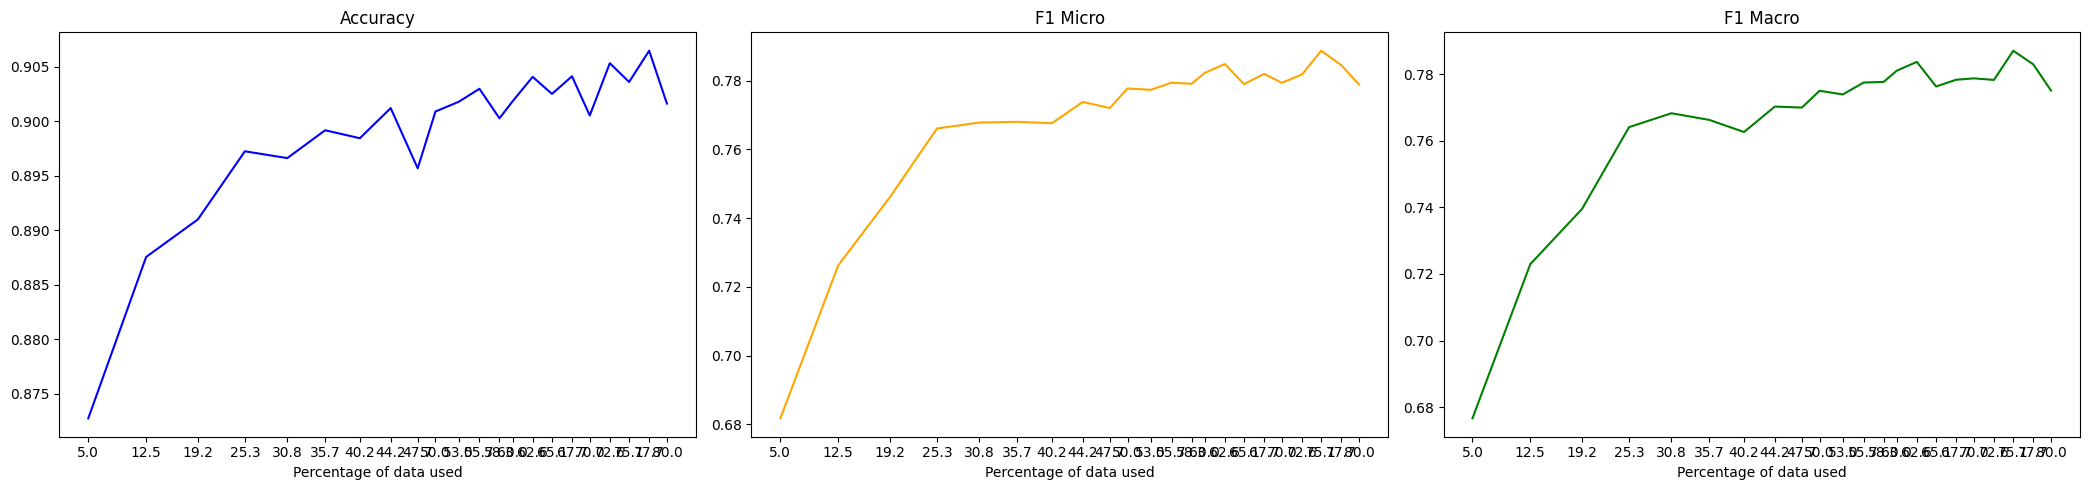

In [ ]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: [94, 21, 5]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5781, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.432, Accuracy: 0.788, F1 Micro: 0.0117, F1 Macro: 0.0106
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3729, Accuracy: 0.8223, F1 Micro: 0.2889, F1 Macro: 0.2126
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3601, Accuracy: 0.83, F1 Micro: 0.3747, F1 Macro: 0.2926
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2934, Accuracy: 0.8384, F1 Micro: 0.4405, F1 Macro: 0.3659
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2592, Accuracy: 0.8566, F1 Micro: 0.5816, F1 Macro: 0.5611
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2344, Accuracy: 0.8592, F1 Micro: 0.588, F1 Macro: 0.5698
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1829, Accuracy: 0.8694, F1 Micro: 0.6384, F1 Macro: 0.6256
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1544, Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5897, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4473, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3959, Accuracy: 0.8066, F1 Micro: 0.1702, F1 Macro: 0.1278
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3926, Accuracy: 0.8258, F1 Micro: 0.3197, F1 Macro: 0.2231
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3251, Accuracy: 0.8391, F1 Micro: 0.4372, F1 Macro: 0.3627
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2762, Accuracy: 0.8562, F1 Micro: 0.5611, F1 Macro: 0.5364
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2538, Accuracy: 0.8605, F1 Micro: 0.6061, F1 Macro: 0.5933
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1942, Accuracy: 0.8698, F1 Micro: 0.6481, F1 Macro: 0.6419
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1598, Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5583, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.43, Accuracy: 0.7978, F1 Micro: 0.0989, F1 Macro: 0.0805
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.363, Accuracy: 0.8225, F1 Micro: 0.2996, F1 Macro: 0.2036
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3502, Accuracy: 0.8367, F1 Micro: 0.4397, F1 Macro: 0.3464
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2882, Accuracy: 0.85, F1 Micro: 0.5289, F1 Macro: 0.4943
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.24, Accuracy: 0.857, F1 Micro: 0.6037, F1 Macro: 0.5962
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2211, Accuracy: 0.8647, F1 Micro: 0.6264, F1 Macro: 0.6114
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1673, Accuracy: 0.867, F1 Micro: 0.6352, F1 Macro: 0.625
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1339, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.537, Accuracy: 0.8175, F1 Micro: 0.2561, F1 Macro: 0.1877
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3734, Accuracy: 0.8433, F1 Micro: 0.4522, F1 Macro: 0.366
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3072, Accuracy: 0.8644, F1 Micro: 0.5985, F1 Macro: 0.5626
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2386, Accuracy: 0.8809, F1 Micro: 0.6885, F1 Macro: 0.6774
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2008, Accuracy: 0.8845, F1 Micro: 0.708, F1 Macro: 0.7003
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.169, Accuracy: 0.8897, F1 Micro: 0.7276, F1 Macro: 0.7207
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1303, Accuracy: 0.892, F1 Micro: 0.7276, F1 Macro: 0.7151
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0964, Accuracy: 0.8877, F1 Micro: 0.7383, F1 Macro: 0.7259
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.08

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5478, Accuracy: 0.8145, F1 Micro: 0.2376, F1 Macro: 0.1772
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3898, Accuracy: 0.8445, F1 Micro: 0.4749, F1 Macro: 0.3673
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3078, Accuracy: 0.8642, F1 Micro: 0.5997, F1 Macro: 0.5737
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2422, Accuracy: 0.8792, F1 Micro: 0.6851, F1 Macro: 0.6683
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1967, Accuracy: 0.8845, F1 Micro: 0.7071, F1 Macro: 0.6958
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1633, Accuracy: 0.8889, F1 Micro: 0.7256, F1 Macro: 0.713
Epoch 7/10, Train Loss: 0.1287, Accuracy: 0.8881, F1 Micro: 0.7174, F1 Macro: 0.7023
Epoch 8/10, Train Loss: 0.0955, Accuracy: 0.8894, F1 Micro: 0.7224, F1 Macro: 0.7014
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0788, Accuracy: 0.8845, F1 Micro: 0.7306, F1 Macro: 0.7196
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5151, Accuracy: 0.8189, F1 Micro: 0.2954, F1 Macro: 0.2167
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3611, Accuracy: 0.852, F1 Micro: 0.5462, F1 Macro: 0.4672
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.292, Accuracy: 0.8691, F1 Micro: 0.6357, F1 Macro: 0.6296
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2304, Accuracy: 0.8778, F1 Micro: 0.6872, F1 Macro: 0.6776
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1954, Accuracy: 0.8847, F1 Micro: 0.7088, F1 Macro: 0.698
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1651, Accuracy: 0.8898, F1 Micro: 0.7243, F1 Macro: 0.7123
Epoch 7/10, Train Loss: 0.1268, Accuracy: 0.8894, F1 Micro: 0.7173, F1 Macro: 0.7007
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0953, Accuracy: 0.8913, F1 Micro: 0.7413, F1 Macro: 0.729
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0849, Accuracy: 0.8867, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4889, Accuracy: 0.8384, F1 Micro: 0.4441, F1 Macro: 0.3492
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3305, Accuracy: 0.8706, F1 Micro: 0.648, F1 Macro: 0.6207
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2661, Accuracy: 0.8817, F1 Micro: 0.7056, F1 Macro: 0.6998
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2066, Accuracy: 0.8877, F1 Micro: 0.7141, F1 Macro: 0.7038
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1671, Accuracy: 0.8884, F1 Micro: 0.7291, F1 Macro: 0.7153
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1333, Accuracy: 0.8905, F1 Micro: 0.7323, F1 Macro: 0.7205
Epoch 7/10, Train Loss: 0.0999, Accuracy: 0.8922, F1 Micro: 0.722, F1 Macro: 0.7093
Epoch 8/10, Train Loss: 0.0904, Accuracy: 0.8886, F1 Micro: 0.7294, F1 Macro: 0.7222
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0714, Accuracy: 0.8909, F1 Micro: 0.7368, F1 Macro: 0.7321
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4999, Accuracy: 0.8278, F1 Micro: 0.3659, F1 Macro: 0.2587
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3346, Accuracy: 0.8763, F1 Micro: 0.6845, F1 Macro: 0.6766
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.26, Accuracy: 0.883, F1 Micro: 0.71, F1 Macro: 0.6979
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2016, Accuracy: 0.887, F1 Micro: 0.7172, F1 Macro: 0.6962
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1665, Accuracy: 0.8859, F1 Micro: 0.7262, F1 Macro: 0.7081
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1323, Accuracy: 0.8956, F1 Micro: 0.7524, F1 Macro: 0.7486
Epoch 7/10, Train Loss: 0.0982, Accuracy: 0.8955, F1 Micro: 0.7369, F1 Macro: 0.7249
Epoch 8/10, Train Loss: 0.0856, Accuracy: 0.8917, F1 Micro: 0.7481, F1 Macro: 0.7393
Epoch 9/10, Train Loss: 0.0723, Accuracy: 0.8916, F1 Micro: 0.7318, F1 Macro: 0.7223
Epoch 10/10, Train Loss: 0.0573, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4712, Accuracy: 0.8331, F1 Micro: 0.4093, F1 Macro: 0.2869
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3227, Accuracy: 0.877, F1 Micro: 0.6856, F1 Macro: 0.6764
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.258, Accuracy: 0.8811, F1 Micro: 0.7116, F1 Macro: 0.7032
Epoch 4/10, Train Loss: 0.2012, Accuracy: 0.8859, F1 Micro: 0.7101, F1 Macro: 0.6912
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1599, Accuracy: 0.8905, F1 Micro: 0.7385, F1 Macro: 0.7303
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1291, Accuracy: 0.8933, F1 Micro: 0.74, F1 Macro: 0.7292
Epoch 7/10, Train Loss: 0.0929, Accuracy: 0.8916, F1 Micro: 0.7312, F1 Macro: 0.718
Epoch 8/10, Train Loss: 0.0828, Accuracy: 0.8881, F1 Micro: 0.7106, F1 Macro: 0.6928
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0695, Accuracy: 0.893, F1 Micro: 0.7492, F1 Macro: 0.7409
Epoch 10/10, Train Loss: 0.0534, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4712, Accuracy: 0.8361, F1 Micro: 0.422, F1 Macro: 0.32
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3265, Accuracy: 0.8777, F1 Micro: 0.717, F1 Macro: 0.7155
Epoch 3/10, Train Loss: 0.2481, Accuracy: 0.8839, F1 Micro: 0.7137, F1 Macro: 0.7147
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2184, Accuracy: 0.8873, F1 Micro: 0.7297, F1 Macro: 0.7185
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1721, Accuracy: 0.8925, F1 Micro: 0.7335, F1 Macro: 0.7284
Epoch 6/10, Train Loss: 0.143, Accuracy: 0.8902, F1 Micro: 0.7055, F1 Macro: 0.6994
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1185, Accuracy: 0.8889, F1 Micro: 0.7344, F1 Macro: 0.7312
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0782, Accuracy: 0.8911, F1 Micro: 0.7492, F1 Macro: 0.7433
Epoch 9/10, Train Loss: 0.0546, Accuracy: 0.8884, F1 Micro: 0.7468, F1 Macro: 0.7449
Epoch 10/10, Train Loss: 0.0512, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4846, Accuracy: 0.8352, F1 Micro: 0.4181, F1 Macro: 0.2992
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3298, Accuracy: 0.8739, F1 Micro: 0.709, F1 Macro: 0.7111
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.248, Accuracy: 0.8856, F1 Micro: 0.7193, F1 Macro: 0.7189
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2168, Accuracy: 0.8881, F1 Micro: 0.732, F1 Macro: 0.7194
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1661, Accuracy: 0.8928, F1 Micro: 0.744, F1 Macro: 0.7355
Epoch 6/10, Train Loss: 0.1427, Accuracy: 0.8969, F1 Micro: 0.7334, F1 Macro: 0.7225
Epoch 7/10, Train Loss: 0.1119, Accuracy: 0.8938, F1 Micro: 0.7399, F1 Macro: 0.7339
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0795, Accuracy: 0.8934, F1 Micro: 0.7482, F1 Macro: 0.7436
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0573, Accuracy: 0.8948, F1 Micro: 0.7482, F1 Macro: 0.7467
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4565, Accuracy: 0.8427, F1 Micro: 0.4817, F1 Macro: 0.3861
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.321, Accuracy: 0.8753, F1 Micro: 0.717, F1 Macro: 0.7137
Epoch 3/10, Train Loss: 0.2465, Accuracy: 0.8825, F1 Micro: 0.7099, F1 Macro: 0.7113
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2166, Accuracy: 0.8906, F1 Micro: 0.739, F1 Macro: 0.7351
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1648, Accuracy: 0.8953, F1 Micro: 0.7452, F1 Macro: 0.7392
Epoch 6/10, Train Loss: 0.1362, Accuracy: 0.8894, F1 Micro: 0.7035, F1 Macro: 0.6903
Epoch 7/10, Train Loss: 0.1058, Accuracy: 0.892, F1 Micro: 0.7382, F1 Macro: 0.7344
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0757, Accuracy: 0.8936, F1 Micro: 0.7523, F1 Macro: 0.7464
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0524, Accuracy: 0.8905, F1 Micro: 0.761, F1 Macro: 0.7623
Epoch 10/10, Train Loss: 0.0505, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4678, Accuracy: 0.8531, F1 Micro: 0.5446, F1 Macro: 0.4532
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2953, Accuracy: 0.8806, F1 Micro: 0.6909, F1 Macro: 0.6905
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2489, Accuracy: 0.8834, F1 Micro: 0.7505, F1 Macro: 0.7441
Epoch 4/10, Train Loss: 0.2046, Accuracy: 0.8933, F1 Micro: 0.7356, F1 Macro: 0.7331
Epoch 5/10, Train Loss: 0.1621, Accuracy: 0.8956, F1 Micro: 0.7504, F1 Macro: 0.7414
Epoch 6/10, Train Loss: 0.1234, Accuracy: 0.8952, F1 Micro: 0.745, F1 Macro: 0.7316
Epoch 7/10, Train Loss: 0.0901, Accuracy: 0.8953, F1 Micro: 0.7397, F1 Macro: 0.7353
Epoch 8/10, Train Loss: 0.0722, Accuracy: 0.8948, F1 Micro: 0.7484, F1 Macro: 0.7444
Epoch 9/10, Train Loss: 0.0654, Accuracy: 0.8953, F1 Micro: 0.7481, F1 Macro: 0.7453
Epoch 10/10, Train Loss: 0.0483, Accuracy: 0.8933, F1 Micro: 0.7356, F1 Macro: 0.7313
Model 1 - Iteration 2394: Accuracy: 0.8834, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4787, Accuracy: 0.8536, F1 Micro: 0.5341, F1 Macro: 0.4501
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2973, Accuracy: 0.882, F1 Micro: 0.7015, F1 Macro: 0.7
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2496, Accuracy: 0.8858, F1 Micro: 0.754, F1 Macro: 0.7502
Epoch 4/10, Train Loss: 0.2047, Accuracy: 0.8945, F1 Micro: 0.735, F1 Macro: 0.7311
Epoch 5/10, Train Loss: 0.1602, Accuracy: 0.8959, F1 Micro: 0.7519, F1 Macro: 0.7413
Epoch 6/10, Train Loss: 0.1275, Accuracy: 0.8961, F1 Micro: 0.7457, F1 Macro: 0.7325
Epoch 7/10, Train Loss: 0.0922, Accuracy: 0.8978, F1 Micro: 0.751, F1 Macro: 0.7487
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0727, Accuracy: 0.8941, F1 Micro: 0.7599, F1 Macro: 0.7542
Epoch 9/10, Train Loss: 0.0615, Accuracy: 0.8906, F1 Micro: 0.7362, F1 Macro: 0.7285
Epoch 10/10, Train Loss: 0.0476, Accuracy: 0.898, F1 Micro: 0.7503, F1 Macro: 0.7394
Model 2 - Iteration 2394:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4568, Accuracy: 0.852, F1 Micro: 0.5423, F1 Macro: 0.4399
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2948, Accuracy: 0.8803, F1 Micro: 0.6991, F1 Macro: 0.6979
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2441, Accuracy: 0.8863, F1 Micro: 0.7525, F1 Macro: 0.744
Epoch 4/10, Train Loss: 0.2032, Accuracy: 0.8942, F1 Micro: 0.7401, F1 Macro: 0.7381
Epoch 5/10, Train Loss: 0.1595, Accuracy: 0.8978, F1 Micro: 0.7465, F1 Macro: 0.7347
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1254, Accuracy: 0.8983, F1 Micro: 0.7554, F1 Macro: 0.7461
Epoch 7/10, Train Loss: 0.0946, Accuracy: 0.8959, F1 Micro: 0.744, F1 Macro: 0.745
Epoch 8/10, Train Loss: 0.0734, Accuracy: 0.8945, F1 Micro: 0.7552, F1 Macro: 0.748
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0564, Accuracy: 0.8959, F1 Micro: 0.7583, F1 Macro: 0.7544
Epoch 10/10, Train Loss: 0.0446, Accuracy: 0.8956, F1 Micro: 0.7454, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4406, Accuracy: 0.8619, F1 Micro: 0.5885, F1 Macro: 0.523
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2835, Accuracy: 0.8878, F1 Micro: 0.7301, F1 Macro: 0.7287
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2411, Accuracy: 0.8864, F1 Micro: 0.7439, F1 Macro: 0.7418
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1881, Accuracy: 0.9025, F1 Micro: 0.7663, F1 Macro: 0.7583
Epoch 5/10, Train Loss: 0.1481, Accuracy: 0.8955, F1 Micro: 0.7655, F1 Macro: 0.7649
Epoch 6/10, Train Loss: 0.1163, Accuracy: 0.8939, F1 Micro: 0.7506, F1 Macro: 0.7347
Epoch 7/10, Train Loss: 0.0854, Accuracy: 0.8956, F1 Micro: 0.7594, F1 Macro: 0.7518
Epoch 8/10, Train Loss: 0.0595, Accuracy: 0.8955, F1 Micro: 0.7527, F1 Macro: 0.7475
Epoch 9/10, Train Loss: 0.0523, Accuracy: 0.8973, F1 Micro: 0.7505, F1 Macro: 0.7419
Epoch 10/10, Train Loss: 0.0402, Accuracy: 0.8963, F1 Micro: 0.7522, F1 Macro: 0.7457
Model 1 - Iteratio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4507, Accuracy: 0.8606, F1 Micro: 0.572, F1 Macro: 0.5096
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2838, Accuracy: 0.8895, F1 Micro: 0.7286, F1 Macro: 0.7229
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2395, Accuracy: 0.8886, F1 Micro: 0.7465, F1 Macro: 0.7399
Epoch 4/10, Train Loss: 0.1909, Accuracy: 0.8975, F1 Micro: 0.7447, F1 Macro: 0.7346
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1521, Accuracy: 0.8983, F1 Micro: 0.7544, F1 Macro: 0.7459
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1169, Accuracy: 0.9008, F1 Micro: 0.7606, F1 Macro: 0.7512
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0876, Accuracy: 0.895, F1 Micro: 0.7652, F1 Macro: 0.7625
Epoch 8/10, Train Loss: 0.066, Accuracy: 0.898, F1 Micro: 0.7605, F1 Macro: 0.7547
Epoch 9/10, Train Loss: 0.0513, Accuracy: 0.8972, F1 Micro: 0.7614, F1 Macro: 0.7527
Epoch 10/10, Train Loss: 0.0375, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4291, Accuracy: 0.8744, F1 Micro: 0.657, F1 Macro: 0.6337
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.281, Accuracy: 0.8886, F1 Micro: 0.7302, F1 Macro: 0.7267
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2391, Accuracy: 0.8905, F1 Micro: 0.7519, F1 Macro: 0.7477
Epoch 4/10, Train Loss: 0.1835, Accuracy: 0.8998, F1 Micro: 0.7485, F1 Macro: 0.7403
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1498, Accuracy: 0.8998, F1 Micro: 0.7637, F1 Macro: 0.7605
Epoch 6/10, Train Loss: 0.1136, Accuracy: 0.8981, F1 Micro: 0.7534, F1 Macro: 0.7399
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0917, Accuracy: 0.8952, F1 Micro: 0.7704, F1 Macro: 0.7689
Epoch 8/10, Train Loss: 0.0646, Accuracy: 0.8964, F1 Micro: 0.7499, F1 Macro: 0.7471
Epoch 9/10, Train Loss: 0.0591, Accuracy: 0.8988, F1 Micro: 0.7586, F1 Macro: 0.7528
Epoch 10/10, Train Loss: 0.0381, Accuracy: 0.9009, F1 Micro: 0.7693, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4397, Accuracy: 0.8723, F1 Micro: 0.6617, F1 Macro: 0.6572
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2807, Accuracy: 0.8797, F1 Micro: 0.7447, F1 Macro: 0.7486
Epoch 3/10, Train Loss: 0.2423, Accuracy: 0.8958, F1 Micro: 0.7404, F1 Macro: 0.7313
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1974, Accuracy: 0.9008, F1 Micro: 0.7671, F1 Macro: 0.759
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1615, Accuracy: 0.8991, F1 Micro: 0.769, F1 Macro: 0.762
Epoch 6/10, Train Loss: 0.1144, Accuracy: 0.9005, F1 Micro: 0.7688, F1 Macro: 0.7639
Epoch 7/10, Train Loss: 0.0948, Accuracy: 0.8978, F1 Micro: 0.7523, F1 Macro: 0.7385
Epoch 8/10, Train Loss: 0.073, Accuracy: 0.8997, F1 Micro: 0.7577, F1 Macro: 0.7502
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0534, Accuracy: 0.9017, F1 Micro: 0.769, F1 Macro: 0.7647
Epoch 10/10, Train Loss: 0.0437, Accuracy: 0.8953, F1 Micro: 0.7656, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4478, Accuracy: 0.8708, F1 Micro: 0.6661, F1 Macro: 0.6657
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.285, Accuracy: 0.8839, F1 Micro: 0.7465, F1 Macro: 0.7529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2424, Accuracy: 0.8981, F1 Micro: 0.7511, F1 Macro: 0.7465
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1959, Accuracy: 0.8995, F1 Micro: 0.764, F1 Macro: 0.7542
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1533, Accuracy: 0.8959, F1 Micro: 0.7711, F1 Macro: 0.7686
Epoch 6/10, Train Loss: 0.1139, Accuracy: 0.9014, F1 Micro: 0.7622, F1 Macro: 0.7553
Epoch 7/10, Train Loss: 0.0924, Accuracy: 0.8989, F1 Micro: 0.7629, F1 Macro: 0.7565
Epoch 8/10, Train Loss: 0.0661, Accuracy: 0.8988, F1 Micro: 0.7605, F1 Macro: 0.751
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0539, Accuracy: 0.9028, F1 Micro: 0.7756, F1 Macro: 0.7709
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4281, Accuracy: 0.8728, F1 Micro: 0.6688, F1 Macro: 0.6678
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2764, Accuracy: 0.882, F1 Micro: 0.7467, F1 Macro: 0.751
Epoch 3/10, Train Loss: 0.2387, Accuracy: 0.8959, F1 Micro: 0.7427, F1 Macro: 0.7368
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1904, Accuracy: 0.9016, F1 Micro: 0.7633, F1 Macro: 0.7534
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1494, Accuracy: 0.8959, F1 Micro: 0.7696, F1 Macro: 0.7686
Epoch 6/10, Train Loss: 0.112, Accuracy: 0.8988, F1 Micro: 0.7621, F1 Macro: 0.7581
Epoch 7/10, Train Loss: 0.0916, Accuracy: 0.8972, F1 Micro: 0.7574, F1 Macro: 0.7522
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0637, Accuracy: 0.9002, F1 Micro: 0.7763, F1 Macro: 0.7766
Epoch 9/10, Train Loss: 0.0554, Accuracy: 0.8989, F1 Micro: 0.767, F1 Macro: 0.7679
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0379, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4221, Accuracy: 0.8805, F1 Micro: 0.6941, F1 Macro: 0.6828
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2836, Accuracy: 0.8902, F1 Micro: 0.712, F1 Macro: 0.7058
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2358, Accuracy: 0.8966, F1 Micro: 0.7631, F1 Macro: 0.7587
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1954, Accuracy: 0.902, F1 Micro: 0.7635, F1 Macro: 0.7564
Epoch 5/10, Train Loss: 0.1496, Accuracy: 0.8977, F1 Micro: 0.7509, F1 Macro: 0.7457
Epoch 6/10, Train Loss: 0.1131, Accuracy: 0.9002, F1 Micro: 0.7528, F1 Macro: 0.7411
Epoch 7/10, Train Loss: 0.0849, Accuracy: 0.8989, F1 Micro: 0.7464, F1 Macro: 0.739
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0654, Accuracy: 0.8981, F1 Micro: 0.7636, F1 Macro: 0.7613
Epoch 9/10, Train Loss: 0.0494, Accuracy: 0.8966, F1 Micro: 0.7506, F1 Macro: 0.7426
Epoch 10/10, Train Loss: 0.0452, Accuracy: 0.8988, F1 Micro: 0.7557, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4336, Accuracy: 0.8753, F1 Micro: 0.7011, F1 Macro: 0.6865
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2874, Accuracy: 0.8922, F1 Micro: 0.7247, F1 Macro: 0.7181
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2319, Accuracy: 0.8994, F1 Micro: 0.769, F1 Macro: 0.7636
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1935, Accuracy: 0.9045, F1 Micro: 0.7728, F1 Macro: 0.7659
Epoch 5/10, Train Loss: 0.1531, Accuracy: 0.9014, F1 Micro: 0.7676, F1 Macro: 0.7637
Epoch 6/10, Train Loss: 0.1087, Accuracy: 0.9005, F1 Micro: 0.7636, F1 Macro: 0.7559
Epoch 7/10, Train Loss: 0.0853, Accuracy: 0.8988, F1 Micro: 0.7418, F1 Macro: 0.7267
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0683, Accuracy: 0.902, F1 Micro: 0.7739, F1 Macro: 0.7713
Epoch 9/10, Train Loss: 0.0487, Accuracy: 0.9014, F1 Micro: 0.7689, F1 Macro: 0.759
Epoch 10/10, Train Loss: 0.0388, Accuracy: 0.9014, F1 Micro: 0.7718, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4112, Accuracy: 0.8741, F1 Micro: 0.7136, F1 Macro: 0.7035
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2787, Accuracy: 0.8936, F1 Micro: 0.7235, F1 Macro: 0.7173
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2341, Accuracy: 0.9003, F1 Micro: 0.7705, F1 Macro: 0.7653
Epoch 4/10, Train Loss: 0.1896, Accuracy: 0.8977, F1 Micro: 0.7624, F1 Macro: 0.76
Epoch 5/10, Train Loss: 0.1508, Accuracy: 0.9008, F1 Micro: 0.7621, F1 Macro: 0.7592
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1079, Accuracy: 0.9, F1 Micro: 0.7716, F1 Macro: 0.7683
Epoch 7/10, Train Loss: 0.0822, Accuracy: 0.8989, F1 Micro: 0.771, F1 Macro: 0.7688
Epoch 8/10, Train Loss: 0.0624, Accuracy: 0.8986, F1 Micro: 0.7611, F1 Macro: 0.7596
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0506, Accuracy: 0.9033, F1 Micro: 0.7781, F1 Macro: 0.777
Epoch 10/10, Train Loss: 0.0413, Accuracy: 0.9005, F1 Micro: 0.7671, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4121, Accuracy: 0.8777, F1 Micro: 0.6892, F1 Macro: 0.6861
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2817, Accuracy: 0.8931, F1 Micro: 0.7405, F1 Macro: 0.7356
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2226, Accuracy: 0.8964, F1 Micro: 0.7413, F1 Macro: 0.7338
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1844, Accuracy: 0.903, F1 Micro: 0.7803, F1 Macro: 0.775
Epoch 5/10, Train Loss: 0.1524, Accuracy: 0.9, F1 Micro: 0.7624, F1 Macro: 0.7555
Epoch 6/10, Train Loss: 0.1141, Accuracy: 0.9009, F1 Micro: 0.7678, F1 Macro: 0.7644
Epoch 7/10, Train Loss: 0.0833, Accuracy: 0.8903, F1 Micro: 0.763, F1 Macro: 0.7605
Epoch 8/10, Train Loss: 0.0614, Accuracy: 0.9, F1 Micro: 0.7603, F1 Macro: 0.7547
Epoch 9/10, Train Loss: 0.0474, Accuracy: 0.902, F1 Micro: 0.7617, F1 Macro: 0.755
Epoch 10/10, Train Loss: 0.0356, Accuracy: 0.9002, F1 Micro: 0.7622, F1 Macro: 0.7581
Model 1 - Iteration 3711: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4268, Accuracy: 0.8755, F1 Micro: 0.6711, F1 Macro: 0.6632
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2786, Accuracy: 0.8995, F1 Micro: 0.7616, F1 Macro: 0.7616
Epoch 3/10, Train Loss: 0.2224, Accuracy: 0.8977, F1 Micro: 0.7507, F1 Macro: 0.7438
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.181, Accuracy: 0.8992, F1 Micro: 0.7769, F1 Macro: 0.773
Epoch 5/10, Train Loss: 0.1519, Accuracy: 0.8995, F1 Micro: 0.7623, F1 Macro: 0.7554
Epoch 6/10, Train Loss: 0.1139, Accuracy: 0.9048, F1 Micro: 0.7749, F1 Macro: 0.769
Epoch 7/10, Train Loss: 0.0859, Accuracy: 0.9003, F1 Micro: 0.7623, F1 Macro: 0.7517
Epoch 8/10, Train Loss: 0.0653, Accuracy: 0.9019, F1 Micro: 0.7741, F1 Macro: 0.7721
Epoch 9/10, Train Loss: 0.0497, Accuracy: 0.9008, F1 Micro: 0.7544, F1 Macro: 0.7469
Epoch 10/10, Train Loss: 0.0368, Accuracy: 0.9, F1 Micro: 0.7721, F1 Macro: 0.7671
Model 2 - Iteration 3711: Accuracy: 0.8992, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4024, Accuracy: 0.8794, F1 Micro: 0.6932, F1 Macro: 0.6875
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2785, Accuracy: 0.8925, F1 Micro: 0.7263, F1 Macro: 0.7219
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2215, Accuracy: 0.9006, F1 Micro: 0.7712, F1 Macro: 0.7675
Epoch 4/10, Train Loss: 0.1852, Accuracy: 0.8997, F1 Micro: 0.7641, F1 Macro: 0.7584
Epoch 5/10, Train Loss: 0.1548, Accuracy: 0.9017, F1 Micro: 0.7652, F1 Macro: 0.7594
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1081, Accuracy: 0.9011, F1 Micro: 0.7745, F1 Macro: 0.7744
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0797, Accuracy: 0.9, F1 Micro: 0.7789, F1 Macro: 0.7772
Epoch 8/10, Train Loss: 0.0643, Accuracy: 0.9047, F1 Micro: 0.7744, F1 Macro: 0.7713
Epoch 9/10, Train Loss: 0.049, Accuracy: 0.9028, F1 Micro: 0.7713, F1 Macro: 0.7662
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0363, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4045, Accuracy: 0.8755, F1 Micro: 0.6661, F1 Macro: 0.6544
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2711, Accuracy: 0.8927, F1 Micro: 0.7367, F1 Macro: 0.732
Epoch 3/10, Train Loss: 0.2244, Accuracy: 0.8945, F1 Micro: 0.7266, F1 Macro: 0.7163
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1819, Accuracy: 0.8959, F1 Micro: 0.7643, F1 Macro: 0.7609
Epoch 5/10, Train Loss: 0.1453, Accuracy: 0.8944, F1 Micro: 0.7526, F1 Macro: 0.7409
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1124, Accuracy: 0.8967, F1 Micro: 0.772, F1 Macro: 0.7662
Epoch 7/10, Train Loss: 0.0779, Accuracy: 0.8986, F1 Micro: 0.7603, F1 Macro: 0.7537
Epoch 8/10, Train Loss: 0.0634, Accuracy: 0.8973, F1 Micro: 0.7619, F1 Macro: 0.7575
Epoch 9/10, Train Loss: 0.0511, Accuracy: 0.8997, F1 Micro: 0.765, F1 Macro: 0.7598
Epoch 10/10, Train Loss: 0.0397, Accuracy: 0.8964, F1 Micro: 0.763, F1 Macro: 0.7624
Model 1 - Iteration 3

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4156, Accuracy: 0.8734, F1 Micro: 0.6547, F1 Macro: 0.6478
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2676, Accuracy: 0.8941, F1 Micro: 0.7388, F1 Macro: 0.7356
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2238, Accuracy: 0.8986, F1 Micro: 0.7417, F1 Macro: 0.7342
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.178, Accuracy: 0.8988, F1 Micro: 0.7633, F1 Macro: 0.7592
Epoch 5/10, Train Loss: 0.1396, Accuracy: 0.8972, F1 Micro: 0.7568, F1 Macro: 0.7449
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1108, Accuracy: 0.898, F1 Micro: 0.7804, F1 Macro: 0.7786
Epoch 7/10, Train Loss: 0.0829, Accuracy: 0.9003, F1 Micro: 0.763, F1 Macro: 0.7568
Epoch 8/10, Train Loss: 0.0674, Accuracy: 0.8978, F1 Micro: 0.758, F1 Macro: 0.7514
Epoch 9/10, Train Loss: 0.0484, Accuracy: 0.9017, F1 Micro: 0.7712, F1 Macro: 0.7654
Epoch 10/10, Train Loss: 0.0364, Accuracy: 0.8989, F1 Micro: 0.769, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3984, Accuracy: 0.8781, F1 Micro: 0.6834, F1 Macro: 0.6803
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2684, Accuracy: 0.8966, F1 Micro: 0.7462, F1 Macro: 0.7431
Epoch 3/10, Train Loss: 0.2224, Accuracy: 0.8959, F1 Micro: 0.7323, F1 Macro: 0.7233
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1796, Accuracy: 0.8998, F1 Micro: 0.7702, F1 Macro: 0.7676
Epoch 5/10, Train Loss: 0.1386, Accuracy: 0.8994, F1 Micro: 0.7665, F1 Macro: 0.759
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1073, Accuracy: 0.8986, F1 Micro: 0.7821, F1 Macro: 0.7822
Epoch 7/10, Train Loss: 0.0817, Accuracy: 0.9014, F1 Micro: 0.775, F1 Macro: 0.7742
Epoch 8/10, Train Loss: 0.0614, Accuracy: 0.9014, F1 Micro: 0.7734, F1 Macro: 0.7709
Epoch 9/10, Train Loss: 0.0504, Accuracy: 0.9022, F1 Micro: 0.7683, F1 Macro: 0.7632
Epoch 10/10, Train Loss: 0.0373, Accuracy: 0.9005, F1 Micro: 0.7747, F1 Macro: 0.7694
Model 3 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.408, Accuracy: 0.88, F1 Micro: 0.7191, F1 Macro: 0.7191
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.278, Accuracy: 0.8978, F1 Micro: 0.7583, F1 Macro: 0.7549
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2205, Accuracy: 0.8989, F1 Micro: 0.7655, F1 Macro: 0.7559
Epoch 4/10, Train Loss: 0.1774, Accuracy: 0.8978, F1 Micro: 0.7423, F1 Macro: 0.7354
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1452, Accuracy: 0.8998, F1 Micro: 0.7678, F1 Macro: 0.759
Epoch 6/10, Train Loss: 0.1075, Accuracy: 0.8983, F1 Micro: 0.7668, F1 Macro: 0.7603
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0797, Accuracy: 0.9025, F1 Micro: 0.7731, F1 Macro: 0.7683
Epoch 8/10, Train Loss: 0.0565, Accuracy: 0.9009, F1 Micro: 0.7598, F1 Macro: 0.7551
Epoch 9/10, Train Loss: 0.0513, Accuracy: 0.8998, F1 Micro: 0.7713, F1 Macro: 0.768
Epoch 10/10, Train Loss: 0.0369, Accuracy: 0.9003, F1 Micro: 0.7703, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4155, Accuracy: 0.8797, F1 Micro: 0.7129, F1 Macro: 0.7138
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2793, Accuracy: 0.8978, F1 Micro: 0.7519, F1 Macro: 0.7472
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2144, Accuracy: 0.8983, F1 Micro: 0.763, F1 Macro: 0.7523
Epoch 4/10, Train Loss: 0.1754, Accuracy: 0.9014, F1 Micro: 0.7459, F1 Macro: 0.7351
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1448, Accuracy: 0.9036, F1 Micro: 0.7777, F1 Macro: 0.774
Epoch 6/10, Train Loss: 0.1076, Accuracy: 0.8978, F1 Micro: 0.7587, F1 Macro: 0.7492
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0814, Accuracy: 0.8967, F1 Micro: 0.7793, F1 Macro: 0.7799
Epoch 8/10, Train Loss: 0.0631, Accuracy: 0.9039, F1 Micro: 0.7694, F1 Macro: 0.7626
Epoch 9/10, Train Loss: 0.0512, Accuracy: 0.9036, F1 Micro: 0.7749, F1 Macro: 0.7673
Epoch 10/10, Train Loss: 0.0408, Accuracy: 0.9, F1 Micro: 0.7542, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3998, Accuracy: 0.8816, F1 Micro: 0.7301, F1 Macro: 0.7271
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2749, Accuracy: 0.8972, F1 Micro: 0.7547, F1 Macro: 0.748
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2163, Accuracy: 0.8995, F1 Micro: 0.7729, F1 Macro: 0.7671
Epoch 4/10, Train Loss: 0.1771, Accuracy: 0.9034, F1 Micro: 0.7641, F1 Macro: 0.7594
Epoch 5/10, Train Loss: 0.1412, Accuracy: 0.9008, F1 Micro: 0.7644, F1 Macro: 0.7556
Epoch 6/10, Train Loss: 0.1127, Accuracy: 0.9002, F1 Micro: 0.7582, F1 Macro: 0.744
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0806, Accuracy: 0.902, F1 Micro: 0.7802, F1 Macro: 0.7775
Epoch 8/10, Train Loss: 0.0602, Accuracy: 0.9038, F1 Micro: 0.7722, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0516, Accuracy: 0.9044, F1 Micro: 0.7806, F1 Macro: 0.7765
Epoch 10/10, Train Loss: 0.0377, Accuracy: 0.9016, F1 Micro: 0.7649, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4024, Accuracy: 0.88, F1 Micro: 0.6891, F1 Macro: 0.6822
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2565, Accuracy: 0.8972, F1 Micro: 0.7628, F1 Macro: 0.7572
Epoch 3/10, Train Loss: 0.2288, Accuracy: 0.9014, F1 Micro: 0.7477, F1 Macro: 0.7313
Epoch 4/10, Train Loss: 0.1803, Accuracy: 0.8992, F1 Micro: 0.7507, F1 Macro: 0.7468
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1402, Accuracy: 0.9022, F1 Micro: 0.7722, F1 Macro: 0.766
Epoch 6/10, Train Loss: 0.101, Accuracy: 0.8989, F1 Micro: 0.7522, F1 Macro: 0.7452
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0813, Accuracy: 0.8981, F1 Micro: 0.7808, F1 Macro: 0.7799
Epoch 8/10, Train Loss: 0.0611, Accuracy: 0.9042, F1 Micro: 0.7786, F1 Macro: 0.7715
Epoch 9/10, Train Loss: 0.0456, Accuracy: 0.9011, F1 Micro: 0.7577, F1 Macro: 0.7548
Epoch 10/10, Train Loss: 0.0365, Accuracy: 0.9002, F1 Micro: 0.773, F1 Macro: 0.7688
Model 1 - Iteration 43

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4113, Accuracy: 0.8811, F1 Micro: 0.696, F1 Macro: 0.694
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2553, Accuracy: 0.9011, F1 Micro: 0.7719, F1 Macro: 0.7666
Epoch 3/10, Train Loss: 0.226, Accuracy: 0.9041, F1 Micro: 0.7571, F1 Macro: 0.7376
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.177, Accuracy: 0.9055, F1 Micro: 0.7763, F1 Macro: 0.7725
Epoch 5/10, Train Loss: 0.1379, Accuracy: 0.9034, F1 Micro: 0.7741, F1 Macro: 0.7696
Epoch 6/10, Train Loss: 0.0982, Accuracy: 0.9019, F1 Micro: 0.7734, F1 Macro: 0.7658
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0766, Accuracy: 0.8964, F1 Micro: 0.7768, F1 Macro: 0.7764
Epoch 8/10, Train Loss: 0.0651, Accuracy: 0.9023, F1 Micro: 0.7751, F1 Macro: 0.7651
Epoch 9/10, Train Loss: 0.047, Accuracy: 0.8997, F1 Micro: 0.7634, F1 Macro: 0.7542
Epoch 10/10, Train Loss: 0.0314, Accuracy: 0.9016, F1 Micro: 0.7637, F1 Macro: 0.7539
Model 2 - Iteration 43

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3971, Accuracy: 0.8828, F1 Micro: 0.699, F1 Macro: 0.6954
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2532, Accuracy: 0.8972, F1 Micro: 0.766, F1 Macro: 0.7602
Epoch 3/10, Train Loss: 0.2238, Accuracy: 0.9014, F1 Micro: 0.7459, F1 Macro: 0.7283
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1776, Accuracy: 0.902, F1 Micro: 0.7691, F1 Macro: 0.7675
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.14, Accuracy: 0.9016, F1 Micro: 0.7719, F1 Macro: 0.7684
Epoch 6/10, Train Loss: 0.1023, Accuracy: 0.9014, F1 Micro: 0.7659, F1 Macro: 0.7603
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0772, Accuracy: 0.8989, F1 Micro: 0.7765, F1 Macro: 0.7755
Epoch 8/10, Train Loss: 0.0681, Accuracy: 0.9039, F1 Micro: 0.7713, F1 Macro: 0.7614
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0464, Accuracy: 0.9033, F1 Micro: 0.7806, F1 Macro: 0.7798
Epoch 10/10, Train Loss: 0.0322, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.405, Accuracy: 0.8802, F1 Micro: 0.7056, F1 Macro: 0.691
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2662, Accuracy: 0.8925, F1 Micro: 0.7283, F1 Macro: 0.7273
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2199, Accuracy: 0.8986, F1 Micro: 0.7738, F1 Macro: 0.766
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.177, Accuracy: 0.8977, F1 Micro: 0.7759, F1 Macro: 0.7755
Epoch 5/10, Train Loss: 0.144, Accuracy: 0.8997, F1 Micro: 0.7604, F1 Macro: 0.7512
Epoch 6/10, Train Loss: 0.1029, Accuracy: 0.897, F1 Micro: 0.7682, F1 Macro: 0.764
Epoch 7/10, Train Loss: 0.0772, Accuracy: 0.8998, F1 Micro: 0.7582, F1 Macro: 0.7473
Epoch 8/10, Train Loss: 0.0545, Accuracy: 0.9011, F1 Micro: 0.7722, F1 Macro: 0.7666
Epoch 9/10, Train Loss: 0.0433, Accuracy: 0.8994, F1 Micro: 0.7672, F1 Macro: 0.761
Epoch 10/10, Train Loss: 0.0349, Accuracy: 0.902, F1 Micro: 0.7749, F1 Macro: 0.7724
Model 1 - Iteration 4530: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4092, Accuracy: 0.8834, F1 Micro: 0.707, F1 Macro: 0.6814
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2649, Accuracy: 0.8975, F1 Micro: 0.7384, F1 Macro: 0.732
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2198, Accuracy: 0.9045, F1 Micro: 0.7822, F1 Macro: 0.7736
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1759, Accuracy: 0.9031, F1 Micro: 0.7844, F1 Macro: 0.7828
Epoch 5/10, Train Loss: 0.1416, Accuracy: 0.8997, F1 Micro: 0.7731, F1 Macro: 0.767
Epoch 6/10, Train Loss: 0.1039, Accuracy: 0.9011, F1 Micro: 0.7714, F1 Macro: 0.7631
Epoch 7/10, Train Loss: 0.0815, Accuracy: 0.9009, F1 Micro: 0.7749, F1 Macro: 0.7678
Epoch 8/10, Train Loss: 0.0567, Accuracy: 0.9013, F1 Micro: 0.7735, F1 Macro: 0.7698
Epoch 9/10, Train Loss: 0.0434, Accuracy: 0.8988, F1 Micro: 0.7762, F1 Macro: 0.7748
Epoch 10/10, Train Loss: 0.0355, Accuracy: 0.8997, F1 Micro: 0.7743, F1 Macro: 0.774
Model 2 - Iteration 4

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3994, Accuracy: 0.8859, F1 Micro: 0.7222, F1 Macro: 0.7038
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2642, Accuracy: 0.8945, F1 Micro: 0.7251, F1 Macro: 0.7225
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2193, Accuracy: 0.8992, F1 Micro: 0.7747, F1 Macro: 0.7662
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1762, Accuracy: 0.9006, F1 Micro: 0.7801, F1 Macro: 0.7798
Epoch 5/10, Train Loss: 0.1422, Accuracy: 0.9036, F1 Micro: 0.7756, F1 Macro: 0.7681
Epoch 6/10, Train Loss: 0.103, Accuracy: 0.9042, F1 Micro: 0.7801, F1 Macro: 0.7753
Epoch 7/10, Train Loss: 0.0793, Accuracy: 0.902, F1 Micro: 0.7713, F1 Macro: 0.763
Epoch 8/10, Train Loss: 0.0547, Accuracy: 0.9003, F1 Micro: 0.7741, F1 Macro: 0.7717
Epoch 9/10, Train Loss: 0.0425, Accuracy: 0.9042, F1 Micro: 0.7781, F1 Macro: 0.7715
Epoch 10/10, Train Loss: 0.0345, Accuracy: 0.9025, F1 Micro: 0.7793, F1 Macro: 0.7804
Model 3 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3965, Accuracy: 0.875, F1 Micro: 0.6708, F1 Macro: 0.6366
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2536, Accuracy: 0.8955, F1 Micro: 0.7346, F1 Macro: 0.7256
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2095, Accuracy: 0.8997, F1 Micro: 0.7736, F1 Macro: 0.7719
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1811, Accuracy: 0.9023, F1 Micro: 0.7805, F1 Macro: 0.7737
Epoch 5/10, Train Loss: 0.1368, Accuracy: 0.8986, F1 Micro: 0.7678, F1 Macro: 0.7617
Epoch 6/10, Train Loss: 0.1115, Accuracy: 0.9033, F1 Micro: 0.7785, F1 Macro: 0.7738
Epoch 7/10, Train Loss: 0.0782, Accuracy: 0.9006, F1 Micro: 0.7741, F1 Macro: 0.771
Epoch 8/10, Train Loss: 0.0593, Accuracy: 0.902, F1 Micro: 0.7668, F1 Macro: 0.7599
Epoch 9/10, Train Loss: 0.0457, Accuracy: 0.9027, F1 Micro: 0.7692, F1 Macro: 0.7653
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0335, Accuracy: 0.9038, F1 Micro: 0.7811, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4078, Accuracy: 0.8748, F1 Micro: 0.6721, F1 Macro: 0.6409
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2557, Accuracy: 0.9013, F1 Micro: 0.7504, F1 Macro: 0.7432
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2114, Accuracy: 0.8986, F1 Micro: 0.7727, F1 Macro: 0.7716
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.179, Accuracy: 0.9047, F1 Micro: 0.7828, F1 Macro: 0.7778
Epoch 5/10, Train Loss: 0.1398, Accuracy: 0.8992, F1 Micro: 0.7769, F1 Macro: 0.7748
Epoch 6/10, Train Loss: 0.1101, Accuracy: 0.9038, F1 Micro: 0.767, F1 Macro: 0.7582
Epoch 7/10, Train Loss: 0.0849, Accuracy: 0.9027, F1 Micro: 0.7799, F1 Macro: 0.7753
Epoch 8/10, Train Loss: 0.0583, Accuracy: 0.9017, F1 Micro: 0.7792, F1 Macro: 0.7749
Epoch 9/10, Train Loss: 0.0453, Accuracy: 0.9045, F1 Micro: 0.7676, F1 Macro: 0.7632
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.034, Accuracy: 0.9042, F1 Micro: 0.7835, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3888, Accuracy: 0.8811, F1 Micro: 0.6828, F1 Macro: 0.6512
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2508, Accuracy: 0.8998, F1 Micro: 0.7441, F1 Macro: 0.7402
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2092, Accuracy: 0.897, F1 Micro: 0.7705, F1 Macro: 0.7693
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1762, Accuracy: 0.9041, F1 Micro: 0.7729, F1 Macro: 0.7636
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.137, Accuracy: 0.8994, F1 Micro: 0.7784, F1 Macro: 0.7787
Epoch 6/10, Train Loss: 0.1108, Accuracy: 0.9039, F1 Micro: 0.7763, F1 Macro: 0.7711
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.075, Accuracy: 0.9023, F1 Micro: 0.7831, F1 Macro: 0.7807
Epoch 8/10, Train Loss: 0.0611, Accuracy: 0.9011, F1 Micro: 0.7794, F1 Macro: 0.7781
Epoch 9/10, Train Loss: 0.0443, Accuracy: 0.9036, F1 Micro: 0.7626, F1 Macro: 0.7602
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3911, Accuracy: 0.882, F1 Micro: 0.713, F1 Macro: 0.7077
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2569, Accuracy: 0.8984, F1 Micro: 0.7521, F1 Macro: 0.7478
Epoch 3/10, Train Loss: 0.2093, Accuracy: 0.9, F1 Micro: 0.748, F1 Macro: 0.74
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1729, Accuracy: 0.9, F1 Micro: 0.7568, F1 Macro: 0.7517
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1397, Accuracy: 0.9041, F1 Micro: 0.7846, F1 Macro: 0.7808
Epoch 6/10, Train Loss: 0.0999, Accuracy: 0.9014, F1 Micro: 0.7684, F1 Macro: 0.7617
Epoch 7/10, Train Loss: 0.0765, Accuracy: 0.902, F1 Micro: 0.7779, F1 Macro: 0.7761
Epoch 8/10, Train Loss: 0.0556, Accuracy: 0.9006, F1 Micro: 0.7595, F1 Macro: 0.751
Epoch 9/10, Train Loss: 0.0443, Accuracy: 0.903, F1 Micro: 0.7696, F1 Macro: 0.7573
Epoch 10/10, Train Loss: 0.0367, Accuracy: 0.9033, F1 Micro: 0.7708, F1 Macro: 0.7654
Model 1 - Iteration 4863: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3968, Accuracy: 0.8864, F1 Micro: 0.7245, F1 Macro: 0.7174
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2544, Accuracy: 0.8998, F1 Micro: 0.7595, F1 Macro: 0.7505
Epoch 3/10, Train Loss: 0.2104, Accuracy: 0.9023, F1 Micro: 0.7586, F1 Macro: 0.7514
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1705, Accuracy: 0.9013, F1 Micro: 0.7595, F1 Macro: 0.7495
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1341, Accuracy: 0.9031, F1 Micro: 0.78, F1 Macro: 0.7771
Epoch 6/10, Train Loss: 0.1026, Accuracy: 0.9048, F1 Micro: 0.7718, F1 Macro: 0.7659
Epoch 7/10, Train Loss: 0.0796, Accuracy: 0.9014, F1 Micro: 0.7594, F1 Macro: 0.7522
Epoch 8/10, Train Loss: 0.0583, Accuracy: 0.9009, F1 Micro: 0.7622, F1 Macro: 0.7556
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.044, Accuracy: 0.9064, F1 Micro: 0.7845, F1 Macro: 0.777
Epoch 10/10, Train Loss: 0.0357, Accuracy: 0.9048, F1 Micro: 0.7699, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3828, Accuracy: 0.8877, F1 Micro: 0.7238, F1 Macro: 0.7135
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2544, Accuracy: 0.9008, F1 Micro: 0.7671, F1 Macro: 0.76
Epoch 3/10, Train Loss: 0.2064, Accuracy: 0.8984, F1 Micro: 0.7477, F1 Macro: 0.7414
Epoch 4/10, Train Loss: 0.1693, Accuracy: 0.9031, F1 Micro: 0.7664, F1 Macro: 0.7633
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1355, Accuracy: 0.903, F1 Micro: 0.7823, F1 Macro: 0.7804
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1001, Accuracy: 0.9044, F1 Micro: 0.7853, F1 Macro: 0.7824
Epoch 7/10, Train Loss: 0.0741, Accuracy: 0.9009, F1 Micro: 0.7768, F1 Macro: 0.7749
Epoch 8/10, Train Loss: 0.0571, Accuracy: 0.9023, F1 Micro: 0.7743, F1 Macro: 0.7706
Epoch 9/10, Train Loss: 0.0409, Accuracy: 0.9052, F1 Micro: 0.7811, F1 Macro: 0.7778
Epoch 10/10, Train Loss: 0.0326, Accuracy: 0.9055, F1 Micro: 0.7802, F1 Macro: 0.773
Model 3 - Iteration 4

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.391, Accuracy: 0.8819, F1 Micro: 0.6929, F1 Macro: 0.6813
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2518, Accuracy: 0.8964, F1 Micro: 0.7429, F1 Macro: 0.7271
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.214, Accuracy: 0.9, F1 Micro: 0.7638, F1 Macro: 0.7605
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1758, Accuracy: 0.9013, F1 Micro: 0.7712, F1 Macro: 0.7641
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1275, Accuracy: 0.9008, F1 Micro: 0.7796, F1 Macro: 0.7784
Epoch 6/10, Train Loss: 0.0999, Accuracy: 0.9031, F1 Micro: 0.7601, F1 Macro: 0.7493
Epoch 7/10, Train Loss: 0.0733, Accuracy: 0.9047, F1 Micro: 0.7791, F1 Macro: 0.7749
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0539, Accuracy: 0.9044, F1 Micro: 0.7827, F1 Macro: 0.7804
Epoch 9/10, Train Loss: 0.0417, Accuracy: 0.9003, F1 Micro: 0.7755, F1 Macro: 0.7736
Epoch 10/10, Train Loss: 0.0313, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3969, Accuracy: 0.887, F1 Micro: 0.7239, F1 Macro: 0.7149
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2486, Accuracy: 0.8988, F1 Micro: 0.7377, F1 Macro: 0.7123
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2152, Accuracy: 0.9055, F1 Micro: 0.7802, F1 Macro: 0.7747
Epoch 4/10, Train Loss: 0.1713, Accuracy: 0.9045, F1 Micro: 0.7736, F1 Macro: 0.768
Epoch 5/10, Train Loss: 0.1225, Accuracy: 0.902, F1 Micro: 0.7791, F1 Macro: 0.7759
Epoch 6/10, Train Loss: 0.0977, Accuracy: 0.9031, F1 Micro: 0.7763, F1 Macro: 0.7745
Epoch 7/10, Train Loss: 0.0709, Accuracy: 0.9033, F1 Micro: 0.7753, F1 Macro: 0.7697
Epoch 8/10, Train Loss: 0.0552, Accuracy: 0.9016, F1 Micro: 0.7729, F1 Macro: 0.7719
Epoch 9/10, Train Loss: 0.0415, Accuracy: 0.8995, F1 Micro: 0.7793, F1 Macro: 0.7821
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0303, Accuracy: 0.9027, F1 Micro: 0.7841, F1 Macro: 0.7847
Model 2 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.384, Accuracy: 0.8878, F1 Micro: 0.7149, F1 Macro: 0.7025
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2477, Accuracy: 0.8998, F1 Micro: 0.7495, F1 Macro: 0.7328
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2132, Accuracy: 0.9034, F1 Micro: 0.7774, F1 Macro: 0.7742
Epoch 4/10, Train Loss: 0.17, Accuracy: 0.9045, F1 Micro: 0.7729, F1 Macro: 0.7707
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1254, Accuracy: 0.8984, F1 Micro: 0.7825, F1 Macro: 0.7842
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.102, Accuracy: 0.907, F1 Micro: 0.7857, F1 Macro: 0.7828
Epoch 7/10, Train Loss: 0.0711, Accuracy: 0.9031, F1 Micro: 0.7726, F1 Macro: 0.769
Epoch 8/10, Train Loss: 0.0524, Accuracy: 0.9067, F1 Micro: 0.783, F1 Macro: 0.7819
Epoch 9/10, Train Loss: 0.0374, Accuracy: 0.9044, F1 Micro: 0.785, F1 Macro: 0.7856
Epoch 10/10, Train Loss: 0.0333, Accuracy: 0.9031, F1 Micro: 0.7809, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3802, Accuracy: 0.8859, F1 Micro: 0.726, F1 Macro: 0.7221
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.257, Accuracy: 0.8967, F1 Micro: 0.7635, F1 Macro: 0.7576
Epoch 3/10, Train Loss: 0.2125, Accuracy: 0.9005, F1 Micro: 0.753, F1 Macro: 0.7382
Epoch 4/10, Train Loss: 0.169, Accuracy: 0.9034, F1 Micro: 0.7607, F1 Macro: 0.7499
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1306, Accuracy: 0.9048, F1 Micro: 0.7711, F1 Macro: 0.7623
Epoch 6/10, Train Loss: 0.1029, Accuracy: 0.9031, F1 Micro: 0.7695, F1 Macro: 0.766
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.074, Accuracy: 0.8964, F1 Micro: 0.773, F1 Macro: 0.7731
Epoch 8/10, Train Loss: 0.0515, Accuracy: 0.9022, F1 Micro: 0.7705, F1 Macro: 0.7689
Epoch 9/10, Train Loss: 0.04, Accuracy: 0.9011, F1 Micro: 0.7672, F1 Macro: 0.7632
Epoch 10/10, Train Loss: 0.0336, Accuracy: 0.8981, F1 Micro: 0.7728, F1 Macro: 0.7716
Model 1 - Iteration 5263: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3879, Accuracy: 0.8905, F1 Micro: 0.7407, F1 Macro: 0.7376
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2571, Accuracy: 0.8994, F1 Micro: 0.7646, F1 Macro: 0.7526
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2129, Accuracy: 0.9069, F1 Micro: 0.7677, F1 Macro: 0.7532
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1719, Accuracy: 0.9059, F1 Micro: 0.7701, F1 Macro: 0.7599
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1307, Accuracy: 0.9062, F1 Micro: 0.7761, F1 Macro: 0.7649
Epoch 6/10, Train Loss: 0.1084, Accuracy: 0.9025, F1 Micro: 0.7689, F1 Macro: 0.7668
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0737, Accuracy: 0.9058, F1 Micro: 0.7802, F1 Macro: 0.7781
Epoch 8/10, Train Loss: 0.0547, Accuracy: 0.903, F1 Micro: 0.7629, F1 Macro: 0.7562
Epoch 9/10, Train Loss: 0.0432, Accuracy: 0.9064, F1 Micro: 0.7718, F1 Macro: 0.761
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3733, Accuracy: 0.8877, F1 Micro: 0.7381, F1 Macro: 0.7318
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2542, Accuracy: 0.8998, F1 Micro: 0.77, F1 Macro: 0.7639
Epoch 3/10, Train Loss: 0.2128, Accuracy: 0.9048, F1 Micro: 0.7618, F1 Macro: 0.751
Epoch 4/10, Train Loss: 0.1699, Accuracy: 0.9042, F1 Micro: 0.7612, F1 Macro: 0.7487
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1343, Accuracy: 0.9069, F1 Micro: 0.7802, F1 Macro: 0.7729
Epoch 6/10, Train Loss: 0.1007, Accuracy: 0.9036, F1 Micro: 0.7802, F1 Macro: 0.777
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0711, Accuracy: 0.9069, F1 Micro: 0.7825, F1 Macro: 0.7797
Epoch 8/10, Train Loss: 0.0547, Accuracy: 0.9042, F1 Micro: 0.7691, F1 Macro: 0.7627
Epoch 9/10, Train Loss: 0.0428, Accuracy: 0.9034, F1 Micro: 0.7796, F1 Macro: 0.7761
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.037, Accuracy: 0.9048, F1 Micro: 0.7877, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3829, Accuracy: 0.8844, F1 Micro: 0.7169, F1 Macro: 0.7061
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2556, Accuracy: 0.8952, F1 Micro: 0.7677, F1 Macro: 0.7655
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.207, Accuracy: 0.8966, F1 Micro: 0.7745, F1 Macro: 0.7742
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1634, Accuracy: 0.9025, F1 Micro: 0.7821, F1 Macro: 0.7812
Epoch 5/10, Train Loss: 0.1254, Accuracy: 0.9022, F1 Micro: 0.7742, F1 Macro: 0.7715
Epoch 6/10, Train Loss: 0.095, Accuracy: 0.9033, F1 Micro: 0.7727, F1 Macro: 0.7695
Epoch 7/10, Train Loss: 0.0677, Accuracy: 0.9036, F1 Micro: 0.7673, F1 Macro: 0.7587
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0515, Accuracy: 0.9048, F1 Micro: 0.7837, F1 Macro: 0.782
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0407, Accuracy: 0.9066, F1 Micro: 0.7888, F1 Macro: 0.7889
Epoch 10/10, Train Loss: 0.0366, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3893, Accuracy: 0.8867, F1 Micro: 0.72, F1 Macro: 0.7063
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.253, Accuracy: 0.8989, F1 Micro: 0.774, F1 Macro: 0.7723
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2063, Accuracy: 0.9003, F1 Micro: 0.7779, F1 Macro: 0.7766
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.161, Accuracy: 0.9056, F1 Micro: 0.7855, F1 Macro: 0.7831
Epoch 5/10, Train Loss: 0.1226, Accuracy: 0.905, F1 Micro: 0.7771, F1 Macro: 0.7728
Epoch 6/10, Train Loss: 0.097, Accuracy: 0.9066, F1 Micro: 0.7821, F1 Macro: 0.7797
Epoch 7/10, Train Loss: 0.0679, Accuracy: 0.9038, F1 Micro: 0.7614, F1 Macro: 0.7516
Epoch 8/10, Train Loss: 0.0545, Accuracy: 0.9034, F1 Micro: 0.7721, F1 Macro: 0.7646
Epoch 9/10, Train Loss: 0.0419, Accuracy: 0.9058, F1 Micro: 0.7687, F1 Macro: 0.7626
Epoch 10/10, Train Loss: 0.0323, Accuracy: 0.9033, F1 Micro: 0.7795, F1 Macro: 0.7751
Model 2 - Iteration 5441

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3769, Accuracy: 0.8839, F1 Micro: 0.7076, F1 Macro: 0.6883
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2532, Accuracy: 0.8956, F1 Micro: 0.7648, F1 Macro: 0.7588
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2069, Accuracy: 0.9005, F1 Micro: 0.7781, F1 Macro: 0.7766
Epoch 4/10, Train Loss: 0.1609, Accuracy: 0.8998, F1 Micro: 0.7747, F1 Macro: 0.7724
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1232, Accuracy: 0.9044, F1 Micro: 0.7808, F1 Macro: 0.7777
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0967, Accuracy: 0.9039, F1 Micro: 0.7852, F1 Macro: 0.7848
Epoch 7/10, Train Loss: 0.0693, Accuracy: 0.903, F1 Micro: 0.7645, F1 Macro: 0.7565
Epoch 8/10, Train Loss: 0.0543, Accuracy: 0.907, F1 Micro: 0.7831, F1 Macro: 0.7759
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0457, Accuracy: 0.9086, F1 Micro: 0.7902, F1 Macro: 0.7888
Epoch 10/10, Train Loss: 0.0275, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3751, Accuracy: 0.8853, F1 Micro: 0.7101, F1 Macro: 0.701
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2522, Accuracy: 0.8903, F1 Micro: 0.771, F1 Macro: 0.774
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2046, Accuracy: 0.9055, F1 Micro: 0.7809, F1 Macro: 0.7733
Epoch 4/10, Train Loss: 0.1675, Accuracy: 0.9023, F1 Micro: 0.7597, F1 Macro: 0.7521
Epoch 5/10, Train Loss: 0.1238, Accuracy: 0.9034, F1 Micro: 0.7723, F1 Macro: 0.7649
Epoch 6/10, Train Loss: 0.0913, Accuracy: 0.8981, F1 Micro: 0.7797, F1 Macro: 0.7745
Epoch 7/10, Train Loss: 0.0682, Accuracy: 0.8959, F1 Micro: 0.7773, F1 Macro: 0.7758
Epoch 8/10, Train Loss: 0.0518, Accuracy: 0.8984, F1 Micro: 0.7808, F1 Macro: 0.7821
Epoch 9/10, Train Loss: 0.0392, Accuracy: 0.9034, F1 Micro: 0.7799, F1 Macro: 0.7735
Epoch 10/10, Train Loss: 0.0316, Accuracy: 0.9027, F1 Micro: 0.7683, F1 Macro: 0.759
Model 1 - Iteration 5641: Accuracy: 0.9055, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3813, Accuracy: 0.8894, F1 Micro: 0.7136, F1 Macro: 0.6991
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2487, Accuracy: 0.8961, F1 Micro: 0.7778, F1 Macro: 0.7775
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2023, Accuracy: 0.903, F1 Micro: 0.7849, F1 Macro: 0.7838
Epoch 4/10, Train Loss: 0.1665, Accuracy: 0.9055, F1 Micro: 0.778, F1 Macro: 0.7741
Epoch 5/10, Train Loss: 0.1211, Accuracy: 0.9002, F1 Micro: 0.7471, F1 Macro: 0.727
Epoch 6/10, Train Loss: 0.0962, Accuracy: 0.9031, F1 Micro: 0.7835, F1 Macro: 0.7819
Epoch 7/10, Train Loss: 0.0712, Accuracy: 0.9011, F1 Micro: 0.7821, F1 Macro: 0.7822
Epoch 8/10, Train Loss: 0.0533, Accuracy: 0.8997, F1 Micro: 0.7822, F1 Macro: 0.7815
Epoch 9/10, Train Loss: 0.0401, Accuracy: 0.9027, F1 Micro: 0.7776, F1 Macro: 0.7702
Epoch 10/10, Train Loss: 0.0309, Accuracy: 0.9016, F1 Micro: 0.7717, F1 Macro: 0.7633
Model 2 - Iteration 5641: Accuracy: 0.903, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3694, Accuracy: 0.8892, F1 Micro: 0.7121, F1 Macro: 0.7005
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.25, Accuracy: 0.8945, F1 Micro: 0.7746, F1 Macro: 0.7751
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2026, Accuracy: 0.905, F1 Micro: 0.7852, F1 Macro: 0.7834
Epoch 4/10, Train Loss: 0.1659, Accuracy: 0.9067, F1 Micro: 0.7775, F1 Macro: 0.775
Epoch 5/10, Train Loss: 0.1226, Accuracy: 0.9016, F1 Micro: 0.7535, F1 Macro: 0.7394
Epoch 6/10, Train Loss: 0.0919, Accuracy: 0.9047, F1 Micro: 0.7793, F1 Macro: 0.7734
Epoch 7/10, Train Loss: 0.0705, Accuracy: 0.902, F1 Micro: 0.7747, F1 Macro: 0.7731
Epoch 8/10, Train Loss: 0.0535, Accuracy: 0.9058, F1 Micro: 0.783, F1 Macro: 0.7811
Epoch 9/10, Train Loss: 0.0381, Accuracy: 0.9025, F1 Micro: 0.7835, F1 Macro: 0.7839
Epoch 10/10, Train Loss: 0.0318, Accuracy: 0.9048, F1 Micro: 0.7749, F1 Macro: 0.7686
Model 3 - Iteration 5641: Accuracy: 0.905, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3806, Accuracy: 0.8897, F1 Micro: 0.7507, F1 Macro: 0.7498
Epoch 2/10, Train Loss: 0.2419, Accuracy: 0.8988, F1 Micro: 0.7502, F1 Macro: 0.7444
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2074, Accuracy: 0.9061, F1 Micro: 0.7883, F1 Macro: 0.7848
Epoch 4/10, Train Loss: 0.1627, Accuracy: 0.9042, F1 Micro: 0.7783, F1 Macro: 0.7727
Epoch 5/10, Train Loss: 0.122, Accuracy: 0.9027, F1 Micro: 0.7766, F1 Macro: 0.7717
Epoch 6/10, Train Loss: 0.0976, Accuracy: 0.9031, F1 Micro: 0.7832, F1 Macro: 0.7824
Epoch 7/10, Train Loss: 0.0733, Accuracy: 0.9047, F1 Micro: 0.7774, F1 Macro: 0.7723
Epoch 8/10, Train Loss: 0.0529, Accuracy: 0.9044, F1 Micro: 0.7859, F1 Macro: 0.7847
Epoch 9/10, Train Loss: 0.0433, Accuracy: 0.9061, F1 Micro: 0.788, F1 Macro: 0.7869
Epoch 10/10, Train Loss: 0.0321, Accuracy: 0.9075, F1 Micro: 0.7825, F1 Macro: 0.7818
Model 1 - Iteration 5841: Accuracy: 0.9061, F1 Micro: 0.7883, F1 Macro: 0.7848
      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3865, Accuracy: 0.8902, F1 Micro: 0.7605, F1 Macro: 0.7619
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2401, Accuracy: 0.9028, F1 Micro: 0.7613, F1 Macro: 0.7536
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2056, Accuracy: 0.9064, F1 Micro: 0.7911, F1 Macro: 0.789
Epoch 4/10, Train Loss: 0.1593, Accuracy: 0.9028, F1 Micro: 0.7843, F1 Macro: 0.7816
Epoch 5/10, Train Loss: 0.1192, Accuracy: 0.9023, F1 Micro: 0.7716, F1 Macro: 0.7658
Epoch 6/10, Train Loss: 0.0993, Accuracy: 0.9048, F1 Micro: 0.7861, F1 Macro: 0.7846
Epoch 7/10, Train Loss: 0.073, Accuracy: 0.9048, F1 Micro: 0.7684, F1 Macro: 0.7649
Epoch 8/10, Train Loss: 0.0532, Accuracy: 0.9014, F1 Micro: 0.7768, F1 Macro: 0.7713
Epoch 9/10, Train Loss: 0.0427, Accuracy: 0.9023, F1 Micro: 0.7749, F1 Macro: 0.7702
Epoch 10/10, Train Loss: 0.0324, Accuracy: 0.9059, F1 Micro: 0.7828, F1 Macro: 0.7785
Model 2 - Iteration 5841: Accuracy: 0.9064, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3754, Accuracy: 0.8908, F1 Micro: 0.7553, F1 Macro: 0.7542
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2406, Accuracy: 0.8992, F1 Micro: 0.7659, F1 Macro: 0.7616
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2086, Accuracy: 0.8998, F1 Micro: 0.7819, F1 Macro: 0.7788
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1602, Accuracy: 0.9038, F1 Micro: 0.7864, F1 Macro: 0.7834
Epoch 5/10, Train Loss: 0.1191, Accuracy: 0.9033, F1 Micro: 0.7705, F1 Macro: 0.7629
Epoch 6/10, Train Loss: 0.0936, Accuracy: 0.9081, F1 Micro: 0.7856, F1 Macro: 0.7833
Epoch 7/10, Train Loss: 0.0732, Accuracy: 0.9081, F1 Micro: 0.7735, F1 Macro: 0.7695
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0542, Accuracy: 0.9087, F1 Micro: 0.7898, F1 Macro: 0.788
Epoch 9/10, Train Loss: 0.0421, Accuracy: 0.9044, F1 Micro: 0.7841, F1 Macro: 0.7817
Epoch 10/10, Train Loss: 0.035, Accuracy: 0.9044, F1 Micro: 0.7771, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3602, Accuracy: 0.8925, F1 Micro: 0.7562, F1 Macro: 0.75
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2407, Accuracy: 0.8988, F1 Micro: 0.7731, F1 Macro: 0.7696
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1913, Accuracy: 0.9053, F1 Micro: 0.7846, F1 Macro: 0.7815
Epoch 4/10, Train Loss: 0.1589, Accuracy: 0.8997, F1 Micro: 0.7825, F1 Macro: 0.7809
Epoch 5/10, Train Loss: 0.1139, Accuracy: 0.9078, F1 Micro: 0.7679, F1 Macro: 0.7616
Epoch 6/10, Train Loss: 0.0926, Accuracy: 0.9041, F1 Micro: 0.7833, F1 Macro: 0.7822
Epoch 7/10, Train Loss: 0.0714, Accuracy: 0.9034, F1 Micro: 0.7759, F1 Macro: 0.7697
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.051, Accuracy: 0.9058, F1 Micro: 0.7885, F1 Macro: 0.7868
Epoch 9/10, Train Loss: 0.0385, Accuracy: 0.9036, F1 Micro: 0.7671, F1 Macro: 0.7598
Epoch 10/10, Train Loss: 0.0283, Accuracy: 0.903, F1 Micro: 0.78, F1 Macro: 0.779
Model 1 - Iteration 6041

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3687, Accuracy: 0.8919, F1 Micro: 0.7516, F1 Macro: 0.7445
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.242, Accuracy: 0.9025, F1 Micro: 0.7787, F1 Macro: 0.7738
Epoch 3/10, Train Loss: 0.1918, Accuracy: 0.9028, F1 Micro: 0.7763, F1 Macro: 0.7708
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1572, Accuracy: 0.9006, F1 Micro: 0.7841, F1 Macro: 0.7828
Epoch 5/10, Train Loss: 0.1161, Accuracy: 0.9061, F1 Micro: 0.7703, F1 Macro: 0.7669
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0891, Accuracy: 0.9041, F1 Micro: 0.7865, F1 Macro: 0.7856
Epoch 7/10, Train Loss: 0.0733, Accuracy: 0.9017, F1 Micro: 0.7657, F1 Macro: 0.7537
Epoch 8/10, Train Loss: 0.0513, Accuracy: 0.9075, F1 Micro: 0.7844, F1 Macro: 0.7779
Epoch 9/10, Train Loss: 0.0409, Accuracy: 0.9038, F1 Micro: 0.773, F1 Macro: 0.7678
Epoch 10/10, Train Loss: 0.0288, Accuracy: 0.9038, F1 Micro: 0.777, F1 Macro: 0.7728
Model 2 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3538, Accuracy: 0.8917, F1 Micro: 0.7571, F1 Macro: 0.7495
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2413, Accuracy: 0.9005, F1 Micro: 0.7752, F1 Macro: 0.7709
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1914, Accuracy: 0.9044, F1 Micro: 0.7853, F1 Macro: 0.7818
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1555, Accuracy: 0.9031, F1 Micro: 0.789, F1 Macro: 0.7878
Epoch 5/10, Train Loss: 0.1136, Accuracy: 0.9039, F1 Micro: 0.7645, F1 Macro: 0.7571
Epoch 6/10, Train Loss: 0.0935, Accuracy: 0.9062, F1 Micro: 0.7828, F1 Macro: 0.7779
Epoch 7/10, Train Loss: 0.0671, Accuracy: 0.9061, F1 Micro: 0.7767, F1 Macro: 0.7697
Epoch 8/10, Train Loss: 0.0487, Accuracy: 0.9045, F1 Micro: 0.7702, F1 Macro: 0.7634
Epoch 9/10, Train Loss: 0.0374, Accuracy: 0.9019, F1 Micro: 0.761, F1 Macro: 0.7554
Epoch 10/10, Train Loss: 0.0275, Accuracy: 0.905, F1 Micro: 0.7824, F1 Macro: 0.7788
Model 3 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3539, Accuracy: 0.8908, F1 Micro: 0.7359, F1 Macro: 0.7158
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.227, Accuracy: 0.9013, F1 Micro: 0.7663, F1 Macro: 0.7604
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1954, Accuracy: 0.9025, F1 Micro: 0.7807, F1 Macro: 0.7753
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1631, Accuracy: 0.907, F1 Micro: 0.7847, F1 Macro: 0.7817
Epoch 5/10, Train Loss: 0.1173, Accuracy: 0.9019, F1 Micro: 0.7728, F1 Macro: 0.7696
Epoch 6/10, Train Loss: 0.084, Accuracy: 0.9031, F1 Micro: 0.7794, F1 Macro: 0.7789
Epoch 7/10, Train Loss: 0.0629, Accuracy: 0.9062, F1 Micro: 0.7821, F1 Macro: 0.7796
Epoch 8/10, Train Loss: 0.0504, Accuracy: 0.905, F1 Micro: 0.7771, F1 Macro: 0.7735
Epoch 9/10, Train Loss: 0.0388, Accuracy: 0.9048, F1 Micro: 0.7783, F1 Macro: 0.7736
Epoch 10/10, Train Loss: 0.0278, Accuracy: 0.9056, F1 Micro: 0.7838, F1 Macro: 0.7814
Model 1 - Iteration 6

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3555, Accuracy: 0.8923, F1 Micro: 0.744, F1 Macro: 0.7352
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2242, Accuracy: 0.9023, F1 Micro: 0.7721, F1 Macro: 0.7669
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.195, Accuracy: 0.9033, F1 Micro: 0.7863, F1 Macro: 0.7851
Epoch 4/10, Train Loss: 0.1593, Accuracy: 0.9041, F1 Micro: 0.7796, F1 Macro: 0.7762
Epoch 5/10, Train Loss: 0.1196, Accuracy: 0.9041, F1 Micro: 0.7706, F1 Macro: 0.7637
Epoch 6/10, Train Loss: 0.0828, Accuracy: 0.9045, F1 Micro: 0.7719, F1 Macro: 0.7648
Epoch 7/10, Train Loss: 0.0658, Accuracy: 0.9027, F1 Micro: 0.7776, F1 Macro: 0.773
Epoch 8/10, Train Loss: 0.0479, Accuracy: 0.9008, F1 Micro: 0.7722, F1 Macro: 0.7672
Epoch 9/10, Train Loss: 0.0407, Accuracy: 0.9036, F1 Micro: 0.7789, F1 Macro: 0.7735
Epoch 10/10, Train Loss: 0.0297, Accuracy: 0.9022, F1 Micro: 0.78, F1 Macro: 0.7777
Model 2 - Iteration 6218: Accuracy: 0.9033, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3465, Accuracy: 0.8931, F1 Micro: 0.745, F1 Macro: 0.7327
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2242, Accuracy: 0.9042, F1 Micro: 0.772, F1 Macro: 0.7647
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1941, Accuracy: 0.9017, F1 Micro: 0.783, F1 Macro: 0.7809
Epoch 4/10, Train Loss: 0.1563, Accuracy: 0.9027, F1 Micro: 0.7737, F1 Macro: 0.7687
Epoch 5/10, Train Loss: 0.1176, Accuracy: 0.9047, F1 Micro: 0.7712, F1 Macro: 0.7628
Epoch 6/10, Train Loss: 0.0823, Accuracy: 0.9047, F1 Micro: 0.778, F1 Macro: 0.7744
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.065, Accuracy: 0.9039, F1 Micro: 0.7834, F1 Macro: 0.782
Epoch 8/10, Train Loss: 0.0503, Accuracy: 0.9042, F1 Micro: 0.7833, F1 Macro: 0.7828
Epoch 9/10, Train Loss: 0.0384, Accuracy: 0.9041, F1 Micro: 0.7757, F1 Macro: 0.7681
Epoch 10/10, Train Loss: 0.0297, Accuracy: 0.9038, F1 Micro: 0.7789, F1 Macro: 0.7768
Model 3 - Iteration 621

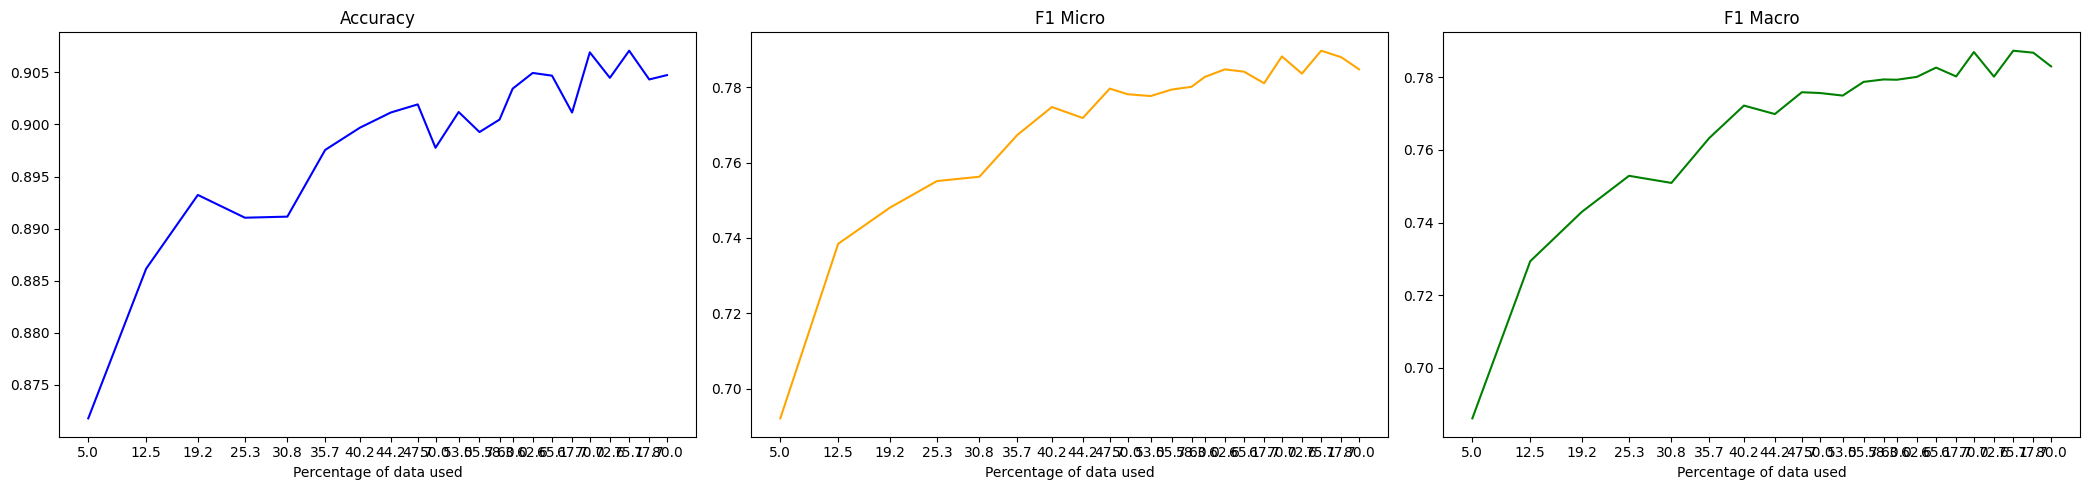

In [ ]:
active_learning(seeds[4], 4)